# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00369_5_M_120131_1"
fastq_file_base = "ERR188260"

notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000579721:c.448C>T', 'ENST00000295685:c.344C>T', 'ENST00000391857:c.406G>A', 'ENST00000360830:c.187T>C', 'ENST00000262584:c.788G>A', 'ENST00000483379:c.462C>T', 'ENST00000304043:c.606A>G', 'ENST00000374982:c.131G>A', 'ENST00000279035:c.576C>T', 'ENST00000353801:c.709G>A', 'ENST00000344063:c.729G>A', 'ENST00000253024:c.2471A>C', 'ENST00000521764:c.51C>G', 'ENST00000216268:c.2123A>G', 'ENST00000390290:c.183G>A', 'ENST00000344450:c.557C>T', 'ENST00000262097:c.482C>T', 'ENST00000263238:c.523A>G', 'ENST00000393190:c.425T>C', 'ENST00000355716:c.1020G>A', 'ENST00000322203:c.87G>C', 'ENST00000188376:c.782T>C', 'ENST00000189444:c.901T>C', 'ENST00000280326:c.1069G>A', 'ENST00000230050:c.281C>T', 'ENST00000256996:c.247C>T', 'ENST00000390314:c.283G>A', 'ENST00000303525:c.1171A>T', 'ENST00000594527:c.277T>C', 'ENST00000228136:c.537T>C', 'ENST00000232125:c.582C>T', 'ENST00000311521:c.478G>A', 'ENST00000262584:c.635C>T', 'ENST00000354725:c.1702G>A', 'ENST00000608106:c.494A>C', 'ENST0000031152

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
175135      1206.0   ENST00000390319.2:c.66G>A  ENST00000390319:c.118G>A   
58568       1179.0  ENST00000579721.1:c.142G>A  ENST00000579721:c.142G>A   
59340       1083.0  ENST00000343139.5:c.318C>T  ENST00000343139:c.420C>T   
128124       793.0  ENST00000604412.1:c.320C>T  ENST00000604412:c.399C>T   
175165       504.0  ENST00000390319.2:c.209G>A  ENST00000390319:c.261G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
175135  ENST00000390319  ENSG00000211673      4431.0       0.0  
58568   ENST00000579721             None         NaN       0.0  
59340   ENST00000343139  ENSG00000196735     13633.0       0.0  
128124  ENST00000604412             None         NaN       0.0  
175165  ENST00000390319  ENSG00000211673      4431.0       0.0

### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [ ]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
175135      1206.0   ENST00000390319.2:c.66G>A  ENST00000390319:c.118G>A   
58568       1179.0  ENST00000579721.1:c.142G>A  ENST00000579721:c.142G>A   
59340       1083.0  ENST00000343139.5:c.318C>T  ENST00000343139:c.420C>T   
128124       793.0  ENST00000604412.1:c.320C>T  ENST00000604412:c.399C>T   
175165       504.0  ENST00000390319.2:c.209G>A  ENST00000390319:c.261G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
175135  ENST00000390319  ENSG00000211673      4431.0       0.0  
58568   ENST00000579721             None         NaN       0.0  
59340   ENST00000343139  ENSG00000196735     13633.0       0.0  
128124  ENST00000604412             None         NaN       0.0  
175165  ENST00000390319  ENSG00000211673      4431.0       0.0

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

11:23:46: Aligning to genome


11:55:06: SAM --> BAM


12:04:51: BAM sort


[bam_sort_core] merging from 11 files and 1 in-memory blocks...


12:21:56: Remove 256's


12:40:50: BAM index


12:41:50: Entering the loop



  0%|                                                                                                                                                                                  | 0/684 [00:00<?, ?it/s]


  0%|▏                                                                                                                                                                         | 1/684 [00:01<14:29,  1.27s/it]


  0%|▍                                                                                                                                                                         | 2/684 [00:02<14:59,  1.32s/it]


  0%|▋                                                                                                                                                                         | 3/684 [00:03<11:07,  1.02it/s]


  1%|▉                                                                                                                                                                         | 4/684 [00:04<12:19,  1.09s/it]


  1%|█▏                                                                                                                                                                        | 5/684 [00:05<10:26,  1.08it/s]


  1%|█▍                                                                                                                                                                        | 6/684 [00:05<09:04,  1.24it/s]


  1%|█▋                                                                                                                                                                        | 7/684 [00:06<10:28,  1.08it/s]


  1%|█▉                                                                                                                                                                        | 8/684 [00:07<09:53,  1.14it/s]


  1%|██▏                                                                                                                                                                       | 9/684 [00:08<09:33,  1.18it/s]


  1%|██▍                                                                                                                                                                      | 10/684 [00:08<08:39,  1.30it/s]


  2%|██▋                                                                                                                                                                      | 11/684 [00:09<07:57,  1.41it/s]


  2%|██▉                                                                                                                                                                      | 12/684 [00:10<08:35,  1.30it/s]


  2%|███▏                                                                                                                                                                     | 13/684 [00:11<08:40,  1.29it/s]


  2%|███▍                                                                                                                                                                     | 14/684 [00:12<09:56,  1.12it/s]


  2%|███▋                                                                                                                                                                     | 15/684 [00:14<12:28,  1.12s/it]


  2%|███▉                                                                                                                                                                     | 16/684 [00:15<12:38,  1.14s/it]


  2%|████▏                                                                                                                                                                    | 17/684 [00:15<10:43,  1.04it/s]


  3%|████▍                                                                                                                                                                    | 18/684 [00:17<11:42,  1.06s/it]


  3%|████▋                                                                                                                                                                    | 19/684 [00:17<10:02,  1.10it/s]


  3%|████▉                                                                                                                                                                    | 20/684 [00:18<08:57,  1.24it/s]


  3%|█████▏                                                                                                                                                                   | 21/684 [00:18<08:10,  1.35it/s]


  3%|█████▍                                                                                                                                                                   | 22/684 [00:19<08:12,  1.35it/s]


  3%|█████▋                                                                                                                                                                   | 23/684 [00:20<07:38,  1.44it/s]


  4%|█████▉                                                                                                                                                                   | 24/684 [00:20<07:13,  1.52it/s]


  4%|██████▏                                                                                                                                                                  | 25/684 [00:21<06:55,  1.58it/s]


  4%|██████▍                                                                                                                                                                  | 26/684 [00:21<07:14,  1.52it/s]


  4%|██████▋                                                                                                                                                                  | 27/684 [00:22<06:58,  1.57it/s]


  4%|██████▉                                                                                                                                                                  | 28/684 [00:23<07:03,  1.55it/s]


  4%|███████▏                                                                                                                                                                 | 29/684 [00:23<06:53,  1.58it/s]


  4%|███████▍                                                                                                                                                                 | 30/684 [00:24<07:39,  1.42it/s]


  5%|███████▋                                                                                                                                                                 | 31/684 [00:25<09:23,  1.16it/s]


  5%|███████▉                                                                                                                                                                 | 32/684 [00:27<10:34,  1.03it/s]


  5%|████████▏                                                                                                                                                                | 33/684 [00:28<11:24,  1.05s/it]


  5%|████████▍                                                                                                                                                                | 34/684 [00:29<10:14,  1.06it/s]


  5%|████████▋                                                                                                                                                                | 35/684 [00:29<09:02,  1.20it/s]


  5%|████████▉                                                                                                                                                                | 36/684 [00:30<08:51,  1.22it/s]


  5%|█████████▏                                                                                                                                                               | 37/684 [00:31<08:10,  1.32it/s]


  6%|█████████▍                                                                                                                                                               | 38/684 [00:31<08:28,  1.27it/s]


  6%|█████████▋                                                                                                                                                               | 39/684 [00:32<08:45,  1.23it/s]


  6%|█████████▉                                                                                                                                                               | 40/684 [00:33<09:48,  1.09it/s]


  6%|██████████▏                                                                                                                                                              | 41/684 [00:34<08:57,  1.20it/s]


  6%|██████████▍                                                                                                                                                              | 42/684 [00:35<08:12,  1.30it/s]


  6%|██████████▌                                                                                                                                                              | 43/684 [00:35<07:38,  1.40it/s]


  6%|██████████▊                                                                                                                                                              | 44/684 [00:36<07:10,  1.49it/s]


  7%|███████████                                                                                                                                                              | 45/684 [00:37<06:58,  1.53it/s]


  7%|███████████▎                                                                                                                                                             | 46/684 [00:37<06:43,  1.58it/s]


  7%|███████████▌                                                                                                                                                             | 47/684 [00:38<06:36,  1.61it/s]


  7%|███████████▊                                                                                                                                                             | 48/684 [00:38<06:31,  1.62it/s]


  7%|████████████                                                                                                                                                             | 49/684 [00:39<07:24,  1.43it/s]


  7%|████████████▎                                                                                                                                                            | 50/684 [00:40<07:03,  1.50it/s]


  7%|████████████▌                                                                                                                                                            | 51/684 [00:40<06:48,  1.55it/s]


  8%|████████████▊                                                                                                                                                            | 52/684 [00:41<06:40,  1.58it/s]


  8%|█████████████                                                                                                                                                            | 53/684 [00:42<07:10,  1.46it/s]


  8%|█████████████▎                                                                                                                                                           | 54/684 [00:42<06:50,  1.54it/s]


  8%|█████████████▌                                                                                                                                                           | 55/684 [00:43<06:42,  1.56it/s]


  8%|█████████████▊                                                                                                                                                           | 56/684 [00:44<08:24,  1.25it/s]


  8%|██████████████                                                                                                                                                           | 57/684 [00:45<07:48,  1.34it/s]


  8%|██████████████▎                                                                                                                                                          | 58/684 [00:45<07:17,  1.43it/s]


  9%|██████████████▌                                                                                                                                                          | 59/684 [00:46<06:54,  1.51it/s]


  9%|██████████████▊                                                                                                                                                          | 60/684 [00:47<07:03,  1.47it/s]


  9%|███████████████                                                                                                                                                          | 61/684 [00:48<08:36,  1.21it/s]


  9%|███████████████▎                                                                                                                                                         | 62/684 [00:48<07:49,  1.33it/s]


  9%|███████████████▌                                                                                                                                                         | 63/684 [00:49<07:26,  1.39it/s]


  9%|███████████████▊                                                                                                                                                         | 64/684 [00:50<06:59,  1.48it/s]


 10%|████████████████                                                                                                                                                         | 65/684 [00:50<07:15,  1.42it/s]


 10%|████████████████▎                                                                                                                                                        | 66/684 [00:52<08:57,  1.15it/s]


 10%|████████████████▌                                                                                                                                                        | 67/684 [00:52<08:02,  1.28it/s]


 10%|████████████████▊                                                                                                                                                        | 68/684 [00:53<09:22,  1.10it/s]


 10%|█████████████████                                                                                                                                                        | 69/684 [00:55<10:20,  1.01s/it]


 10%|█████████████████▎                                                                                                                                                       | 70/684 [00:56<11:01,  1.08s/it]


 10%|█████████████████▌                                                                                                                                                       | 71/684 [00:56<09:31,  1.07it/s]


 11%|█████████████████▊                                                                                                                                                       | 72/684 [00:57<08:56,  1.14it/s]


 11%|██████████████████                                                                                                                                                       | 73/684 [00:58<08:00,  1.27it/s]


 11%|██████████████████▎                                                                                                                                                      | 74/684 [00:58<07:18,  1.39it/s]


 11%|██████████████████▌                                                                                                                                                      | 75/684 [01:00<10:11,  1.00s/it]


 11%|██████████████████▊                                                                                                                                                      | 76/684 [01:01<08:55,  1.14it/s]


 11%|███████████████████                                                                                                                                                      | 77/684 [01:01<08:16,  1.22it/s]


 11%|███████████████████▎                                                                                                                                                     | 78/684 [01:02<07:34,  1.33it/s]


 12%|███████████████████▌                                                                                                                                                     | 79/684 [01:02<06:59,  1.44it/s]


 12%|███████████████████▊                                                                                                                                                     | 80/684 [01:03<07:12,  1.40it/s]


 12%|████████████████████                                                                                                                                                     | 81/684 [01:04<07:38,  1.31it/s]


 12%|████████████████████▎                                                                                                                                                    | 82/684 [01:05<07:08,  1.41it/s]


 12%|████████████████████▌                                                                                                                                                    | 83/684 [01:05<06:45,  1.48it/s]


 12%|████████████████████▊                                                                                                                                                    | 84/684 [01:06<06:36,  1.51it/s]


 12%|█████████████████████                                                                                                                                                    | 85/684 [01:07<06:23,  1.56it/s]


 13%|█████████████████████▏                                                                                                                                                   | 86/684 [01:07<06:14,  1.60it/s]


 13%|█████████████████████▍                                                                                                                                                   | 87/684 [01:08<06:08,  1.62it/s]


 13%|█████████████████████▋                                                                                                                                                   | 88/684 [01:08<06:04,  1.63it/s]


 13%|█████████████████████▉                                                                                                                                                   | 89/684 [01:09<06:24,  1.55it/s]


 13%|██████████████████████▏                                                                                                                                                  | 90/684 [01:10<06:15,  1.58it/s]


 13%|██████████████████████▍                                                                                                                                                  | 91/684 [01:10<06:10,  1.60it/s]


 13%|██████████████████████▋                                                                                                                                                  | 92/684 [01:11<06:42,  1.47it/s]


 14%|██████████████████████▉                                                                                                                                                  | 93/684 [01:12<08:19,  1.18it/s]


 14%|███████████████████████▏                                                                                                                                                 | 94/684 [01:13<07:37,  1.29it/s]


 14%|███████████████████████▍                                                                                                                                                 | 95/684 [01:13<07:06,  1.38it/s]


 14%|███████████████████████▋                                                                                                                                                 | 96/684 [01:14<06:52,  1.43it/s]


 14%|███████████████████████▉                                                                                                                                                 | 97/684 [01:15<06:33,  1.49it/s]


 14%|████████████████████████▏                                                                                                                                                | 98/684 [01:15<06:16,  1.56it/s]


 14%|████████████████████████▍                                                                                                                                                | 99/684 [01:16<06:06,  1.59it/s]


 15%|████████████████████████▌                                                                                                                                               | 100/684 [01:17<07:57,  1.22it/s]


 15%|████████████████████████▊                                                                                                                                               | 101/684 [01:18<07:17,  1.33it/s]


 15%|█████████████████████████                                                                                                                                               | 102/684 [01:18<06:46,  1.43it/s]


 15%|█████████████████████████▌                                                                                                                                              | 104/684 [01:19<05:11,  1.86it/s]


 15%|█████████████████████████▊                                                                                                                                              | 105/684 [01:20<05:33,  1.73it/s]


 15%|██████████████████████████                                                                                                                                              | 106/684 [01:20<05:37,  1.71it/s]


 16%|██████████████████████████▎                                                                                                                                             | 107/684 [01:22<07:14,  1.33it/s]


 16%|██████████████████████████▌                                                                                                                                             | 108/684 [01:22<06:48,  1.41it/s]


 16%|██████████████████████████▊                                                                                                                                             | 109/684 [01:23<08:03,  1.19it/s]


 16%|███████████████████████████                                                                                                                                             | 110/684 [01:24<07:56,  1.20it/s]


 16%|███████████████████████████▎                                                                                                                                            | 111/684 [01:25<07:15,  1.31it/s]


 16%|███████████████████████████▌                                                                                                                                            | 112/684 [01:25<06:58,  1.37it/s]


 17%|███████████████████████████▊                                                                                                                                            | 113/684 [01:26<06:34,  1.45it/s]


 17%|████████████████████████████                                                                                                                                            | 114/684 [01:27<06:16,  1.52it/s]


 17%|████████████████████████████▏                                                                                                                                           | 115/684 [01:27<05:59,  1.58it/s]


 17%|████████████████████████████▍                                                                                                                                           | 116/684 [01:28<06:41,  1.42it/s]


 17%|████████████████████████████▋                                                                                                                                           | 117/684 [01:29<06:32,  1.44it/s]


 17%|████████████████████████████▉                                                                                                                                           | 118/684 [01:29<06:16,  1.50it/s]


 17%|█████████████████████████████▏                                                                                                                                          | 119/684 [01:30<06:14,  1.51it/s]


 18%|█████████████████████████████▍                                                                                                                                          | 120/684 [01:31<06:02,  1.56it/s]


 18%|█████████████████████████████▋                                                                                                                                          | 121/684 [01:31<05:51,  1.60it/s]


 18%|█████████████████████████████▉                                                                                                                                          | 122/684 [01:32<05:42,  1.64it/s]


 18%|██████████████████████████████▏                                                                                                                                         | 123/684 [01:32<05:44,  1.63it/s]


 18%|██████████████████████████████▍                                                                                                                                         | 124/684 [01:33<05:45,  1.62it/s]


 18%|██████████████████████████████▋                                                                                                                                         | 125/684 [01:34<05:43,  1.63it/s]


 18%|██████████████████████████████▉                                                                                                                                         | 126/684 [01:34<05:38,  1.65it/s]


 19%|███████████████████████████████▏                                                                                                                                        | 127/684 [01:36<07:50,  1.18it/s]


 19%|███████████████████████████████▍                                                                                                                                        | 128/684 [01:36<07:08,  1.30it/s]


 19%|███████████████████████████████▋                                                                                                                                        | 129/684 [01:37<06:33,  1.41it/s]


 19%|███████████████████████████████▉                                                                                                                                        | 130/684 [01:37<06:10,  1.50it/s]


 19%|████████████████████████████████▏                                                                                                                                       | 131/684 [01:38<06:45,  1.36it/s]


 19%|████████████████████████████████▍                                                                                                                                       | 132/684 [01:39<06:27,  1.43it/s]


 19%|████████████████████████████████▋                                                                                                                                       | 133/684 [01:39<06:09,  1.49it/s]


 20%|████████████████████████████████▉                                                                                                                                       | 134/684 [01:40<05:51,  1.57it/s]


 20%|█████████████████████████████████▏                                                                                                                                      | 135/684 [01:41<06:23,  1.43it/s]


 20%|█████████████████████████████████▍                                                                                                                                      | 136/684 [01:42<08:00,  1.14it/s]


 20%|█████████████████████████████████▋                                                                                                                                      | 137/684 [01:43<07:09,  1.27it/s]


 20%|█████████████████████████████████▉                                                                                                                                      | 138/684 [01:43<06:35,  1.38it/s]


 20%|██████████████████████████████████▏                                                                                                                                     | 139/684 [01:44<06:42,  1.35it/s]


 20%|██████████████████████████████████▍                                                                                                                                     | 140/684 [01:45<06:17,  1.44it/s]


 21%|██████████████████████████████████▋                                                                                                                                     | 141/684 [01:45<05:59,  1.51it/s]


 21%|██████████████████████████████████▉                                                                                                                                     | 142/684 [01:46<05:44,  1.57it/s]


 21%|███████████████████████████████████                                                                                                                                     | 143/684 [01:46<05:38,  1.60it/s]


 21%|███████████████████████████████████▎                                                                                                                                    | 144/684 [01:48<07:20,  1.23it/s]


 21%|███████████████████████████████████▌                                                                                                                                    | 145/684 [01:48<06:47,  1.32it/s]


 21%|███████████████████████████████████▊                                                                                                                                    | 146/684 [01:49<06:54,  1.30it/s]


 21%|████████████████████████████████████                                                                                                                                    | 147/684 [01:50<06:53,  1.30it/s]


 22%|████████████████████████████████████▎                                                                                                                                   | 148/684 [01:50<06:30,  1.37it/s]


 22%|████████████████████████████████████▌                                                                                                                                   | 149/684 [01:51<06:06,  1.46it/s]


 22%|████████████████████████████████████▊                                                                                                                                   | 150/684 [01:52<07:24,  1.20it/s]


 22%|█████████████████████████████████████                                                                                                                                   | 151/684 [01:53<06:43,  1.32it/s]


 22%|█████████████████████████████████████▎                                                                                                                                  | 152/684 [01:54<06:50,  1.30it/s]


 22%|█████████████████████████████████████▌                                                                                                                                  | 153/684 [01:54<06:19,  1.40it/s]


 23%|█████████████████████████████████████▊                                                                                                                                  | 154/684 [01:55<05:59,  1.47it/s]


 23%|██████████████████████████████████████                                                                                                                                  | 155/684 [01:56<06:20,  1.39it/s]


 23%|██████████████████████████████████████▎                                                                                                                                 | 156/684 [01:56<06:31,  1.35it/s]


 23%|██████████████████████████████████████▌                                                                                                                                 | 157/684 [01:57<06:11,  1.42it/s]


 23%|██████████████████████████████████████▊                                                                                                                                 | 158/684 [01:58<06:33,  1.34it/s]


 23%|███████████████████████████████████████                                                                                                                                 | 159/684 [01:58<06:10,  1.42it/s]


 23%|███████████████████████████████████████▎                                                                                                                                | 160/684 [01:59<05:52,  1.49it/s]


 24%|███████████████████████████████████████▌                                                                                                                                | 161/684 [02:00<05:38,  1.54it/s]


 24%|███████████████████████████████████████▊                                                                                                                                | 162/684 [02:00<05:27,  1.59it/s]


 24%|████████████████████████████████████████                                                                                                                                | 163/684 [02:01<05:24,  1.61it/s]


 24%|████████████████████████████████████████▎                                                                                                                               | 164/684 [02:01<05:20,  1.62it/s]


 24%|████████████████████████████████████████▌                                                                                                                               | 165/684 [02:02<05:15,  1.65it/s]


 24%|████████████████████████████████████████▊                                                                                                                               | 166/684 [02:03<05:07,  1.68it/s]


 24%|█████████████████████████████████████████                                                                                                                               | 167/684 [02:04<06:35,  1.31it/s]


 25%|█████████████████████████████████████████▎                                                                                                                              | 168/684 [02:05<07:49,  1.10it/s]


 25%|█████████████████████████████████████████▌                                                                                                                              | 169/684 [02:06<06:56,  1.24it/s]


 25%|█████████████████████████████████████████▊                                                                                                                              | 170/684 [02:06<06:21,  1.35it/s]


 25%|██████████████████████████████████████████                                                                                                                              | 171/684 [02:07<05:57,  1.43it/s]


 25%|██████████████████████████████████████████▏                                                                                                                             | 172/684 [02:07<05:42,  1.49it/s]


 25%|██████████████████████████████████████████▍                                                                                                                             | 173/684 [02:08<06:05,  1.40it/s]


 25%|██████████████████████████████████████████▋                                                                                                                             | 174/684 [02:09<05:57,  1.43it/s]


 26%|██████████████████████████████████████████▉                                                                                                                             | 175/684 [02:09<05:54,  1.44it/s]


 26%|███████████████████████████████████████████▏                                                                                                                            | 176/684 [02:11<07:06,  1.19it/s]


 26%|███████████████████████████████████████████▍                                                                                                                            | 177/684 [02:11<06:26,  1.31it/s]


 26%|███████████████████████████████████████████▋                                                                                                                            | 178/684 [02:12<05:53,  1.43it/s]


 26%|███████████████████████████████████████████▉                                                                                                                            | 179/684 [02:12<05:34,  1.51it/s]


 26%|████████████████████████████████████████████▏                                                                                                                           | 180/684 [02:13<05:22,  1.56it/s]


 26%|████████████████████████████████████████████▍                                                                                                                           | 181/684 [02:14<05:17,  1.59it/s]


 27%|████████████████████████████████████████████▋                                                                                                                           | 182/684 [02:14<05:14,  1.60it/s]


 27%|████████████████████████████████████████████▉                                                                                                                           | 183/684 [02:15<05:06,  1.63it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                          | 184/684 [02:15<05:09,  1.61it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                          | 185/684 [02:16<05:33,  1.50it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                          | 186/684 [02:17<05:44,  1.44it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                          | 187/684 [02:18<06:58,  1.19it/s]


 27%|██████████████████████████████████████████████▏                                                                                                                         | 188/684 [02:19<06:19,  1.31it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                         | 189/684 [02:19<06:18,  1.31it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                         | 190/684 [02:20<05:48,  1.42it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                         | 191/684 [02:21<05:36,  1.46it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                        | 192/684 [02:21<05:20,  1.54it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                        | 193/684 [02:22<05:08,  1.59it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                        | 194/684 [02:22<05:02,  1.62it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                        | 195/684 [02:24<06:24,  1.27it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                       | 196/684 [02:24<05:55,  1.37it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                       | 197/684 [02:25<05:37,  1.44it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                       | 198/684 [02:25<05:30,  1.47it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                       | 199/684 [02:26<05:15,  1.54it/s]


 29%|█████████████████████████████████████████████████                                                                                                                       | 200/684 [02:27<06:41,  1.21it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                      | 201/684 [02:29<07:54,  1.02it/s]


 30%|█████████████████████████████████████████████████▌                                                                                                                      | 202/684 [02:29<07:02,  1.14it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                      | 203/684 [02:31<08:07,  1.01s/it]


 30%|██████████████████████████████████████████████████                                                                                                                      | 204/684 [02:32<08:30,  1.06s/it]


 30%|██████████████████████████████████████████████████▎                                                                                                                     | 205/684 [02:32<07:24,  1.08it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                     | 206/684 [02:33<06:41,  1.19it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                     | 207/684 [02:34<07:44,  1.03it/s]


 30%|███████████████████████████████████████████████████                                                                                                                     | 208/684 [02:36<08:23,  1.06s/it]


 31%|███████████████████████████████████████████████████▎                                                                                                                    | 209/684 [02:36<07:14,  1.09it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                    | 210/684 [02:37<06:32,  1.21it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                    | 211/684 [02:37<05:57,  1.32it/s]


 31%|████████████████████████████████████████████████████                                                                                                                    | 212/684 [02:38<05:35,  1.41it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                   | 213/684 [02:39<05:23,  1.45it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                   | 214/684 [02:40<06:38,  1.18it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                   | 215/684 [02:41<07:26,  1.05it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                   | 216/684 [02:42<06:36,  1.18it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                  | 217/684 [02:42<05:58,  1.30it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                  | 218/684 [02:43<05:33,  1.40it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 219/684 [02:43<05:18,  1.46it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                  | 220/684 [02:44<05:39,  1.37it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                 | 221/684 [02:45<05:19,  1.45it/s]


 32%|██████████████████████████████████████████████████████▌                                                                                                                 | 222/684 [02:45<05:03,  1.52it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                 | 223/684 [02:46<05:20,  1.44it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                 | 224/684 [02:47<05:05,  1.51it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                | 225/684 [02:47<04:57,  1.54it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                | 226/684 [02:48<04:52,  1.56it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                | 227/684 [02:49<04:50,  1.57it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                | 228/684 [02:50<06:05,  1.25it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 229/684 [02:51<06:58,  1.09it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 230/684 [02:52<06:14,  1.21it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 231/684 [02:52<05:41,  1.33it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 232/684 [02:53<05:58,  1.26it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 233/684 [02:54<05:30,  1.37it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 234/684 [02:54<05:06,  1.47it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 235/684 [02:55<04:53,  1.53it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                              | 236/684 [02:55<04:43,  1.58it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 237/684 [02:56<04:37,  1.61it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 238/684 [02:57<04:47,  1.55it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 239/684 [02:57<04:41,  1.58it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 240/684 [02:58<05:11,  1.43it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 241/684 [02:59<05:02,  1.46it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 242/684 [03:00<06:08,  1.20it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 243/684 [03:01<05:38,  1.30it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 244/684 [03:01<05:15,  1.40it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 245/684 [03:02<06:17,  1.16it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 246/684 [03:03<05:37,  1.30it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 247/684 [03:04<05:15,  1.38it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 248/684 [03:04<04:57,  1.47it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 249/684 [03:05<06:01,  1.20it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 250/684 [03:06<05:27,  1.33it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 251/684 [03:07<05:07,  1.41it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 252/684 [03:07<04:52,  1.48it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 253/684 [03:08<04:47,  1.50it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 254/684 [03:08<04:43,  1.52it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 255/684 [03:09<04:30,  1.58it/s]


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 256/684 [03:10<04:23,  1.62it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 257/684 [03:10<04:16,  1.66it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 258/684 [03:11<04:11,  1.70it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 259/684 [03:11<04:11,  1.69it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 260/684 [03:13<05:53,  1.20it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 261/684 [03:13<05:18,  1.33it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 262/684 [03:14<04:56,  1.42it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 263/684 [03:15<04:51,  1.44it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 264/684 [03:16<05:56,  1.18it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 265/684 [03:17<06:53,  1.01it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 266/684 [03:18<06:06,  1.14it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 267/684 [03:18<05:30,  1.26it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 268/684 [03:19<05:05,  1.36it/s]


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 269/684 [03:19<04:44,  1.46it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 270/684 [03:20<04:31,  1.52it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 271/684 [03:21<05:43,  1.20it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 272/684 [03:22<06:32,  1.05it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 273/684 [03:24<07:03,  1.03s/it]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 274/684 [03:24<06:12,  1.10it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 275/684 [03:25<05:30,  1.24it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 276/684 [03:26<05:28,  1.24it/s]


 40%|████████████████████████████████████████████████████████████████████                                                                                                    | 277/684 [03:27<06:25,  1.06it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 278/684 [03:28<07:01,  1.04s/it]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 279/684 [03:29<06:27,  1.04it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 280/684 [03:30<05:49,  1.16it/s]


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 281/684 [03:30<05:20,  1.26it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 282/684 [03:31<04:52,  1.38it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 283/684 [03:31<04:34,  1.46it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 284/684 [03:32<04:23,  1.52it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 285/684 [03:33<04:14,  1.57it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 286/684 [03:33<04:33,  1.45it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 287/684 [03:34<04:23,  1.51it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 288/684 [03:35<04:23,  1.50it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 289/684 [03:36<05:32,  1.19it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 290/684 [03:37<05:03,  1.30it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 291/684 [03:37<04:42,  1.39it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 292/684 [03:38<04:35,  1.42it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 293/684 [03:39<04:45,  1.37it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 294/684 [03:39<04:27,  1.46it/s]


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 295/684 [03:40<04:17,  1.51it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 296/684 [03:40<04:09,  1.55it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 297/684 [03:41<04:04,  1.59it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 298/684 [03:42<04:00,  1.61it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 299/684 [03:42<04:00,  1.60it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 300/684 [03:43<03:54,  1.64it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 301/684 [03:43<03:55,  1.63it/s]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 302/684 [03:44<03:58,  1.60it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 303/684 [03:45<03:58,  1.60it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 304/684 [03:45<03:57,  1.60it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 305/684 [03:46<03:51,  1.64it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 306/684 [03:47<03:49,  1.65it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 307/684 [03:47<03:49,  1.64it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 308/684 [03:48<03:46,  1.66it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 309/684 [03:48<03:52,  1.61it/s]


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 310/684 [03:49<03:55,  1.59it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 311/684 [03:50<03:53,  1.59it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 312/684 [03:51<05:05,  1.22it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 313/684 [03:51<04:36,  1.34it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 314/684 [03:52<04:20,  1.42it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 315/684 [03:53<04:07,  1.49it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 316/684 [03:53<03:58,  1.55it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 317/684 [03:54<03:49,  1.60it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 318/684 [03:55<04:12,  1.45it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 319/684 [03:55<03:59,  1.52it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 320/684 [03:56<03:50,  1.58it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 321/684 [03:57<03:53,  1.56it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 322/684 [03:57<03:51,  1.57it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 323/684 [03:58<04:01,  1.49it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 324/684 [03:58<03:50,  1.56it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 325/684 [03:59<03:43,  1.61it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 326/684 [04:00<03:41,  1.62it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 327/684 [04:00<03:35,  1.66it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 328/684 [04:01<03:31,  1.69it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 329/684 [04:01<03:33,  1.66it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 330/684 [04:02<03:32,  1.67it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 331/684 [04:03<03:27,  1.70it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 332/684 [04:03<03:28,  1.69it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 333/684 [04:04<03:29,  1.67it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 334/684 [04:04<03:27,  1.69it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 335/684 [04:05<03:29,  1.66it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 336/684 [04:06<03:30,  1.66it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 337/684 [04:06<03:24,  1.69it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 338/684 [04:07<03:27,  1.67it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 339/684 [04:07<03:24,  1.68it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 340/684 [04:08<03:24,  1.68it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 341/684 [04:09<03:25,  1.67it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 342/684 [04:09<03:25,  1.66it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 343/684 [04:10<03:21,  1.69it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 344/684 [04:10<03:20,  1.70it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 345/684 [04:11<03:18,  1.71it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 346/684 [04:11<03:16,  1.72it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 347/684 [04:12<03:42,  1.52it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 348/684 [04:13<03:32,  1.58it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 349/684 [04:13<03:27,  1.61it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 350/684 [04:14<03:30,  1.59it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 351/684 [04:15<03:42,  1.50it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 352/684 [04:15<03:35,  1.54it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 353/684 [04:16<03:29,  1.58it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 354/684 [04:17<03:25,  1.60it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 355/684 [04:17<03:21,  1.63it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 356/684 [04:18<03:20,  1.64it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 357/684 [04:19<03:40,  1.49it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 358/684 [04:19<03:50,  1.41it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 359/684 [04:20<03:39,  1.48it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 360/684 [04:21<03:53,  1.39it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 361/684 [04:21<03:38,  1.48it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 362/684 [04:22<03:29,  1.54it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 363/684 [04:23<03:25,  1.56it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 364/684 [04:23<03:19,  1.60it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 365/684 [04:24<03:19,  1.60it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 366/684 [04:24<03:14,  1.64it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 367/684 [04:25<03:12,  1.65it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 368/684 [04:26<03:15,  1.61it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 369/684 [04:26<03:15,  1.61it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 370/684 [04:27<03:12,  1.63it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 371/684 [04:28<03:08,  1.66it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 372/684 [04:28<03:04,  1.69it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 373/684 [04:29<03:03,  1.70it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 374/684 [04:29<03:05,  1.67it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 375/684 [04:30<03:05,  1.66it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 376/684 [04:30<03:04,  1.67it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 377/684 [04:31<03:24,  1.50it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 378/684 [04:32<03:15,  1.57it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 379/684 [04:32<03:09,  1.61it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 380/684 [04:33<03:11,  1.59it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 381/684 [04:34<03:27,  1.46it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 382/684 [04:35<03:17,  1.53it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 383/684 [04:35<03:16,  1.53it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 384/684 [04:36<03:12,  1.56it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 385/684 [04:36<03:05,  1.61it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 386/684 [04:37<02:59,  1.66it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 387/684 [04:38<03:00,  1.64it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 388/684 [04:38<03:01,  1.63it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 389/684 [04:39<03:02,  1.62it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 390/684 [04:39<02:59,  1.64it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 391/684 [04:40<03:16,  1.49it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 392/684 [04:41<03:09,  1.54it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 393/684 [04:41<03:05,  1.56it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 394/684 [04:42<03:01,  1.60it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 395/684 [04:43<03:06,  1.55it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 396/684 [04:43<03:04,  1.56it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 397/684 [04:44<03:04,  1.56it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 398/684 [04:45<03:04,  1.55it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 399/684 [04:45<03:00,  1.58it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 400/684 [04:46<02:54,  1.63it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 401/684 [04:46<02:55,  1.61it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 402/684 [04:47<02:54,  1.62it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 403/684 [04:48<02:50,  1.65it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 404/684 [04:48<02:47,  1.67it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 405/684 [04:49<02:47,  1.67it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 406/684 [04:49<02:46,  1.67it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 407/684 [04:50<02:44,  1.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 408/684 [04:51<02:45,  1.67it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 409/684 [04:51<02:44,  1.67it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 410/684 [04:52<02:48,  1.63it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 411/684 [04:52<02:44,  1.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 412/684 [04:53<02:43,  1.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 413/684 [04:54<02:43,  1.66it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 414/684 [04:54<02:40,  1.68it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 415/684 [04:55<02:38,  1.70it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 416/684 [04:56<03:29,  1.28it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 417/684 [04:57<03:30,  1.27it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 418/684 [04:57<03:15,  1.36it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 419/684 [04:58<03:05,  1.43it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 420/684 [04:59<02:55,  1.51it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 421/684 [04:59<02:49,  1.55it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 422/684 [05:00<02:44,  1.59it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 423/684 [05:00<02:44,  1.59it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 424/684 [05:01<02:39,  1.64it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 425/684 [05:02<02:54,  1.49it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 426/684 [05:02<02:47,  1.54it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 427/684 [05:03<02:42,  1.59it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 428/684 [05:04<02:39,  1.61it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 429/684 [05:04<02:56,  1.44it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 430/684 [05:05<02:49,  1.50it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 431/684 [05:06<02:41,  1.57it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 432/684 [05:06<02:38,  1.59it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 433/684 [05:07<02:36,  1.60it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 434/684 [05:07<02:34,  1.61it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 435/684 [05:08<02:30,  1.66it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 436/684 [05:09<02:34,  1.61it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 437/684 [05:10<02:48,  1.47it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 438/684 [05:10<02:40,  1.54it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 439/684 [05:11<02:37,  1.56it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 440/684 [05:11<02:34,  1.58it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 441/684 [05:12<02:29,  1.62it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 442/684 [05:13<02:30,  1.61it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 443/684 [05:13<02:29,  1.61it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 444/684 [05:14<02:33,  1.56it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 445/684 [05:14<02:30,  1.59it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 446/684 [05:15<02:27,  1.61it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 447/684 [05:16<02:27,  1.61it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 448/684 [05:16<02:22,  1.65it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 449/684 [05:17<03:01,  1.30it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 450/684 [05:18<02:48,  1.39it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 451/684 [05:19<02:40,  1.45it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 452/684 [05:19<02:32,  1.52it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 453/684 [05:20<02:30,  1.53it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 454/684 [05:20<02:25,  1.58it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 455/684 [05:21<02:37,  1.45it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 456/684 [05:22<02:45,  1.38it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 457/684 [05:23<02:34,  1.47it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 458/684 [05:23<02:27,  1.53it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 459/684 [05:24<02:23,  1.57it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 460/684 [05:24<02:19,  1.61it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 461/684 [05:25<02:16,  1.63it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 462/684 [05:26<02:26,  1.51it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 463/684 [05:26<02:21,  1.56it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 464/684 [05:27<02:29,  1.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 465/684 [05:28<02:22,  1.54it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 466/684 [05:28<02:16,  1.60it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 467/684 [05:29<02:14,  1.62it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 468/684 [05:29<02:11,  1.64it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 469/684 [05:30<02:10,  1.64it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 470/684 [05:31<02:23,  1.49it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 471/684 [05:31<02:17,  1.55it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 472/684 [05:32<02:12,  1.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 473/684 [05:33<02:11,  1.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 474/684 [05:33<02:09,  1.63it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 475/684 [05:34<02:11,  1.59it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 476/684 [05:35<02:12,  1.57it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 477/684 [05:35<02:08,  1.61it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 478/684 [05:36<02:17,  1.49it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 479/684 [05:37<02:52,  1.19it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 480/684 [05:38<02:42,  1.25it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 481/684 [05:39<03:10,  1.07it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 482/684 [05:40<02:50,  1.19it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 483/684 [05:40<02:36,  1.28it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 484/684 [05:41<02:29,  1.34it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 485/684 [05:42<02:20,  1.41it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 486/684 [05:42<02:12,  1.50it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 487/684 [05:43<02:07,  1.55it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 488/684 [05:43<02:03,  1.59it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 489/684 [05:44<01:59,  1.63it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 490/684 [05:45<01:59,  1.62it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 491/684 [05:45<02:00,  1.61it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 492/684 [05:46<02:00,  1.59it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 493/684 [05:47<02:11,  1.45it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 494/684 [05:47<02:04,  1.53it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 495/684 [05:48<02:03,  1.53it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 496/684 [05:49<02:17,  1.37it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 497/684 [05:50<02:11,  1.42it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 498/684 [05:50<02:06,  1.47it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 499/684 [05:51<02:35,  1.19it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 500/684 [05:52<02:21,  1.30it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 501/684 [05:53<02:10,  1.41it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 502/684 [05:53<02:03,  1.48it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 503/684 [05:54<02:01,  1.50it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 504/684 [05:54<01:56,  1.55it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 505/684 [05:55<01:52,  1.59it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 506/684 [05:56<01:49,  1.63it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 507/684 [05:56<01:46,  1.66it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 509/684 [05:57<01:28,  1.97it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 510/684 [05:58<01:33,  1.85it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 511/684 [05:58<01:37,  1.77it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 512/684 [05:59<01:38,  1.74it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 513/684 [05:59<01:40,  1.70it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 514/684 [06:00<01:40,  1.70it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 515/684 [06:01<01:38,  1.71it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 516/684 [06:01<01:40,  1.67it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 517/684 [06:02<01:38,  1.70it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 518/684 [06:03<01:47,  1.54it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 519/684 [06:03<01:42,  1.60it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 520/684 [06:04<01:39,  1.65it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 521/684 [06:04<01:36,  1.68it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 522/684 [06:05<01:37,  1.67it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 523/684 [06:05<01:34,  1.70it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 524/684 [06:06<01:33,  1.71it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 525/684 [06:07<01:33,  1.71it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 526/684 [06:07<01:42,  1.54it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 527/684 [06:08<01:38,  1.60it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 528/684 [06:09<01:41,  1.53it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 529/684 [06:09<01:39,  1.56it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 530/684 [06:10<01:36,  1.60it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 531/684 [06:11<01:34,  1.62it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 532/684 [06:11<01:33,  1.63it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 533/684 [06:12<01:31,  1.65it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 534/684 [06:12<01:31,  1.65it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 535/684 [06:13<01:28,  1.69it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 536/684 [06:13<01:26,  1.70it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 537/684 [06:14<01:29,  1.64it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 538/684 [06:15<01:27,  1.66it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 539/684 [06:15<01:27,  1.66it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 540/684 [06:16<01:26,  1.67it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 541/684 [06:16<01:24,  1.70it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 542/684 [06:17<01:30,  1.57it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 543/684 [06:18<01:28,  1.60it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 544/684 [06:18<01:26,  1.61it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 545/684 [06:19<01:24,  1.65it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 546/684 [06:20<01:24,  1.63it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 547/684 [06:20<01:28,  1.56it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 548/684 [06:21<01:26,  1.57it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 549/684 [06:22<01:24,  1.60it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 550/684 [06:22<01:30,  1.48it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 551/684 [06:23<01:26,  1.53it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 552/684 [06:24<01:23,  1.57it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 553/684 [06:24<01:21,  1.60it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 554/684 [06:25<01:19,  1.64it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 555/684 [06:25<01:25,  1.51it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 556/684 [06:26<01:22,  1.56it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 557/684 [06:27<01:19,  1.60it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 558/684 [06:27<01:17,  1.63it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 559/684 [06:28<01:15,  1.67it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 560/684 [06:28<01:14,  1.66it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 561/684 [06:29<01:19,  1.54it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 562/684 [06:30<01:16,  1.60it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 563/684 [06:30<01:13,  1.64it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 564/684 [06:31<01:17,  1.54it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 565/684 [06:32<01:16,  1.55it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 566/684 [06:33<01:35,  1.23it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 567/684 [06:34<01:28,  1.32it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 568/684 [06:35<01:49,  1.06it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 569/684 [06:36<01:35,  1.20it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 570/684 [06:37<01:48,  1.05it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 571/684 [06:38<01:58,  1.05s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 572/684 [06:39<02:08,  1.15s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 573/684 [06:40<01:50,  1.00it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 574/684 [06:41<01:35,  1.15it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 575/684 [06:41<01:25,  1.27it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 576/684 [06:42<01:19,  1.36it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 577/684 [06:42<01:13,  1.45it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 578/684 [06:43<01:09,  1.52it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 579/684 [06:44<01:06,  1.58it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 580/684 [06:44<01:04,  1.61it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 581/684 [06:45<01:02,  1.65it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 582/684 [06:45<01:01,  1.67it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 583/684 [06:46<01:01,  1.65it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 584/684 [06:47<01:01,  1.63it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 585/684 [06:47<01:00,  1.63it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 586/684 [06:48<00:59,  1.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 587/684 [06:48<00:58,  1.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 588/684 [06:49<00:57,  1.68it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 589/684 [06:50<00:56,  1.67it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 590/684 [06:50<00:59,  1.57it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 591/684 [06:51<01:04,  1.43it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 592/684 [06:52<01:07,  1.37it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 593/684 [06:53<01:09,  1.31it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 594/684 [06:54<01:10,  1.29it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 595/684 [06:54<01:04,  1.38it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 596/684 [06:55<01:16,  1.15it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 597/684 [06:56<01:09,  1.25it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 598/684 [06:57<01:03,  1.36it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 599/684 [06:58<01:09,  1.22it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 600/684 [06:58<01:04,  1.31it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 601/684 [06:59<00:59,  1.40it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 602/684 [07:00<01:01,  1.32it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 603/684 [07:00<00:57,  1.41it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 604/684 [07:01<00:55,  1.43it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 605/684 [07:02<00:57,  1.37it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 606/684 [07:02<00:54,  1.43it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 607/684 [07:03<00:51,  1.51it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 608/684 [07:04<00:50,  1.51it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 609/684 [07:04<00:53,  1.40it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 610/684 [07:05<00:53,  1.38it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 611/684 [07:06<00:52,  1.39it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 612/684 [07:07<00:48,  1.47it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 613/684 [07:07<00:47,  1.48it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 614/684 [07:08<00:46,  1.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 615/684 [07:08<00:45,  1.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 616/684 [07:09<00:43,  1.56it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 617/684 [07:10<00:45,  1.47it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 618/684 [07:10<00:44,  1.49it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 619/684 [07:11<00:42,  1.53it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 620/684 [07:12<00:42,  1.51it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 621/684 [07:12<00:41,  1.50it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 622/684 [07:13<00:45,  1.38it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 623/684 [07:14<00:42,  1.43it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 624/684 [07:15<00:39,  1.52it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 625/684 [07:15<00:40,  1.46it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 626/684 [07:16<00:39,  1.46it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 627/684 [07:17<00:49,  1.16it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 628/684 [07:18<00:43,  1.29it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 629/684 [07:18<00:40,  1.36it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 630/684 [07:19<00:38,  1.41it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 631/684 [07:20<00:35,  1.48it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 632/684 [07:20<00:33,  1.53it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 633/684 [07:21<00:32,  1.56it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 634/684 [07:22<00:34,  1.44it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 635/684 [07:22<00:32,  1.51it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 636/684 [07:23<00:31,  1.52it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 637/684 [07:24<00:29,  1.57it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 638/684 [07:24<00:30,  1.52it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 639/684 [07:25<00:33,  1.36it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 640/684 [07:26<00:30,  1.46it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 641/684 [07:26<00:28,  1.49it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 642/684 [07:27<00:28,  1.47it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 643/684 [07:28<00:29,  1.39it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 644/684 [07:28<00:26,  1.49it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 645/684 [07:29<00:25,  1.52it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 646/684 [07:30<00:24,  1.57it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 647/684 [07:30<00:25,  1.45it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 648/684 [07:31<00:23,  1.53it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 649/684 [07:32<00:23,  1.46it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 650/684 [07:32<00:23,  1.47it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 651/684 [07:33<00:21,  1.51it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 652/684 [07:34<00:20,  1.54it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 653/684 [07:34<00:20,  1.53it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 654/684 [07:36<00:25,  1.20it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 655/684 [07:36<00:22,  1.30it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 656/684 [07:37<00:24,  1.13it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 657/684 [07:38<00:23,  1.15it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 658/684 [07:39<00:20,  1.27it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 659/684 [07:39<00:18,  1.38it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 660/684 [07:40<00:16,  1.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 661/684 [07:41<00:15,  1.49it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 662/684 [07:41<00:14,  1.51it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 663/684 [07:42<00:13,  1.52it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 664/684 [07:43<00:13,  1.53it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 665/684 [07:43<00:12,  1.56it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 666/684 [07:44<00:11,  1.56it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 667/684 [07:44<00:10,  1.61it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 668/684 [07:45<00:10,  1.55it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/684 [07:46<00:09,  1.59it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 670/684 [07:46<00:08,  1.59it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/684 [07:48<00:10,  1.25it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 672/684 [07:48<00:08,  1.34it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 673/684 [07:49<00:07,  1.42it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 674/684 [07:49<00:06,  1.50it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 675/684 [07:50<00:05,  1.55it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 676/684 [07:51<00:05,  1.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 677/684 [07:51<00:04,  1.55it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 678/684 [07:52<00:03,  1.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 679/684 [07:52<00:03,  1.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 680/684 [07:53<00:02,  1.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 681/684 [07:54<00:01,  1.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 682/684 [07:54<00:01,  1.60it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 683/684 [07:55<00:00,  1.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [07:55<00:00,  1.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [07:55<00:00,  1.44it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 387
Number of false variants: 294
Number of undetermined variants: 1
True variants list: ['ENST00000390319:c.118G>A', 'ENST00000579721:c.142G>A', 'ENST00000343139:c.420C>T', 'ENST00000604412:c.399C>T', 'ENST00000390319:c.261G>A', 'ENST00000390319:c.347A>C', 'ENST00000604930:c.303G>T', 'ENST00000390243:c.387A>G', 'ENST00000390243:c.326T>C', 'ENST00000483158:c.202A>C', 'ENST00000390319:c.197A>G', 'ENST00000390314:c.246G>C', 'ENST00000390243:c.333C>T', 'ENST00000603600:c.285G>A', 'ENST00000603210:c.188T>G', 'ENST00000604045:c.177C>T', 'ENST00000390305:c.298A>T', 'ENST00000604930:c.149G>C', 'ENST00000390294:c.230G>A', 'ENST00000483158:c.195A>G', 'ENST00000390277:c.387G>A', 'ENST00000390243:c.320G>A', 'ENST00000390297:c.199G>A', 'ENST00000390299:c.203G>A', 'ENST00000390319:c.204C>T', 'ENST00000390237:c.67C>T', 'ENST00000390237:c.249G>C', 'ENST00000479981:c.138A>G', 'ENST00000390312:c.310A>G', 'ENST00000603423:c.158A>C', 'ENST00000603423:c.137G>A', 'ENST00000390237:c

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/detailed_out_modified_bam.txt


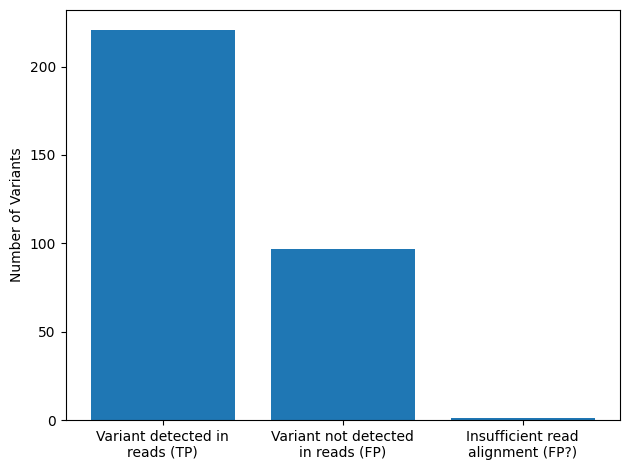

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

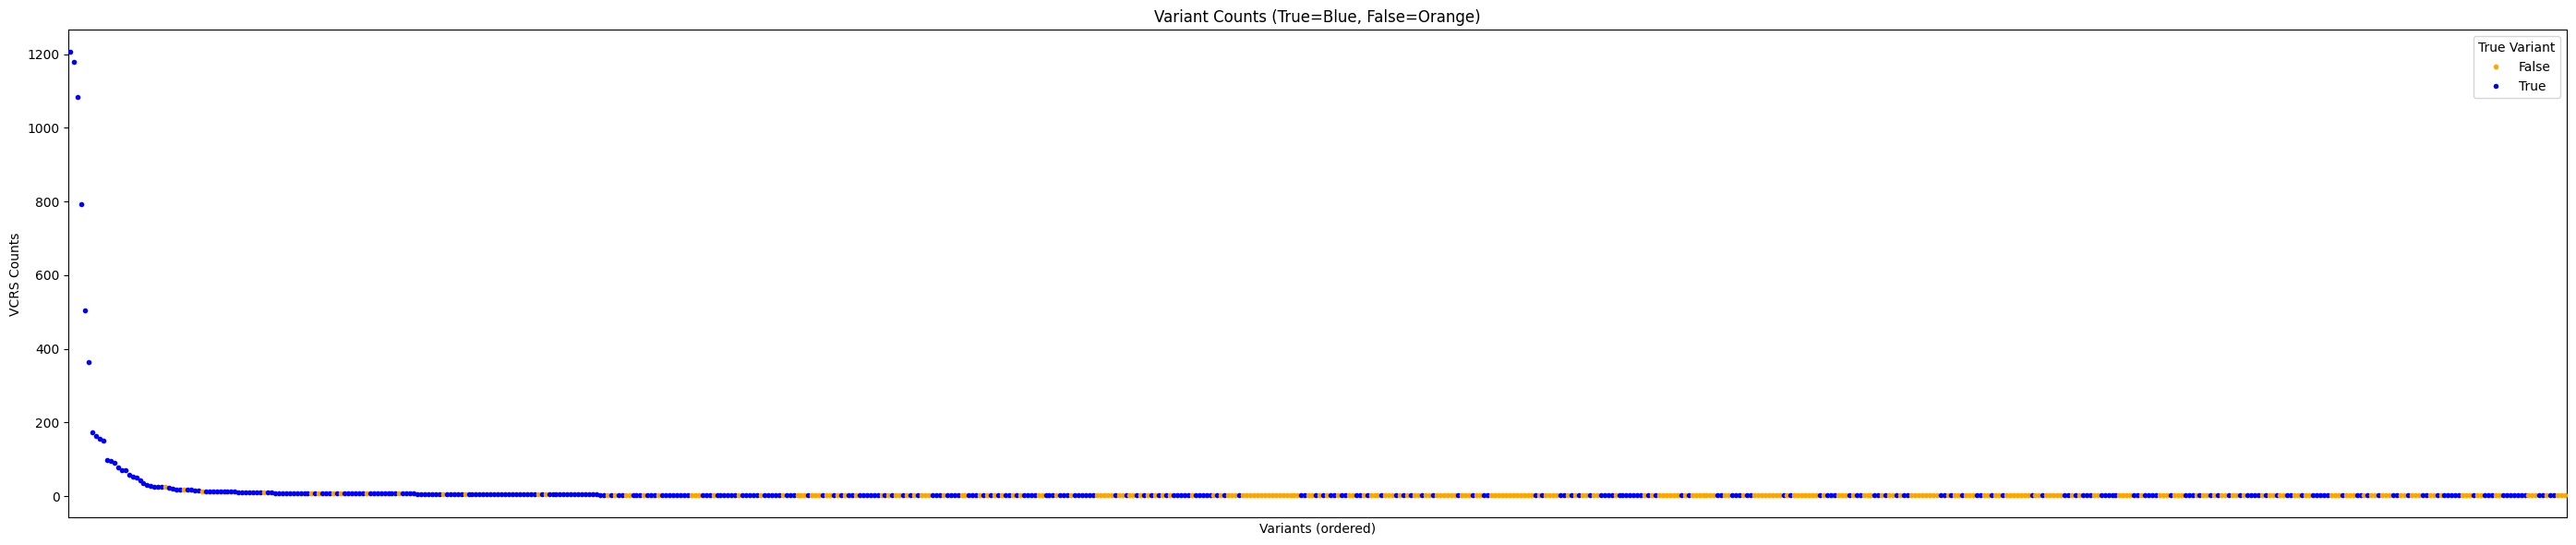

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

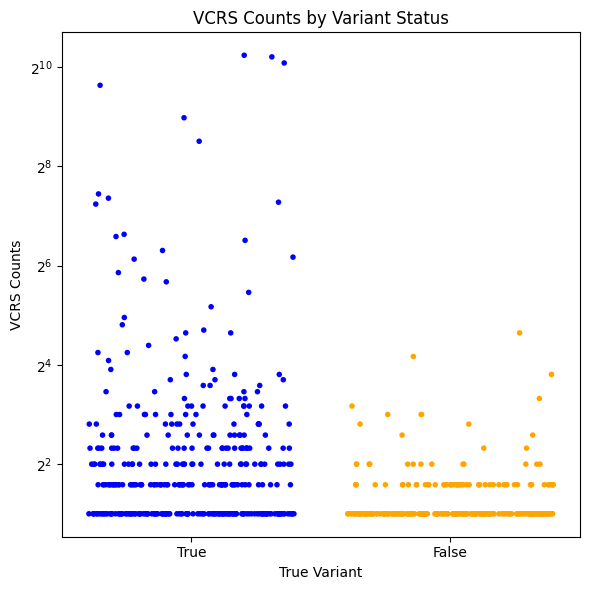

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('True Variant')
plt.ylabel('VCRS Counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('VCRS Counts by Variant Status')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENST00000604930', 'ENST00000608106', 'ENSG00000071082', 'ENST00000604591', 'ENST00000603423', 'ENSG00000142541', 'ENSG00000174444', 'ENSG00000065978', 'ENSG00000108107', 'ENSG00000143947'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

dbsnp_id    transcript_ID variant_cdna strand                header_cdna  \
0  rs28507236  ENST00000379407     c.528A>C      +   ENST00000379407:c.528A>C   
1  rs28548431  ENST00000379407    c.1566C>T      +  ENST00000379407:c.1566C>T   
2   rs9793256  ENST00000378785    c.1167G>A      +  ENST00000378785:c.1167G>A   
3   rs1781147  ENST00000378785    c.1409C>T      +  ENST00000378785:c.1409C>T   
4   rs7418389  ENST00000355826     c.253T>C      +   ENST00000355826:c.253T>C   

   is_false_negative vcrs_id  
0               True  vcrs_0  
1               True  vcrs_1  
2               True  vcrs_2  
3               True  vcrs_3  
4               True  vcrs_4

In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:50:06: Entering the loop



  0%|                                                                                                                                                                                 | 0/2949 [00:00<?, ?it/s]


  0%|                                                                                                                                                                         | 1/2949 [00:01<51:46,  1.05s/it]


  0%|                                                                                                                                                                         | 2/2949 [00:01<37:21,  1.31it/s]


  0%|▏                                                                                                                                                                        | 3/2949 [00:02<33:39,  1.46it/s]


  0%|▏                                                                                                                                                                        | 4/2949 [00:02<31:12,  1.57it/s]


  0%|▎                                                                                                                                                                        | 5/2949 [00:03<30:32,  1.61it/s]


  0%|▎                                                                                                                                                                        | 6/2949 [00:04<32:25,  1.51it/s]


  0%|▍                                                                                                                                                                        | 7/2949 [00:04<32:24,  1.51it/s]


  0%|▍                                                                                                                                                                        | 8/2949 [00:05<31:54,  1.54it/s]


  0%|▌                                                                                                                                                                        | 9/2949 [00:05<30:30,  1.61it/s]


  0%|▌                                                                                                                                                                       | 10/2949 [00:06<30:18,  1.62it/s]


  0%|▋                                                                                                                                                                       | 11/2949 [00:07<29:22,  1.67it/s]


  0%|▋                                                                                                                                                                       | 12/2949 [00:07<30:05,  1.63it/s]


  0%|▋                                                                                                                                                                       | 13/2949 [00:08<29:53,  1.64it/s]


  0%|▊                                                                                                                                                                       | 14/2949 [00:08<29:22,  1.67it/s]


  1%|▊                                                                                                                                                                       | 15/2949 [00:09<29:36,  1.65it/s]


  1%|▉                                                                                                                                                                       | 16/2949 [00:10<29:29,  1.66it/s]


  1%|▉                                                                                                                                                                       | 17/2949 [00:10<29:18,  1.67it/s]


  1%|█                                                                                                                                                                       | 18/2949 [00:11<28:56,  1.69it/s]


  1%|█                                                                                                                                                                       | 19/2949 [00:12<32:13,  1.52it/s]


  1%|█▏                                                                                                                                                                      | 20/2949 [00:12<30:46,  1.59it/s]


  1%|█▏                                                                                                                                                                      | 21/2949 [00:13<29:42,  1.64it/s]


  1%|█▎                                                                                                                                                                      | 22/2949 [00:13<29:28,  1.66it/s]


  1%|█▎                                                                                                                                                                      | 23/2949 [00:14<28:47,  1.69it/s]


  1%|█▎                                                                                                                                                                      | 24/2949 [00:14<28:20,  1.72it/s]


  1%|█▍                                                                                                                                                                      | 25/2949 [00:15<27:59,  1.74it/s]


  1%|█▍                                                                                                                                                                      | 26/2949 [00:16<28:47,  1.69it/s]


  1%|█▌                                                                                                                                                                      | 27/2949 [00:16<29:08,  1.67it/s]


  1%|█▌                                                                                                                                                                      | 28/2949 [00:17<28:43,  1.70it/s]


  1%|█▋                                                                                                                                                                      | 29/2949 [00:17<28:55,  1.68it/s]


  1%|█▋                                                                                                                                                                      | 30/2949 [00:18<29:24,  1.65it/s]


  1%|█▊                                                                                                                                                                      | 31/2949 [00:19<28:42,  1.69it/s]


  1%|█▊                                                                                                                                                                      | 32/2949 [00:19<28:12,  1.72it/s]


  1%|█▉                                                                                                                                                                      | 33/2949 [00:20<28:20,  1.71it/s]


  1%|█▉                                                                                                                                                                      | 34/2949 [00:20<28:35,  1.70it/s]


  1%|█▉                                                                                                                                                                      | 35/2949 [00:21<28:37,  1.70it/s]


  1%|██                                                                                                                                                                      | 36/2949 [00:22<28:36,  1.70it/s]


  1%|██                                                                                                                                                                      | 37/2949 [00:22<28:10,  1.72it/s]


  1%|██▏                                                                                                                                                                     | 38/2949 [00:23<27:51,  1.74it/s]


  1%|██▏                                                                                                                                                                     | 39/2949 [00:23<27:56,  1.74it/s]


  1%|██▎                                                                                                                                                                     | 40/2949 [00:24<27:41,  1.75it/s]


  1%|██▎                                                                                                                                                                     | 41/2949 [00:24<27:31,  1.76it/s]


  1%|██▍                                                                                                                                                                     | 42/2949 [00:25<27:43,  1.75it/s]


  1%|██▍                                                                                                                                                                     | 43/2949 [00:26<28:20,  1.71it/s]


  1%|██▌                                                                                                                                                                     | 44/2949 [00:26<28:13,  1.72it/s]


  2%|██▌                                                                                                                                                                     | 45/2949 [00:27<29:57,  1.62it/s]


  2%|██▌                                                                                                                                                                     | 46/2949 [00:27<29:47,  1.62it/s]


  2%|██▋                                                                                                                                                                     | 47/2949 [00:28<29:31,  1.64it/s]


  2%|██▊                                                                                                                                                                     | 49/2949 [00:29<22:22,  2.16it/s]


  2%|██▊                                                                                                                                                                     | 50/2949 [00:29<24:03,  2.01it/s]


  2%|██▉                                                                                                                                                                     | 51/2949 [00:30<25:25,  1.90it/s]


  2%|██▉                                                                                                                                                                     | 52/2949 [00:30<26:16,  1.84it/s]


  2%|███                                                                                                                                                                     | 53/2949 [00:31<29:06,  1.66it/s]


  2%|███                                                                                                                                                                     | 54/2949 [00:32<28:59,  1.66it/s]


  2%|███▏                                                                                                                                                                    | 55/2949 [00:33<37:27,  1.29it/s]


  2%|███▏                                                                                                                                                                    | 57/2949 [00:34<26:50,  1.80it/s]


  2%|███▎                                                                                                                                                                    | 58/2949 [00:34<27:25,  1.76it/s]


  2%|███▎                                                                                                                                                                    | 59/2949 [00:35<27:26,  1.76it/s]


  2%|███▍                                                                                                                                                                    | 60/2949 [00:35<27:44,  1.74it/s]


  2%|███▍                                                                                                                                                                    | 61/2949 [00:36<27:57,  1.72it/s]


  2%|███▌                                                                                                                                                                    | 62/2949 [00:37<27:39,  1.74it/s]


  2%|███▌                                                                                                                                                                    | 63/2949 [00:37<27:45,  1.73it/s]


  2%|███▋                                                                                                                                                                    | 64/2949 [00:38<27:28,  1.75it/s]


  2%|███▋                                                                                                                                                                    | 65/2949 [00:38<28:14,  1.70it/s]


  2%|███▊                                                                                                                                                                    | 66/2949 [00:39<28:04,  1.71it/s]


  2%|███▊                                                                                                                                                                    | 67/2949 [00:39<28:01,  1.71it/s]


  2%|███▊                                                                                                                                                                    | 68/2949 [00:40<28:13,  1.70it/s]


  2%|███▉                                                                                                                                                                    | 69/2949 [00:41<27:49,  1.72it/s]


  2%|███▉                                                                                                                                                                    | 70/2949 [00:41<27:31,  1.74it/s]


  2%|████                                                                                                                                                                    | 71/2949 [00:42<34:03,  1.41it/s]


  2%|████                                                                                                                                                                    | 72/2949 [00:43<32:38,  1.47it/s]


  2%|████▏                                                                                                                                                                   | 73/2949 [00:43<30:58,  1.55it/s]


  3%|████▏                                                                                                                                                                   | 74/2949 [00:44<30:03,  1.59it/s]


  3%|████▎                                                                                                                                                                   | 75/2949 [00:45<29:29,  1.62it/s]


  3%|████▎                                                                                                                                                                   | 76/2949 [00:45<29:09,  1.64it/s]


  3%|████▍                                                                                                                                                                   | 77/2949 [00:46<28:34,  1.68it/s]


  3%|████▍                                                                                                                                                                   | 78/2949 [00:46<28:11,  1.70it/s]


  3%|████▌                                                                                                                                                                   | 79/2949 [00:47<28:49,  1.66it/s]


  3%|████▌                                                                                                                                                                   | 81/2949 [00:47<21:52,  2.19it/s]


  3%|████▋                                                                                                                                                                   | 82/2949 [00:48<23:55,  2.00it/s]


  3%|████▋                                                                                                                                                                   | 83/2949 [00:49<25:18,  1.89it/s]


  3%|████▊                                                                                                                                                                   | 84/2949 [00:49<26:04,  1.83it/s]


  3%|████▊                                                                                                                                                                   | 85/2949 [00:50<26:29,  1.80it/s]


  3%|████▉                                                                                                                                                                   | 86/2949 [00:50<27:05,  1.76it/s]


  3%|████▉                                                                                                                                                                   | 87/2949 [00:51<27:41,  1.72it/s]


  3%|█████                                                                                                                                                                   | 88/2949 [00:52<27:24,  1.74it/s]


  3%|█████                                                                                                                                                                   | 89/2949 [00:52<27:16,  1.75it/s]


  3%|█████▏                                                                                                                                                                  | 90/2949 [00:53<27:13,  1.75it/s]


  3%|█████▏                                                                                                                                                                  | 91/2949 [00:53<27:17,  1.75it/s]


  3%|█████▏                                                                                                                                                                  | 92/2949 [00:54<27:49,  1.71it/s]


  3%|█████▎                                                                                                                                                                  | 93/2949 [00:55<28:01,  1.70it/s]


  3%|█████▎                                                                                                                                                                  | 94/2949 [00:55<28:18,  1.68it/s]


  3%|█████▍                                                                                                                                                                  | 95/2949 [00:56<28:35,  1.66it/s]


  3%|█████▍                                                                                                                                                                  | 96/2949 [00:56<28:22,  1.68it/s]


  3%|█████▌                                                                                                                                                                  | 97/2949 [00:57<27:51,  1.71it/s]


  3%|█████▌                                                                                                                                                                  | 98/2949 [00:58<27:40,  1.72it/s]


  3%|█████▋                                                                                                                                                                  | 99/2949 [00:58<28:28,  1.67it/s]


  3%|█████▋                                                                                                                                                                 | 100/2949 [00:59<27:58,  1.70it/s]


  3%|█████▋                                                                                                                                                                 | 101/2949 [00:59<27:29,  1.73it/s]


  3%|█████▊                                                                                                                                                                 | 102/2949 [01:00<27:54,  1.70it/s]


  3%|█████▊                                                                                                                                                                 | 103/2949 [01:01<28:08,  1.69it/s]


  4%|█████▉                                                                                                                                                                 | 104/2949 [01:01<27:56,  1.70it/s]


  4%|█████▉                                                                                                                                                                 | 105/2949 [01:02<27:41,  1.71it/s]


  4%|██████                                                                                                                                                                 | 106/2949 [01:02<27:39,  1.71it/s]


  4%|██████                                                                                                                                                                 | 107/2949 [01:03<29:54,  1.58it/s]


  4%|██████▏                                                                                                                                                                | 109/2949 [01:04<23:26,  2.02it/s]


  4%|██████▏                                                                                                                                                                | 110/2949 [01:04<24:15,  1.95it/s]


  4%|██████▎                                                                                                                                                                | 111/2949 [01:05<25:43,  1.84it/s]


  4%|██████▎                                                                                                                                                                | 112/2949 [01:05<25:55,  1.82it/s]


  4%|██████▍                                                                                                                                                                | 113/2949 [01:06<26:07,  1.81it/s]


  4%|██████▍                                                                                                                                                                | 114/2949 [01:07<26:18,  1.80it/s]


  4%|██████▌                                                                                                                                                                | 115/2949 [01:07<27:16,  1.73it/s]


  4%|██████▌                                                                                                                                                                | 116/2949 [01:08<28:04,  1.68it/s]


  4%|██████▋                                                                                                                                                                | 118/2949 [01:09<29:08,  1.62it/s]


  4%|██████▋                                                                                                                                                                | 119/2949 [01:11<38:31,  1.22it/s]


  4%|██████▊                                                                                                                                                                | 120/2949 [01:12<43:57,  1.07it/s]


  4%|██████▊                                                                                                                                                                | 121/2949 [01:13<48:20,  1.03s/it]


  4%|██████▉                                                                                                                                                                | 122/2949 [01:14<50:37,  1.07s/it]


  4%|██████▉                                                                                                                                                                | 123/2949 [01:15<51:53,  1.10s/it]


  4%|███████                                                                                                                                                                | 124/2949 [01:17<52:54,  1.12s/it]


  4%|███████                                                                                                                                                                | 125/2949 [01:18<53:43,  1.14s/it]


  4%|███████▏                                                                                                                                                               | 126/2949 [01:19<54:48,  1.16s/it]


  4%|███████▏                                                                                                                                                               | 127/2949 [01:20<47:19,  1.01s/it]


  4%|███████▏                                                                                                                                                               | 128/2949 [01:20<41:17,  1.14it/s]


  4%|███████▎                                                                                                                                                               | 130/2949 [01:21<28:58,  1.62it/s]


  4%|███████▍                                                                                                                                                               | 131/2949 [01:21<28:27,  1.65it/s]


  4%|███████▍                                                                                                                                                               | 132/2949 [01:22<31:10,  1.51it/s]


  5%|███████▌                                                                                                                                                               | 133/2949 [01:23<29:50,  1.57it/s]


  5%|███████▌                                                                                                                                                               | 134/2949 [01:24<31:40,  1.48it/s]


  5%|███████▋                                                                                                                                                               | 135/2949 [01:24<30:08,  1.56it/s]


  5%|███████▋                                                                                                                                                               | 136/2949 [01:25<28:58,  1.62it/s]


  5%|███████▊                                                                                                                                                               | 137/2949 [01:25<28:09,  1.66it/s]


  5%|███████▊                                                                                                                                                               | 138/2949 [01:26<27:45,  1.69it/s]


  5%|███████▊                                                                                                                                                               | 139/2949 [01:26<27:18,  1.72it/s]


  5%|███████▉                                                                                                                                                               | 140/2949 [01:27<26:56,  1.74it/s]


  5%|███████▉                                                                                                                                                               | 141/2949 [01:28<27:03,  1.73it/s]


  5%|████████                                                                                                                                                               | 142/2949 [01:28<27:13,  1.72it/s]


  5%|████████                                                                                                                                                               | 143/2949 [01:29<27:07,  1.72it/s]


  5%|████████▏                                                                                                                                                              | 144/2949 [01:29<26:48,  1.74it/s]


  5%|████████▏                                                                                                                                                              | 145/2949 [01:30<27:07,  1.72it/s]


  5%|████████▎                                                                                                                                                              | 146/2949 [01:31<28:55,  1.61it/s]


  5%|████████▎                                                                                                                                                              | 147/2949 [01:31<28:15,  1.65it/s]


  5%|████████▍                                                                                                                                                              | 148/2949 [01:32<27:50,  1.68it/s]


  5%|████████▍                                                                                                                                                              | 149/2949 [01:32<27:21,  1.71it/s]


  5%|████████▍                                                                                                                                                              | 150/2949 [01:33<26:59,  1.73it/s]


  5%|████████▌                                                                                                                                                              | 151/2949 [01:33<27:35,  1.69it/s]


  5%|████████▌                                                                                                                                                              | 152/2949 [01:34<27:44,  1.68it/s]


  5%|████████▋                                                                                                                                                              | 153/2949 [01:35<27:33,  1.69it/s]


  5%|████████▋                                                                                                                                                              | 154/2949 [01:35<27:15,  1.71it/s]


  5%|████████▊                                                                                                                                                              | 155/2949 [01:36<26:56,  1.73it/s]


  5%|████████▊                                                                                                                                                              | 156/2949 [01:36<27:18,  1.70it/s]


  5%|████████▉                                                                                                                                                              | 157/2949 [01:37<26:58,  1.73it/s]


  5%|████████▉                                                                                                                                                              | 158/2949 [01:38<26:41,  1.74it/s]


  5%|█████████                                                                                                                                                              | 159/2949 [01:38<26:30,  1.75it/s]


  5%|█████████                                                                                                                                                              | 160/2949 [01:39<26:23,  1.76it/s]


  5%|█████████▏                                                                                                                                                             | 162/2949 [01:39<20:10,  2.30it/s]


  6%|█████████▏                                                                                                                                                             | 163/2949 [01:40<21:40,  2.14it/s]


  6%|█████████▎                                                                                                                                                             | 164/2949 [01:40<22:54,  2.03it/s]


  6%|█████████▎                                                                                                                                                             | 165/2949 [01:41<23:54,  1.94it/s]


  6%|█████████▍                                                                                                                                                             | 166/2949 [01:41<24:48,  1.87it/s]


  6%|█████████▍                                                                                                                                                             | 167/2949 [01:42<25:11,  1.84it/s]


  6%|█████████▌                                                                                                                                                             | 168/2949 [01:43<25:23,  1.83it/s]


  6%|█████████▌                                                                                                                                                             | 169/2949 [01:43<25:33,  1.81it/s]


  6%|█████████▋                                                                                                                                                             | 170/2949 [01:44<25:42,  1.80it/s]


  6%|█████████▋                                                                                                                                                             | 171/2949 [01:44<25:44,  1.80it/s]


  6%|█████████▋                                                                                                                                                             | 172/2949 [01:45<25:49,  1.79it/s]


  6%|█████████▊                                                                                                                                                             | 173/2949 [01:45<25:49,  1.79it/s]


  6%|█████████▊                                                                                                                                                             | 174/2949 [01:46<26:19,  1.76it/s]


  6%|█████████▉                                                                                                                                                             | 175/2949 [01:47<26:11,  1.77it/s]


  6%|█████████▉                                                                                                                                                             | 176/2949 [01:47<26:28,  1.75it/s]


  6%|██████████                                                                                                                                                             | 177/2949 [01:48<26:40,  1.73it/s]


  6%|██████████                                                                                                                                                             | 178/2949 [01:48<26:55,  1.72it/s]


  6%|██████████▏                                                                                                                                                            | 180/2949 [01:49<20:50,  2.21it/s]


  6%|██████████▏                                                                                                                                                            | 181/2949 [01:50<22:56,  2.01it/s]


  6%|██████████▎                                                                                                                                                            | 182/2949 [01:50<24:03,  1.92it/s]


  6%|██████████▍                                                                                                                                                            | 184/2949 [01:51<19:40,  2.34it/s]


  6%|██████████▍                                                                                                                                                            | 185/2949 [01:51<21:05,  2.18it/s]


  6%|██████████▌                                                                                                                                                            | 186/2949 [01:52<23:52,  1.93it/s]


  6%|██████████▌                                                                                                                                                            | 187/2949 [01:53<24:47,  1.86it/s]


  6%|██████████▋                                                                                                                                                            | 188/2949 [01:53<26:13,  1.75it/s]


  6%|██████████▋                                                                                                                                                            | 189/2949 [01:54<26:04,  1.76it/s]


  6%|██████████▊                                                                                                                                                            | 190/2949 [01:54<25:58,  1.77it/s]


  6%|██████████▊                                                                                                                                                            | 191/2949 [01:55<25:52,  1.78it/s]


  7%|██████████▊                                                                                                                                                            | 192/2949 [01:56<25:49,  1.78it/s]


  7%|██████████▉                                                                                                                                                            | 193/2949 [01:56<26:13,  1.75it/s]


  7%|██████████▉                                                                                                                                                            | 194/2949 [01:57<26:52,  1.71it/s]


  7%|███████████                                                                                                                                                            | 195/2949 [01:57<26:29,  1.73it/s]


  7%|███████████                                                                                                                                                            | 196/2949 [01:58<27:23,  1.68it/s]


  7%|███████████▏                                                                                                                                                           | 197/2949 [01:58<27:01,  1.70it/s]


  7%|███████████▏                                                                                                                                                           | 198/2949 [01:59<27:23,  1.67it/s]


  7%|███████████▎                                                                                                                                                           | 199/2949 [02:00<26:52,  1.71it/s]


  7%|███████████▎                                                                                                                                                           | 200/2949 [02:00<26:43,  1.71it/s]


  7%|███████████▍                                                                                                                                                           | 201/2949 [02:01<26:56,  1.70it/s]


  7%|███████████▍                                                                                                                                                           | 202/2949 [02:01<27:27,  1.67it/s]


  7%|███████████▍                                                                                                                                                           | 203/2949 [02:02<27:15,  1.68it/s]


  7%|███████████▌                                                                                                                                                           | 204/2949 [02:03<26:52,  1.70it/s]


  7%|███████████▌                                                                                                                                                           | 205/2949 [02:03<26:36,  1.72it/s]


  7%|███████████▋                                                                                                                                                           | 206/2949 [02:04<26:44,  1.71it/s]


  7%|███████████▋                                                                                                                                                           | 207/2949 [02:04<26:41,  1.71it/s]


  7%|███████████▊                                                                                                                                                           | 208/2949 [02:05<28:52,  1.58it/s]


  7%|███████████▊                                                                                                                                                           | 209/2949 [02:06<27:52,  1.64it/s]


  7%|███████████▉                                                                                                                                                           | 210/2949 [02:06<27:29,  1.66it/s]


  7%|███████████▉                                                                                                                                                           | 211/2949 [02:07<28:03,  1.63it/s]


  7%|████████████                                                                                                                                                           | 212/2949 [02:08<28:14,  1.61it/s]


  7%|████████████                                                                                                                                                           | 213/2949 [02:08<27:24,  1.66it/s]


  7%|████████████                                                                                                                                                           | 214/2949 [02:09<26:58,  1.69it/s]


  7%|████████████▏                                                                                                                                                          | 215/2949 [02:09<26:32,  1.72it/s]


  7%|████████████▏                                                                                                                                                          | 216/2949 [02:10<26:11,  1.74it/s]


  7%|████████████▎                                                                                                                                                          | 217/2949 [02:10<26:00,  1.75it/s]


  7%|████████████▎                                                                                                                                                          | 218/2949 [02:11<25:49,  1.76it/s]


  7%|████████████▍                                                                                                                                                          | 219/2949 [02:11<25:43,  1.77it/s]


  7%|████████████▍                                                                                                                                                          | 220/2949 [02:12<26:27,  1.72it/s]


  7%|████████████▌                                                                                                                                                          | 221/2949 [02:13<26:37,  1.71it/s]


  8%|████████████▌                                                                                                                                                          | 222/2949 [02:13<26:33,  1.71it/s]


  8%|████████████▋                                                                                                                                                          | 223/2949 [02:14<27:03,  1.68it/s]


  8%|████████████▋                                                                                                                                                          | 224/2949 [02:14<26:33,  1.71it/s]


  8%|████████████▋                                                                                                                                                          | 225/2949 [02:15<26:19,  1.72it/s]


  8%|████████████▊                                                                                                                                                          | 226/2949 [02:16<26:12,  1.73it/s]


  8%|████████████▊                                                                                                                                                          | 227/2949 [02:16<25:58,  1.75it/s]


  8%|████████████▉                                                                                                                                                          | 228/2949 [02:17<25:56,  1.75it/s]


  8%|████████████▉                                                                                                                                                          | 229/2949 [02:18<34:15,  1.32it/s]


  8%|█████████████                                                                                                                                                          | 230/2949 [02:18<31:54,  1.42it/s]


  8%|█████████████                                                                                                                                                          | 231/2949 [02:19<30:10,  1.50it/s]


  8%|█████████████▏                                                                                                                                                         | 232/2949 [02:20<33:51,  1.34it/s]


  8%|█████████████▏                                                                                                                                                         | 233/2949 [02:21<32:10,  1.41it/s]


  8%|█████████████▎                                                                                                                                                         | 234/2949 [02:21<30:17,  1.49it/s]


  8%|█████████████▎                                                                                                                                                         | 235/2949 [02:22<29:04,  1.56it/s]


  8%|█████████████▎                                                                                                                                                         | 236/2949 [02:22<28:07,  1.61it/s]


  8%|█████████████▍                                                                                                                                                         | 237/2949 [02:23<30:20,  1.49it/s]


  8%|█████████████▌                                                                                                                                                         | 239/2949 [02:24<22:32,  2.00it/s]


  8%|█████████████▌                                                                                                                                                         | 240/2949 [02:24<23:15,  1.94it/s]


  8%|█████████████▋                                                                                                                                                         | 241/2949 [02:25<23:54,  1.89it/s]


  8%|█████████████▋                                                                                                                                                         | 242/2949 [02:25<24:26,  1.85it/s]


  8%|█████████████▊                                                                                                                                                         | 243/2949 [02:26<24:58,  1.81it/s]


  8%|█████████████▊                                                                                                                                                         | 244/2949 [02:27<25:25,  1.77it/s]


  8%|█████████████▊                                                                                                                                                         | 245/2949 [02:27<26:25,  1.71it/s]


  8%|█████████████▉                                                                                                                                                         | 246/2949 [02:28<26:15,  1.72it/s]


  8%|██████████████                                                                                                                                                         | 248/2949 [02:28<20:09,  2.23it/s]


  8%|██████████████                                                                                                                                                         | 249/2949 [02:29<21:55,  2.05it/s]


  8%|██████████████▏                                                                                                                                                        | 250/2949 [02:30<23:02,  1.95it/s]


  9%|██████████████▏                                                                                                                                                        | 251/2949 [02:30<23:35,  1.91it/s]


  9%|██████████████▎                                                                                                                                                        | 252/2949 [02:31<24:11,  1.86it/s]


  9%|██████████████▎                                                                                                                                                        | 253/2949 [02:31<24:49,  1.81it/s]


  9%|██████████████▍                                                                                                                                                        | 254/2949 [02:32<25:42,  1.75it/s]


  9%|██████████████▍                                                                                                                                                        | 255/2949 [02:33<25:52,  1.74it/s]


  9%|██████████████▍                                                                                                                                                        | 256/2949 [02:33<26:01,  1.72it/s]


  9%|██████████████▌                                                                                                                                                        | 257/2949 [02:34<25:44,  1.74it/s]


  9%|██████████████▌                                                                                                                                                        | 258/2949 [02:34<26:03,  1.72it/s]


  9%|██████████████▋                                                                                                                                                        | 259/2949 [02:35<26:01,  1.72it/s]


  9%|██████████████▊                                                                                                                                                        | 261/2949 [02:35<20:08,  2.22it/s]


  9%|██████████████▊                                                                                                                                                        | 262/2949 [02:36<21:48,  2.05it/s]


  9%|██████████████▉                                                                                                                                                        | 263/2949 [02:37<23:08,  1.93it/s]


  9%|██████████████▉                                                                                                                                                        | 264/2949 [02:37<23:54,  1.87it/s]


  9%|███████████████                                                                                                                                                        | 266/2949 [02:38<20:41,  2.16it/s]


  9%|███████████████                                                                                                                                                        | 267/2949 [02:39<22:02,  2.03it/s]


  9%|███████████████▏                                                                                                                                                       | 268/2949 [02:39<23:50,  1.87it/s]


  9%|███████████████▏                                                                                                                                                       | 269/2949 [02:40<24:10,  1.85it/s]


  9%|███████████████▎                                                                                                                                                       | 270/2949 [02:40<24:25,  1.83it/s]


  9%|███████████████▎                                                                                                                                                       | 271/2949 [02:41<24:34,  1.82it/s]


  9%|███████████████▍                                                                                                                                                       | 272/2949 [02:41<24:41,  1.81it/s]


  9%|███████████████▍                                                                                                                                                       | 273/2949 [02:42<24:47,  1.80it/s]


  9%|███████████████▌                                                                                                                                                       | 274/2949 [02:43<24:51,  1.79it/s]


  9%|███████████████▌                                                                                                                                                       | 275/2949 [02:43<24:52,  1.79it/s]


  9%|███████████████▋                                                                                                                                                       | 276/2949 [02:44<24:52,  1.79it/s]


  9%|███████████████▋                                                                                                                                                       | 277/2949 [02:44<24:56,  1.79it/s]


  9%|███████████████▊                                                                                                                                                       | 279/2949 [02:45<19:29,  2.28it/s]


  9%|███████████████▊                                                                                                                                                       | 280/2949 [02:45<20:49,  2.14it/s]


 10%|███████████████▉                                                                                                                                                       | 282/2949 [02:46<19:09,  2.32it/s]


 10%|████████████████                                                                                                                                                       | 283/2949 [02:47<22:18,  1.99it/s]


 10%|████████████████                                                                                                                                                       | 284/2949 [02:47<22:55,  1.94it/s]


 10%|████████████████▏                                                                                                                                                      | 285/2949 [02:48<25:14,  1.76it/s]


 10%|████████████████▏                                                                                                                                                      | 286/2949 [02:49<27:27,  1.62it/s]


 10%|████████████████▎                                                                                                                                                      | 287/2949 [02:50<28:40,  1.55it/s]


 10%|████████████████▎                                                                                                                                                      | 288/2949 [02:50<29:49,  1.49it/s]


 10%|████████████████▎                                                                                                                                                      | 289/2949 [02:51<29:23,  1.51it/s]


 10%|████████████████▌                                                                                                                                                      | 292/2949 [02:52<17:41,  2.50it/s]


 10%|████████████████▌                                                                                                                                                      | 293/2949 [02:52<19:17,  2.29it/s]


 10%|████████████████▋                                                                                                                                                      | 294/2949 [02:53<20:35,  2.15it/s]


 10%|████████████████▋                                                                                                                                                      | 295/2949 [02:53<22:03,  2.00it/s]


 10%|████████████████▊                                                                                                                                                      | 296/2949 [02:54<23:04,  1.92it/s]


 10%|████████████████▊                                                                                                                                                      | 297/2949 [02:55<24:04,  1.84it/s]


 10%|████████████████▉                                                                                                                                                      | 298/2949 [02:55<24:32,  1.80it/s]


 10%|████████████████▉                                                                                                                                                      | 299/2949 [02:56<25:02,  1.76it/s]


 10%|████████████████▉                                                                                                                                                      | 300/2949 [02:56<25:23,  1.74it/s]


 10%|█████████████████                                                                                                                                                      | 301/2949 [02:57<25:11,  1.75it/s]


 10%|█████████████████                                                                                                                                                      | 302/2949 [02:57<25:20,  1.74it/s]


 10%|█████████████████▏                                                                                                                                                     | 303/2949 [02:58<25:50,  1.71it/s]


 10%|█████████████████▏                                                                                                                                                     | 304/2949 [02:59<25:55,  1.70it/s]


 10%|█████████████████▎                                                                                                                                                     | 305/2949 [02:59<27:17,  1.61it/s]


 10%|█████████████████▎                                                                                                                                                     | 306/2949 [03:00<26:47,  1.64it/s]


 10%|█████████████████▍                                                                                                                                                     | 308/2949 [03:00<20:08,  2.19it/s]


 10%|█████████████████▍                                                                                                                                                     | 309/2949 [03:01<21:49,  2.02it/s]


 11%|█████████████████▌                                                                                                                                                     | 310/2949 [03:02<23:07,  1.90it/s]


 11%|█████████████████▌                                                                                                                                                     | 311/2949 [03:02<23:46,  1.85it/s]


 11%|█████████████████▋                                                                                                                                                     | 312/2949 [03:03<24:08,  1.82it/s]


 11%|█████████████████▋                                                                                                                                                     | 313/2949 [03:03<24:15,  1.81it/s]


 11%|█████████████████▊                                                                                                                                                     | 314/2949 [03:04<24:37,  1.78it/s]


 11%|█████████████████▊                                                                                                                                                     | 315/2949 [03:05<25:11,  1.74it/s]


 11%|█████████████████▉                                                                                                                                                     | 316/2949 [03:05<25:23,  1.73it/s]


 11%|█████████████████▉                                                                                                                                                     | 317/2949 [03:06<25:29,  1.72it/s]


 11%|██████████████████                                                                                                                                                     | 318/2949 [03:06<25:33,  1.72it/s]


 11%|██████████████████                                                                                                                                                     | 319/2949 [03:07<25:16,  1.73it/s]


 11%|██████████████████                                                                                                                                                     | 320/2949 [03:08<25:13,  1.74it/s]


 11%|██████████████████▏                                                                                                                                                    | 321/2949 [03:08<25:10,  1.74it/s]


 11%|██████████████████▏                                                                                                                                                    | 322/2949 [03:09<24:59,  1.75it/s]


 11%|██████████████████▎                                                                                                                                                    | 323/2949 [03:09<25:08,  1.74it/s]


 11%|██████████████████▎                                                                                                                                                    | 324/2949 [03:10<25:19,  1.73it/s]


 11%|██████████████████▍                                                                                                                                                    | 325/2949 [03:10<25:32,  1.71it/s]


 11%|██████████████████▍                                                                                                                                                    | 326/2949 [03:11<25:51,  1.69it/s]


 11%|██████████████████▌                                                                                                                                                    | 327/2949 [03:12<25:36,  1.71it/s]


 11%|██████████████████▌                                                                                                                                                    | 328/2949 [03:12<25:15,  1.73it/s]


 11%|██████████████████▋                                                                                                                                                    | 329/2949 [03:13<25:19,  1.72it/s]


 11%|██████████████████▋                                                                                                                                                    | 330/2949 [03:13<25:42,  1.70it/s]


 11%|██████████████████▋                                                                                                                                                    | 331/2949 [03:14<25:24,  1.72it/s]


 11%|██████████████████▊                                                                                                                                                    | 332/2949 [03:15<33:30,  1.30it/s]


 11%|██████████████████▊                                                                                                                                                    | 333/2949 [03:16<39:22,  1.11it/s]


 11%|██████████████████▉                                                                                                                                                    | 334/2949 [03:17<42:37,  1.02it/s]


 11%|██████████████████▉                                                                                                                                                    | 335/2949 [03:19<44:51,  1.03s/it]


 11%|███████████████████                                                                                                                                                    | 336/2949 [03:20<46:23,  1.07s/it]


 11%|███████████████████                                                                                                                                                    | 337/2949 [03:21<47:38,  1.09s/it]


 11%|███████████████████▏                                                                                                                                                   | 339/2949 [03:22<31:28,  1.38it/s]


 12%|███████████████████▎                                                                                                                                                   | 341/2949 [03:22<24:02,  1.81it/s]


 12%|███████████████████▎                                                                                                                                                   | 342/2949 [03:23<24:11,  1.80it/s]


 12%|███████████████████▍                                                                                                                                                   | 343/2949 [03:23<24:34,  1.77it/s]


 12%|███████████████████▍                                                                                                                                                   | 344/2949 [03:24<24:50,  1.75it/s]


 12%|███████████████████▌                                                                                                                                                   | 345/2949 [03:24<24:45,  1.75it/s]


 12%|███████████████████▌                                                                                                                                                   | 346/2949 [03:25<24:39,  1.76it/s]


 12%|███████████████████▋                                                                                                                                                   | 347/2949 [03:26<24:48,  1.75it/s]


 12%|███████████████████▋                                                                                                                                                   | 348/2949 [03:26<25:12,  1.72it/s]


 12%|███████████████████▊                                                                                                                                                   | 349/2949 [03:27<25:19,  1.71it/s]


 12%|███████████████████▊                                                                                                                                                   | 350/2949 [03:27<25:20,  1.71it/s]


 12%|███████████████████▉                                                                                                                                                   | 351/2949 [03:28<25:09,  1.72it/s]


 12%|███████████████████▉                                                                                                                                                   | 352/2949 [03:28<24:52,  1.74it/s]


 12%|███████████████████▉                                                                                                                                                   | 353/2949 [03:29<24:49,  1.74it/s]


 12%|████████████████████                                                                                                                                                   | 354/2949 [03:30<25:02,  1.73it/s]


 12%|████████████████████                                                                                                                                                   | 355/2949 [03:30<24:45,  1.75it/s]


 12%|████████████████████▏                                                                                                                                                  | 356/2949 [03:31<24:38,  1.75it/s]


 12%|████████████████████▏                                                                                                                                                  | 357/2949 [03:31<24:55,  1.73it/s]


 12%|████████████████████▎                                                                                                                                                  | 358/2949 [03:32<24:40,  1.75it/s]


 12%|████████████████████▎                                                                                                                                                  | 359/2949 [03:33<24:42,  1.75it/s]


 12%|████████████████████▍                                                                                                                                                  | 360/2949 [03:33<24:56,  1.73it/s]


 12%|████████████████████▍                                                                                                                                                  | 361/2949 [03:34<24:48,  1.74it/s]


 12%|████████████████████▍                                                                                                                                                  | 362/2949 [03:34<25:01,  1.72it/s]


 12%|████████████████████▌                                                                                                                                                  | 363/2949 [03:35<25:00,  1.72it/s]


 12%|████████████████████▌                                                                                                                                                  | 364/2949 [03:35<24:43,  1.74it/s]


 12%|████████████████████▋                                                                                                                                                  | 365/2949 [03:36<25:02,  1.72it/s]


 12%|████████████████████▋                                                                                                                                                  | 366/2949 [03:37<25:02,  1.72it/s]


 12%|████████████████████▊                                                                                                                                                  | 367/2949 [03:37<25:17,  1.70it/s]


 12%|████████████████████▊                                                                                                                                                  | 368/2949 [03:38<27:46,  1.55it/s]


 13%|████████████████████▉                                                                                                                                                  | 369/2949 [03:39<26:56,  1.60it/s]


 13%|████████████████████▉                                                                                                                                                  | 370/2949 [03:39<26:42,  1.61it/s]


 13%|█████████████████████                                                                                                                                                  | 371/2949 [03:40<26:14,  1.64it/s]


 13%|█████████████████████                                                                                                                                                  | 372/2949 [03:40<25:43,  1.67it/s]


 13%|█████████████████████                                                                                                                                                  | 373/2949 [03:41<25:14,  1.70it/s]


 13%|█████████████████████▏                                                                                                                                                 | 374/2949 [03:41<25:02,  1.71it/s]


 13%|█████████████████████▏                                                                                                                                                 | 375/2949 [03:42<25:24,  1.69it/s]


 13%|█████████████████████▎                                                                                                                                                 | 376/2949 [03:43<24:58,  1.72it/s]


 13%|█████████████████████▎                                                                                                                                                 | 377/2949 [03:43<25:07,  1.71it/s]


 13%|█████████████████████▍                                                                                                                                                 | 378/2949 [03:44<24:46,  1.73it/s]


 13%|█████████████████████▌                                                                                                                                                 | 380/2949 [03:44<19:13,  2.23it/s]


 13%|█████████████████████▌                                                                                                                                                 | 381/2949 [03:45<20:48,  2.06it/s]


 13%|█████████████████████▋                                                                                                                                                 | 382/2949 [03:46<21:59,  1.95it/s]


 13%|█████████████████████▋                                                                                                                                                 | 383/2949 [03:46<23:02,  1.86it/s]


 13%|█████████████████████▋                                                                                                                                                 | 384/2949 [03:47<30:41,  1.39it/s]


 13%|█████████████████████▊                                                                                                                                                 | 385/2949 [03:48<29:03,  1.47it/s]


 13%|█████████████████████▊                                                                                                                                                 | 386/2949 [03:49<27:54,  1.53it/s]


 13%|█████████████████████▉                                                                                                                                                 | 387/2949 [03:49<27:06,  1.58it/s]


 13%|█████████████████████▉                                                                                                                                                 | 388/2949 [03:50<26:41,  1.60it/s]


 13%|██████████████████████                                                                                                                                                 | 389/2949 [03:50<26:51,  1.59it/s]


 13%|██████████████████████                                                                                                                                                 | 390/2949 [03:51<26:17,  1.62it/s]


 13%|██████████████████████▏                                                                                                                                                | 391/2949 [03:51<25:31,  1.67it/s]


 13%|██████████████████████▏                                                                                                                                                | 392/2949 [03:52<25:00,  1.70it/s]


 13%|██████████████████████▎                                                                                                                                                | 393/2949 [03:53<25:08,  1.69it/s]


 13%|██████████████████████▎                                                                                                                                                | 394/2949 [03:53<25:06,  1.70it/s]


 13%|██████████████████████▎                                                                                                                                                | 395/2949 [03:54<25:11,  1.69it/s]


 13%|██████████████████████▍                                                                                                                                                | 396/2949 [03:54<24:49,  1.71it/s]


 13%|██████████████████████▍                                                                                                                                                | 397/2949 [03:55<24:55,  1.71it/s]


 13%|██████████████████████▌                                                                                                                                                | 398/2949 [03:56<25:15,  1.68it/s]


 14%|██████████████████████▌                                                                                                                                                | 399/2949 [03:56<24:48,  1.71it/s]


 14%|██████████████████████▋                                                                                                                                                | 400/2949 [03:57<24:30,  1.73it/s]


 14%|██████████████████████▋                                                                                                                                                | 401/2949 [03:57<24:32,  1.73it/s]


 14%|██████████████████████▊                                                                                                                                                | 402/2949 [03:58<25:04,  1.69it/s]


 14%|██████████████████████▊                                                                                                                                                | 403/2949 [03:58<24:40,  1.72it/s]


 14%|██████████████████████▉                                                                                                                                                | 404/2949 [03:59<24:44,  1.71it/s]


 14%|██████████████████████▉                                                                                                                                                | 405/2949 [04:00<25:28,  1.66it/s]


 14%|██████████████████████▉                                                                                                                                                | 406/2949 [04:00<25:14,  1.68it/s]


 14%|███████████████████████                                                                                                                                                | 407/2949 [04:01<25:12,  1.68it/s]


 14%|███████████████████████                                                                                                                                                | 408/2949 [04:01<25:00,  1.69it/s]


 14%|███████████████████████▏                                                                                                                                               | 409/2949 [04:02<24:35,  1.72it/s]


 14%|███████████████████████▏                                                                                                                                               | 410/2949 [04:03<24:19,  1.74it/s]


 14%|███████████████████████▎                                                                                                                                               | 411/2949 [04:03<24:18,  1.74it/s]


 14%|███████████████████████▍                                                                                                                                               | 413/2949 [04:04<19:02,  2.22it/s]


 14%|███████████████████████▍                                                                                                                                               | 414/2949 [04:04<20:11,  2.09it/s]


 14%|███████████████████████▌                                                                                                                                               | 415/2949 [04:05<21:24,  1.97it/s]


 14%|███████████████████████▌                                                                                                                                               | 416/2949 [04:05<22:03,  1.91it/s]


 14%|███████████████████████▌                                                                                                                                               | 417/2949 [04:06<23:04,  1.83it/s]


 14%|███████████████████████▋                                                                                                                                               | 418/2949 [04:07<23:53,  1.77it/s]


 14%|███████████████████████▋                                                                                                                                               | 419/2949 [04:07<24:05,  1.75it/s]


 14%|███████████████████████▊                                                                                                                                               | 420/2949 [04:08<24:08,  1.75it/s]


 14%|███████████████████████▊                                                                                                                                               | 421/2949 [04:08<24:29,  1.72it/s]


 14%|███████████████████████▉                                                                                                                                               | 422/2949 [04:09<24:41,  1.71it/s]


 14%|███████████████████████▉                                                                                                                                               | 423/2949 [04:10<25:04,  1.68it/s]


 14%|████████████████████████                                                                                                                                               | 424/2949 [04:10<24:49,  1.70it/s]


 14%|████████████████████████                                                                                                                                               | 425/2949 [04:11<24:35,  1.71it/s]


 14%|████████████████████████                                                                                                                                               | 426/2949 [04:11<24:28,  1.72it/s]


 14%|████████████████████████▏                                                                                                                                              | 427/2949 [04:12<24:16,  1.73it/s]


 15%|████████████████████████▏                                                                                                                                              | 428/2949 [04:13<24:06,  1.74it/s]


 15%|████████████████████████▎                                                                                                                                              | 429/2949 [04:13<24:04,  1.74it/s]


 15%|████████████████████████▎                                                                                                                                              | 430/2949 [04:14<24:11,  1.74it/s]


 15%|████████████████████████▍                                                                                                                                              | 431/2949 [04:14<24:06,  1.74it/s]


 15%|████████████████████████▍                                                                                                                                              | 432/2949 [04:15<24:29,  1.71it/s]


 15%|████████████████████████▌                                                                                                                                              | 433/2949 [04:15<24:20,  1.72it/s]


 15%|████████████████████████▌                                                                                                                                              | 434/2949 [04:16<24:08,  1.74it/s]


 15%|████████████████████████▋                                                                                                                                              | 435/2949 [04:17<23:56,  1.75it/s]


 15%|████████████████████████▋                                                                                                                                              | 436/2949 [04:17<23:52,  1.75it/s]


 15%|████████████████████████▋                                                                                                                                              | 437/2949 [04:18<23:47,  1.76it/s]


 15%|████████████████████████▊                                                                                                                                              | 438/2949 [04:18<23:55,  1.75it/s]


 15%|████████████████████████▊                                                                                                                                              | 439/2949 [04:19<24:28,  1.71it/s]


 15%|████████████████████████▉                                                                                                                                              | 440/2949 [04:19<24:34,  1.70it/s]


 15%|████████████████████████▉                                                                                                                                              | 441/2949 [04:20<24:17,  1.72it/s]


 15%|█████████████████████████                                                                                                                                              | 442/2949 [04:21<24:12,  1.73it/s]


 15%|█████████████████████████                                                                                                                                              | 443/2949 [04:21<23:58,  1.74it/s]


 15%|█████████████████████████▏                                                                                                                                             | 444/2949 [04:22<24:13,  1.72it/s]


 15%|█████████████████████████▏                                                                                                                                             | 445/2949 [04:22<23:59,  1.74it/s]


 15%|█████████████████████████▎                                                                                                                                             | 446/2949 [04:23<23:47,  1.75it/s]


 15%|█████████████████████████▎                                                                                                                                             | 447/2949 [04:24<23:58,  1.74it/s]


 15%|█████████████████████████▎                                                                                                                                             | 448/2949 [04:24<23:57,  1.74it/s]


 15%|█████████████████████████▍                                                                                                                                             | 449/2949 [04:25<23:58,  1.74it/s]


 15%|█████████████████████████▍                                                                                                                                             | 450/2949 [04:25<24:09,  1.72it/s]


 15%|█████████████████████████▌                                                                                                                                             | 451/2949 [04:26<24:05,  1.73it/s]


 15%|█████████████████████████▌                                                                                                                                             | 452/2949 [04:26<24:22,  1.71it/s]


 15%|█████████████████████████▋                                                                                                                                             | 453/2949 [04:27<24:10,  1.72it/s]


 15%|█████████████████████████▋                                                                                                                                             | 454/2949 [04:28<25:15,  1.65it/s]


 15%|█████████████████████████▊                                                                                                                                             | 455/2949 [04:28<25:07,  1.65it/s]


 15%|█████████████████████████▊                                                                                                                                             | 456/2949 [04:29<24:33,  1.69it/s]


 15%|█████████████████████████▉                                                                                                                                             | 457/2949 [04:29<24:42,  1.68it/s]


 16%|█████████████████████████▉                                                                                                                                             | 458/2949 [04:30<24:22,  1.70it/s]


 16%|█████████████████████████▉                                                                                                                                             | 459/2949 [04:31<25:11,  1.65it/s]


 16%|██████████████████████████                                                                                                                                             | 460/2949 [04:31<24:57,  1.66it/s]


 16%|██████████████████████████                                                                                                                                             | 461/2949 [04:32<25:07,  1.65it/s]


 16%|██████████████████████████▏                                                                                                                                            | 462/2949 [04:32<25:00,  1.66it/s]


 16%|██████████████████████████▏                                                                                                                                            | 463/2949 [04:33<24:48,  1.67it/s]


 16%|██████████████████████████▎                                                                                                                                            | 464/2949 [04:34<24:26,  1.69it/s]


 16%|██████████████████████████▎                                                                                                                                            | 465/2949 [04:34<24:01,  1.72it/s]


 16%|██████████████████████████▍                                                                                                                                            | 466/2949 [04:35<23:44,  1.74it/s]


 16%|██████████████████████████▍                                                                                                                                            | 467/2949 [04:35<24:02,  1.72it/s]


 16%|██████████████████████████▌                                                                                                                                            | 468/2949 [04:36<24:03,  1.72it/s]


 16%|██████████████████████████▌                                                                                                                                            | 469/2949 [04:36<24:05,  1.72it/s]


 16%|██████████████████████████▌                                                                                                                                            | 470/2949 [04:37<23:58,  1.72it/s]


 16%|██████████████████████████▋                                                                                                                                            | 471/2949 [04:38<26:57,  1.53it/s]


 16%|██████████████████████████▋                                                                                                                                            | 472/2949 [04:38<26:17,  1.57it/s]


 16%|██████████████████████████▊                                                                                                                                            | 473/2949 [04:39<25:44,  1.60it/s]


 16%|██████████████████████████▊                                                                                                                                            | 474/2949 [04:40<25:02,  1.65it/s]


 16%|██████████████████████████▉                                                                                                                                            | 475/2949 [04:40<24:47,  1.66it/s]


 16%|██████████████████████████▉                                                                                                                                            | 476/2949 [04:41<24:27,  1.68it/s]


 16%|███████████████████████████                                                                                                                                            | 477/2949 [04:41<24:54,  1.65it/s]


 16%|███████████████████████████                                                                                                                                            | 478/2949 [04:42<24:19,  1.69it/s]


 16%|███████████████████████████▏                                                                                                                                           | 479/2949 [04:43<24:33,  1.68it/s]


 16%|███████████████████████████▏                                                                                                                                           | 480/2949 [04:43<24:20,  1.69it/s]


 16%|███████████████████████████▏                                                                                                                                           | 481/2949 [04:44<24:06,  1.71it/s]


 16%|███████████████████████████▎                                                                                                                                           | 482/2949 [04:44<24:15,  1.69it/s]


 16%|███████████████████████████▎                                                                                                                                           | 483/2949 [04:46<31:35,  1.30it/s]


 16%|███████████████████████████▍                                                                                                                                           | 484/2949 [04:47<36:15,  1.13it/s]


 16%|███████████████████████████▍                                                                                                                                           | 485/2949 [04:48<39:29,  1.04it/s]


 16%|███████████████████████████▌                                                                                                                                           | 486/2949 [04:49<41:56,  1.02s/it]


 17%|███████████████████████████▌                                                                                                                                           | 487/2949 [04:50<43:40,  1.06s/it]


 17%|███████████████████████████▋                                                                                                                                           | 488/2949 [04:51<44:56,  1.10s/it]


 17%|███████████████████████████▋                                                                                                                                           | 489/2949 [04:53<45:52,  1.12s/it]


 17%|███████████████████████████▋                                                                                                                                           | 490/2949 [04:54<46:27,  1.13s/it]


 17%|███████████████████████████▊                                                                                                                                           | 491/2949 [04:55<46:33,  1.14s/it]


 17%|███████████████████████████▊                                                                                                                                           | 492/2949 [04:56<46:42,  1.14s/it]


 17%|███████████████████████████▉                                                                                                                                           | 493/2949 [04:57<46:46,  1.14s/it]


 17%|███████████████████████████▉                                                                                                                                           | 494/2949 [04:58<40:15,  1.02it/s]


 17%|████████████████████████████                                                                                                                                           | 495/2949 [04:58<35:40,  1.15it/s]


 17%|████████████████████████████                                                                                                                                           | 496/2949 [05:00<40:01,  1.02it/s]


 17%|████████████████████████████▏                                                                                                                                          | 497/2949 [05:00<35:22,  1.16it/s]


 17%|████████████████████████████▏                                                                                                                                          | 498/2949 [05:01<31:46,  1.29it/s]


 17%|████████████████████████████▎                                                                                                                                          | 500/2949 [05:01<22:39,  1.80it/s]


 17%|████████████████████████████▎                                                                                                                                          | 501/2949 [05:02<23:06,  1.77it/s]


 17%|████████████████████████████▍                                                                                                                                          | 503/2949 [05:03<18:28,  2.21it/s]


 17%|████████████████████████████▌                                                                                                                                          | 504/2949 [05:03<20:16,  2.01it/s]


 17%|████████████████████████████▌                                                                                                                                          | 505/2949 [05:04<22:46,  1.79it/s]


 17%|████████████████████████████▋                                                                                                                                          | 506/2949 [05:05<23:03,  1.77it/s]


 17%|████████████████████████████▋                                                                                                                                          | 507/2949 [05:05<23:00,  1.77it/s]


 17%|████████████████████████████▊                                                                                                                                          | 508/2949 [05:06<22:56,  1.77it/s]


 17%|████████████████████████████▊                                                                                                                                          | 509/2949 [05:06<22:52,  1.78it/s]


 17%|████████████████████████████▉                                                                                                                                          | 510/2949 [05:07<22:49,  1.78it/s]


 17%|████████████████████████████▉                                                                                                                                          | 512/2949 [05:07<17:45,  2.29it/s]


 17%|█████████████████████████████                                                                                                                                          | 514/2949 [05:08<15:14,  2.66it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 515/2949 [05:08<17:04,  2.38it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 516/2949 [05:09<18:40,  2.17it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 517/2949 [05:10<19:46,  2.05it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 518/2949 [05:10<20:38,  1.96it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 519/2949 [05:11<21:21,  1.90it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 520/2949 [05:11<21:54,  1.85it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 521/2949 [05:12<22:17,  1.82it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 522/2949 [05:12<22:25,  1.80it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 523/2949 [05:13<22:37,  1.79it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 524/2949 [05:14<23:07,  1.75it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 525/2949 [05:14<23:21,  1.73it/s]


 18%|█████████████████████████████▊                                                                                                                                         | 526/2949 [05:15<23:15,  1.74it/s]


 18%|█████████████████████████████▊                                                                                                                                         | 527/2949 [05:15<23:05,  1.75it/s]


 18%|█████████████████████████████▉                                                                                                                                         | 528/2949 [05:16<23:23,  1.72it/s]


 18%|█████████████████████████████▉                                                                                                                                         | 529/2949 [05:17<23:34,  1.71it/s]


 18%|██████████████████████████████                                                                                                                                         | 530/2949 [05:17<23:33,  1.71it/s]


 18%|██████████████████████████████                                                                                                                                         | 531/2949 [05:18<23:13,  1.73it/s]


 18%|██████████████████████████████▏                                                                                                                                        | 532/2949 [05:18<23:23,  1.72it/s]


 18%|██████████████████████████████▏                                                                                                                                        | 533/2949 [05:19<23:19,  1.73it/s]


 18%|██████████████████████████████▏                                                                                                                                        | 534/2949 [05:19<23:32,  1.71it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 535/2949 [05:20<23:20,  1.72it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 536/2949 [05:21<23:28,  1.71it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 537/2949 [05:21<23:24,  1.72it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 538/2949 [05:22<23:18,  1.72it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 539/2949 [05:22<23:12,  1.73it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 540/2949 [05:23<23:24,  1.72it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 541/2949 [05:24<23:17,  1.72it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 542/2949 [05:24<23:02,  1.74it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 543/2949 [05:25<22:52,  1.75it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 544/2949 [05:25<22:42,  1.76it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 546/2949 [05:26<17:31,  2.28it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 547/2949 [05:26<18:50,  2.12it/s]


 19%|███████████████████████████████                                                                                                                                        | 548/2949 [05:27<20:08,  1.99it/s]


 19%|███████████████████████████████                                                                                                                                        | 549/2949 [05:28<21:23,  1.87it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 550/2949 [05:28<21:54,  1.82it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 551/2949 [05:29<22:03,  1.81it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 552/2949 [05:29<22:09,  1.80it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 553/2949 [05:30<22:25,  1.78it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 554/2949 [05:30<22:49,  1.75it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 555/2949 [05:31<22:47,  1.75it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 556/2949 [05:32<22:51,  1.74it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 557/2949 [05:32<23:20,  1.71it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 558/2949 [05:33<23:02,  1.73it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 559/2949 [05:33<23:01,  1.73it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 560/2949 [05:34<23:00,  1.73it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 561/2949 [05:34<22:46,  1.75it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 562/2949 [05:35<23:07,  1.72it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 563/2949 [05:36<23:35,  1.69it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 564/2949 [05:36<23:11,  1.71it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 565/2949 [05:37<23:24,  1.70it/s]


 19%|████████████████████████████████                                                                                                                                       | 566/2949 [05:37<23:21,  1.70it/s]


 19%|████████████████████████████████                                                                                                                                       | 567/2949 [05:38<22:59,  1.73it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 568/2949 [05:39<23:00,  1.72it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 569/2949 [05:39<22:59,  1.72it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 570/2949 [05:40<23:04,  1.72it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 571/2949 [05:40<22:45,  1.74it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 572/2949 [05:41<22:34,  1.75it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 573/2949 [05:41<22:51,  1.73it/s]


 19%|████████████████████████████████▌                                                                                                                                      | 574/2949 [05:42<22:37,  1.75it/s]


 19%|████████████████████████████████▌                                                                                                                                      | 575/2949 [05:43<22:39,  1.75it/s]


 20%|████████████████████████████████▌                                                                                                                                      | 576/2949 [05:43<22:29,  1.76it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 577/2949 [05:44<22:21,  1.77it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 578/2949 [05:44<22:55,  1.72it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 579/2949 [05:45<22:55,  1.72it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 580/2949 [05:45<22:39,  1.74it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 581/2949 [05:46<22:34,  1.75it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 582/2949 [05:47<22:22,  1.76it/s]


 20%|█████████████████████████████████                                                                                                                                      | 583/2949 [05:47<22:28,  1.75it/s]


 20%|█████████████████████████████████                                                                                                                                      | 584/2949 [05:48<22:57,  1.72it/s]


 20%|█████████████████████████████████▏                                                                                                                                     | 587/2949 [05:49<18:44,  2.10it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 588/2949 [05:50<24:42,  1.59it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 589/2949 [05:52<31:18,  1.26it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 590/2949 [05:53<34:44,  1.13it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 591/2949 [05:54<37:26,  1.05it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 592/2949 [05:55<39:41,  1.01s/it]


 20%|█████████████████████████████████▌                                                                                                                                     | 593/2949 [05:56<35:12,  1.12it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 594/2949 [05:56<31:40,  1.24it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 595/2949 [05:57<29:04,  1.35it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 596/2949 [05:57<27:21,  1.43it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 597/2949 [05:58<26:04,  1.50it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 598/2949 [05:59<25:01,  1.57it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 599/2949 [05:59<24:26,  1.60it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 600/2949 [06:00<23:44,  1.65it/s]


 20%|██████████████████████████████████                                                                                                                                     | 601/2949 [06:00<23:11,  1.69it/s]


 20%|██████████████████████████████████                                                                                                                                     | 602/2949 [06:01<25:06,  1.56it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 603/2949 [06:02<26:34,  1.47it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 604/2949 [06:03<27:36,  1.42it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 605/2949 [06:03<28:11,  1.39it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 606/2949 [06:04<26:42,  1.46it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 607/2949 [06:04<25:25,  1.54it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 608/2949 [06:05<24:43,  1.58it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 609/2949 [06:06<24:10,  1.61it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 610/2949 [06:06<23:30,  1.66it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 611/2949 [06:07<23:43,  1.64it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 612/2949 [06:07<23:29,  1.66it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 613/2949 [06:08<22:59,  1.69it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 614/2949 [06:09<22:37,  1.72it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 615/2949 [06:09<22:48,  1.71it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 616/2949 [06:10<24:08,  1.61it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 617/2949 [06:10<24:00,  1.62it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 618/2949 [06:11<23:19,  1.67it/s]


 21%|███████████████████████████████████                                                                                                                                    | 619/2949 [06:12<23:16,  1.67it/s]


 21%|███████████████████████████████████                                                                                                                                    | 620/2949 [06:12<23:18,  1.67it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 621/2949 [06:13<23:29,  1.65it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 622/2949 [06:13<22:58,  1.69it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 623/2949 [06:14<22:54,  1.69it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 624/2949 [06:15<22:35,  1.72it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 625/2949 [06:15<22:33,  1.72it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 626/2949 [06:16<22:40,  1.71it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 627/2949 [06:16<22:21,  1.73it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 628/2949 [06:17<22:26,  1.72it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 629/2949 [06:17<22:45,  1.70it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 630/2949 [06:18<22:32,  1.71it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 631/2949 [06:19<22:14,  1.74it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 632/2949 [06:19<22:02,  1.75it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 633/2949 [06:20<22:07,  1.75it/s]


 21%|███████████████████████████████████▉                                                                                                                                   | 634/2949 [06:20<21:55,  1.76it/s]


 22%|███████████████████████████████████▉                                                                                                                                   | 635/2949 [06:21<22:17,  1.73it/s]


 22%|████████████████████████████████████                                                                                                                                   | 637/2949 [06:21<17:12,  2.24it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 638/2949 [06:22<18:16,  2.11it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 639/2949 [06:23<19:17,  2.00it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 640/2949 [06:23<19:56,  1.93it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 641/2949 [06:24<20:23,  1.89it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 642/2949 [06:24<20:43,  1.86it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 643/2949 [06:25<20:55,  1.84it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 644/2949 [06:25<21:04,  1.82it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 645/2949 [06:26<21:14,  1.81it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 646/2949 [06:27<22:06,  1.74it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 647/2949 [06:27<21:54,  1.75it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 649/2949 [06:28<18:16,  2.10it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 650/2949 [06:28<19:09,  2.00it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 652/2949 [06:29<15:54,  2.41it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 653/2949 [06:30<17:14,  2.22it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 654/2949 [06:30<18:18,  2.09it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 655/2949 [06:31<19:18,  1.98it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 656/2949 [06:31<20:12,  1.89it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 657/2949 [06:32<20:32,  1.86it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 658/2949 [06:32<20:48,  1.83it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 660/2949 [06:33<16:18,  2.34it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 661/2949 [06:34<17:41,  2.16it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 662/2949 [06:34<18:55,  2.01it/s]


 22%|█████████████████████████████████████▌                                                                                                                                 | 663/2949 [06:35<19:34,  1.95it/s]


 23%|█████████████████████████████████████▌                                                                                                                                 | 664/2949 [06:35<20:22,  1.87it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 666/2949 [06:36<16:20,  2.33it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 667/2949 [06:37<17:29,  2.17it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 668/2949 [06:37<18:39,  2.04it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 669/2949 [06:38<19:49,  1.92it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 670/2949 [06:38<20:20,  1.87it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 671/2949 [06:39<20:44,  1.83it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 672/2949 [06:39<21:09,  1.79it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 673/2949 [06:40<21:18,  1.78it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 674/2949 [06:41<21:48,  1.74it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 675/2949 [06:41<21:53,  1.73it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 676/2949 [06:42<21:42,  1.74it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 677/2949 [06:42<21:39,  1.75it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 678/2949 [06:43<22:19,  1.70it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 679/2949 [06:44<22:07,  1.71it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 680/2949 [06:44<22:12,  1.70it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 681/2949 [06:45<22:07,  1.71it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 682/2949 [06:45<21:46,  1.73it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 683/2949 [06:46<21:39,  1.74it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 684/2949 [06:46<21:38,  1.74it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 685/2949 [06:47<21:42,  1.74it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 686/2949 [06:48<21:49,  1.73it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 687/2949 [06:48<21:43,  1.74it/s]


 23%|███████████████████████████████████████                                                                                                                                | 689/2949 [06:49<18:04,  2.08it/s]


 23%|███████████████████████████████████████                                                                                                                                | 690/2949 [06:49<18:49,  2.00it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 691/2949 [06:50<19:23,  1.94it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 692/2949 [06:51<20:04,  1.87it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 693/2949 [06:51<21:12,  1.77it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 694/2949 [06:52<21:51,  1.72it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 695/2949 [06:52<22:07,  1.70it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 696/2949 [06:53<22:00,  1.71it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 697/2949 [06:54<21:43,  1.73it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 698/2949 [06:54<21:41,  1.73it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 699/2949 [06:55<21:47,  1.72it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 700/2949 [06:55<21:32,  1.74it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 701/2949 [06:56<21:45,  1.72it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 702/2949 [06:57<21:56,  1.71it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 703/2949 [06:57<21:56,  1.71it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 704/2949 [06:58<21:55,  1.71it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 705/2949 [06:58<21:40,  1.73it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 706/2949 [06:59<21:57,  1.70it/s]


 24%|████████████████████████████████████████                                                                                                                               | 707/2949 [06:59<21:56,  1.70it/s]


 24%|████████████████████████████████████████                                                                                                                               | 708/2949 [07:00<21:53,  1.71it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 709/2949 [07:01<25:12,  1.48it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 710/2949 [07:01<23:54,  1.56it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 711/2949 [07:02<23:38,  1.58it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 712/2949 [07:03<23:00,  1.62it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 713/2949 [07:04<26:14,  1.42it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 714/2949 [07:05<32:33,  1.14it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 715/2949 [07:05<29:28,  1.26it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 716/2949 [07:06<26:59,  1.38it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 717/2949 [07:07<25:07,  1.48it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 718/2949 [07:07<23:57,  1.55it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 719/2949 [07:08<23:20,  1.59it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 720/2949 [07:08<22:37,  1.64it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 721/2949 [07:09<22:19,  1.66it/s]


 24%|████████████████████████████████████████▉                                                                                                                              | 722/2949 [07:09<21:51,  1.70it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 723/2949 [07:10<21:51,  1.70it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 724/2949 [07:11<21:29,  1.73it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 725/2949 [07:11<21:38,  1.71it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 726/2949 [07:12<21:49,  1.70it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 727/2949 [07:12<21:31,  1.72it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 728/2949 [07:13<22:13,  1.67it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 729/2949 [07:14<22:24,  1.65it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 730/2949 [07:14<21:56,  1.69it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 731/2949 [07:15<21:34,  1.71it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 732/2949 [07:15<21:18,  1.73it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 733/2949 [07:16<21:10,  1.74it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 734/2949 [07:16<21:02,  1.76it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 735/2949 [07:17<20:53,  1.77it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 736/2949 [07:18<20:59,  1.76it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 737/2949 [07:18<22:56,  1.61it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 738/2949 [07:19<22:15,  1.66it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 739/2949 [07:19<21:43,  1.69it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 740/2949 [07:20<21:26,  1.72it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 741/2949 [07:21<21:10,  1.74it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 742/2949 [07:21<20:59,  1.75it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 743/2949 [07:22<21:08,  1.74it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 744/2949 [07:22<21:13,  1.73it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 745/2949 [07:23<21:18,  1.72it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 746/2949 [07:23<21:03,  1.74it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 747/2949 [07:24<21:16,  1.73it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 749/2949 [07:25<16:19,  2.25it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 750/2949 [07:25<17:29,  2.09it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 751/2949 [07:26<18:33,  1.97it/s]


 26%|██████████████████████████████████████████▌                                                                                                                            | 752/2949 [07:26<19:04,  1.92it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 753/2949 [07:27<20:00,  1.83it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 754/2949 [07:28<20:41,  1.77it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 755/2949 [07:28<20:51,  1.75it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 756/2949 [07:29<20:52,  1.75it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 757/2949 [07:29<20:59,  1.74it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 758/2949 [07:30<20:51,  1.75it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 759/2949 [07:30<20:43,  1.76it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 760/2949 [07:31<20:35,  1.77it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 761/2949 [07:32<20:32,  1.78it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 762/2949 [07:32<20:28,  1.78it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 763/2949 [07:33<20:48,  1.75it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 764/2949 [07:33<20:47,  1.75it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 765/2949 [07:34<20:57,  1.74it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 766/2949 [07:34<21:00,  1.73it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 767/2949 [07:35<20:49,  1.75it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 768/2949 [07:36<20:49,  1.75it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 769/2949 [07:37<27:19,  1.33it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 770/2949 [07:38<31:40,  1.15it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 771/2949 [07:39<34:42,  1.05it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 772/2949 [07:40<36:44,  1.01s/it]


 26%|███████████████████████████████████████████▊                                                                                                                           | 773/2949 [07:41<38:07,  1.05s/it]


 26%|███████████████████████████████████████████▊                                                                                                                           | 774/2949 [07:42<39:09,  1.08s/it]


 26%|███████████████████████████████████████████▉                                                                                                                           | 775/2949 [07:44<39:49,  1.10s/it]


 26%|███████████████████████████████████████████▉                                                                                                                           | 776/2949 [07:45<40:18,  1.11s/it]


 26%|████████████████████████████████████████████                                                                                                                           | 777/2949 [07:46<40:43,  1.12s/it]


 26%|████████████████████████████████████████████                                                                                                                           | 778/2949 [07:47<40:55,  1.13s/it]


 26%|████████████████████████████████████████████                                                                                                                           | 779/2949 [07:48<41:07,  1.14s/it]


 26%|████████████████████████████████████████████▏                                                                                                                          | 780/2949 [07:49<41:20,  1.14s/it]


 26%|████████████████████████████████████████████▏                                                                                                                          | 781/2949 [07:50<41:22,  1.15s/it]


 27%|████████████████████████████████████████████▎                                                                                                                          | 782/2949 [07:52<41:31,  1.15s/it]


 27%|████████████████████████████████████████████▎                                                                                                                          | 783/2949 [07:53<41:26,  1.15s/it]


 27%|████████████████████████████████████████████▍                                                                                                                          | 784/2949 [07:54<41:40,  1.15s/it]


 27%|████████████████████████████████████████████▍                                                                                                                          | 785/2949 [07:55<41:31,  1.15s/it]


 27%|████████████████████████████████████████████▌                                                                                                                          | 786/2949 [07:56<41:26,  1.15s/it]


 27%|████████████████████████████████████████████▌                                                                                                                          | 787/2949 [07:57<41:36,  1.15s/it]


 27%|████████████████████████████████████████████▌                                                                                                                          | 788/2949 [07:59<41:40,  1.16s/it]


 27%|████████████████████████████████████████████▋                                                                                                                          | 789/2949 [08:00<41:45,  1.16s/it]


 27%|████████████████████████████████████████████▋                                                                                                                          | 790/2949 [08:00<35:32,  1.01it/s]


 27%|████████████████████████████████████████████▊                                                                                                                          | 791/2949 [08:01<31:58,  1.13it/s]


 27%|████████████████████████████████████████████▊                                                                                                                          | 792/2949 [08:02<29:03,  1.24it/s]


 27%|████████████████████████████████████████████▉                                                                                                                          | 793/2949 [08:02<26:27,  1.36it/s]


 27%|████████████████████████████████████████████▉                                                                                                                          | 794/2949 [08:03<24:32,  1.46it/s]


 27%|█████████████████████████████████████████████                                                                                                                          | 795/2949 [08:03<23:26,  1.53it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 797/2949 [08:04<17:37,  2.03it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 798/2949 [08:05<18:56,  1.89it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 799/2949 [08:05<19:14,  1.86it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 800/2949 [08:06<19:47,  1.81it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 801/2949 [08:06<20:38,  1.73it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 802/2949 [08:07<20:45,  1.72it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 803/2949 [08:08<20:54,  1.71it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 804/2949 [08:08<21:05,  1.70it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 805/2949 [08:09<23:29,  1.52it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 806/2949 [08:10<22:35,  1.58it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 808/2949 [08:10<17:05,  2.09it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 809/2949 [08:11<17:57,  1.99it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 810/2949 [08:11<18:28,  1.93it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 811/2949 [08:12<19:24,  1.84it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 812/2949 [08:12<19:34,  1.82it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 813/2949 [08:13<19:52,  1.79it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 814/2949 [08:14<20:25,  1.74it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 815/2949 [08:14<20:15,  1.76it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 817/2949 [08:15<15:32,  2.29it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 818/2949 [08:15<17:00,  2.09it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 820/2949 [08:16<14:40,  2.42it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 821/2949 [08:17<16:01,  2.21it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                        | 823/2949 [08:17<13:47,  2.57it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 824/2949 [08:18<15:28,  2.29it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 825/2949 [08:18<16:31,  2.14it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 826/2949 [08:19<17:21,  2.04it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 827/2949 [08:19<18:08,  1.95it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                        | 828/2949 [08:20<18:50,  1.88it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                        | 829/2949 [08:21<19:24,  1.82it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 830/2949 [08:21<22:00,  1.60it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 831/2949 [08:22<21:29,  1.64it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 832/2949 [08:23<20:56,  1.68it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 833/2949 [08:23<20:31,  1.72it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 834/2949 [08:24<20:14,  1.74it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 835/2949 [08:24<20:31,  1.72it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 836/2949 [08:25<22:01,  1.60it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                       | 837/2949 [08:26<21:18,  1.65it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                       | 838/2949 [08:27<27:23,  1.28it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 839/2949 [08:27<25:56,  1.36it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 840/2949 [08:28<24:23,  1.44it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 841/2949 [08:29<22:58,  1.53it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 842/2949 [08:29<22:09,  1.58it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 843/2949 [08:30<21:27,  1.64it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 844/2949 [08:30<20:54,  1.68it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 845/2949 [08:31<20:49,  1.68it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 846/2949 [08:31<20:52,  1.68it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 847/2949 [08:32<21:21,  1.64it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 848/2949 [08:33<20:52,  1.68it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 849/2949 [08:33<21:15,  1.65it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 850/2949 [08:34<27:09,  1.29it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 851/2949 [08:36<31:31,  1.11it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 852/2949 [08:37<34:37,  1.01it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 853/2949 [08:38<36:16,  1.04s/it]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 854/2949 [08:39<37:32,  1.08s/it]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 855/2949 [08:40<38:23,  1.10s/it]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 856/2949 [08:41<38:53,  1.12s/it]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 857/2949 [08:43<40:51,  1.17s/it]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 858/2949 [08:44<43:07,  1.24s/it]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 859/2949 [08:45<42:53,  1.23s/it]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 860/2949 [08:47<42:47,  1.23s/it]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 861/2949 [08:48<42:47,  1.23s/it]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 862/2949 [08:49<42:34,  1.22s/it]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 864/2949 [08:50<32:58,  1.05it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 865/2949 [08:52<35:51,  1.03s/it]


 29%|█████████████████████████████████████████████████                                                                                                                      | 866/2949 [08:53<37:19,  1.08s/it]


 29%|█████████████████████████████████████████████████                                                                                                                      | 867/2949 [08:54<38:17,  1.10s/it]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 868/2949 [08:55<39:48,  1.15s/it]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 869/2949 [08:56<40:16,  1.16s/it]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 870/2949 [08:58<41:29,  1.20s/it]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 871/2949 [08:59<41:32,  1.20s/it]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 872/2949 [09:00<41:44,  1.21s/it]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 873/2949 [09:01<43:08,  1.25s/it]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 874/2949 [09:03<43:04,  1.25s/it]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 875/2949 [09:03<37:28,  1.08s/it]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 876/2949 [09:04<32:05,  1.08it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 877/2949 [09:05<35:47,  1.04s/it]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 878/2949 [09:06<32:22,  1.07it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 879/2949 [09:07<30:08,  1.14it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 880/2949 [09:07<28:38,  1.20it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 881/2949 [09:08<27:30,  1.25it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 882/2949 [09:09<26:43,  1.29it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 883/2949 [09:10<26:46,  1.29it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 884/2949 [09:10<26:16,  1.31it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 885/2949 [09:11<29:11,  1.18it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 886/2949 [09:12<27:58,  1.23it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 887/2949 [09:13<27:08,  1.27it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 888/2949 [09:14<25:39,  1.34it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 889/2949 [09:14<24:04,  1.43it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 890/2949 [09:15<22:40,  1.51it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 891/2949 [09:16<27:48,  1.23it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                    | 892/2949 [09:16<25:27,  1.35it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                    | 893/2949 [09:17<23:33,  1.45it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 894/2949 [09:18<22:48,  1.50it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 895/2949 [09:18<22:41,  1.51it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 896/2949 [09:19<22:17,  1.54it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                    | 897/2949 [09:20<21:43,  1.57it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                    | 898/2949 [09:20<21:03,  1.62it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                    | 899/2949 [09:21<23:02,  1.48it/s]


 31%|██████████████████████████████████████████████████▉                                                                                                                    | 900/2949 [09:21<21:57,  1.56it/s]


 31%|███████████████████████████████████████████████████                                                                                                                    | 901/2949 [09:22<21:11,  1.61it/s]


 31%|███████████████████████████████████████████████████                                                                                                                    | 902/2949 [09:23<20:39,  1.65it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                   | 903/2949 [09:24<26:18,  1.30it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                   | 904/2949 [09:25<30:17,  1.13it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                   | 906/2949 [09:26<28:01,  1.22it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                   | 907/2949 [09:28<33:34,  1.01it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                   | 908/2949 [09:29<35:20,  1.04s/it]


 31%|███████████████████████████████████████████████████▍                                                                                                                   | 909/2949 [09:30<36:57,  1.09s/it]


 31%|███████████████████████████████████████████████████▌                                                                                                                   | 910/2949 [09:31<37:46,  1.11s/it]


 31%|███████████████████████████████████████████████████▌                                                                                                                   | 911/2949 [09:33<39:03,  1.15s/it]


 31%|███████████████████████████████████████████████████▋                                                                                                                   | 912/2949 [09:33<33:33,  1.01it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                   | 913/2949 [09:34<29:21,  1.16it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 914/2949 [09:34<26:20,  1.29it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 915/2949 [09:35<24:11,  1.40it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 916/2949 [09:36<22:40,  1.49it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 917/2949 [09:37<27:39,  1.22it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 918/2949 [09:37<25:14,  1.34it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 919/2949 [09:38<23:30,  1.44it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 920/2949 [09:38<22:14,  1.52it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                  | 921/2949 [09:39<21:20,  1.58it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                  | 922/2949 [09:40<20:48,  1.62it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                  | 923/2949 [09:40<20:23,  1.66it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                  | 924/2949 [09:41<20:09,  1.67it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 925/2949 [09:41<19:44,  1.71it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 926/2949 [09:42<19:32,  1.73it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 927/2949 [09:43<19:42,  1.71it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                  | 928/2949 [09:43<19:36,  1.72it/s]


 32%|████████████████████████████████████████████████████▌                                                                                                                  | 929/2949 [09:44<19:48,  1.70it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                  | 930/2949 [09:44<19:33,  1.72it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                  | 931/2949 [09:45<19:39,  1.71it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                  | 932/2949 [09:45<19:30,  1.72it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                  | 933/2949 [09:46<19:30,  1.72it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 934/2949 [09:47<19:17,  1.74it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 935/2949 [09:47<19:30,  1.72it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 936/2949 [09:48<19:21,  1.73it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 937/2949 [09:48<19:32,  1.72it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 938/2949 [09:49<19:40,  1.70it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 939/2949 [09:50<19:41,  1.70it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 940/2949 [09:50<19:44,  1.70it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 941/2949 [09:51<19:24,  1.72it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 942/2949 [09:51<19:41,  1.70it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 943/2949 [09:52<19:22,  1.73it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 944/2949 [09:52<19:21,  1.73it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 945/2949 [09:53<19:09,  1.74it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 946/2949 [09:54<19:02,  1.75it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 947/2949 [09:54<19:27,  1.71it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 948/2949 [09:55<19:30,  1.71it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 949/2949 [09:55<20:14,  1.65it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 950/2949 [09:56<20:23,  1.63it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 951/2949 [09:57<20:27,  1.63it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 952/2949 [09:57<20:14,  1.64it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 953/2949 [09:58<20:05,  1.66it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                 | 954/2949 [09:58<19:55,  1.67it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                 | 955/2949 [09:59<19:40,  1.69it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                | 956/2949 [10:00<19:52,  1.67it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                | 957/2949 [10:00<20:00,  1.66it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                | 958/2949 [10:01<19:45,  1.68it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                                | 959/2949 [10:01<19:54,  1.67it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                                | 960/2949 [10:02<19:46,  1.68it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                                | 962/2949 [10:03<15:20,  2.16it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                                | 963/2949 [10:03<16:07,  2.05it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                                | 964/2949 [10:04<17:15,  1.92it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                                | 965/2949 [10:05<23:21,  1.42it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                                | 966/2949 [10:06<27:25,  1.21it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 967/2949 [10:07<30:23,  1.09it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 968/2949 [10:08<32:30,  1.02it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 969/2949 [10:10<34:04,  1.03s/it]


 33%|██████████████████████████████████████████████████████▉                                                                                                                | 970/2949 [10:11<35:12,  1.07s/it]


 33%|██████████████████████████████████████████████████████▉                                                                                                                | 971/2949 [10:12<36:01,  1.09s/it]


 33%|███████████████████████████████████████████████████████                                                                                                                | 972/2949 [10:13<36:33,  1.11s/it]


 33%|███████████████████████████████████████████████████████                                                                                                                | 973/2949 [10:14<37:49,  1.15s/it]


 33%|███████████████████████████████████████████████████████▏                                                                                                               | 974/2949 [10:15<32:15,  1.02it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                               | 975/2949 [10:15<28:06,  1.17it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                               | 976/2949 [10:16<25:12,  1.30it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                               | 977/2949 [10:17<23:08,  1.42it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                               | 978/2949 [10:17<21:42,  1.51it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                               | 979/2949 [10:18<20:42,  1.59it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                               | 980/2949 [10:18<19:59,  1.64it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                               | 981/2949 [10:19<19:29,  1.68it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                               | 982/2949 [10:19<19:08,  1.71it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 983/2949 [10:20<19:05,  1.72it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 984/2949 [10:20<19:11,  1.71it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                               | 985/2949 [10:21<19:12,  1.70it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                               | 986/2949 [10:22<23:08,  1.41it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                               | 987/2949 [10:23<21:59,  1.49it/s]


 34%|███████████████████████████████████████████████████████▉                                                                                                               | 988/2949 [10:23<20:51,  1.57it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 989/2949 [10:24<20:06,  1.62it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 990/2949 [10:24<19:33,  1.67it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 991/2949 [10:25<19:10,  1.70it/s]


 34%|████████████████████████████████████████████████████████▏                                                                                                              | 993/2949 [10:25<14:42,  2.22it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                              | 994/2949 [10:26<16:02,  2.03it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                              | 995/2949 [10:27<16:58,  1.92it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                              | 996/2949 [10:27<17:27,  1.86it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                              | 997/2949 [10:28<17:43,  1.83it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                              | 998/2949 [10:28<17:50,  1.82it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                              | 999/2949 [10:29<18:30,  1.76it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1000/2949 [10:30<18:28,  1.76it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1001/2949 [10:30<18:31,  1.75it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1002/2949 [10:31<18:22,  1.77it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1003/2949 [10:31<18:17,  1.77it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1004/2949 [10:32<18:15,  1.78it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1005/2949 [10:32<18:12,  1.78it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                             | 1006/2949 [10:33<18:10,  1.78it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1009/2949 [10:34<11:33,  2.80it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1010/2949 [10:34<13:09,  2.46it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1011/2949 [10:35<14:18,  2.26it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1012/2949 [10:35<15:13,  2.12it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                             | 1013/2949 [10:36<16:07,  2.00it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                             | 1014/2949 [10:36<17:09,  1.88it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1015/2949 [10:37<17:28,  1.84it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1016/2949 [10:38<17:46,  1.81it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1017/2949 [10:38<17:49,  1.81it/s]


 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1018/2949 [10:39<18:00,  1.79it/s]


 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1019/2949 [10:39<18:23,  1.75it/s]


 35%|█████████████████████████████████████████████████████████▍                                                                                                            | 1020/2949 [10:40<18:20,  1.75it/s]


 35%|█████████████████████████████████████████████████████████▍                                                                                                            | 1021/2949 [10:40<18:20,  1.75it/s]


 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1022/2949 [10:41<18:28,  1.74it/s]


 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1023/2949 [10:42<18:17,  1.75it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1024/2949 [10:42<18:23,  1.74it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1025/2949 [10:43<18:30,  1.73it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1026/2949 [10:43<18:22,  1.74it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1027/2949 [10:44<18:12,  1.76it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1028/2949 [10:44<18:08,  1.76it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1029/2949 [10:45<20:06,  1.59it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1030/2949 [10:46<19:32,  1.64it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                            | 1031/2949 [10:46<19:01,  1.68it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                            | 1032/2949 [10:47<18:40,  1.71it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1033/2949 [10:48<18:50,  1.69it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1034/2949 [10:48<18:33,  1.72it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1035/2949 [10:49<18:28,  1.73it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1036/2949 [10:49<20:04,  1.59it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1037/2949 [10:50<19:30,  1.63it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1038/2949 [10:51<18:59,  1.68it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1039/2949 [10:51<18:54,  1.68it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1040/2949 [10:52<18:57,  1.68it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1041/2949 [10:52<19:05,  1.67it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1042/2949 [10:53<18:40,  1.70it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1043/2949 [10:53<18:33,  1.71it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1044/2949 [10:54<18:33,  1.71it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1045/2949 [10:55<18:23,  1.73it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                           | 1046/2949 [10:55<18:44,  1.69it/s]


 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 1047/2949 [10:56<18:24,  1.72it/s]


 36%|███████████████████████████████████████████████████████████                                                                                                           | 1049/2949 [10:56<14:43,  2.15it/s]


 36%|███████████████████████████████████████████████████████████                                                                                                           | 1050/2949 [10:57<15:40,  2.02it/s]


 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1051/2949 [10:58<16:37,  1.90it/s]


 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1052/2949 [10:58<17:13,  1.83it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1053/2949 [10:59<17:32,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1054/2949 [10:59<17:43,  1.78it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1055/2949 [11:00<17:43,  1.78it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1056/2949 [11:01<17:47,  1.77it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1057/2949 [11:01<17:42,  1.78it/s]


 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1058/2949 [11:02<17:41,  1.78it/s]


 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1059/2949 [11:02<17:48,  1.77it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1060/2949 [11:03<17:46,  1.77it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1061/2949 [11:03<17:59,  1.75it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1062/2949 [11:04<17:52,  1.76it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1063/2949 [11:05<17:52,  1.76it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1064/2949 [11:05<17:46,  1.77it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1065/2949 [11:06<17:43,  1.77it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1066/2949 [11:06<17:38,  1.78it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1067/2949 [11:07<17:44,  1.77it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1068/2949 [11:07<17:41,  1.77it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1069/2949 [11:08<19:32,  1.60it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1070/2949 [11:09<19:17,  1.62it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1071/2949 [11:10<24:46,  1.26it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1072/2949 [11:10<22:49,  1.37it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1073/2949 [11:11<21:20,  1.46it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1074/2949 [11:12<20:10,  1.55it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 1075/2949 [11:13<25:06,  1.24it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 1076/2949 [11:14<28:52,  1.08it/s]


 37%|████████████████████████████████████████████████████████████▌                                                                                                         | 1077/2949 [11:15<31:06,  1.00it/s]


 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1078/2949 [11:16<32:53,  1.05s/it]


 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1079/2949 [11:18<33:42,  1.08s/it]


 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1080/2949 [11:19<36:44,  1.18s/it]


 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1081/2949 [11:20<31:30,  1.01s/it]


 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1082/2949 [11:20<28:09,  1.10it/s]


 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1083/2949 [11:21<25:21,  1.23it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1084/2949 [11:21<23:14,  1.34it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1085/2949 [11:22<21:33,  1.44it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1086/2949 [11:23<20:18,  1.53it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1087/2949 [11:23<19:53,  1.56it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1088/2949 [11:24<19:21,  1.60it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1089/2949 [11:24<18:59,  1.63it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1090/2949 [11:25<18:39,  1.66it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1091/2949 [11:25<18:25,  1.68it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1092/2949 [11:26<18:13,  1.70it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1093/2949 [11:27<17:55,  1.73it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1094/2949 [11:27<17:42,  1.75it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1095/2949 [11:28<17:33,  1.76it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1096/2949 [11:28<17:27,  1.77it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1097/2949 [11:29<17:24,  1.77it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1098/2949 [11:29<17:23,  1.77it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1099/2949 [11:30<17:21,  1.78it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1100/2949 [11:31<17:29,  1.76it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1101/2949 [11:31<17:24,  1.77it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1102/2949 [11:32<17:21,  1.77it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1103/2949 [11:32<17:18,  1.78it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1104/2949 [11:33<17:19,  1.78it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1105/2949 [11:33<17:17,  1.78it/s]


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1106/2949 [11:34<17:16,  1.78it/s]


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1107/2949 [11:35<19:17,  1.59it/s]


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1108/2949 [11:35<18:40,  1.64it/s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1109/2949 [11:36<18:13,  1.68it/s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1110/2949 [11:36<17:54,  1.71it/s]


 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1111/2949 [11:37<17:41,  1.73it/s]


 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1112/2949 [11:37<17:30,  1.75it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1113/2949 [11:38<17:22,  1.76it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1114/2949 [11:39<17:17,  1.77it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1115/2949 [11:39<17:13,  1.77it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1116/2949 [11:40<17:13,  1.77it/s]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1117/2949 [11:41<19:26,  1.57it/s]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1118/2949 [11:41<19:33,  1.56it/s]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1119/2949 [11:42<18:59,  1.61it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1120/2949 [11:42<18:27,  1.65it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1121/2949 [11:43<18:13,  1.67it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1122/2949 [11:44<18:16,  1.67it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1123/2949 [11:44<18:02,  1.69it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1124/2949 [11:45<17:44,  1.71it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1125/2949 [11:45<17:44,  1.71it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1126/2949 [11:46<17:58,  1.69it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1128/2949 [11:46<13:41,  2.22it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1129/2949 [11:47<14:44,  2.06it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1130/2949 [11:48<15:30,  1.95it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1131/2949 [11:48<16:29,  1.84it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1132/2949 [11:49<21:34,  1.40it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1133/2949 [11:51<25:28,  1.19it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1134/2949 [11:52<28:15,  1.07it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1135/2949 [11:53<30:08,  1.00it/s]


 39%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1136/2949 [11:53<26:51,  1.13it/s]


 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1137/2949 [11:54<23:52,  1.27it/s]


 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1138/2949 [11:55<22:13,  1.36it/s]


 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1139/2949 [11:55<20:37,  1.46it/s]


 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1140/2949 [11:56<19:29,  1.55it/s]


 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1141/2949 [11:56<18:59,  1.59it/s]


 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1142/2949 [11:58<24:10,  1.25it/s]


 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1143/2949 [11:59<27:25,  1.10it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1144/2949 [12:00<29:32,  1.02it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1145/2949 [12:01<31:25,  1.05s/it]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1146/2949 [12:02<32:20,  1.08s/it]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1147/2949 [12:03<32:57,  1.10s/it]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1148/2949 [12:05<33:28,  1.12s/it]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1149/2949 [12:06<33:46,  1.13s/it]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1150/2949 [12:07<33:55,  1.13s/it]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1151/2949 [12:08<34:03,  1.14s/it]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1152/2949 [12:09<34:18,  1.15s/it]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1153/2949 [12:10<34:25,  1.15s/it]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1154/2949 [12:11<34:23,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1155/2949 [12:13<34:24,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1156/2949 [12:14<34:28,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1157/2949 [12:15<34:26,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1158/2949 [12:16<34:19,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1159/2949 [12:17<34:16,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 1160/2949 [12:18<34:15,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 1161/2949 [12:20<34:24,  1.15s/it]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1162/2949 [12:21<35:26,  1.19s/it]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1163/2949 [12:22<35:13,  1.18s/it]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1164/2949 [12:23<36:36,  1.23s/it]


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1165/2949 [12:24<35:58,  1.21s/it]


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1166/2949 [12:26<35:21,  1.19s/it]


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1167/2949 [12:26<30:13,  1.02s/it]


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1168/2949 [12:27<26:32,  1.12it/s]


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1169/2949 [12:27<23:34,  1.26it/s]


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1170/2949 [12:28<21:26,  1.38it/s]


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1171/2949 [12:29<20:06,  1.47it/s]


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1172/2949 [12:29<19:15,  1.54it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1173/2949 [12:30<18:26,  1.61it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1174/2949 [12:30<18:04,  1.64it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1175/2949 [12:31<17:42,  1.67it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1176/2949 [12:31<17:37,  1.68it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1177/2949 [12:32<17:23,  1.70it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1178/2949 [12:33<17:05,  1.73it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1179/2949 [12:33<16:55,  1.74it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1180/2949 [12:34<16:55,  1.74it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1181/2949 [12:34<17:03,  1.73it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 1182/2949 [12:35<17:41,  1.66it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1184/2949 [12:35<13:23,  2.20it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1185/2949 [12:37<18:39,  1.58it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1186/2949 [12:38<22:49,  1.29it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1187/2949 [12:39<25:54,  1.13it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1188/2949 [12:40<28:13,  1.04it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1189/2949 [12:41<30:00,  1.02s/it]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1190/2949 [12:43<31:16,  1.07s/it]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1191/2949 [12:43<28:09,  1.04it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1192/2949 [12:44<24:41,  1.19it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1193/2949 [12:44<22:36,  1.29it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1194/2949 [12:45<22:15,  1.31it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1195/2949 [12:46<20:33,  1.42it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1196/2949 [12:46<19:25,  1.50it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1197/2949 [12:47<18:27,  1.58it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1198/2949 [12:47<18:20,  1.59it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1199/2949 [12:48<19:39,  1.48it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1200/2949 [12:49<18:37,  1.56it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1201/2949 [12:49<17:54,  1.63it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1202/2949 [12:50<17:24,  1.67it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1203/2949 [12:51<17:45,  1.64it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1204/2949 [12:51<17:41,  1.64it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1205/2949 [12:52<17:16,  1.68it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1206/2949 [12:52<17:07,  1.70it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1207/2949 [12:53<16:59,  1.71it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1208/2949 [12:53<16:52,  1.72it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1209/2949 [12:54<16:45,  1.73it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1210/2949 [12:55<17:43,  1.63it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1211/2949 [12:55<18:46,  1.54it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1212/2949 [12:56<18:07,  1.60it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1213/2949 [12:57<17:53,  1.62it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1214/2949 [12:57<17:35,  1.64it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1215/2949 [12:58<17:17,  1.67it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1216/2949 [12:58<17:08,  1.68it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1217/2949 [12:59<17:00,  1.70it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1218/2949 [13:00<17:03,  1.69it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1219/2949 [13:00<16:58,  1.70it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1220/2949 [13:01<16:44,  1.72it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1221/2949 [13:01<16:38,  1.73it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1222/2949 [13:02<17:08,  1.68it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1223/2949 [13:02<16:52,  1.71it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1224/2949 [13:03<16:49,  1.71it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1225/2949 [13:04<16:33,  1.73it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1226/2949 [13:04<16:23,  1.75it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1227/2949 [13:05<16:29,  1.74it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1228/2949 [13:05<16:18,  1.76it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1229/2949 [13:06<17:03,  1.68it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1230/2949 [13:07<17:40,  1.62it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1231/2949 [13:07<17:56,  1.60it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1232/2949 [13:08<17:54,  1.60it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1233/2949 [13:08<17:54,  1.60it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1234/2949 [13:09<17:45,  1.61it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1235/2949 [13:10<17:13,  1.66it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1236/2949 [13:10<17:02,  1.68it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1237/2949 [13:11<16:41,  1.71it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1238/2949 [13:11<16:29,  1.73it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1239/2949 [13:12<16:17,  1.75it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1240/2949 [13:12<16:11,  1.76it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1241/2949 [13:13<17:00,  1.67it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1242/2949 [13:14<17:14,  1.65it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1243/2949 [13:14<17:15,  1.65it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1244/2949 [13:15<17:19,  1.64it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1245/2949 [13:16<18:40,  1.52it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1246/2949 [13:16<17:49,  1.59it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1247/2949 [13:17<17:14,  1.65it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1248/2949 [13:17<16:47,  1.69it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1249/2949 [13:18<16:30,  1.72it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1250/2949 [13:19<16:19,  1.74it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1251/2949 [13:19<16:08,  1.75it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1252/2949 [13:20<16:02,  1.76it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1253/2949 [13:20<15:57,  1.77it/s]


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1254/2949 [13:21<16:03,  1.76it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1255/2949 [13:22<18:37,  1.52it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1256/2949 [13:23<20:43,  1.36it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1257/2949 [13:23<19:13,  1.47it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1258/2949 [13:24<18:24,  1.53it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1259/2949 [13:24<17:55,  1.57it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 1260/2949 [13:25<17:47,  1.58it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 1261/2949 [13:26<17:09,  1.64it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1262/2949 [13:26<16:53,  1.66it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1263/2949 [13:27<17:04,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1264/2949 [13:27<16:37,  1.69it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1265/2949 [13:28<16:22,  1.71it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1266/2949 [13:28<16:09,  1.74it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1267/2949 [13:29<15:59,  1.75it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1268/2949 [13:30<15:52,  1.77it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1269/2949 [13:30<16:49,  1.66it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1270/2949 [13:31<16:56,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1271/2949 [13:31<16:30,  1.69it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1272/2949 [13:33<21:17,  1.31it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1273/2949 [13:34<24:35,  1.14it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1274/2949 [13:34<23:45,  1.18it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1275/2949 [13:35<22:42,  1.23it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1276/2949 [13:36<22:58,  1.21it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1277/2949 [13:37<21:14,  1.31it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1278/2949 [13:37<19:36,  1.42it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1279/2949 [13:38<18:46,  1.48it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1280/2949 [13:38<17:58,  1.55it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1281/2949 [13:39<17:19,  1.61it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1282/2949 [13:40<17:01,  1.63it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1284/2949 [13:40<13:33,  2.05it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1285/2949 [13:41<14:00,  1.98it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1286/2949 [13:42<15:57,  1.74it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1287/2949 [13:42<15:54,  1.74it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1288/2949 [13:43<15:53,  1.74it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1289/2949 [13:43<16:02,  1.72it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1290/2949 [13:44<16:00,  1.73it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1291/2949 [13:44<16:09,  1.71it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1292/2949 [13:45<15:59,  1.73it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 1293/2949 [13:46<16:58,  1.63it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1295/2949 [13:46<12:54,  2.13it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1296/2949 [13:47<13:36,  2.02it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1297/2949 [13:48<14:12,  1.94it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1298/2949 [13:48<14:31,  1.89it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1299/2949 [13:49<14:45,  1.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1300/2949 [13:49<15:38,  1.76it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1301/2949 [13:50<15:51,  1.73it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1302/2949 [13:50<16:04,  1.71it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1303/2949 [13:51<15:55,  1.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1304/2949 [13:52<15:53,  1.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1305/2949 [13:52<16:08,  1.70it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1306/2949 [13:53<16:04,  1.70it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1307/2949 [13:53<15:52,  1.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1308/2949 [13:54<15:45,  1.74it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1309/2949 [13:55<15:43,  1.74it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1310/2949 [13:55<15:33,  1.76it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1311/2949 [13:56<15:27,  1.77it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1312/2949 [13:56<15:22,  1.77it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1313/2949 [13:57<15:18,  1.78it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1314/2949 [13:57<15:16,  1.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1315/2949 [13:58<15:17,  1.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1316/2949 [13:58<15:42,  1.73it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1317/2949 [13:59<15:40,  1.74it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1318/2949 [14:00<15:31,  1.75it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1319/2949 [14:00<15:25,  1.76it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1320/2949 [14:01<15:18,  1.77it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1321/2949 [14:01<15:15,  1.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1322/2949 [14:02<15:15,  1.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1323/2949 [14:02<15:11,  1.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1324/2949 [14:03<15:10,  1.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1325/2949 [14:04<15:27,  1.75it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1326/2949 [14:04<15:21,  1.76it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1327/2949 [14:05<15:34,  1.74it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1328/2949 [14:05<15:43,  1.72it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1329/2949 [14:06<15:48,  1.71it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1330/2949 [14:06<15:35,  1.73it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1331/2949 [14:07<15:26,  1.75it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1332/2949 [14:08<15:20,  1.76it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1333/2949 [14:08<15:31,  1.73it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1334/2949 [14:09<15:37,  1.72it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1335/2949 [14:09<15:27,  1.74it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1336/2949 [14:10<15:28,  1.74it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1338/2949 [14:11<12:01,  2.23it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1339/2949 [14:11<13:07,  2.05it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1340/2949 [14:12<13:36,  1.97it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1341/2949 [14:12<14:06,  1.90it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1342/2949 [14:13<14:36,  1.83it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1343/2949 [14:13<14:46,  1.81it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1344/2949 [14:14<15:02,  1.78it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1345/2949 [14:15<15:15,  1.75it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1346/2949 [14:15<15:09,  1.76it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1347/2949 [14:16<15:05,  1.77it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1348/2949 [14:16<15:24,  1.73it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1349/2949 [14:17<15:38,  1.70it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1350/2949 [14:18<15:44,  1.69it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1351/2949 [14:18<15:49,  1.68it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1352/2949 [14:19<15:31,  1.72it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1353/2949 [14:19<15:19,  1.74it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1354/2949 [14:20<15:15,  1.74it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1355/2949 [14:20<15:08,  1.75it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1356/2949 [14:21<15:23,  1.73it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1357/2949 [14:22<15:34,  1.70it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1358/2949 [14:22<15:25,  1.72it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1359/2949 [14:23<15:33,  1.70it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1360/2949 [14:23<15:37,  1.69it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1361/2949 [14:24<15:32,  1.70it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1363/2949 [14:25<12:09,  2.17it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1364/2949 [14:25<12:57,  2.04it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1365/2949 [14:26<13:25,  1.97it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1366/2949 [14:26<13:47,  1.91it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1367/2949 [14:27<14:09,  1.86it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1368/2949 [14:27<14:18,  1.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1369/2949 [14:28<14:25,  1.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1370/2949 [14:29<14:31,  1.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1371/2949 [14:29<14:41,  1.79it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1372/2949 [14:30<14:55,  1.76it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1373/2949 [14:31<19:35,  1.34it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1374/2949 [14:31<18:08,  1.45it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1375/2949 [14:32<17:06,  1.53it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1376/2949 [14:33<16:22,  1.60it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1377/2949 [14:33<16:12,  1.62it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1378/2949 [14:34<15:45,  1.66it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1379/2949 [14:34<15:33,  1.68it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1380/2949 [14:35<15:34,  1.68it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1381/2949 [14:36<20:16,  1.29it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1382/2949 [14:37<23:18,  1.12it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1383/2949 [14:38<25:31,  1.02it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1384/2949 [14:39<22:15,  1.17it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1385/2949 [14:40<20:13,  1.29it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1386/2949 [14:40<18:39,  1.40it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1387/2949 [14:41<17:26,  1.49it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1388/2949 [14:41<16:33,  1.57it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1389/2949 [14:42<15:56,  1.63it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1390/2949 [14:42<15:29,  1.68it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1391/2949 [14:43<15:11,  1.71it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1392/2949 [14:44<14:57,  1.74it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1393/2949 [14:44<16:02,  1.62it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1395/2949 [14:45<12:08,  2.13it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1396/2949 [14:45<12:50,  2.02it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1397/2949 [14:47<17:30,  1.48it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1398/2949 [14:47<16:40,  1.55it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1400/2949 [14:48<12:31,  2.06it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1401/2949 [14:48<12:57,  1.99it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1402/2949 [14:49<13:32,  1.90it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1403/2949 [14:49<14:02,  1.83it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1404/2949 [14:50<14:13,  1.81it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1405/2949 [14:51<14:15,  1.80it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1406/2949 [14:51<14:31,  1.77it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1407/2949 [14:52<14:40,  1.75it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1408/2949 [14:52<14:33,  1.76it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1409/2949 [14:53<14:52,  1.72it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1410/2949 [14:53<14:42,  1.74it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1411/2949 [14:54<15:43,  1.63it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1412/2949 [14:55<15:17,  1.67it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1413/2949 [14:55<15:10,  1.69it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1414/2949 [14:56<14:53,  1.72it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1416/2949 [14:57<14:56,  1.71it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1418/2949 [14:58<12:00,  2.13it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1419/2949 [14:58<12:28,  2.04it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1420/2949 [14:59<13:10,  1.94it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1421/2949 [14:59<13:26,  1.89it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1422/2949 [15:00<13:56,  1.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1423/2949 [15:01<14:02,  1.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1424/2949 [15:01<14:19,  1.77it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1425/2949 [15:02<14:19,  1.77it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1426/2949 [15:02<14:41,  1.73it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1427/2949 [15:03<14:39,  1.73it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1428/2949 [15:03<14:41,  1.72it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1429/2949 [15:05<19:29,  1.30it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1431/2949 [15:06<17:10,  1.47it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1432/2949 [15:07<20:37,  1.23it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1433/2949 [15:08<22:52,  1.10it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1434/2949 [15:09<24:31,  1.03it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1435/2949 [15:11<25:59,  1.03s/it]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1436/2949 [15:12<26:48,  1.06s/it]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1437/2949 [15:13<29:30,  1.17s/it]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1438/2949 [15:14<29:23,  1.17s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1439/2949 [15:15<29:10,  1.16s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1440/2949 [15:17<29:06,  1.16s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1441/2949 [15:18<28:57,  1.15s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1442/2949 [15:18<24:27,  1.03it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1443/2949 [15:19<25:56,  1.03s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1444/2949 [15:21<27:22,  1.09s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1445/2949 [15:22<25:19,  1.01s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1446/2949 [15:22<22:06,  1.13it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1447/2949 [15:23<19:55,  1.26it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1448/2949 [15:23<18:08,  1.38it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1449/2949 [15:24<16:53,  1.48it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1450/2949 [15:24<16:00,  1.56it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1451/2949 [15:25<15:34,  1.60it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1452/2949 [15:26<15:08,  1.65it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1453/2949 [15:26<14:52,  1.68it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1454/2949 [15:27<14:43,  1.69it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1455/2949 [15:27<14:34,  1.71it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1456/2949 [15:28<14:36,  1.70it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1457/2949 [15:28<14:35,  1.70it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1458/2949 [15:29<14:43,  1.69it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1459/2949 [15:30<14:29,  1.71it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1460/2949 [15:30<14:17,  1.74it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1461/2949 [15:31<14:08,  1.75it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1462/2949 [15:31<14:02,  1.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1463/2949 [15:32<14:13,  1.74it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1464/2949 [15:32<14:14,  1.74it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1465/2949 [15:33<14:06,  1.75it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1466/2949 [15:34<14:01,  1.76it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1467/2949 [15:34<14:07,  1.75it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1468/2949 [15:35<14:01,  1.76it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1469/2949 [15:35<13:56,  1.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1470/2949 [15:36<14:01,  1.76it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1471/2949 [15:36<14:05,  1.75it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1472/2949 [15:37<14:04,  1.75it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1473/2949 [15:38<14:08,  1.74it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1474/2949 [15:38<13:59,  1.76it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1475/2949 [15:39<13:57,  1.76it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1476/2949 [15:39<14:12,  1.73it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1477/2949 [15:40<14:25,  1.70it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1478/2949 [15:40<14:12,  1.73it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1479/2949 [15:41<14:27,  1.69it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1480/2949 [15:42<14:27,  1.69it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1481/2949 [15:42<14:17,  1.71it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1482/2949 [15:43<14:14,  1.72it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1483/2949 [15:43<14:03,  1.74it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1484/2949 [15:44<14:17,  1.71it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1485/2949 [15:45<14:06,  1.73it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1486/2949 [15:45<14:19,  1.70it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1487/2949 [15:46<14:10,  1.72it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1488/2949 [15:46<13:59,  1.74it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1489/2949 [15:47<13:51,  1.76it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1490/2949 [15:47<13:55,  1.75it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1491/2949 [15:48<13:55,  1.74it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1492/2949 [15:49<13:58,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1493/2949 [15:49<13:59,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1494/2949 [15:50<14:01,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1495/2949 [15:50<14:08,  1.71it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1496/2949 [15:51<13:58,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1497/2949 [15:51<13:51,  1.75it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1498/2949 [15:52<13:44,  1.76it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1499/2949 [15:53<13:40,  1.77it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1500/2949 [15:53<13:58,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1501/2949 [15:54<13:50,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1502/2949 [15:54<13:43,  1.76it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1503/2949 [15:55<14:02,  1.72it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1504/2949 [15:55<13:58,  1.72it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1505/2949 [15:56<13:49,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1506/2949 [15:57<13:51,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1507/2949 [15:58<16:32,  1.45it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1508/2949 [15:58<15:35,  1.54it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1509/2949 [15:59<14:59,  1.60it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1510/2949 [15:59<15:00,  1.60it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1511/2949 [16:00<14:36,  1.64it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1512/2949 [16:01<14:37,  1.64it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1513/2949 [16:01<14:22,  1.67it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1514/2949 [16:02<14:03,  1.70it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1515/2949 [16:02<13:56,  1.72it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1516/2949 [16:03<13:44,  1.74it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1517/2949 [16:03<13:35,  1.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1518/2949 [16:04<13:40,  1.74it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1519/2949 [16:04<13:35,  1.75it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1520/2949 [16:05<13:30,  1.76it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1521/2949 [16:06<13:32,  1.76it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1522/2949 [16:06<13:47,  1.73it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1523/2949 [16:07<13:54,  1.71it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1525/2949 [16:07<10:32,  2.25it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1526/2949 [16:08<11:12,  2.12it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1527/2949 [16:08<11:47,  2.01it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1528/2949 [16:09<12:25,  1.90it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1529/2949 [16:10<12:40,  1.87it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1530/2949 [16:10<13:02,  1.81it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1531/2949 [16:11<13:06,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1532/2949 [16:11<13:07,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1533/2949 [16:12<13:07,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1534/2949 [16:12<13:06,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1535/2949 [16:13<13:06,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1536/2949 [16:14<13:06,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1538/2949 [16:14<10:09,  2.31it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1539/2949 [16:15<10:53,  2.16it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1540/2949 [16:15<11:26,  2.05it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1541/2949 [16:16<11:58,  1.96it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1542/2949 [16:16<12:16,  1.91it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1543/2949 [16:17<12:39,  1.85it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1544/2949 [16:18<12:57,  1.81it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1545/2949 [16:18<12:59,  1.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1546/2949 [16:20<20:45,  1.13it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1547/2949 [16:20<18:30,  1.26it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1548/2949 [16:21<16:53,  1.38it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1549/2949 [16:22<15:53,  1.47it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1550/2949 [16:22<15:02,  1.55it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1551/2949 [16:23<14:31,  1.60it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1552/2949 [16:23<14:13,  1.64it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1553/2949 [16:24<13:52,  1.68it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1554/2949 [16:24<13:35,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1555/2949 [16:25<13:30,  1.72it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1556/2949 [16:25<13:20,  1.74it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1557/2949 [16:26<13:22,  1.73it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1558/2949 [16:27<13:31,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1559/2949 [16:27<13:21,  1.73it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1560/2949 [16:28<13:12,  1.75it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1561/2949 [16:28<13:07,  1.76it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1562/2949 [16:29<13:30,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1563/2949 [16:30<13:36,  1.70it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1564/2949 [16:30<13:54,  1.66it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1565/2949 [16:31<13:40,  1.69it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1566/2949 [16:31<13:32,  1.70it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1570/2949 [16:32<07:09,  3.21it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1571/2949 [16:33<08:15,  2.78it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1572/2949 [16:33<09:11,  2.50it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1573/2949 [16:34<10:01,  2.29it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1574/2949 [16:34<10:41,  2.14it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1575/2949 [16:35<11:54,  1.92it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1576/2949 [16:35<12:12,  1.88it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1577/2949 [16:36<12:20,  1.85it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1578/2949 [16:37<12:28,  1.83it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1579/2949 [16:37<12:32,  1.82it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1580/2949 [16:38<12:36,  1.81it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1581/2949 [16:38<12:38,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1582/2949 [16:39<12:38,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1583/2949 [16:39<12:51,  1.77it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1584/2949 [16:40<12:47,  1.78it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1585/2949 [16:40<12:45,  1.78it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1586/2949 [16:41<12:44,  1.78it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1587/2949 [16:42<12:43,  1.78it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1588/2949 [16:42<12:42,  1.78it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1589/2949 [16:43<12:41,  1.79it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1590/2949 [16:43<12:47,  1.77it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1591/2949 [16:44<12:59,  1.74it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1592/2949 [16:44<12:55,  1.75it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1593/2949 [16:45<15:14,  1.48it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1594/2949 [16:46<14:26,  1.56it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1595/2949 [16:47<14:52,  1.52it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1596/2949 [16:47<14:21,  1.57it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1597/2949 [16:48<13:50,  1.63it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1598/2949 [16:48<13:27,  1.67it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1599/2949 [16:49<13:12,  1.70it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1600/2949 [16:49<13:01,  1.73it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1601/2949 [16:50<12:53,  1.74it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1602/2949 [16:51<12:55,  1.74it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1603/2949 [16:51<12:53,  1.74it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1604/2949 [16:52<12:47,  1.75it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1605/2949 [16:52<12:50,  1.74it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1606/2949 [16:53<12:45,  1.75it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1607/2949 [16:53<12:49,  1.74it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1608/2949 [16:54<12:42,  1.76it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1609/2949 [16:55<12:36,  1.77it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1610/2949 [16:55<12:35,  1.77it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1611/2949 [16:56<12:39,  1.76it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1612/2949 [16:56<12:40,  1.76it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1613/2949 [16:57<12:46,  1.74it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1614/2949 [16:58<13:06,  1.70it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1615/2949 [16:58<12:55,  1.72it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1616/2949 [16:59<12:55,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1617/2949 [16:59<12:52,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1618/2949 [17:00<12:48,  1.73it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1619/2949 [17:00<12:56,  1.71it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1620/2949 [17:01<13:03,  1.70it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1621/2949 [17:02<12:59,  1.70it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1622/2949 [17:02<12:51,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1623/2949 [17:03<12:45,  1.73it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1624/2949 [17:03<12:50,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1625/2949 [17:04<12:54,  1.71it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1626/2949 [17:04<12:51,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1627/2949 [17:05<12:42,  1.73it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1628/2949 [17:06<12:35,  1.75it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1629/2949 [17:06<12:50,  1.71it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1630/2949 [17:07<12:48,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1631/2949 [17:07<12:47,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1632/2949 [17:08<12:36,  1.74it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1633/2949 [17:08<12:30,  1.75it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1634/2949 [17:09<12:24,  1.77it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1635/2949 [17:10<12:39,  1.73it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1636/2949 [17:11<16:32,  1.32it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1637/2949 [17:12<19:13,  1.14it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1638/2949 [17:13<21:38,  1.01it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1639/2949 [17:14<22:38,  1.04s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1640/2949 [17:15<19:35,  1.11it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1641/2949 [17:16<17:42,  1.23it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1642/2949 [17:16<16:27,  1.32it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1643/2949 [17:17<15:30,  1.40it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1644/2949 [17:17<14:59,  1.45it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1645/2949 [17:18<14:14,  1.53it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1646/2949 [17:19<13:40,  1.59it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1647/2949 [17:19<15:04,  1.44it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1648/2949 [17:20<15:30,  1.40it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1649/2949 [17:22<25:22,  1.17s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1650/2949 [17:23<21:23,  1.01it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1651/2949 [17:24<18:36,  1.16it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1652/2949 [17:24<16:55,  1.28it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1653/2949 [17:25<17:18,  1.25it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1654/2949 [17:26<15:55,  1.36it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1655/2949 [17:26<15:16,  1.41it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1656/2949 [17:27<14:20,  1.50it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1657/2949 [17:27<13:38,  1.58it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1658/2949 [17:28<13:13,  1.63it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1659/2949 [17:29<13:17,  1.62it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1660/2949 [17:29<12:59,  1.65it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1661/2949 [17:30<13:01,  1.65it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1662/2949 [17:30<12:40,  1.69it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1663/2949 [17:31<12:27,  1.72it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1664/2949 [17:31<12:18,  1.74it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1665/2949 [17:32<12:22,  1.73it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1666/2949 [17:33<16:16,  1.31it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1667/2949 [17:34<18:43,  1.14it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1668/2949 [17:35<20:24,  1.05it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1669/2949 [17:37<21:35,  1.01s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1670/2949 [17:37<18:59,  1.12it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1671/2949 [17:38<16:51,  1.26it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1672/2949 [17:38<15:36,  1.36it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1673/2949 [17:39<14:27,  1.47it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1674/2949 [17:39<13:39,  1.56it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1675/2949 [17:40<13:13,  1.60it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1676/2949 [17:41<12:48,  1.66it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1677/2949 [17:41<12:31,  1.69it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1678/2949 [17:42<12:18,  1.72it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1679/2949 [17:42<12:10,  1.74it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1680/2949 [17:43<12:12,  1.73it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1681/2949 [17:43<12:15,  1.72it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1682/2949 [17:44<12:06,  1.74it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1683/2949 [17:45<15:41,  1.34it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1684/2949 [17:46<18:14,  1.16it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1685/2949 [17:47<20:00,  1.05it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1686/2949 [17:49<21:12,  1.01s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1687/2949 [17:50<22:03,  1.05s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1688/2949 [17:51<23:19,  1.11s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1689/2949 [17:52<23:30,  1.12s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1690/2949 [17:53<23:38,  1.13s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1691/2949 [17:54<23:45,  1.13s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1692/2949 [17:56<23:52,  1.14s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1693/2949 [17:57<23:54,  1.14s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1694/2949 [17:58<24:00,  1.15s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1695/2949 [17:59<23:58,  1.15s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1696/2949 [18:00<23:59,  1.15s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1697/2949 [18:01<24:37,  1.18s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1698/2949 [18:03<24:30,  1.18s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1699/2949 [18:04<24:17,  1.17s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1700/2949 [18:05<24:09,  1.16s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1701/2949 [18:06<24:02,  1.16s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1702/2949 [18:07<20:17,  1.02it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1704/2949 [18:07<13:34,  1.53it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1706/2949 [18:08<10:27,  1.98it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1707/2949 [18:08<10:41,  1.94it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1708/2949 [18:09<10:56,  1.89it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1709/2949 [18:09<11:09,  1.85it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1710/2949 [18:10<11:14,  1.84it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1711/2949 [18:11<11:19,  1.82it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1712/2949 [18:11<11:21,  1.82it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1713/2949 [18:12<11:24,  1.81it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1714/2949 [18:13<14:55,  1.38it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1715/2949 [18:14<17:26,  1.18it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1716/2949 [18:15<19:18,  1.06it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1717/2949 [18:16<16:58,  1.21it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1718/2949 [18:16<15:18,  1.34it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1719/2949 [18:17<18:21,  1.12it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1720/2949 [18:19<21:16,  1.04s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1721/2949 [18:20<21:54,  1.07s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1722/2949 [18:21<22:19,  1.09s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1723/2949 [18:22<22:41,  1.11s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1724/2949 [18:23<22:57,  1.12s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1725/2949 [18:25<23:03,  1.13s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1726/2949 [18:26<23:07,  1.13s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1727/2949 [18:26<19:35,  1.04it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1728/2949 [18:27<17:26,  1.17it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1729/2949 [18:27<15:36,  1.30it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1730/2949 [18:28<14:20,  1.42it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1731/2949 [18:29<13:54,  1.46it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1732/2949 [18:29<13:07,  1.54it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1733/2949 [18:30<14:08,  1.43it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1734/2949 [18:31<13:18,  1.52it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1735/2949 [18:31<12:49,  1.58it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1737/2949 [18:32<09:33,  2.11it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1738/2949 [18:32<09:58,  2.02it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1739/2949 [18:33<10:27,  1.93it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1740/2949 [18:33<10:40,  1.89it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1741/2949 [18:34<10:51,  1.85it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1742/2949 [18:35<11:01,  1.82it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1743/2949 [18:35<11:19,  1.78it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1744/2949 [18:36<11:30,  1.75it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1745/2949 [18:36<11:56,  1.68it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1746/2949 [18:37<11:50,  1.69it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1747/2949 [18:38<11:40,  1.72it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1749/2949 [18:38<09:12,  2.17it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1750/2949 [18:39<10:22,  1.93it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1751/2949 [18:40<10:46,  1.85it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1752/2949 [18:40<10:58,  1.82it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1753/2949 [18:41<11:00,  1.81it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1754/2949 [18:41<11:07,  1.79it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1755/2949 [18:42<11:07,  1.79it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1757/2949 [18:42<08:48,  2.25it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1758/2949 [18:43<09:22,  2.12it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1759/2949 [18:44<10:09,  1.95it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1761/2949 [18:44<08:17,  2.39it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1762/2949 [18:45<09:19,  2.12it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1763/2949 [18:45<09:45,  2.03it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1764/2949 [18:46<10:08,  1.95it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1765/2949 [18:47<10:40,  1.85it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1766/2949 [18:47<10:46,  1.83it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1767/2949 [18:48<11:00,  1.79it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1768/2949 [18:48<11:03,  1.78it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1770/2949 [18:49<08:37,  2.28it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1771/2949 [18:49<09:17,  2.11it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1773/2949 [18:50<07:50,  2.50it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1774/2949 [18:51<08:34,  2.28it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1775/2949 [18:51<09:17,  2.11it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1776/2949 [18:52<09:41,  2.02it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1777/2949 [18:52<10:12,  1.91it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1778/2949 [18:53<10:36,  1.84it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1779/2949 [18:54<10:52,  1.79it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1780/2949 [18:55<14:18,  1.36it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1781/2949 [18:55<13:34,  1.43it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1782/2949 [18:56<13:04,  1.49it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1783/2949 [18:57<12:40,  1.53it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1784/2949 [18:57<12:17,  1.58it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1785/2949 [18:58<11:52,  1.63it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1786/2949 [18:58<11:38,  1.66it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1787/2949 [18:59<11:46,  1.65it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1788/2949 [18:59<11:29,  1.68it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1789/2949 [19:00<11:22,  1.70it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1790/2949 [19:01<14:43,  1.31it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1791/2949 [19:02<13:47,  1.40it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1793/2949 [19:02<10:04,  1.91it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1794/2949 [19:03<10:15,  1.88it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1795/2949 [19:04<10:33,  1.82it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1796/2949 [19:04<10:43,  1.79it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1797/2949 [19:05<10:44,  1.79it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1798/2949 [19:05<10:47,  1.78it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1799/2949 [19:06<10:53,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1800/2949 [19:06<10:58,  1.74it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1801/2949 [19:07<11:00,  1.74it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1802/2949 [19:08<10:55,  1.75it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1803/2949 [19:08<10:48,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1804/2949 [19:09<10:47,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1805/2949 [19:09<10:45,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1806/2949 [19:10<10:48,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1807/2949 [19:10<10:45,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1808/2949 [19:11<10:42,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1809/2949 [19:12<10:56,  1.74it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1810/2949 [19:12<10:48,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1811/2949 [19:13<10:45,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1812/2949 [19:13<10:57,  1.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1813/2949 [19:14<10:58,  1.73it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1814/2949 [19:14<10:51,  1.74it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1815/2949 [19:15<10:49,  1.75it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1816/2949 [19:16<10:44,  1.76it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1817/2949 [19:16<10:43,  1.76it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1818/2949 [19:17<10:42,  1.76it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1819/2949 [19:17<10:39,  1.77it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1820/2949 [19:18<10:39,  1.77it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1821/2949 [19:18<10:36,  1.77it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1822/2949 [19:19<11:38,  1.61it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1824/2949 [19:20<09:36,  1.95it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1825/2949 [19:20<09:48,  1.91it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1826/2949 [19:21<09:58,  1.88it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1827/2949 [19:22<10:11,  1.83it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1828/2949 [19:22<10:15,  1.82it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1829/2949 [19:23<10:18,  1.81it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1830/2949 [19:23<10:21,  1.80it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1831/2949 [19:24<13:09,  1.42it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1832/2949 [19:25<12:32,  1.49it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1833/2949 [19:26<12:26,  1.49it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1835/2949 [19:26<09:24,  1.97it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1836/2949 [19:27<10:05,  1.84it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1837/2949 [19:27<10:19,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1838/2949 [19:28<10:22,  1.78it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1839/2949 [19:29<10:22,  1.78it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1840/2949 [19:29<10:28,  1.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1841/2949 [19:30<10:30,  1.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1842/2949 [19:30<10:38,  1.73it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1843/2949 [19:31<10:39,  1.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1844/2949 [19:32<10:45,  1.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1845/2949 [19:32<10:43,  1.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1846/2949 [19:33<10:34,  1.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1847/2949 [19:33<10:28,  1.75it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1848/2949 [19:34<10:29,  1.75it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1849/2949 [19:35<14:00,  1.31it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1850/2949 [19:36<16:05,  1.14it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1851/2949 [19:37<17:59,  1.02it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1852/2949 [19:38<15:43,  1.16it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1853/2949 [19:39<14:14,  1.28it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1854/2949 [19:39<13:00,  1.40it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1855/2949 [19:40<12:14,  1.49it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1856/2949 [19:40<11:37,  1.57it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1857/2949 [19:41<11:14,  1.62it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1858/2949 [19:41<10:59,  1.65it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1859/2949 [19:42<10:48,  1.68it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1860/2949 [19:43<13:49,  1.31it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1861/2949 [19:44<15:53,  1.14it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1862/2949 [19:45<17:21,  1.04it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1863/2949 [19:47<18:22,  1.02s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1864/2949 [19:48<19:08,  1.06s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1865/2949 [19:49<19:37,  1.09s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1866/2949 [19:50<20:14,  1.12s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1867/2949 [19:51<20:22,  1.13s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1868/2949 [19:52<20:24,  1.13s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1869/2949 [19:53<20:27,  1.14s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1870/2949 [19:55<21:08,  1.18s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1871/2949 [19:56<20:57,  1.17s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1872/2949 [19:57<20:53,  1.16s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1873/2949 [19:58<21:11,  1.18s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1874/2949 [20:00<21:33,  1.20s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1875/2949 [20:01<21:47,  1.22s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1876/2949 [20:02<21:33,  1.21s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1877/2949 [20:03<21:13,  1.19s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1878/2949 [20:04<20:58,  1.18s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1879/2949 [20:06<21:26,  1.20s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1880/2949 [20:07<21:11,  1.19s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1881/2949 [20:08<21:47,  1.22s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1882/2949 [20:09<21:21,  1.20s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1883/2949 [20:10<21:04,  1.19s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1884/2949 [20:11<20:50,  1.17s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1885/2949 [20:13<21:26,  1.21s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1886/2949 [20:14<21:44,  1.23s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1887/2949 [20:15<21:21,  1.21s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1888/2949 [20:16<21:02,  1.19s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1889/2949 [20:17<20:48,  1.18s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1890/2949 [20:18<19:34,  1.11s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1891/2949 [20:19<18:08,  1.03s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1892/2949 [20:20<17:36,  1.00it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1893/2949 [20:21<15:14,  1.15it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1894/2949 [20:21<13:38,  1.29it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1897/2949 [20:22<07:59,  2.19it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1898/2949 [20:23<09:01,  1.94it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1899/2949 [20:23<09:20,  1.87it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1900/2949 [20:24<09:37,  1.82it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1901/2949 [20:25<10:31,  1.66it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1902/2949 [20:25<10:22,  1.68it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1903/2949 [20:26<10:12,  1.71it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1904/2949 [20:26<10:04,  1.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1905/2949 [20:27<09:57,  1.75it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1906/2949 [20:27<09:53,  1.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1907/2949 [20:28<09:49,  1.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1908/2949 [20:29<09:46,  1.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1909/2949 [20:29<10:28,  1.65it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1910/2949 [20:30<10:15,  1.69it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1911/2949 [20:30<10:05,  1.71it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1912/2949 [20:31<09:56,  1.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1913/2949 [20:31<09:50,  1.75it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1914/2949 [20:32<09:56,  1.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1915/2949 [20:33<10:34,  1.63it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1916/2949 [20:33<10:39,  1.61it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1917/2949 [20:34<10:26,  1.65it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1918/2949 [20:35<10:10,  1.69it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1919/2949 [20:35<09:59,  1.72it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1920/2949 [20:36<09:52,  1.74it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1921/2949 [20:36<09:46,  1.75it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1922/2949 [20:37<09:48,  1.74it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1923/2949 [20:37<09:51,  1.73it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1924/2949 [20:38<10:18,  1.66it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1926/2949 [20:39<07:44,  2.20it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1927/2949 [20:39<08:10,  2.08it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1928/2949 [20:40<08:39,  1.96it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1929/2949 [20:40<08:53,  1.91it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1930/2949 [20:41<09:08,  1.86it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1932/2949 [20:42<07:32,  2.25it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1933/2949 [20:42<07:59,  2.12it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1934/2949 [20:43<08:28,  2.00it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1935/2949 [20:43<08:53,  1.90it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1936/2949 [20:44<09:07,  1.85it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1937/2949 [20:44<09:20,  1.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1938/2949 [20:45<09:40,  1.74it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1941/2949 [20:46<06:21,  2.64it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1942/2949 [20:46<07:03,  2.38it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1943/2949 [20:47<07:49,  2.14it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1944/2949 [20:48<08:18,  2.02it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1945/2949 [20:48<08:37,  1.94it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1946/2949 [20:49<08:53,  1.88it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1947/2949 [20:49<09:06,  1.83it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1948/2949 [20:50<09:17,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1949/2949 [20:50<09:18,  1.79it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1950/2949 [20:51<09:21,  1.78it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1951/2949 [20:52<09:20,  1.78it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1952/2949 [20:52<09:19,  1.78it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1953/2949 [20:53<09:22,  1.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1954/2949 [20:53<09:19,  1.78it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1955/2949 [20:54<09:18,  1.78it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1956/2949 [20:54<09:42,  1.71it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1957/2949 [20:55<09:51,  1.68it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1959/2949 [20:56<07:41,  2.15it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1960/2949 [20:56<08:03,  2.04it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1961/2949 [20:57<08:42,  1.89it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1962/2949 [20:57<08:52,  1.85it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1963/2949 [20:58<09:01,  1.82it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1964/2949 [20:59<09:10,  1.79it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1965/2949 [20:59<09:25,  1.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1966/2949 [21:00<09:20,  1.75it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1967/2949 [21:00<09:16,  1.77it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1968/2949 [21:01<09:23,  1.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1969/2949 [21:01<09:18,  1.76it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1970/2949 [21:02<09:15,  1.76it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1971/2949 [21:03<09:37,  1.69it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1972/2949 [21:03<10:02,  1.62it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1973/2949 [21:04<09:44,  1.67it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1974/2949 [21:05<12:36,  1.29it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1975/2949 [21:06<11:34,  1.40it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1976/2949 [21:06<10:51,  1.49it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1977/2949 [21:07<10:30,  1.54it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1978/2949 [21:07<10:10,  1.59it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1979/2949 [21:08<09:53,  1.64it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1980/2949 [21:09<09:47,  1.65it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1981/2949 [21:09<09:32,  1.69it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1982/2949 [21:10<09:30,  1.70it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1983/2949 [21:10<09:36,  1.67it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1984/2949 [21:11<09:25,  1.71it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1985/2949 [21:12<09:41,  1.66it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1986/2949 [21:12<09:35,  1.67it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1987/2949 [21:13<09:32,  1.68it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1988/2949 [21:13<09:35,  1.67it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1989/2949 [21:14<09:24,  1.70it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1990/2949 [21:14<09:28,  1.69it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1991/2949 [21:15<09:18,  1.72it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1992/2949 [21:16<09:13,  1.73it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1993/2949 [21:16<09:08,  1.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1994/2949 [21:17<10:04,  1.58it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1995/2949 [21:18<09:51,  1.61it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1996/2949 [21:18<09:42,  1.64it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1997/2949 [21:19<09:35,  1.65it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1998/2949 [21:19<09:28,  1.67it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1999/2949 [21:20<09:23,  1.68it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2000/2949 [21:20<09:12,  1.72it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2001/2949 [21:21<09:07,  1.73it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2002/2949 [21:22<09:05,  1.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2003/2949 [21:22<09:00,  1.75it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2004/2949 [21:23<08:57,  1.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2005/2949 [21:23<08:56,  1.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2006/2949 [21:24<08:52,  1.77it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2007/2949 [21:24<08:52,  1.77it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2008/2949 [21:25<08:50,  1.77it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2009/2949 [21:26<09:22,  1.67it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2010/2949 [21:26<09:11,  1.70it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2011/2949 [21:27<09:06,  1.72it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2012/2949 [21:27<09:19,  1.68it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2013/2949 [21:28<09:16,  1.68it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2014/2949 [21:29<09:10,  1.70it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2015/2949 [21:29<09:07,  1.71it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2016/2949 [21:30<09:00,  1.73it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2017/2949 [21:30<08:54,  1.74it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2018/2949 [21:31<09:10,  1.69it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2019/2949 [21:31<09:02,  1.71it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2020/2949 [21:32<09:02,  1.71it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2021/2949 [21:33<08:56,  1.73it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2023/2949 [21:33<06:50,  2.26it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2024/2949 [21:34<07:26,  2.07it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2025/2949 [21:35<08:34,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2026/2949 [21:35<08:33,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2027/2949 [21:36<08:32,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2028/2949 [21:36<08:34,  1.79it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2029/2949 [21:37<08:36,  1.78it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2030/2949 [21:37<08:38,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2031/2949 [21:38<08:36,  1.78it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2032/2949 [21:38<08:38,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2033/2949 [21:39<08:45,  1.74it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2034/2949 [21:40<08:42,  1.75it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2035/2949 [21:40<08:39,  1.76it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2036/2949 [21:41<08:39,  1.76it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2037/2949 [21:41<08:36,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2038/2949 [21:42<08:33,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2039/2949 [21:42<08:33,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2040/2949 [21:43<08:31,  1.78it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2044/2949 [21:44<04:27,  3.38it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2045/2949 [21:44<05:11,  2.90it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2046/2949 [21:45<05:58,  2.52it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2047/2949 [21:45<06:31,  2.30it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2048/2949 [21:46<07:02,  2.13it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2049/2949 [21:47<07:39,  1.96it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2050/2949 [21:47<08:05,  1.85it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2051/2949 [21:48<08:51,  1.69it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2052/2949 [21:48<08:42,  1.72it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2053/2949 [21:49<08:36,  1.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2054/2949 [21:50<08:35,  1.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2055/2949 [21:50<08:36,  1.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2056/2949 [21:51<08:37,  1.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2057/2949 [21:51<08:39,  1.72it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2058/2949 [21:52<08:40,  1.71it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2059/2949 [21:53<09:00,  1.65it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2060/2949 [21:54<10:37,  1.40it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2061/2949 [21:54<11:16,  1.31it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2062/2949 [21:55<12:11,  1.21it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2063/2949 [21:56<11:03,  1.33it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2064/2949 [21:57<11:51,  1.24it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2065/2949 [21:58<11:57,  1.23it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2068/2949 [21:58<06:45,  2.18it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2069/2949 [21:59<07:04,  2.07it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2070/2949 [21:59<07:21,  1.99it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2071/2949 [22:00<07:36,  1.92it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2072/2949 [22:01<09:29,  1.54it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2074/2949 [22:02<08:16,  1.76it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2076/2949 [22:03<06:50,  2.13it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2077/2949 [22:03<07:11,  2.02it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2078/2949 [22:04<08:08,  1.78it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2079/2949 [22:04<08:15,  1.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2080/2949 [22:05<08:11,  1.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2081/2949 [22:06<08:41,  1.66it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2082/2949 [22:06<08:34,  1.69it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2083/2949 [22:07<08:38,  1.67it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2084/2949 [22:08<08:45,  1.65it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2085/2949 [22:08<08:35,  1.68it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2086/2949 [22:09<08:33,  1.68it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2087/2949 [22:09<08:29,  1.69it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2089/2949 [22:10<06:30,  2.20it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2090/2949 [22:10<06:56,  2.06it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2091/2949 [22:11<07:27,  1.92it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2092/2949 [22:12<07:35,  1.88it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2093/2949 [22:12<07:59,  1.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2094/2949 [22:13<07:58,  1.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2095/2949 [22:13<08:06,  1.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2096/2949 [22:14<08:05,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2097/2949 [22:15<08:22,  1.70it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2098/2949 [22:15<08:24,  1.69it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2099/2949 [22:16<08:18,  1.71it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2100/2949 [22:16<08:21,  1.69it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2101/2949 [22:17<08:14,  1.72it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2102/2949 [22:18<08:21,  1.69it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2103/2949 [22:18<08:13,  1.71it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2105/2949 [22:19<06:19,  2.22it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2106/2949 [22:19<06:43,  2.09it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2107/2949 [22:20<07:19,  1.91it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2108/2949 [22:21<08:08,  1.72it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2109/2949 [22:21<08:10,  1.71it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2110/2949 [22:22<08:03,  1.73it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2111/2949 [22:22<08:09,  1.71it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2113/2949 [22:23<06:22,  2.18it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2114/2949 [22:24<06:45,  2.06it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2115/2949 [22:24<07:06,  1.95it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2116/2949 [22:25<07:17,  1.91it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2117/2949 [22:25<07:24,  1.87it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2118/2949 [22:26<07:31,  1.84it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2119/2949 [22:26<07:35,  1.82it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2120/2949 [22:27<07:38,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2121/2949 [22:28<07:42,  1.79it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2122/2949 [22:28<07:46,  1.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2124/2949 [22:29<06:03,  2.27it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2125/2949 [22:29<06:27,  2.13it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2126/2949 [22:30<06:57,  1.97it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2127/2949 [22:31<07:25,  1.85it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2128/2949 [22:31<07:29,  1.83it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2129/2949 [22:32<07:33,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2130/2949 [22:32<07:34,  1.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2131/2949 [22:33<07:35,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2132/2949 [22:33<07:36,  1.79it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2133/2949 [22:34<07:37,  1.78it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2134/2949 [22:35<07:38,  1.78it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2135/2949 [22:35<07:44,  1.75it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2136/2949 [22:36<07:44,  1.75it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2138/2949 [22:37<09:32,  1.42it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2139/2949 [22:39<13:01,  1.04it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2140/2949 [22:41<15:45,  1.17s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2141/2949 [22:43<17:44,  1.32s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2142/2949 [22:44<19:19,  1.44s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2143/2949 [22:46<20:59,  1.56s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2144/2949 [22:47<19:24,  1.45s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2145/2949 [22:49<18:13,  1.36s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2146/2949 [22:50<17:46,  1.33s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2147/2949 [22:51<17:00,  1.27s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2148/2949 [22:52<16:29,  1.24s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2149/2949 [22:53<16:09,  1.21s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2150/2949 [22:54<16:16,  1.22s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2151/2949 [22:56<15:57,  1.20s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2152/2949 [22:57<15:50,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2153/2949 [22:58<16:11,  1.22s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2154/2949 [22:59<16:19,  1.23s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2155/2949 [23:01<16:23,  1.24s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2156/2949 [23:02<16:01,  1.21s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2157/2949 [23:03<15:52,  1.20s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2158/2949 [23:04<15:40,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2159/2949 [23:05<16:23,  1.25s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2160/2949 [23:07<16:02,  1.22s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2161/2949 [23:08<15:51,  1.21s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2162/2949 [23:09<15:38,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2163/2949 [23:10<15:31,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2164/2949 [23:11<15:30,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2165/2949 [23:13<15:48,  1.21s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2166/2949 [23:14<15:32,  1.19s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2167/2949 [23:15<15:21,  1.18s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2168/2949 [23:16<15:28,  1.19s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2169/2949 [23:17<15:23,  1.18s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2170/2949 [23:18<15:30,  1.19s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2171/2949 [23:20<15:45,  1.22s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2172/2949 [23:21<16:03,  1.24s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2173/2949 [23:22<16:15,  1.26s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2174/2949 [23:24<16:05,  1.25s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2175/2949 [23:25<15:54,  1.23s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2176/2949 [23:26<16:04,  1.25s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2177/2949 [23:27<15:55,  1.24s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2178/2949 [23:28<15:49,  1.23s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2179/2949 [23:30<15:44,  1.23s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2180/2949 [23:31<15:27,  1.21s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2181/2949 [23:32<15:16,  1.19s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2182/2949 [23:33<15:12,  1.19s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2183/2949 [23:34<15:10,  1.19s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2184/2949 [23:36<15:04,  1.18s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2185/2949 [23:37<15:00,  1.18s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2186/2949 [23:38<14:53,  1.17s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2187/2949 [23:39<14:48,  1.17s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2188/2949 [23:40<14:44,  1.16s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2189/2949 [23:41<14:56,  1.18s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2190/2949 [23:43<14:48,  1.17s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2191/2949 [23:44<15:10,  1.20s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2192/2949 [23:45<15:00,  1.19s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2193/2949 [23:46<14:54,  1.18s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2194/2949 [23:47<14:52,  1.18s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2195/2949 [23:49<15:12,  1.21s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2196/2949 [23:50<14:59,  1.19s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2197/2949 [23:51<14:49,  1.18s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2198/2949 [23:52<14:59,  1.20s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2199/2949 [23:53<14:47,  1.18s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2200/2949 [23:54<14:39,  1.17s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2201/2949 [23:56<14:33,  1.17s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2202/2949 [23:57<14:52,  1.19s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2203/2949 [23:58<14:58,  1.20s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2204/2949 [23:59<14:45,  1.19s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2205/2949 [24:00<14:36,  1.18s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2206/2949 [24:02<14:31,  1.17s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2207/2949 [24:03<14:27,  1.17s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2208/2949 [24:03<12:15,  1.01it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2209/2949 [24:05<13:15,  1.08s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2210/2949 [24:06<13:33,  1.10s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2211/2949 [24:07<13:48,  1.12s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2212/2949 [24:08<14:32,  1.18s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2213/2949 [24:09<14:25,  1.18s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2214/2949 [24:10<13:07,  1.07s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2215/2949 [24:11<11:52,  1.03it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2216/2949 [24:12<10:21,  1.18it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2217/2949 [24:12<09:30,  1.28it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2218/2949 [24:13<08:55,  1.37it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2219/2949 [24:13<08:19,  1.46it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2220/2949 [24:14<08:07,  1.50it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2222/2949 [24:15<05:55,  2.04it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2223/2949 [24:15<06:07,  1.98it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2224/2949 [24:16<06:16,  1.93it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2225/2949 [24:16<06:23,  1.89it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2226/2949 [24:17<06:28,  1.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2227/2949 [24:17<06:36,  1.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2228/2949 [24:18<06:43,  1.79it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2229/2949 [24:18<06:45,  1.78it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2230/2949 [24:19<06:47,  1.76it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2231/2949 [24:20<06:50,  1.75it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2232/2949 [24:20<06:51,  1.74it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2233/2949 [24:21<06:48,  1.75it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2234/2949 [24:21<06:59,  1.70it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2235/2949 [24:22<07:03,  1.69it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2236/2949 [24:23<07:02,  1.69it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2237/2949 [24:23<07:02,  1.69it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2238/2949 [24:24<06:59,  1.70it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2239/2949 [24:24<07:04,  1.67it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2240/2949 [24:25<07:01,  1.68it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2241/2949 [24:26<06:58,  1.69it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2242/2949 [24:26<06:59,  1.69it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2243/2949 [24:27<06:52,  1.71it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2244/2949 [24:27<07:28,  1.57it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2245/2949 [24:28<07:17,  1.61it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2246/2949 [24:29<07:04,  1.66it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2248/2949 [24:29<05:27,  2.14it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2249/2949 [24:30<05:48,  2.01it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2250/2949 [24:30<06:05,  1.91it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2251/2949 [24:31<06:19,  1.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2252/2949 [24:32<06:22,  1.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2253/2949 [24:32<06:24,  1.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2254/2949 [24:33<06:25,  1.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2255/2949 [24:33<06:26,  1.79it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2256/2949 [24:34<06:27,  1.79it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2257/2949 [24:35<07:57,  1.45it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2258/2949 [24:35<07:30,  1.54it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2259/2949 [24:36<07:15,  1.58it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2260/2949 [24:37<07:00,  1.64it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2261/2949 [24:37<06:50,  1.68it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2262/2949 [24:38<06:42,  1.71it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2263/2949 [24:38<06:36,  1.73it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2264/2949 [24:39<06:32,  1.74it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2265/2949 [24:39<06:29,  1.76it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2266/2949 [24:40<06:27,  1.76it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2267/2949 [24:40<06:27,  1.76it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2268/2949 [24:41<06:25,  1.77it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2269/2949 [24:42<06:24,  1.77it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2270/2949 [24:42<06:28,  1.75it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2271/2949 [24:43<06:26,  1.76it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2272/2949 [24:43<06:25,  1.75it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2273/2949 [24:44<06:23,  1.76it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2274/2949 [24:44<06:27,  1.74it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2275/2949 [24:45<06:37,  1.70it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2276/2949 [24:46<08:29,  1.32it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2277/2949 [24:48<10:23,  1.08it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2278/2949 [24:49<11:36,  1.04s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2279/2949 [24:50<10:45,  1.04it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2281/2949 [24:50<07:14,  1.54it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2282/2949 [24:51<07:00,  1.59it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2283/2949 [24:51<06:53,  1.61it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2284/2949 [24:52<06:42,  1.65it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2285/2949 [24:53<06:47,  1.63it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2286/2949 [24:53<06:37,  1.67it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2288/2949 [24:54<05:05,  2.16it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2289/2949 [24:54<05:20,  2.06it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2290/2949 [24:55<05:32,  1.98it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2292/2949 [24:56<04:37,  2.36it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2293/2949 [24:56<04:58,  2.20it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2294/2949 [24:57<05:17,  2.06it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2295/2949 [24:57<05:29,  1.98it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2296/2949 [24:58<05:39,  1.93it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2297/2949 [24:58<05:46,  1.88it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2298/2949 [24:59<06:40,  1.63it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2299/2949 [25:00<07:11,  1.51it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2300/2949 [25:01<06:53,  1.57it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2301/2949 [25:02<08:55,  1.21it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2302/2949 [25:03<08:48,  1.22it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2303/2949 [25:03<09:00,  1.19it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2304/2949 [25:04<08:57,  1.20it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2305/2949 [25:05<08:53,  1.21it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2306/2949 [25:06<09:00,  1.19it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2307/2949 [25:07<08:05,  1.32it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2308/2949 [25:07<07:27,  1.43it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2309/2949 [25:08<07:00,  1.52it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2310/2949 [25:08<06:49,  1.56it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2311/2949 [25:09<07:04,  1.50it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2312/2949 [25:10<07:22,  1.44it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2313/2949 [25:10<07:07,  1.49it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2314/2949 [25:11<06:55,  1.53it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2315/2949 [25:12<06:38,  1.59it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2316/2949 [25:12<06:25,  1.64it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2317/2949 [25:13<06:16,  1.68it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2318/2949 [25:13<06:15,  1.68it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2319/2949 [25:14<06:08,  1.71it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2320/2949 [25:14<06:03,  1.73it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2321/2949 [25:15<06:08,  1.70it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2322/2949 [25:16<06:04,  1.72it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2323/2949 [25:16<06:00,  1.74it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2324/2949 [25:17<05:58,  1.74it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2326/2949 [25:17<04:35,  2.26it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2327/2949 [25:18<04:59,  2.08it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2328/2949 [25:18<05:17,  1.95it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2329/2949 [25:19<05:25,  1.91it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2330/2949 [25:20<05:31,  1.87it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2331/2949 [25:20<05:36,  1.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2332/2949 [25:21<05:43,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2333/2949 [25:21<05:53,  1.74it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2334/2949 [25:22<06:08,  1.67it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2336/2949 [25:23<04:41,  2.17it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2338/2949 [25:23<03:59,  2.55it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2340/2949 [25:24<03:48,  2.67it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2341/2949 [25:24<04:14,  2.39it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2342/2949 [25:25<04:33,  2.22it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2343/2949 [25:26<06:24,  1.58it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2344/2949 [25:27<06:17,  1.60it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2345/2949 [25:27<06:06,  1.65it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2346/2949 [25:28<06:02,  1.66it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2347/2949 [25:29<05:57,  1.68it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2348/2949 [25:29<05:51,  1.71it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2349/2949 [25:30<05:55,  1.69it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2350/2949 [25:30<05:48,  1.72it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2351/2949 [25:31<05:46,  1.73it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2352/2949 [25:31<05:44,  1.73it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2353/2949 [25:32<05:41,  1.75it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2354/2949 [25:33<07:22,  1.35it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2355/2949 [25:34<06:54,  1.43it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2356/2949 [25:34<06:26,  1.54it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2357/2949 [25:35<06:18,  1.56it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2358/2949 [25:35<06:12,  1.59it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2359/2949 [25:36<05:59,  1.64it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2360/2949 [25:37<06:03,  1.62it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2361/2949 [25:37<06:02,  1.62it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2362/2949 [25:38<05:52,  1.67it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2363/2949 [25:38<05:48,  1.68it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2364/2949 [25:39<05:44,  1.70it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2365/2949 [25:40<05:38,  1.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2366/2949 [25:40<05:35,  1.74it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2367/2949 [25:41<05:37,  1.73it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2368/2949 [25:41<05:33,  1.74it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2369/2949 [25:42<05:30,  1.75it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2370/2949 [25:42<05:28,  1.76it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2371/2949 [25:43<05:28,  1.76it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2372/2949 [25:44<05:30,  1.75it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2373/2949 [25:44<05:33,  1.73it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2374/2949 [25:45<05:29,  1.74it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2375/2949 [25:45<05:26,  1.76it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2376/2949 [25:46<05:25,  1.76it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2377/2949 [25:47<06:06,  1.56it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2378/2949 [25:47<05:51,  1.62it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2379/2949 [25:48<05:45,  1.65it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2380/2949 [25:48<05:38,  1.68it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2381/2949 [25:49<05:38,  1.68it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2382/2949 [25:50<05:31,  1.71it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2383/2949 [25:50<05:26,  1.73it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2384/2949 [25:51<05:24,  1.74it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2385/2949 [25:51<05:21,  1.76it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2386/2949 [25:52<05:23,  1.74it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2389/2949 [25:52<03:23,  2.76it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2390/2949 [25:53<03:45,  2.47it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2391/2949 [25:54<04:09,  2.24it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2392/2949 [25:54<04:21,  2.13it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2393/2949 [25:55<04:30,  2.06it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2394/2949 [25:55<04:40,  1.98it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2395/2949 [25:56<04:48,  1.92it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2396/2949 [25:56<04:54,  1.88it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2397/2949 [25:57<04:58,  1.85it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2399/2949 [25:57<03:55,  2.33it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2400/2949 [25:58<04:19,  2.12it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2401/2949 [25:59<04:34,  2.00it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2402/2949 [25:59<05:18,  1.72it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2403/2949 [26:00<05:20,  1.70it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2404/2949 [26:01<05:15,  1.73it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2406/2949 [26:01<04:05,  2.21it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2407/2949 [26:02<04:24,  2.05it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2408/2949 [26:02<04:38,  1.94it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2409/2949 [26:03<04:44,  1.90it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2410/2949 [26:04<04:53,  1.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2411/2949 [26:04<04:59,  1.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2412/2949 [26:05<05:09,  1.74it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2413/2949 [26:05<05:05,  1.75it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2414/2949 [26:06<05:04,  1.76it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2415/2949 [26:06<05:06,  1.74it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2416/2949 [26:07<05:09,  1.72it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2417/2949 [26:08<05:10,  1.71it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2418/2949 [26:08<05:08,  1.72it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2419/2949 [26:09<05:03,  1.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2420/2949 [26:09<05:00,  1.76it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2421/2949 [26:10<05:07,  1.72it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2422/2949 [26:10<05:03,  1.73it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2423/2949 [26:11<05:32,  1.58it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2424/2949 [26:12<05:21,  1.63it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2425/2949 [26:12<05:20,  1.64it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2426/2949 [26:13<06:03,  1.44it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2427/2949 [26:14<05:41,  1.53it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2428/2949 [26:15<05:54,  1.47it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2429/2949 [26:15<06:04,  1.43it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2430/2949 [26:16<06:20,  1.36it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2431/2949 [26:17<06:23,  1.35it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2432/2949 [26:18<06:24,  1.35it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2433/2949 [26:18<06:29,  1.33it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2434/2949 [26:19<06:32,  1.31it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2435/2949 [26:20<07:49,  1.09it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2436/2949 [26:22<08:38,  1.01s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2437/2949 [26:23<09:13,  1.08s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2438/2949 [26:24<09:46,  1.15s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2439/2949 [26:26<10:00,  1.18s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2440/2949 [26:26<08:32,  1.01s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2441/2949 [26:27<07:26,  1.14it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2442/2949 [26:27<06:43,  1.26it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2443/2949 [26:28<06:06,  1.38it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2444/2949 [26:28<05:45,  1.46it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2445/2949 [26:29<05:26,  1.54it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2446/2949 [26:30<05:13,  1.60it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2447/2949 [26:30<05:05,  1.64it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2448/2949 [26:31<04:58,  1.68it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2449/2949 [26:31<04:56,  1.69it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2450/2949 [26:32<04:59,  1.67it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2451/2949 [26:33<06:25,  1.29it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2452/2949 [26:34<07:33,  1.10it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2453/2949 [26:36<08:08,  1.02it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2455/2949 [26:36<05:27,  1.51it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2456/2949 [26:37<06:00,  1.37it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2457/2949 [26:38<05:37,  1.46it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2458/2949 [26:38<05:24,  1.51it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2459/2949 [26:39<06:33,  1.25it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2460/2949 [26:40<07:20,  1.11it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2461/2949 [26:42<07:54,  1.03it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2462/2949 [26:43<08:18,  1.02s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2463/2949 [26:44<08:35,  1.06s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2464/2949 [26:45<09:16,  1.15s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2465/2949 [26:46<09:15,  1.15s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2466/2949 [26:48<09:13,  1.15s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2467/2949 [26:49<09:12,  1.15s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2468/2949 [26:50<09:24,  1.17s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2469/2949 [26:51<09:19,  1.17s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2470/2949 [26:52<09:32,  1.19s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2471/2949 [26:54<09:24,  1.18s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2472/2949 [26:55<09:17,  1.17s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2473/2949 [26:56<09:13,  1.16s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2474/2949 [26:57<09:08,  1.16s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2475/2949 [26:58<09:06,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2476/2949 [26:59<09:04,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2477/2949 [27:00<09:02,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2478/2949 [27:02<09:00,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2479/2949 [27:03<08:59,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2480/2949 [27:04<09:01,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2481/2949 [27:05<08:59,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2482/2949 [27:06<08:57,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2483/2949 [27:07<08:57,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2484/2949 [27:08<08:54,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2485/2949 [27:10<08:53,  1.15s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2486/2949 [27:11<08:54,  1.16s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2487/2949 [27:12<08:52,  1.15s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2488/2949 [27:13<07:36,  1.01it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2490/2949 [27:13<05:09,  1.48it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2491/2949 [27:14<04:55,  1.55it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2492/2949 [27:14<04:47,  1.59it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2493/2949 [27:15<04:41,  1.62it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2494/2949 [27:15<04:36,  1.65it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2495/2949 [27:16<04:31,  1.67it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2496/2949 [27:17<04:26,  1.70it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2497/2949 [27:17<04:25,  1.70it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2498/2949 [27:18<04:23,  1.71it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2499/2949 [27:18<04:25,  1.69it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2500/2949 [27:19<04:21,  1.72it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2501/2949 [27:20<04:27,  1.67it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2502/2949 [27:20<04:25,  1.68it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2504/2949 [27:21<03:21,  2.21it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2505/2949 [27:21<03:33,  2.08it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2506/2949 [27:22<03:41,  2.00it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2507/2949 [27:22<03:50,  1.92it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2508/2949 [27:23<03:58,  1.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2509/2949 [27:24<04:02,  1.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2510/2949 [27:24<04:05,  1.79it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2511/2949 [27:25<04:05,  1.79it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2512/2949 [27:25<04:07,  1.77it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2513/2949 [27:26<04:30,  1.61it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2514/2949 [27:27<05:52,  1.24it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2515/2949 [27:28<06:38,  1.09it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2516/2949 [27:30<07:07,  1.01it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2517/2949 [27:30<06:13,  1.16it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2518/2949 [27:31<05:41,  1.26it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2520/2949 [27:31<04:07,  1.73it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2521/2949 [27:32<04:09,  1.71it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2522/2949 [27:33<04:06,  1.74it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2523/2949 [27:33<04:03,  1.75it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2524/2949 [27:34<04:02,  1.75it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2525/2949 [27:34<04:07,  1.71it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2526/2949 [27:35<04:08,  1.70it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2527/2949 [27:36<04:04,  1.73it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2528/2949 [27:36<04:01,  1.75it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2529/2949 [27:37<03:58,  1.76it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2530/2949 [27:37<04:14,  1.64it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2531/2949 [27:38<04:16,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2532/2949 [27:39<04:16,  1.62it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2533/2949 [27:39<04:15,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2534/2949 [27:40<04:07,  1.68it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2535/2949 [27:40<04:06,  1.68it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2536/2949 [27:41<04:09,  1.65it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2537/2949 [27:42<05:16,  1.30it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2538/2949 [27:43<06:04,  1.13it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2539/2949 [27:44<06:36,  1.03it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2540/2949 [27:45<05:51,  1.16it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2541/2949 [27:46<05:26,  1.25it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2542/2949 [27:46<05:15,  1.29it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2543/2949 [27:47<04:53,  1.39it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2544/2949 [27:48<04:41,  1.44it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2545/2949 [27:48<04:26,  1.52it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2546/2949 [27:49<04:17,  1.57it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2547/2949 [27:49<04:06,  1.63it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2548/2949 [27:50<04:02,  1.65it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2549/2949 [27:51<03:56,  1.69it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2550/2949 [27:51<03:53,  1.71it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2551/2949 [27:52<03:49,  1.73it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2552/2949 [27:52<03:46,  1.75it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2553/2949 [27:53<03:54,  1.69it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2554/2949 [27:53<03:50,  1.71it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2555/2949 [27:54<03:54,  1.68it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2556/2949 [27:55<03:50,  1.71it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2557/2949 [27:55<03:46,  1.73it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2558/2949 [27:56<03:44,  1.74it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2560/2949 [27:56<02:51,  2.27it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2561/2949 [27:57<03:07,  2.07it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2562/2949 [27:57<03:15,  1.98it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2563/2949 [27:58<03:20,  1.92it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2564/2949 [27:59<03:28,  1.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2565/2949 [27:59<03:35,  1.78it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2566/2949 [28:00<03:39,  1.75it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2567/2949 [28:00<03:37,  1.76it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2568/2949 [28:01<03:36,  1.76it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2569/2949 [28:02<03:37,  1.75it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2570/2949 [28:02<03:38,  1.74it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2571/2949 [28:03<03:40,  1.71it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2572/2949 [28:03<03:36,  1.74it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2573/2949 [28:04<03:34,  1.75it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2574/2949 [28:04<03:35,  1.74it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2575/2949 [28:05<03:35,  1.73it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2576/2949 [28:06<03:34,  1.74it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2577/2949 [28:06<03:31,  1.76it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2578/2949 [28:07<03:32,  1.74it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2579/2949 [28:07<03:33,  1.73it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2581/2949 [28:08<02:42,  2.27it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2583/2949 [28:08<02:19,  2.63it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2584/2949 [28:09<02:59,  2.04it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2585/2949 [28:10<03:06,  1.96it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2586/2949 [28:10<03:09,  1.91it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2587/2949 [28:11<03:12,  1.88it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2588/2949 [28:12<03:14,  1.86it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2590/2949 [28:12<02:32,  2.36it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2591/2949 [28:13<02:43,  2.19it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2592/2949 [28:13<03:01,  1.97it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2593/2949 [28:14<03:12,  1.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2594/2949 [28:15<03:20,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2595/2949 [28:15<03:21,  1.75it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2596/2949 [28:16<03:20,  1.76it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2597/2949 [28:16<03:19,  1.76it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2598/2949 [28:17<03:19,  1.76it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2599/2949 [28:17<03:20,  1.74it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2600/2949 [28:18<03:20,  1.74it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2601/2949 [28:19<03:27,  1.68it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2602/2949 [28:19<03:22,  1.71it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2603/2949 [28:20<03:21,  1.72it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2604/2949 [28:20<03:21,  1.71it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2605/2949 [28:21<03:18,  1.73it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2606/2949 [28:22<03:16,  1.74it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2607/2949 [28:22<03:14,  1.76it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2608/2949 [28:23<03:13,  1.76it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2609/2949 [28:23<03:12,  1.77it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2610/2949 [28:24<03:14,  1.75it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2611/2949 [28:24<03:19,  1.70it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2612/2949 [28:25<03:17,  1.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2613/2949 [28:26<03:15,  1.72it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2614/2949 [28:26<03:12,  1.74it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2615/2949 [28:27<03:10,  1.75it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2616/2949 [28:27<03:10,  1.75it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2617/2949 [28:28<03:08,  1.76it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2618/2949 [28:28<03:07,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2619/2949 [28:29<03:06,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2621/2949 [28:30<02:22,  2.30it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2622/2949 [28:30<02:32,  2.14it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2623/2949 [28:31<02:43,  1.99it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2624/2949 [28:31<02:49,  1.92it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2625/2949 [28:32<02:56,  1.84it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2626/2949 [28:33<03:01,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2627/2949 [28:33<03:03,  1.75it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2628/2949 [28:34<04:01,  1.33it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2629/2949 [28:35<04:38,  1.15it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2630/2949 [28:37<05:10,  1.03it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2631/2949 [28:38<05:35,  1.06s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2632/2949 [28:39<05:55,  1.12s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2633/2949 [28:40<06:08,  1.17s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2634/2949 [28:42<06:15,  1.19s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2635/2949 [28:42<05:16,  1.01s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2636/2949 [28:43<04:34,  1.14it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2637/2949 [28:43<04:05,  1.27it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2639/2949 [28:44<02:52,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2640/2949 [28:45<02:53,  1.78it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2641/2949 [28:45<02:53,  1.77it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2642/2949 [28:46<02:52,  1.78it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2643/2949 [28:46<02:53,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2644/2949 [28:47<02:57,  1.72it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2645/2949 [28:48<02:59,  1.69it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2646/2949 [28:48<02:56,  1.71it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2647/2949 [28:49<02:54,  1.73it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2648/2949 [28:49<02:52,  1.75it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2649/2949 [28:50<02:50,  1.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2650/2949 [28:50<02:48,  1.77it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2651/2949 [28:51<02:47,  1.78it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2652/2949 [28:51<02:48,  1.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2653/2949 [28:52<02:46,  1.78it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2654/2949 [28:53<02:49,  1.74it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2655/2949 [28:53<02:49,  1.73it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2656/2949 [28:54<02:47,  1.75it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2657/2949 [28:54<02:45,  1.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2658/2949 [28:55<02:44,  1.77it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2659/2949 [28:55<02:43,  1.77it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2660/2949 [28:56<02:42,  1.77it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2661/2949 [28:57<02:43,  1.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2662/2949 [28:57<02:43,  1.75it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2663/2949 [28:58<02:42,  1.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2664/2949 [28:58<02:41,  1.77it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2665/2949 [28:59<02:39,  1.78it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2666/2949 [28:59<02:40,  1.77it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2667/2949 [29:00<02:39,  1.77it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2668/2949 [29:01<02:42,  1.73it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2669/2949 [29:01<02:40,  1.75it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2670/2949 [29:02<02:41,  1.73it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2671/2949 [29:03<03:34,  1.30it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2672/2949 [29:04<03:19,  1.39it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2673/2949 [29:04<03:06,  1.48it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2674/2949 [29:05<02:59,  1.53it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2675/2949 [29:05<02:52,  1.59it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2676/2949 [29:06<02:46,  1.64it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2677/2949 [29:06<02:41,  1.68it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2678/2949 [29:07<02:39,  1.70it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2679/2949 [29:08<02:38,  1.70it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2680/2949 [29:08<02:38,  1.70it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2681/2949 [29:09<02:35,  1.72it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2682/2949 [29:09<02:34,  1.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2683/2949 [29:10<02:32,  1.74it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2684/2949 [29:10<02:34,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2686/2949 [29:11<01:57,  2.23it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2687/2949 [29:12<02:05,  2.09it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2688/2949 [29:12<02:10,  1.99it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2689/2949 [29:13<02:17,  1.89it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2690/2949 [29:13<02:21,  1.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2691/2949 [29:14<02:21,  1.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2692/2949 [29:14<02:22,  1.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2693/2949 [29:15<02:24,  1.78it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2694/2949 [29:16<02:24,  1.76it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2695/2949 [29:16<02:24,  1.76it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2696/2949 [29:17<02:29,  1.69it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2697/2949 [29:17<02:27,  1.71it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2698/2949 [29:18<02:25,  1.72it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2699/2949 [29:19<02:25,  1.72it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2700/2949 [29:19<02:24,  1.72it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2701/2949 [29:20<02:22,  1.74it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2702/2949 [29:20<02:24,  1.71it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2703/2949 [29:21<02:23,  1.71it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2705/2949 [29:22<01:51,  2.19it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2706/2949 [29:22<01:57,  2.07it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2707/2949 [29:23<02:02,  1.98it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2708/2949 [29:23<02:05,  1.92it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2709/2949 [29:24<02:08,  1.87it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2710/2949 [29:24<02:09,  1.84it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2711/2949 [29:25<02:10,  1.83it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2712/2949 [29:26<02:55,  1.35it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2713/2949 [29:27<03:30,  1.12it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2714/2949 [29:29<03:47,  1.03it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2715/2949 [29:30<04:00,  1.03s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2716/2949 [29:30<03:29,  1.11it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2717/2949 [29:31<03:05,  1.25it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2718/2949 [29:31<02:47,  1.38it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2719/2949 [29:32<02:36,  1.47it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2720/2949 [29:33<02:31,  1.51it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2721/2949 [29:33<02:24,  1.58it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2722/2949 [29:34<02:21,  1.61it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2723/2949 [29:34<02:24,  1.57it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2724/2949 [29:35<02:18,  1.62it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2725/2949 [29:36<02:14,  1.66it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2726/2949 [29:36<02:11,  1.69it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2727/2949 [29:37<02:10,  1.69it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2728/2949 [29:37<02:09,  1.71it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2729/2949 [29:38<02:06,  1.74it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2730/2949 [29:38<02:06,  1.74it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2731/2949 [29:39<02:04,  1.75it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2732/2949 [29:40<02:06,  1.72it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2733/2949 [29:40<02:04,  1.74it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2735/2949 [29:41<01:46,  2.02it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2736/2949 [29:42<01:48,  1.95it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2737/2949 [29:42<01:52,  1.88it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2738/2949 [29:43<01:53,  1.86it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2739/2949 [29:43<01:54,  1.83it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2740/2949 [29:44<01:55,  1.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2741/2949 [29:44<01:56,  1.79it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2742/2949 [29:45<01:56,  1.77it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2743/2949 [29:46<01:55,  1.78it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2744/2949 [29:46<01:57,  1.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2745/2949 [29:47<01:56,  1.76it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2746/2949 [29:47<01:55,  1.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2747/2949 [29:48<01:54,  1.76it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2748/2949 [29:48<01:56,  1.73it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2749/2949 [29:49<01:56,  1.71it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2750/2949 [29:50<01:54,  1.74it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2751/2949 [29:50<01:52,  1.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2752/2949 [29:51<01:52,  1.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2753/2949 [29:51<01:53,  1.73it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2754/2949 [29:52<01:52,  1.73it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2755/2949 [29:52<01:51,  1.73it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2756/2949 [29:53<01:52,  1.72it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2757/2949 [29:54<01:50,  1.74it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2758/2949 [29:55<02:23,  1.33it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2759/2949 [29:56<02:51,  1.11it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2760/2949 [29:57<03:04,  1.03it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2761/2949 [29:58<03:12,  1.03s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2762/2949 [29:59<03:18,  1.06s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2763/2949 [30:01<03:24,  1.10s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2764/2949 [30:02<03:26,  1.12s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2765/2949 [30:03<03:26,  1.12s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2766/2949 [30:04<03:27,  1.13s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2767/2949 [30:05<03:26,  1.14s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2769/2949 [30:06<02:38,  1.14it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2770/2949 [30:08<02:50,  1.05it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2771/2949 [30:09<02:59,  1.01s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2772/2949 [30:10<03:10,  1.07s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2773/2949 [30:11<03:13,  1.10s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2774/2949 [30:12<03:14,  1.11s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2775/2949 [30:14<03:20,  1.15s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2776/2949 [30:15<03:18,  1.15s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2777/2949 [30:16<03:18,  1.16s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2778/2949 [30:17<03:17,  1.15s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2779/2949 [30:18<03:03,  1.08s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2780/2949 [30:18<02:36,  1.08it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2781/2949 [30:19<02:17,  1.22it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2782/2949 [30:20<02:04,  1.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2783/2949 [30:20<01:54,  1.45it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2784/2949 [30:21<01:47,  1.54it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2785/2949 [30:21<01:43,  1.59it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2786/2949 [30:22<01:39,  1.64it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2787/2949 [30:22<01:36,  1.68it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2788/2949 [30:23<01:33,  1.71it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2789/2949 [30:24<01:42,  1.56it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2791/2949 [30:24<01:15,  2.09it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2792/2949 [30:25<01:18,  1.99it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2794/2949 [30:26<01:04,  2.41it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2795/2949 [30:26<01:09,  2.22it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2796/2949 [30:27<01:14,  2.06it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2797/2949 [30:27<01:16,  1.98it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2798/2949 [30:28<01:19,  1.91it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2799/2949 [30:28<01:20,  1.86it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2801/2949 [30:29<01:03,  2.34it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2802/2949 [30:30<01:10,  2.07it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2803/2949 [30:30<01:13,  1.98it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2804/2949 [30:31<01:33,  1.56it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2805/2949 [30:32<01:29,  1.60it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2806/2949 [30:32<01:26,  1.64it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2807/2949 [30:33<01:24,  1.68it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2808/2949 [30:33<01:23,  1.69it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2809/2949 [30:34<01:22,  1.69it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2810/2949 [30:35<01:22,  1.69it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2811/2949 [30:35<01:21,  1.70it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2812/2949 [30:36<01:22,  1.66it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2813/2949 [30:36<01:20,  1.69it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2814/2949 [30:37<01:18,  1.72it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2815/2949 [30:38<01:17,  1.72it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2816/2949 [30:38<01:16,  1.74it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2817/2949 [30:39<01:15,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2818/2949 [30:39<01:14,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2819/2949 [30:40<01:13,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2820/2949 [30:40<01:13,  1.75it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2821/2949 [30:41<01:13,  1.74it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2822/2949 [30:42<01:12,  1.75it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2823/2949 [30:42<01:12,  1.74it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2824/2949 [30:43<01:12,  1.73it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2825/2949 [30:44<01:20,  1.55it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2826/2949 [30:44<01:16,  1.61it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2827/2949 [30:45<01:14,  1.63it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2828/2949 [30:45<01:12,  1.66it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2830/2949 [30:46<00:54,  2.18it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2831/2949 [30:46<00:57,  2.06it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2832/2949 [30:47<00:58,  1.98it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2833/2949 [30:48<01:00,  1.91it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2834/2949 [30:48<01:01,  1.88it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2835/2949 [30:49<01:03,  1.81it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2836/2949 [30:49<01:03,  1.78it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2837/2949 [30:50<01:05,  1.72it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2838/2949 [30:50<01:04,  1.72it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2839/2949 [30:51<01:04,  1.72it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2840/2949 [30:52<01:03,  1.70it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2841/2949 [30:52<01:02,  1.72it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2842/2949 [30:53<01:02,  1.71it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2843/2949 [30:53<01:01,  1.72it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2844/2949 [30:54<01:01,  1.72it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2845/2949 [30:55<01:00,  1.73it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2846/2949 [30:55<00:59,  1.73it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2847/2949 [30:56<00:58,  1.75it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2850/2949 [30:56<00:35,  2.82it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2852/2949 [30:57<00:43,  2.25it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2853/2949 [30:59<00:56,  1.69it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2854/2949 [31:00<01:08,  1.39it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2855/2949 [31:01<01:17,  1.22it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2856/2949 [31:02<01:11,  1.30it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2857/2949 [31:02<01:05,  1.40it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2858/2949 [31:03<01:01,  1.48it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2859/2949 [31:03<01:00,  1.48it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2860/2949 [31:04<00:57,  1.55it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2861/2949 [31:05<00:56,  1.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2862/2949 [31:05<00:53,  1.63it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2863/2949 [31:06<00:51,  1.67it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2864/2949 [31:06<00:50,  1.68it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2865/2949 [31:07<00:49,  1.70it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2866/2949 [31:07<00:48,  1.71it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2867/2949 [31:08<00:47,  1.73it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2868/2949 [31:09<00:46,  1.73it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2869/2949 [31:09<00:46,  1.73it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2870/2949 [31:10<00:45,  1.75it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2872/2949 [31:10<00:35,  2.16it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2873/2949 [31:12<00:48,  1.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2874/2949 [31:13<00:57,  1.30it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2875/2949 [31:14<01:04,  1.15it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2876/2949 [31:15<01:09,  1.05it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2877/2949 [31:16<01:12,  1.00s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2878/2949 [31:17<01:14,  1.04s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2879/2949 [31:18<01:15,  1.07s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2880/2949 [31:20<01:19,  1.15s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2881/2949 [31:21<01:18,  1.16s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2882/2949 [31:22<01:12,  1.09s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2883/2949 [31:22<01:01,  1.08it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2884/2949 [31:23<00:53,  1.22it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2885/2949 [31:24<00:47,  1.35it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2886/2949 [31:24<00:43,  1.44it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2887/2949 [31:25<00:42,  1.44it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2889/2949 [31:26<00:36,  1.65it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2890/2949 [31:27<00:40,  1.44it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2891/2949 [31:28<00:41,  1.39it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2892/2949 [31:28<00:38,  1.48it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2894/2949 [31:29<00:34,  1.59it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2895/2949 [31:30<00:36,  1.48it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2896/2949 [31:31<00:40,  1.31it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2897/2949 [31:32<00:39,  1.32it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2898/2949 [31:32<00:36,  1.38it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2899/2949 [31:33<00:34,  1.45it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2900/2949 [31:34<00:32,  1.52it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2901/2949 [31:34<00:30,  1.56it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2902/2949 [31:35<00:28,  1.63it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2903/2949 [31:35<00:27,  1.67it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2904/2949 [31:36<00:26,  1.71it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2905/2949 [31:37<00:26,  1.69it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2907/2949 [31:37<00:18,  2.23it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2908/2949 [31:38<00:19,  2.10it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2909/2949 [31:39<00:27,  1.47it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2910/2949 [31:40<00:25,  1.51it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2911/2949 [31:40<00:24,  1.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2912/2949 [31:41<00:22,  1.62it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2913/2949 [31:41<00:21,  1.65it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2914/2949 [31:42<00:20,  1.69it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2915/2949 [31:42<00:20,  1.69it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2916/2949 [31:43<00:19,  1.67it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2917/2949 [31:44<00:18,  1.70it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2918/2949 [31:44<00:20,  1.51it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2919/2949 [31:45<00:19,  1.51it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2920/2949 [31:46<00:18,  1.54it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2921/2949 [31:46<00:17,  1.60it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2922/2949 [31:48<00:22,  1.21it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2923/2949 [31:49<00:24,  1.08it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2924/2949 [31:49<00:20,  1.21it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2925/2949 [31:50<00:18,  1.28it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2926/2949 [31:51<00:16,  1.37it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2927/2949 [31:51<00:15,  1.46it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2928/2949 [31:52<00:13,  1.54it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2929/2949 [31:52<00:12,  1.58it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2930/2949 [31:53<00:11,  1.62it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2931/2949 [31:53<00:10,  1.67it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2932/2949 [31:54<00:09,  1.71it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2933/2949 [31:55<00:09,  1.74it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2934/2949 [31:55<00:08,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2935/2949 [31:56<00:07,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2936/2949 [31:56<00:07,  1.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2937/2949 [31:57<00:06,  1.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2938/2949 [31:57<00:06,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2939/2949 [31:58<00:05,  1.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2940/2949 [31:59<00:05,  1.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2941/2949 [31:59<00:04,  1.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2942/2949 [32:00<00:03,  1.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2943/2949 [32:00<00:03,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2944/2949 [32:01<00:02,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2945/2949 [32:01<00:02,  1.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2946/2949 [32:02<00:01,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2947/2949 [32:03<00:01,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2948/2949 [32:04<00:00,  1.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2949/2949 [32:05<00:00,  1.32it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2949/2949 [32:05<00:00,  1.53it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 170
Number of false variants: 260
Number of undetermined variants: 2386
True variants list: ['ENST00000338895:c.910G>A', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000585156:c.6692C>G', 'ENST00000585156:c.6471G>C', 'ENST00000581821:c.709G>C', 'ENST00000581822:c.924C>G', 'ENST00000243611:c.756C>T', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000486442:c.1197T>C', 'ENST00000456023:c.173G>C', 'ENST00000353339:c.460A>T', 'ENST00000353339:c.461G>T', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000357392:c.649T>A', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000432515:c.1312C>T', 'ENST00000357504:c.2173G>A', 'ENST00000507637:c.501A>G', 'ENST00000499601:c.756G>C', 'ENST00000499601:c.757C>T', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST00000

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


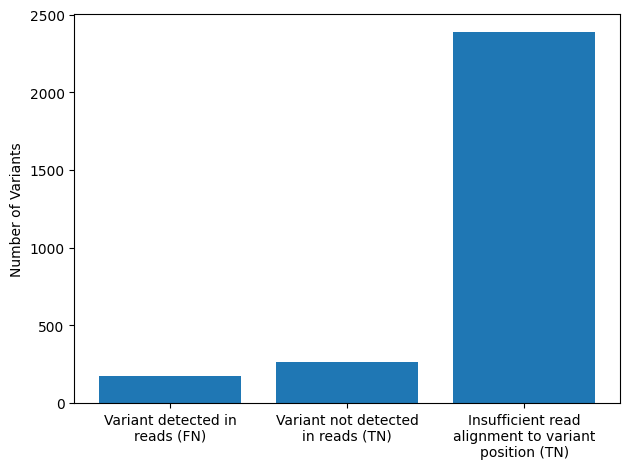

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"))

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")


  0%|                                                                                                                                                                                | 0/22528 [00:00<?, ?it/s]


 29%|███████████████████████████████████████████████                                                                                                                   | 6545/22528 [00:00<00:00, 64292.30it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12975/22528 [00:00<00:00, 24888.28it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 16642/22528 [00:00<00:00, 20004.27it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 19281/22528 [00:00<00:00, 16589.72it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22528/22528 [00:01<00:00, 21555.15it/s]

Variants in vcrs_reference: 170
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000338895:c.910G>A',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000585156:c.6692C>G',
 'ENST00000585156:c.6471G>C',
 'ENST00000581821:c.709G>C',
 'ENST00000581822:c.924C>G',
 'ENST00000243611:c.756C>T',
 'ENST00000238181:c.457C>T',
 'ENST00000238181:c.458A>G',
 'ENST00000486442:c.1197T>C',
 'ENST00000456023:c.173G>C',
 'ENST00000353339:c.460A>T',
 'ENST00000353339:c.461G>T',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000338895:c.910G>A


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

GAGGAATTCCTGCGGGTCCTCGGCTCCATGTGCCAGAAGCTCCGGTCCATGCAGTACAATGGCAGCTACTTCGAC
GTCGAAGTAGCTGCCATTGTACTGCATGGACCGGAGCTTCTGGCACATGGAGCCGAGGACCCGCAGGAATTCCTC
GTCGAAGTAGCTGCCATTGTACTGCATGGACCGGAGCT
TTCTGGCACATGGAGCCGAGGACCCGCAGGAATTCCTC


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000344063:c.729G>A


TAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAACGGACTGATTCACCG
CGGTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq


  0%|                                                                                                                                                                             | 0/66352376 [00:00<?, ?it/s]


  0%|                                                                                                                                                               | 3149/66352376 [00:00<35:07, 31482.52it/s]


  0%|                                                                                                                                                               | 7364/66352376 [00:00<29:17, 37754.01it/s]


  0%|                                                                                                                                                              | 11669/66352376 [00:00<27:31, 40170.35it/s]


  0%|                                                                                                                                                              | 16033/66352376 [00:00<26:36, 41538.66it/s]


  0%|                                                                                                                                                              | 20434/66352376 [00:00<26:03, 42427.97it/s]


  0%|                                                                                                                                                              | 24716/66352376 [00:00<25:58, 42559.54it/s]


  0%|                                                                                                                                                              | 31018/66352376 [00:00<22:26, 49245.54it/s]


  0%|                                                                                                                                                              | 38153/66352376 [00:00<19:38, 56280.92it/s]


  0%|                                                                                                                                                              | 45793/66352376 [00:00<17:39, 62567.63it/s]


  0%|▏                                                                                                                                                             | 52905/66352376 [00:01<16:56, 65204.86it/s]


  0%|▏                                                                                                                                                             | 60464/66352376 [00:01<16:09, 68381.26it/s]


  0%|▏                                                                                                                                                             | 67929/66352376 [00:01<15:43, 70285.45it/s]


  0%|▏                                                                                                                                                             | 75906/66352376 [00:01<15:05, 73155.81it/s]


  0%|▏                                                                                                                                                             | 84384/66352376 [00:01<14:24, 76665.68it/s]


  0%|▏                                                                                                                                                             | 92268/66352376 [00:01<14:16, 77317.95it/s]


  0%|▏                                                                                                                                                            | 100177/66352376 [00:01<14:11, 77843.95it/s]


  0%|▎                                                                                                                                                            | 108538/66352376 [00:01<13:52, 79575.68it/s]


  0%|▎                                                                                                                                                            | 116501/66352376 [00:01<13:52, 79588.77it/s]


  0%|▎                                                                                                                                                            | 124460/66352376 [00:01<13:53, 79464.11it/s]


  0%|▎                                                                                                                                                            | 132486/66352376 [00:02<13:52, 79571.27it/s]


  0%|▎                                                                                                                                                            | 140924/66352376 [00:02<13:37, 81009.91it/s]


  0%|▎                                                                                                                                                            | 149026/66352376 [00:02<13:43, 80364.25it/s]


  0%|▎                                                                                                                                                            | 157064/66352376 [00:02<13:44, 80317.19it/s]


  0%|▍                                                                                                                                                            | 165400/66352376 [00:02<13:44, 80287.89it/s]


  0%|▍                                                                                                                                                            | 173935/66352376 [00:02<13:29, 81785.93it/s]


  0%|▍                                                                                                                                                            | 182116/66352376 [00:02<13:33, 81343.51it/s]


  0%|▍                                                                                                                                                            | 190253/66352376 [00:02<13:42, 80425.26it/s]


  0%|▍                                                                                                                                                            | 198299/66352376 [00:02<13:44, 80211.07it/s]


  0%|▍                                                                                                                                                            | 206778/66352376 [00:02<13:30, 81566.73it/s]


  0%|▌                                                                                                                                                            | 214938/66352376 [00:03<13:47, 79960.82it/s]


  0%|▌                                                                                                                                                            | 222942/66352376 [00:03<13:47, 79898.77it/s]


  0%|▌                                                                                                                                                            | 231069/66352376 [00:03<13:47, 79880.05it/s]


  0%|▌                                                                                                                                                            | 239061/66352376 [00:03<16:37, 66284.07it/s]


  0%|▌                                                                                                                                                            | 246071/66352376 [00:03<18:57, 58134.24it/s]


  0%|▌                                                                                                                                                            | 252288/66352376 [00:03<19:41, 55948.80it/s]


  0%|▌                                                                                                                                                            | 258822/66352376 [00:03<18:54, 58268.12it/s]


  0%|▋                                                                                                                                                            | 264887/66352376 [00:03<18:43, 58800.87it/s]


  0%|▋                                                                                                                                                            | 271426/66352376 [00:03<18:10, 60586.15it/s]


  0%|▋                                                                                                                                                            | 277976/66352376 [00:04<18:05, 60854.40it/s]


  0%|▋                                                                                                                                                            | 285281/66352376 [00:04<17:07, 64284.75it/s]


  0%|▋                                                                                                                                                            | 293339/66352376 [00:04<15:57, 68956.86it/s]


  0%|▋                                                                                                                                                            | 301429/66352376 [00:04<15:13, 72283.68it/s]


  0%|▋                                                                                                                                                            | 309944/66352376 [00:04<14:28, 76052.21it/s]


  0%|▊                                                                                                                                                            | 317845/66352376 [00:04<14:18, 76923.97it/s]


  0%|▊                                                                                                                                                            | 325718/66352376 [00:04<14:12, 77458.18it/s]


  1%|▊                                                                                                                                                            | 334223/66352376 [00:04<13:48, 79714.73it/s]


  1%|▊                                                                                                                                                            | 342271/66352376 [00:04<13:45, 79942.04it/s]


  1%|▊                                                                                                                                                            | 350282/66352376 [00:04<13:45, 79906.69it/s]


  1%|▊                                                                                                                                                            | 358284/66352376 [00:05<13:46, 79844.30it/s]


  1%|▊                                                                                                                                                            | 366665/66352376 [00:05<13:34, 81028.72it/s]


  1%|▉                                                                                                                                                            | 374774/66352376 [00:05<13:36, 80844.83it/s]


  1%|▉                                                                                                                                                            | 382863/66352376 [00:05<13:41, 80351.91it/s]


  1%|▉                                                                                                                                                            | 390981/66352376 [00:05<13:40, 80343.15it/s]


  1%|▉                                                                                                                                                            | 399486/66352376 [00:05<13:26, 81743.36it/s]


  1%|▉                                                                                                                                                            | 407664/66352376 [00:05<13:36, 80813.26it/s]


  1%|▉                                                                                                                                                            | 415750/66352376 [00:05<13:40, 80377.79it/s]


  1%|█                                                                                                                                                            | 423963/66352376 [00:05<13:41, 80225.80it/s]


  1%|█                                                                                                                                                            | 432373/66352376 [00:05<13:30, 81369.74it/s]


  1%|█                                                                                                                                                            | 440514/66352376 [00:06<13:35, 80841.45it/s]


  1%|█                                                                                                                                                            | 448601/66352376 [00:06<13:45, 79849.86it/s]


  1%|█                                                                                                                                                            | 456946/66352376 [00:06<13:46, 79753.83it/s]


  1%|█                                                                                                                                                            | 465328/66352376 [00:06<13:33, 80944.46it/s]


  1%|█                                                                                                                                                            | 473427/66352376 [00:06<13:36, 80705.08it/s]


  1%|█▏                                                                                                                                                           | 481501/66352376 [00:06<13:36, 80712.70it/s]


  1%|█▏                                                                                                                                                           | 489819/66352376 [00:06<13:41, 80133.47it/s]


  1%|█▏                                                                                                                                                           | 498324/66352376 [00:06<13:27, 81577.95it/s]


  1%|█▏                                                                                                                                                           | 506487/66352376 [00:06<13:32, 81069.92it/s]


  1%|█▏                                                                                                                                                           | 514598/66352376 [00:07<13:41, 80109.91it/s]


  1%|█▏                                                                                                                                                           | 522654/66352376 [00:07<13:42, 80075.87it/s]


  1%|█▎                                                                                                                                                           | 531009/66352376 [00:07<13:31, 81102.27it/s]


  1%|█▎                                                                                                                                                           | 539123/66352376 [00:07<13:37, 80503.19it/s]


  1%|█▎                                                                                                                                                           | 547177/66352376 [00:07<13:42, 79996.81it/s]


  1%|█▎                                                                                                                                                           | 555489/66352376 [00:07<13:42, 79996.84it/s]


  1%|█▎                                                                                                                                                           | 564008/66352376 [00:07<13:26, 81525.27it/s]


  1%|█▎                                                                                                                                                           | 572165/66352376 [00:07<13:35, 80647.50it/s]


  1%|█▎                                                                                                                                                           | 580234/66352376 [00:07<13:39, 80281.32it/s]


  1%|█▍                                                                                                                                                           | 588324/66352376 [00:07<13:38, 80374.39it/s]


  1%|█▍                                                                                                                                                           | 596846/66352376 [00:08<13:23, 81808.33it/s]


  1%|█▍                                                                                                                                                           | 605030/66352376 [00:08<13:31, 81030.52it/s]


  1%|█▍                                                                                                                                                           | 613137/66352376 [00:08<13:44, 79702.46it/s]


  1%|█▍                                                                                                                                                           | 621159/66352376 [00:08<13:55, 78679.59it/s]


  1%|█▍                                                                                                                                                           | 629251/66352376 [00:08<13:48, 79331.87it/s]


  1%|█▌                                                                                                                                                           | 637190/66352376 [00:08<13:58, 78329.63it/s]


  1%|█▌                                                                                                                                                           | 645029/66352376 [00:08<14:10, 77274.60it/s]


  1%|█▌                                                                                                                                                           | 653499/66352376 [00:08<13:46, 79444.47it/s]


  1%|█▌                                                                                                                                                           | 661453/66352376 [00:08<13:51, 79047.43it/s]


  1%|█▌                                                                                                                                                           | 669446/66352376 [00:08<13:48, 79304.84it/s]


  1%|█▌                                                                                                                                                           | 677712/66352376 [00:09<13:44, 79691.39it/s]


  1%|█▌                                                                                                                                                           | 686125/66352376 [00:09<13:30, 81003.94it/s]


  1%|█▋                                                                                                                                                           | 694230/66352376 [00:09<13:31, 80879.75it/s]


  1%|█▋                                                                                                                                                           | 702321/66352376 [00:09<15:16, 71600.10it/s]


  1%|█▋                                                                                                                                                           | 709675/66352376 [00:09<17:39, 61934.83it/s]


  1%|█▋                                                                                                                                                           | 716200/66352376 [00:09<19:30, 56073.21it/s]


  1%|█▋                                                                                                                                                           | 722095/66352376 [00:09<20:10, 54229.47it/s]


  1%|█▋                                                                                                                                                           | 727704/66352376 [00:09<20:43, 52775.62it/s]


  1%|█▋                                                                                                                                                           | 733099/66352376 [00:10<21:09, 51690.69it/s]


  1%|█▋                                                                                                                                                           | 738552/66352376 [00:10<20:51, 52433.65it/s]


  1%|█▊                                                                                                                                                           | 746109/66352376 [00:10<18:36, 58737.11it/s]


  1%|█▊                                                                                                                                                           | 753617/66352376 [00:10<17:16, 63314.95it/s]


  1%|█▊                                                                                                                                                           | 761678/66352376 [00:10<16:00, 68256.42it/s]


  1%|█▊                                                                                                                                                           | 769111/66352376 [00:10<15:36, 70015.51it/s]


  1%|█▊                                                                                                                                                           | 776659/66352376 [00:10<15:17, 71510.83it/s]


  1%|█▊                                                                                                                                                           | 785155/66352376 [00:10<14:28, 75472.65it/s]


  1%|█▉                                                                                                                                                           | 792749/66352376 [00:10<14:59, 72865.21it/s]


  1%|█▉                                                                                                                                                           | 800679/66352376 [00:10<14:37, 74728.27it/s]


  1%|█▉                                                                                                                                                           | 809144/66352376 [00:11<14:04, 77630.52it/s]


  1%|█▉                                                                                                                                                           | 817003/66352376 [00:11<14:01, 77911.53it/s]


  1%|█▉                                                                                                                                                           | 824896/66352376 [00:11<13:57, 78210.75it/s]


  1%|█▉                                                                                                                                                           | 833044/66352376 [00:11<13:57, 78214.19it/s]


  1%|█▉                                                                                                                                                           | 841474/66352376 [00:11<13:38, 80010.58it/s]


  1%|██                                                                                                                                                           | 849487/66352376 [00:11<13:41, 79737.91it/s]


  1%|██                                                                                                                                                           | 857469/66352376 [00:11<13:45, 79301.30it/s]


  1%|██                                                                                                                                                           | 865878/66352376 [00:11<13:41, 79694.92it/s]


  1%|██                                                                                                                                                           | 874344/66352376 [00:11<13:26, 81155.33it/s]


  1%|██                                                                                                                                                           | 882465/66352376 [00:11<13:31, 80713.19it/s]


  1%|██                                                                                                                                                           | 890540/66352376 [00:12<16:36, 65678.59it/s]


  1%|██▏                                                                                                                                                          | 898714/66352376 [00:12<15:47, 69082.47it/s]


  1%|██▏                                                                                                                                                          | 907204/66352376 [00:12<14:52, 73287.67it/s]


  1%|██▏                                                                                                                                                          | 915197/66352376 [00:12<14:31, 75115.00it/s]


  1%|██▏                                                                                                                                                          | 923154/66352376 [00:12<14:16, 76371.57it/s]


  1%|██▏                                                                                                                                                          | 931481/66352376 [00:12<13:54, 78352.68it/s]


  1%|██▏                                                                                                                                                          | 939444/66352376 [00:12<13:51, 78696.22it/s]


  1%|██▏                                                                                                                                                          | 947405/66352376 [00:12<13:48, 78914.09it/s]


  1%|██▎                                                                                                                                                          | 955363/66352376 [00:12<13:46, 79109.18it/s]


  1%|██▎                                                                                                                                                          | 963788/66352376 [00:13<13:30, 80632.64it/s]


  1%|██▎                                                                                                                                                          | 971885/66352376 [00:13<13:37, 80002.41it/s]


  1%|██▎                                                                                                                                                          | 979910/66352376 [00:13<13:39, 79795.78it/s]


  1%|██▎                                                                                                                                                          | 987975/66352376 [00:13<13:40, 79628.87it/s]


  2%|██▎                                                                                                                                                          | 996375/66352376 [00:13<13:27, 80924.06it/s]


  2%|██▎                                                                                                                                                         | 1004478/66352376 [00:13<13:34, 80213.79it/s]


  2%|██▍                                                                                                                                                         | 1012508/66352376 [00:13<13:41, 79579.38it/s]


  2%|██▍                                                                                                                                                         | 1020864/66352376 [00:13<13:43, 79372.53it/s]


  2%|██▍                                                                                                                                                         | 1029230/66352376 [00:13<13:30, 80628.74it/s]


  2%|██▍                                                                                                                                                         | 1037299/66352376 [00:13<13:34, 80188.11it/s]


  2%|██▍                                                                                                                                                         | 1045322/66352376 [00:14<13:36, 79936.34it/s]


  2%|██▍                                                                                                                                                         | 1053623/66352376 [00:14<13:27, 80843.87it/s]


  2%|██▍                                                                                                                                                         | 1061711/66352376 [00:14<13:31, 80457.41it/s]


  2%|██▌                                                                                                                                                         | 1069759/66352376 [00:14<13:32, 80321.86it/s]


  2%|██▌                                                                                                                                                         | 1077793/66352376 [00:14<13:34, 80102.00it/s]


  2%|██▌                                                                                                                                                         | 1086266/66352376 [00:14<13:21, 81477.36it/s]


  2%|██▌                                                                                                                                                         | 1094416/66352376 [00:14<13:31, 80411.92it/s]


  2%|██▌                                                                                                                                                         | 1102462/66352376 [00:14<13:34, 80157.04it/s]


  2%|██▌                                                                                                                                                         | 1110481/66352376 [00:14<13:35, 79982.99it/s]


  2%|██▋                                                                                                                                                         | 1118992/66352376 [00:15<13:20, 81505.12it/s]


  2%|██▋                                                                                                                                                         | 1127146/66352376 [00:15<13:23, 81180.24it/s]


  2%|██▋                                                                                                                                                         | 1135266/66352376 [00:15<14:03, 77320.44it/s]


  2%|██▋                                                                                                                                                         | 1143036/66352376 [00:15<14:34, 74571.58it/s]


  2%|██▋                                                                                                                                                         | 1150533/66352376 [00:15<14:44, 73699.16it/s]


  2%|██▋                                                                                                                                                         | 1157929/66352376 [00:15<15:05, 72020.15it/s]


  2%|██▋                                                                                                                                                         | 1165151/66352376 [00:15<15:05, 72004.28it/s]


  2%|██▊                                                                                                                                                         | 1173080/66352376 [00:15<14:39, 74109.53it/s]


  2%|██▊                                                                                                                                                         | 1181042/66352376 [00:15<14:20, 75719.13it/s]


  2%|██▊                                                                                                                                                         | 1189474/66352376 [00:15<13:52, 78249.89it/s]


  2%|██▊                                                                                                                                                         | 1197316/66352376 [00:16<16:58, 63952.48it/s]


  2%|██▊                                                                                                                                                         | 1205146/66352376 [00:16<16:03, 67635.54it/s]


  2%|██▊                                                                                                                                                         | 1212977/66352376 [00:16<15:23, 70500.12it/s]


  2%|██▊                                                                                                                                                         | 1221439/66352376 [00:16<14:35, 74411.37it/s]


  2%|██▉                                                                                                                                                         | 1229407/66352376 [00:16<14:17, 75904.59it/s]


  2%|██▉                                                                                                                                                         | 1237366/66352376 [00:16<14:06, 76965.87it/s]


  2%|██▉                                                                                                                                                         | 1245552/66352376 [00:16<14:00, 77474.81it/s]


  2%|██▉                                                                                                                                                         | 1254031/66352376 [00:16<13:37, 79607.19it/s]


  2%|██▉                                                                                                                                                         | 1262060/66352376 [00:16<13:37, 79637.50it/s]


  2%|██▉                                                                                                                                                         | 1270071/66352376 [00:17<13:37, 79604.13it/s]


  2%|███                                                                                                                                                         | 1278241/66352376 [00:17<13:39, 79436.58it/s]


  2%|███                                                                                                                                                         | 1286568/66352376 [00:17<13:27, 80566.78it/s]


  2%|███                                                                                                                                                         | 1294643/66352376 [00:17<13:29, 80379.15it/s]


  2%|███                                                                                                                                                         | 1302694/66352376 [00:17<13:29, 80317.35it/s]


  2%|███                                                                                                                                                         | 1310735/66352376 [00:17<13:51, 78193.48it/s]


  2%|███                                                                                                                                                         | 1318572/66352376 [00:17<13:52, 78151.69it/s]


  2%|███                                                                                                                                                         | 1326518/66352376 [00:17<13:47, 78534.08it/s]


  2%|███▏                                                                                                                                                        | 1334424/66352376 [00:17<13:46, 78687.55it/s]


  2%|███▏                                                                                                                                                        | 1342693/66352376 [00:17<13:33, 79874.96it/s]


  2%|███▏                                                                                                                                                        | 1350687/66352376 [00:18<13:38, 79431.81it/s]


  2%|███▏                                                                                                                                                        | 1358635/66352376 [00:18<13:44, 78874.03it/s]


  2%|███▏                                                                                                                                                        | 1366983/66352376 [00:18<13:29, 80237.01it/s]


  2%|███▏                                                                                                                                                        | 1375011/66352376 [00:18<13:35, 79720.24it/s]


  2%|███▎                                                                                                                                                        | 1382987/66352376 [00:18<13:37, 79489.65it/s]


  2%|███▎                                                                                                                                                        | 1390939/66352376 [00:18<15:04, 71797.54it/s]


  2%|███▎                                                                                                                                                        | 1398258/66352376 [00:18<17:32, 61740.21it/s]


  2%|███▎                                                                                                                                                        | 1404745/66352376 [00:18<19:16, 56141.44it/s]


  2%|███▎                                                                                                                                                        | 1410628/66352376 [00:19<21:00, 51532.75it/s]


  2%|███▎                                                                                                                                                        | 1415992/66352376 [00:19<21:36, 50073.20it/s]


  2%|███▎                                                                                                                                                        | 1423519/66352376 [00:19<19:29, 55520.12it/s]


  2%|███▎                                                                                                                                                        | 1431125/66352376 [00:19<17:46, 60846.12it/s]


  2%|███▍                                                                                                                                                        | 1438184/66352376 [00:19<17:02, 63477.73it/s]


  2%|███▍                                                                                                                                                        | 1445772/66352376 [00:19<16:09, 66931.96it/s]


  2%|███▍                                                                                                                                                        | 1452834/66352376 [00:19<15:54, 67980.11it/s]


  2%|███▍                                                                                                                                                        | 1461045/66352376 [00:19<15:12, 71116.50it/s]


  2%|███▍                                                                                                                                                        | 1469435/66352376 [00:19<14:27, 74817.09it/s]


  2%|███▍                                                                                                                                                        | 1477345/66352376 [00:19<14:12, 76068.04it/s]


  2%|███▍                                                                                                                                                        | 1485271/66352376 [00:20<14:02, 77006.58it/s]


  2%|███▌                                                                                                                                                        | 1493609/66352376 [00:20<13:42, 78894.15it/s]


  2%|███▌                                                                                                                                                        | 1501543/66352376 [00:20<13:40, 79025.26it/s]


  2%|███▌                                                                                                                                                        | 1509466/66352376 [00:20<13:40, 79018.36it/s]


  2%|███▌                                                                                                                                                        | 1517382/66352376 [00:20<13:42, 78862.24it/s]


  2%|███▌                                                                                                                                                        | 1525883/66352376 [00:20<13:23, 80693.64it/s]


  2%|███▌                                                                                                                                                        | 1533961/66352376 [00:20<13:33, 79689.24it/s]


  2%|███▋                                                                                                                                                        | 1541938/66352376 [00:20<13:34, 79566.83it/s]


  2%|███▋                                                                                                                                                        | 1549975/66352376 [00:20<13:34, 79540.21it/s]


  2%|███▋                                                                                                                                                        | 1558427/66352376 [00:20<13:19, 81019.91it/s]


  2%|███▋                                                                                                                                                        | 1566534/66352376 [00:21<13:24, 80561.14it/s]


  2%|███▋                                                                                                                                                        | 1574594/66352376 [00:21<13:30, 79897.53it/s]


  2%|███▋                                                                                                                                                        | 1582664/66352376 [00:21<13:31, 79806.14it/s]


  2%|███▋                                                                                                                                                        | 1591029/66352376 [00:21<13:20, 80943.76it/s]


  2%|███▊                                                                                                                                                        | 1599127/66352376 [00:21<13:26, 80261.53it/s]


  2%|███▊                                                                                                                                                        | 1607156/66352376 [00:21<13:29, 80003.85it/s]


  2%|███▊                                                                                                                                                        | 1615354/66352376 [00:21<13:33, 79554.95it/s]


  2%|███▊                                                                                                                                                        | 1623537/66352376 [00:21<13:26, 80223.09it/s]


  2%|███▊                                                                                                                                                        | 1631562/66352376 [00:21<13:29, 79971.79it/s]


  2%|███▊                                                                                                                                                        | 1639561/66352376 [00:21<13:30, 79798.61it/s]


  2%|███▊                                                                                                                                                        | 1648042/66352376 [00:22<13:31, 79689.40it/s]


  2%|███▉                                                                                                                                                        | 1656376/66352376 [00:22<13:21, 80761.47it/s]


  3%|███▉                                                                                                                                                        | 1664456/66352376 [00:22<13:23, 80551.81it/s]


  3%|███▉                                                                                                                                                        | 1672514/66352376 [00:22<13:25, 80273.04it/s]


  3%|███▉                                                                                                                                                        | 1680731/66352376 [00:22<13:27, 80087.29it/s]


  3%|███▉                                                                                                                                                        | 1689207/66352376 [00:22<13:13, 81468.87it/s]


  3%|███▉                                                                                                                                                        | 1697357/66352376 [00:22<13:21, 80650.58it/s]


  3%|████                                                                                                                                                        | 1705426/66352376 [00:22<13:24, 80346.15it/s]


  3%|████                                                                                                                                                        | 1713568/66352376 [00:22<13:27, 80000.73it/s]


  3%|████                                                                                                                                                        | 1722043/66352376 [00:23<13:13, 81402.79it/s]


  3%|████                                                                                                                                                        | 1730187/66352376 [00:23<13:18, 80937.22it/s]


  3%|████                                                                                                                                                        | 1738284/66352376 [00:23<13:25, 80216.72it/s]


  3%|████                                                                                                                                                        | 1746403/66352376 [00:23<13:26, 80150.75it/s]


  3%|████▏                                                                                                                                                       | 1754901/66352376 [00:23<13:11, 81578.93it/s]


  3%|████▏                                                                                                                                                       | 1763062/66352376 [00:23<13:17, 80972.87it/s]


  3%|████▏                                                                                                                                                       | 1771162/66352376 [00:23<13:24, 80297.89it/s]


  3%|████▏                                                                                                                                                       | 1779238/66352376 [00:23<13:30, 79689.58it/s]


  3%|████▏                                                                                                                                                       | 1787688/66352376 [00:23<13:16, 81107.86it/s]


  3%|████▏                                                                                                                                                       | 1795803/66352376 [00:23<13:20, 80665.68it/s]


  3%|████▏                                                                                                                                                       | 1803873/66352376 [00:24<13:22, 80479.38it/s]


  3%|████▎                                                                                                                                                       | 1812074/66352376 [00:24<13:24, 80252.00it/s]


  3%|████▎                                                                                                                                                       | 1820431/66352376 [00:24<13:14, 81231.49it/s]


  3%|████▎                                                                                                                                                       | 1828557/66352376 [00:24<13:20, 80649.85it/s]


  3%|████▎                                                                                                                                                       | 1836625/66352376 [00:24<13:27, 79916.03it/s]


  3%|████▎                                                                                                                                                       | 1844910/66352376 [00:24<13:29, 79719.14it/s]


  3%|████▎                                                                                                                                                       | 1853332/66352376 [00:24<13:15, 81039.68it/s]


  3%|████▍                                                                                                                                                       | 1861440/66352376 [00:24<13:25, 80043.91it/s]


  3%|████▍                                                                                                                                                       | 1869449/66352376 [00:24<13:30, 79566.21it/s]


  3%|████▍                                                                                                                                                       | 1877745/66352376 [00:24<13:31, 79440.72it/s]


  3%|████▍                                                                                                                                                       | 1886131/66352376 [00:25<13:18, 80736.22it/s]


  3%|████▍                                                                                                                                                       | 1894210/66352376 [00:25<13:27, 79822.68it/s]


  3%|████▍                                                                                                                                                       | 1902197/66352376 [00:25<13:33, 79229.03it/s]


  3%|████▍                                                                                                                                                       | 1910466/66352376 [00:25<13:33, 79221.75it/s]


  3%|████▌                                                                                                                                                       | 1918899/66352376 [00:25<13:18, 80719.24it/s]


  3%|████▌                                                                                                                                                       | 1926976/66352376 [00:25<13:23, 80163.62it/s]


  3%|████▌                                                                                                                                                       | 1934996/66352376 [00:25<13:32, 79302.64it/s]


  3%|████▌                                                                                                                                                       | 1943156/66352376 [00:25<13:34, 79098.92it/s]


  3%|████▌                                                                                                                                                       | 1951552/66352376 [00:25<13:19, 80525.06it/s]


  3%|████▌                                                                                                                                                       | 1959610/66352376 [00:25<13:27, 79738.13it/s]


  3%|████▋                                                                                                                                                       | 1967588/66352376 [00:26<13:30, 79458.84it/s]


  3%|████▋                                                                                                                                                       | 1975827/66352376 [00:26<13:21, 80323.86it/s]


  3%|████▋                                                                                                                                                       | 1983863/66352376 [00:26<13:25, 79895.02it/s]


  3%|████▋                                                                                                                                                       | 1991855/66352376 [00:26<13:29, 79485.18it/s]


  3%|████▋                                                                                                                                                       | 1999806/66352376 [00:26<13:32, 79221.95it/s]


  3%|████▋                                                                                                                                                       | 2008135/66352376 [00:26<13:20, 80427.58it/s]


  3%|████▋                                                                                                                                                       | 2016180/66352376 [00:26<13:27, 79659.53it/s]


  3%|████▊                                                                                                                                                       | 2024149/66352376 [00:26<13:32, 79144.68it/s]


  3%|████▊                                                                                                                                                       | 2032066/66352376 [00:26<13:34, 78991.87it/s]


  3%|████▊                                                                                                                                                       | 2040485/66352376 [00:26<13:18, 80533.53it/s]


  3%|████▊                                                                                                                                                       | 2048541/66352376 [00:27<13:22, 80154.92it/s]


  3%|████▊                                                                                                                                                       | 2056559/66352376 [00:27<13:27, 79589.19it/s]


  3%|████▊                                                                                                                                                       | 2064571/66352376 [00:27<13:29, 79398.92it/s]


  3%|████▊                                                                                                                                                       | 2072989/66352376 [00:27<13:15, 80816.00it/s]


  3%|████▉                                                                                                                                                       | 2081074/66352376 [00:27<13:32, 79121.14it/s]


  3%|████▉                                                                                                                                                       | 2088995/66352376 [00:27<13:34, 78931.59it/s]


  3%|████▉                                                                                                                                                       | 2097285/66352376 [00:27<13:22, 80101.82it/s]


  3%|████▉                                                                                                                                                       | 2105302/66352376 [00:27<13:23, 79958.99it/s]


  3%|████▉                                                                                                                                                       | 2113302/66352376 [00:27<13:24, 79824.60it/s]


  3%|████▉                                                                                                                                                       | 2121288/66352376 [00:27<13:25, 79739.47it/s]


  3%|█████                                                                                                                                                       | 2129742/66352376 [00:28<13:11, 81167.80it/s]


  3%|█████                                                                                                                                                       | 2137861/66352376 [00:28<13:20, 80240.85it/s]


  3%|█████                                                                                                                                                       | 2145889/66352376 [00:28<13:25, 79673.34it/s]


  3%|█████                                                                                                                                                       | 2153860/66352376 [00:28<13:28, 79435.32it/s]


  3%|█████                                                                                                                                                       | 2162297/66352376 [00:28<13:13, 80897.67it/s]


  3%|█████                                                                                                                                                       | 2170390/66352376 [00:28<13:16, 80546.83it/s]


  3%|█████                                                                                                                                                       | 2178447/66352376 [00:28<13:24, 79772.43it/s]


  3%|█████▏                                                                                                                                                      | 2186514/66352376 [00:28<13:26, 79602.18it/s]


  3%|█████▏                                                                                                                                                      | 2194954/66352376 [00:28<13:11, 81021.81it/s]


  3%|█████▏                                                                                                                                                      | 2203060/66352376 [00:29<13:20, 80146.93it/s]


  3%|█████▏                                                                                                                                                      | 2211079/66352376 [00:29<13:23, 79832.24it/s]


  3%|█████▏                                                                                                                                                      | 2219347/66352376 [00:29<13:28, 79357.12it/s]


  3%|█████▏                                                                                                                                                      | 2227742/66352376 [00:29<13:14, 80704.36it/s]


  3%|█████▎                                                                                                                                                      | 2235818/66352376 [00:29<13:18, 80305.63it/s]


  3%|█████▎                                                                                                                                                      | 2243852/66352376 [00:29<13:20, 80049.78it/s]


  3%|█████▎                                                                                                                                                      | 2252182/66352376 [00:29<13:24, 79713.18it/s]


  3%|█████▎                                                                                                                                                      | 2260291/66352376 [00:29<13:19, 80116.69it/s]


  3%|█████▎                                                                                                                                                      | 2268306/66352376 [00:29<13:24, 79704.85it/s]


  3%|█████▎                                                                                                                                                      | 2276279/66352376 [00:29<13:25, 79579.17it/s]


  3%|█████▎                                                                                                                                                      | 2284691/66352376 [00:30<13:11, 80923.49it/s]


  3%|█████▍                                                                                                                                                      | 2292786/66352376 [00:30<13:18, 80229.70it/s]


  3%|█████▍                                                                                                                                                      | 2300812/66352376 [00:30<13:33, 78779.85it/s]


  3%|█████▍                                                                                                                                                      | 2308697/66352376 [00:30<13:34, 78599.20it/s]


  3%|█████▍                                                                                                                                                      | 2317038/66352376 [00:30<13:20, 80015.85it/s]


  4%|█████▍                                                                                                                                                      | 2325045/66352376 [00:30<13:28, 79217.51it/s]


  4%|█████▍                                                                                                                                                      | 2332972/66352376 [00:30<13:32, 78760.04it/s]


  4%|█████▌                                                                                                                                                      | 2341001/66352376 [00:30<13:33, 78686.28it/s]


  4%|█████▌                                                                                                                                                      | 2349328/66352376 [00:30<13:19, 80039.34it/s]


  4%|█████▌                                                                                                                                                      | 2357336/66352376 [00:30<13:28, 79164.16it/s]


  4%|█████▌                                                                                                                                                      | 2365257/66352376 [00:31<13:31, 78823.94it/s]


  4%|█████▌                                                                                                                                                      | 2373440/66352376 [00:31<13:22, 79711.64it/s]


  4%|█████▌                                                                                                                                                      | 2381415/66352376 [00:31<13:26, 79285.36it/s]


  4%|█████▌                                                                                                                                                      | 2389346/66352376 [00:31<13:27, 79237.30it/s]


  4%|█████▋                                                                                                                                                      | 2397272/66352376 [00:31<13:29, 79025.51it/s]


  4%|█████▋                                                                                                                                                      | 2405679/66352376 [00:31<13:14, 80524.98it/s]


  4%|█████▋                                                                                                                                                      | 2413734/66352376 [00:31<13:24, 79504.07it/s]


  4%|█████▋                                                                                                                                                      | 2421689/66352376 [00:31<13:28, 79100.70it/s]


  4%|█████▋                                                                                                                                                      | 2429723/66352376 [00:31<13:30, 78864.11it/s]


  4%|█████▋                                                                                                                                                      | 2438075/66352376 [00:31<13:16, 80237.66it/s]


  4%|█████▊                                                                                                                                                      | 2446103/66352376 [00:32<13:24, 79421.72it/s]


  4%|█████▊                                                                                                                                                      | 2454049/66352376 [00:32<13:32, 78686.07it/s]


  4%|█████▊                                                                                                                                                      | 2462382/66352376 [00:32<13:18, 80054.91it/s]


  4%|█████▊                                                                                                                                                      | 2470392/66352376 [00:32<13:24, 79411.44it/s]


  4%|█████▊                                                                                                                                                      | 2478337/66352376 [00:32<13:29, 78933.24it/s]


  4%|█████▊                                                                                                                                                      | 2486233/66352376 [00:32<13:32, 78651.99it/s]


  4%|█████▊                                                                                                                                                      | 2494377/66352376 [00:32<13:23, 79474.69it/s]


  4%|█████▉                                                                                                                                                      | 2502327/66352376 [00:32<13:33, 78519.23it/s]


  4%|█████▉                                                                                                                                                      | 2510183/66352376 [00:32<13:34, 78355.97it/s]


  4%|█████▉                                                                                                                                                      | 2518260/66352376 [00:32<13:27, 79069.10it/s]


  4%|█████▉                                                                                                                                                      | 2526170/66352376 [00:33<13:28, 78912.19it/s]


  4%|█████▉                                                                                                                                                      | 2534063/66352376 [00:33<13:33, 78477.72it/s]


  4%|█████▉                                                                                                                                                      | 2542217/66352376 [00:33<13:31, 78632.92it/s]


  4%|█████▉                                                                                                                                                      | 2550586/66352376 [00:33<13:16, 80128.71it/s]


  4%|██████                                                                                                                                                      | 2558602/66352376 [00:33<13:24, 79265.67it/s]


  4%|██████                                                                                                                                                      | 2566532/66352376 [00:33<13:26, 79132.43it/s]


  4%|██████                                                                                                                                                      | 2574809/66352376 [00:33<13:15, 80208.40it/s]


  4%|██████                                                                                                                                                      | 2582833/66352376 [00:33<13:19, 79766.96it/s]


  4%|██████                                                                                                                                                      | 2590812/66352376 [00:33<13:20, 79603.50it/s]


  4%|██████                                                                                                                                                      | 2598774/66352376 [00:33<13:22, 79418.27it/s]


  4%|██████▏                                                                                                                                                     | 2607206/66352376 [00:34<13:08, 80876.10it/s]


  4%|██████▏                                                                                                                                                     | 2615296/66352376 [00:34<13:16, 79998.72it/s]


  4%|██████▏                                                                                                                                                     | 2623299/66352376 [00:34<13:22, 79386.22it/s]


  4%|██████▏                                                                                                                                                     | 2631241/66352376 [00:34<14:39, 72461.85it/s]


  4%|██████▏                                                                                                                                                     | 2638601/66352376 [00:34<17:31, 60582.21it/s]


  4%|██████▏                                                                                                                                                     | 2645034/66352376 [00:34<19:09, 55420.64it/s]


  4%|██████▏                                                                                                                                                     | 2650876/66352376 [00:34<20:49, 50984.53it/s]


  4%|██████▏                                                                                                                                                     | 2656202/66352376 [00:35<21:36, 49139.85it/s]


  4%|██████▎                                                                                                                                                     | 2661258/66352376 [00:35<22:15, 47703.64it/s]


  4%|██████▎                                                                                                                                                     | 2668423/66352376 [00:35<19:44, 53759.38it/s]


  4%|██████▎                                                                                                                                                     | 2675341/66352376 [00:35<18:20, 57849.98it/s]


  4%|██████▎                                                                                                                                                     | 2682769/66352376 [00:35<17:15, 61470.79it/s]


  4%|██████▎                                                                                                                                                     | 2690322/66352376 [00:35<16:13, 65391.40it/s]


  4%|██████▎                                                                                                                                                     | 2697342/66352376 [00:35<15:53, 66760.64it/s]


  4%|██████▎                                                                                                                                                     | 2705539/66352376 [00:35<14:54, 71159.95it/s]


  4%|██████▍                                                                                                                                                     | 2713352/66352376 [00:35<14:29, 73196.72it/s]


  4%|██████▍                                                                                                                                                     | 2721191/66352376 [00:35<14:11, 74724.89it/s]


  4%|██████▍                                                                                                                                                     | 2729466/66352376 [00:36<13:57, 75944.89it/s]


  4%|██████▍                                                                                                                                                     | 2737602/66352376 [00:36<13:40, 77537.02it/s]


  4%|██████▍                                                                                                                                                     | 2745410/66352376 [00:36<13:38, 77695.04it/s]


  4%|██████▍                                                                                                                                                     | 2753216/66352376 [00:36<13:37, 77801.13it/s]


  4%|██████▍                                                                                                                                                     | 2761565/66352376 [00:36<13:19, 79494.33it/s]


  4%|██████▌                                                                                                                                                     | 2769525/66352376 [00:36<13:23, 79179.15it/s]


  4%|██████▌                                                                                                                                                     | 2777450/66352376 [00:36<13:29, 78564.88it/s]


  4%|██████▌                                                                                                                                                     | 2785500/66352376 [00:36<13:29, 78535.37it/s]


  4%|██████▌                                                                                                                                                     | 2793780/66352376 [00:36<13:16, 79796.92it/s]


  4%|██████▌                                                                                                                                                     | 2801765/66352376 [00:36<13:20, 79406.75it/s]


  4%|██████▌                                                                                                                                                     | 2809709/66352376 [00:37<13:21, 79299.48it/s]


  4%|██████▋                                                                                                                                                     | 2817953/66352376 [00:37<13:11, 80230.98it/s]


  4%|██████▋                                                                                                                                                     | 2825979/66352376 [00:37<13:17, 79701.09it/s]


  4%|██████▋                                                                                                                                                     | 2833952/66352376 [00:37<13:19, 79464.75it/s]


  4%|██████▋                                                                                                                                                     | 2841900/66352376 [00:37<13:20, 79326.54it/s]


  4%|██████▋                                                                                                                                                     | 2850312/66352376 [00:37<13:06, 80752.84it/s]


  4%|██████▋                                                                                                                                                     | 2858389/66352376 [00:37<13:16, 79667.26it/s]


  4%|██████▋                                                                                                                                                     | 2866360/66352376 [00:37<13:18, 79547.06it/s]


  4%|██████▊                                                                                                                                                     | 2874477/66352376 [00:37<13:19, 79433.13it/s]


  4%|██████▊                                                                                                                                                     | 2882885/66352376 [00:37<13:05, 80807.20it/s]


  4%|██████▊                                                                                                                                                     | 2890969/66352376 [00:38<13:09, 80395.28it/s]


  4%|██████▊                                                                                                                                                     | 2899011/66352376 [00:38<13:17, 79580.41it/s]


  4%|██████▊                                                                                                                                                     | 2907107/66352376 [00:38<13:13, 79984.67it/s]


  4%|██████▊                                                                                                                                                     | 2915108/66352376 [00:38<13:15, 79751.22it/s]


  4%|██████▊                                                                                                                                                     | 2923085/66352376 [00:38<13:19, 79311.99it/s]


  4%|██████▉                                                                                                                                                     | 2931018/66352376 [00:38<13:19, 79282.00it/s]


  4%|██████▉                                                                                                                                                     | 2939310/66352376 [00:38<13:09, 80363.13it/s]


  4%|██████▉                                                                                                                                                     | 2947348/66352376 [00:38<13:12, 80021.12it/s]


  4%|██████▉                                                                                                                                                     | 2955352/66352376 [00:38<13:14, 79825.55it/s]


  4%|██████▉                                                                                                                                                     | 2963597/66352376 [00:38<13:14, 79739.82it/s]


  4%|██████▉                                                                                                                                                     | 2972018/66352376 [00:39<13:01, 81061.89it/s]


  4%|███████                                                                                                                                                     | 2980127/66352376 [00:39<13:13, 79857.66it/s]


  5%|███████                                                                                                                                                     | 2988118/66352376 [00:39<13:14, 79726.57it/s]


  5%|███████                                                                                                                                                     | 2996342/66352376 [00:39<13:15, 79680.32it/s]


  5%|███████                                                                                                                                                     | 3004793/66352376 [00:39<13:01, 81102.74it/s]


  5%|███████                                                                                                                                                     | 3012908/66352376 [00:39<13:05, 80646.91it/s]


  5%|███████                                                                                                                                                     | 3020976/66352376 [00:39<13:12, 79918.76it/s]


  5%|███████                                                                                                                                                     | 3029029/66352376 [00:39<13:13, 79769.03it/s]


  5%|███████▏                                                                                                                                                    | 3037469/66352376 [00:39<13:00, 81137.70it/s]


  5%|███████▏                                                                                                                                                    | 3045586/66352376 [00:39<13:07, 80387.35it/s]


  5%|███████▏                                                                                                                                                    | 3053628/66352376 [00:40<13:10, 80065.90it/s]


  5%|███████▏                                                                                                                                                    | 3061717/66352376 [00:40<13:15, 79522.86it/s]


  5%|███████▏                                                                                                                                                    | 3070173/66352376 [00:40<13:01, 81008.57it/s]


  5%|███████▏                                                                                                                                                    | 3078278/66352376 [00:40<13:06, 80483.96it/s]


  5%|███████▎                                                                                                                                                    | 3086330/66352376 [00:40<13:10, 80045.51it/s]


  5%|███████▎                                                                                                                                                    | 3094405/66352376 [00:40<13:14, 79604.42it/s]


  5%|███████▎                                                                                                                                                    | 3102704/66352376 [00:40<13:04, 80604.17it/s]


  5%|███████▎                                                                                                                                                    | 3110768/66352376 [00:40<13:13, 79659.72it/s]


  5%|███████▎                                                                                                                                                    | 3118738/66352376 [00:40<13:17, 79265.82it/s]


  5%|███████▎                                                                                                                                                    | 3127083/66352376 [00:41<13:05, 80500.48it/s]


  5%|███████▎                                                                                                                                                    | 3135137/66352376 [00:41<13:44, 76676.51it/s]


  5%|███████▍                                                                                                                                                    | 3142897/66352376 [00:41<13:41, 76940.05it/s]


  5%|███████▍                                                                                                                                                    | 3150828/66352376 [00:41<13:34, 77628.17it/s]


  5%|███████▍                                                                                                                                                    | 3159272/66352376 [00:41<13:13, 79628.21it/s]


  5%|███████▍                                                                                                                                                    | 3167254/66352376 [00:41<13:15, 79403.44it/s]


  5%|███████▍                                                                                                                                                    | 3175208/66352376 [00:41<13:18, 79160.86it/s]


  5%|███████▍                                                                                                                                                    | 3183415/66352376 [00:41<13:20, 78939.17it/s]


  5%|███████▌                                                                                                                                                    | 3191792/66352376 [00:41<13:05, 80360.28it/s]


  5%|███████▌                                                                                                                                                    | 3199836/66352376 [00:41<13:09, 80010.98it/s]


  5%|███████▌                                                                                                                                                    | 3207843/66352376 [00:42<13:10, 79831.81it/s]


  5%|███████▌                                                                                                                                                    | 3216193/66352376 [00:42<13:02, 80702.08it/s]


  5%|███████▌                                                                                                                                                    | 3224266/66352376 [00:42<13:06, 80310.43it/s]


  5%|███████▌                                                                                                                                                    | 3232300/66352376 [00:42<13:08, 80044.83it/s]


  5%|███████▌                                                                                                                                                    | 3240306/66352376 [00:42<13:13, 79528.33it/s]


  5%|███████▋                                                                                                                                                    | 3248739/66352376 [00:42<12:59, 80950.57it/s]


  5%|███████▋                                                                                                                                                    | 3256837/66352376 [00:42<13:06, 80176.05it/s]


  5%|███████▋                                                                                                                                                    | 3264858/66352376 [00:42<13:09, 79920.69it/s]


  5%|███████▋                                                                                                                                                    | 3272852/66352376 [00:42<13:11, 79730.26it/s]


  5%|███████▋                                                                                                                                                    | 3281286/66352376 [00:42<12:57, 81097.33it/s]


  5%|███████▋                                                                                                                                                    | 3289398/66352376 [00:43<13:02, 80631.79it/s]


  5%|███████▊                                                                                                                                                    | 3297463/66352376 [00:43<13:10, 79788.36it/s]


  5%|███████▊                                                                                                                                                    | 3305445/66352376 [00:43<13:11, 79650.38it/s]


  5%|███████▊                                                                                                                                                    | 3313890/66352376 [00:43<12:57, 81072.11it/s]


  5%|███████▊                                                                                                                                                    | 3322000/66352376 [00:43<13:02, 80572.96it/s]


  5%|███████▊                                                                                                                                                    | 3330060/66352376 [00:43<13:05, 80257.89it/s]


  5%|███████▊                                                                                                                                                    | 3338088/66352376 [00:43<13:10, 79739.94it/s]


  5%|███████▊                                                                                                                                                    | 3346517/66352376 [00:43<12:57, 81087.26it/s]


  5%|███████▉                                                                                                                                                    | 3354629/66352376 [00:43<13:03, 80433.61it/s]


  5%|███████▉                                                                                                                                                    | 3362675/66352376 [00:43<13:09, 79789.42it/s]


  5%|███████▉                                                                                                                                                    | 3370657/66352376 [00:44<13:12, 79470.60it/s]


  5%|███████▉                                                                                                                                                    | 3378982/66352376 [00:44<13:01, 80587.62it/s]


  5%|███████▉                                                                                                                                                    | 3387044/66352376 [00:44<13:06, 80066.28it/s]


  5%|███████▉                                                                                                                                                    | 3395053/66352376 [00:44<13:09, 79694.52it/s]


  5%|████████                                                                                                                                                    | 3403342/66352376 [00:44<13:10, 79641.63it/s]


  5%|████████                                                                                                                                                    | 3411822/66352376 [00:44<12:55, 81161.88it/s]


  5%|████████                                                                                                                                                    | 3419942/66352376 [00:44<13:01, 80516.48it/s]


  5%|████████                                                                                                                                                    | 3427997/66352376 [00:44<13:06, 79993.32it/s]


  5%|████████                                                                                                                                                    | 3436029/66352376 [00:44<13:07, 79933.16it/s]


  5%|████████                                                                                                                                                    | 3444442/66352376 [00:44<12:54, 81175.66it/s]


  5%|████████                                                                                                                                                    | 3452562/66352376 [00:45<12:59, 80655.24it/s]


  5%|████████▏                                                                                                                                                   | 3460630/66352376 [00:45<13:05, 80059.87it/s]


  5%|████████▏                                                                                                                                                   | 3468867/66352376 [00:45<13:06, 79999.69it/s]


  5%|████████▏                                                                                                                                                   | 3477274/66352376 [00:45<12:54, 81200.45it/s]


  5%|████████▏                                                                                                                                                   | 3485397/66352376 [00:45<12:58, 80730.29it/s]


  5%|████████▏                                                                                                                                                   | 3493473/66352376 [00:45<13:05, 80003.57it/s]


  5%|████████▏                                                                                                                                                   | 3501700/66352376 [00:45<13:09, 79607.16it/s]


  5%|████████▎                                                                                                                                                   | 3510116/66352376 [00:45<12:56, 80944.44it/s]


  5%|████████▎                                                                                                                                                   | 3518215/66352376 [00:45<13:00, 80467.54it/s]


  5%|████████▎                                                                                                                                                   | 3526265/66352376 [00:46<13:03, 80173.10it/s]


  5%|████████▎                                                                                                                                                   | 3534533/66352376 [00:46<13:05, 79980.66it/s]


  5%|████████▎                                                                                                                                                   | 3542867/66352376 [00:46<12:55, 80967.83it/s]


  5%|████████▎                                                                                                                                                   | 3550967/66352376 [00:46<13:03, 80193.22it/s]


  5%|████████▎                                                                                                                                                   | 3558990/66352376 [00:46<13:05, 79910.76it/s]


  5%|████████▍                                                                                                                                                   | 3567364/66352376 [00:46<12:54, 81042.90it/s]


  5%|████████▍                                                                                                                                                   | 3575472/66352376 [00:46<13:00, 80450.78it/s]


  5%|████████▍                                                                                                                                                   | 3583520/66352376 [00:46<13:04, 79962.78it/s]


  5%|████████▍                                                                                                                                                   | 3591519/66352376 [00:46<13:06, 79819.44it/s]


  5%|████████▍                                                                                                                                                   | 3600010/66352376 [00:46<12:51, 81328.47it/s]


  5%|████████▍                                                                                                                                                   | 3608146/66352376 [00:47<12:57, 80668.82it/s]


  5%|████████▌                                                                                                                                                   | 3616216/66352376 [00:47<13:02, 80132.49it/s]


  5%|████████▌                                                                                                                                                   | 3624232/66352376 [00:47<13:08, 79570.98it/s]


  5%|████████▌                                                                                                                                                   | 3632615/66352376 [00:47<12:55, 80829.75it/s]


  5%|████████▌                                                                                                                                                   | 3640701/66352376 [00:47<12:58, 80533.25it/s]


  5%|████████▌                                                                                                                                                   | 3648757/66352376 [00:47<13:01, 80246.69it/s]


  6%|████████▌                                                                                                                                                   | 3656784/66352376 [00:47<13:02, 80097.81it/s]


  6%|████████▌                                                                                                                                                   | 3667666/66352376 [00:47<11:47, 88645.85it/s]


  6%|████████▋                                                                                                                                                   | 3678981/66352376 [00:47<10:53, 95955.39it/s]


  6%|████████▌                                                                                                                                                  | 3689932/66352376 [00:47<10:26, 100003.42it/s]


  6%|████████▋                                                                                                                                                  | 3701664/66352376 [00:48<09:55, 105180.83it/s]


  6%|████████▋                                                                                                                                                  | 3713147/66352376 [00:48<09:39, 108066.58it/s]


  6%|████████▋                                                                                                                                                  | 3724783/66352376 [00:48<09:26, 110547.76it/s]


  6%|████████▋                                                                                                                                                  | 3735842/66352376 [00:48<09:50, 105959.83it/s]


  6%|████████▊                                                                                                                                                  | 3747274/66352376 [00:48<09:37, 108390.89it/s]


  6%|████████▊                                                                                                                                                  | 3758720/66352376 [00:48<09:28, 110171.06it/s]


  6%|████████▊                                                                                                                                                  | 3770025/66352376 [00:48<09:23, 111018.35it/s]


  6%|████████▊                                                                                                                                                  | 3781542/66352376 [00:48<09:17, 112247.99it/s]


  6%|████████▊                                                                                                                                                  | 3792784/66352376 [00:48<09:17, 112114.34it/s]


  6%|████████▉                                                                                                                                                  | 3804680/66352376 [00:48<09:07, 114152.13it/s]


  6%|████████▉                                                                                                                                                  | 3816984/66352376 [00:49<08:55, 116805.30it/s]


  6%|████████▉                                                                                                                                                  | 3829342/66352376 [00:49<08:49, 118000.01it/s]


  6%|████████▉                                                                                                                                                  | 3842099/66352376 [00:49<08:37, 120849.33it/s]


  6%|█████████                                                                                                                                                  | 3854189/66352376 [00:49<08:41, 119889.25it/s]


  6%|█████████                                                                                                                                                  | 3866329/66352376 [00:49<08:39, 120335.55it/s]


  6%|█████████                                                                                                                                                  | 3878526/66352376 [00:49<08:37, 120820.44it/s]


  6%|█████████                                                                                                                                                  | 3890611/66352376 [00:49<08:50, 117737.78it/s]


  6%|█████████                                                                                                                                                  | 3903547/66352376 [00:49<08:35, 121148.56it/s]


  6%|█████████▏                                                                                                                                                 | 3915682/66352376 [00:49<08:37, 120537.54it/s]


  6%|█████████▏                                                                                                                                                 | 3927844/66352376 [00:49<08:37, 120607.92it/s]


  6%|█████████▏                                                                                                                                                 | 3940359/66352376 [00:50<08:31, 121953.31it/s]


  6%|█████████▏                                                                                                                                                 | 3952563/66352376 [00:50<08:42, 119369.42it/s]


  6%|█████████▎                                                                                                                                                 | 3965687/66352376 [00:50<08:27, 122854.37it/s]


  6%|█████████▎                                                                                                                                                 | 3978908/66352376 [00:50<08:16, 125616.82it/s]


  6%|█████████▎                                                                                                                                                 | 3991741/66352376 [00:50<08:13, 126420.92it/s]


  6%|█████████▎                                                                                                                                                 | 4004672/66352376 [00:50<08:09, 127278.79it/s]


  6%|█████████▍                                                                                                                                                 | 4017549/66352376 [00:50<08:08, 127722.19it/s]


  6%|█████████▍                                                                                                                                                 | 4030647/66352376 [00:50<08:07, 127845.24it/s]


  6%|█████████▍                                                                                                                                                 | 4044247/66352376 [00:50<07:58, 130271.94it/s]


  6%|█████████▍                                                                                                                                                 | 4057280/66352376 [00:50<08:01, 129269.06it/s]


  6%|█████████▌                                                                                                                                                 | 4070212/66352376 [00:51<08:06, 128149.63it/s]


  6%|█████████▌                                                                                                                                                 | 4083032/66352376 [00:51<08:15, 125623.25it/s]


  6%|█████████▌                                                                                                                                                 | 4096021/66352376 [00:51<08:11, 126611.99it/s]


  6%|█████████▌                                                                                                                                                 | 4109468/66352376 [00:51<08:02, 128926.61it/s]


  6%|█████████▋                                                                                                                                                 | 4122372/66352376 [00:51<08:03, 128613.15it/s]


  6%|█████████▋                                                                                                                                                 | 4135337/66352376 [00:51<08:02, 128919.24it/s]


  6%|█████████▋                                                                                                                                                 | 4148235/66352376 [00:51<08:02, 128802.85it/s]


  6%|█████████▋                                                                                                                                                 | 4161646/66352376 [00:51<08:01, 129195.11it/s]


  6%|█████████▊                                                                                                                                                 | 4174831/66352376 [00:51<07:58, 129980.56it/s]


  6%|█████████▊                                                                                                                                                 | 4187832/66352376 [00:51<07:58, 129939.64it/s]


  6%|█████████▊                                                                                                                                                 | 4200942/66352376 [00:52<07:57, 130283.19it/s]


  6%|█████████▊                                                                                                                                                 | 4213972/66352376 [00:52<08:01, 129034.32it/s]


  6%|█████████▊                                                                                                                                                 | 4227067/66352376 [00:52<07:59, 129601.24it/s]


  6%|█████████▉                                                                                                                                                 | 4240030/66352376 [00:52<08:03, 128505.35it/s]


  6%|█████████▉                                                                                                                                                 | 4252884/66352376 [00:52<08:07, 127392.04it/s]


  6%|█████████▉                                                                                                                                                 | 4265627/66352376 [00:52<08:15, 125199.62it/s]


  6%|█████████▉                                                                                                                                                 | 4278259/66352376 [00:52<08:14, 125527.00it/s]


  6%|██████████                                                                                                                                                 | 4290819/66352376 [00:52<08:14, 125502.20it/s]


  6%|██████████                                                                                                                                                 | 4303374/66352376 [00:52<08:30, 121635.45it/s]


  7%|██████████                                                                                                                                                 | 4315564/66352376 [00:53<08:36, 120035.48it/s]


  7%|██████████                                                                                                                                                 | 4327586/66352376 [00:53<08:46, 117726.97it/s]


  7%|██████████▏                                                                                                                                                | 4339698/66352376 [00:53<08:42, 118653.47it/s]


  7%|██████████▏                                                                                                                                                | 4352516/66352376 [00:53<08:30, 121436.11it/s]


  7%|██████████▎                                                                                                                                                 | 4364678/66352376 [00:53<13:00, 79460.11it/s]


  7%|██████████▎                                                                                                                                                 | 4374497/66352376 [00:53<15:14, 67755.84it/s]


  7%|██████████▎                                                                                                                                                 | 4382789/66352376 [00:53<16:46, 61580.70it/s]


  7%|██████████▎                                                                                                                                                 | 4390017/66352376 [00:54<17:41, 58397.38it/s]


  7%|██████████▎                                                                                                                                                 | 4397536/66352376 [00:54<16:41, 61869.93it/s]


  7%|██████████▎                                                                                                                                                 | 4405415/66352376 [00:54<15:42, 65728.07it/s]


  7%|██████████▍                                                                                                                                                 | 4413811/66352376 [00:54<14:42, 70207.59it/s]


  7%|██████████▍                                                                                                                                                 | 4421583/66352376 [00:54<14:18, 72158.40it/s]


  7%|██████████▍                                                                                                                                                 | 4429444/66352376 [00:54<13:57, 73902.64it/s]


  7%|██████████▍                                                                                                                                                 | 4437679/66352376 [00:54<13:31, 76256.09it/s]


  7%|██████████▍                                                                                                                                                 | 4445523/66352376 [00:54<13:26, 76775.61it/s]


  7%|██████████▍                                                                                                                                                 | 4453384/66352376 [00:54<13:20, 77302.92it/s]


  7%|██████████▍                                                                                                                                                 | 4461257/66352376 [00:55<13:16, 77717.34it/s]


  7%|██████████▌                                                                                                                                                 | 4469640/66352376 [00:55<12:58, 79513.62it/s]


  7%|██████████▌                                                                                                                                                 | 4477650/66352376 [00:55<13:04, 78877.87it/s]


  7%|██████████▌                                                                                                                                                 | 4485580/66352376 [00:55<13:06, 78627.31it/s]


  7%|██████████▌                                                                                                                                                 | 4493902/66352376 [00:55<13:05, 78775.29it/s]


  7%|██████████▌                                                                                                                                                 | 4502278/66352376 [00:55<12:50, 80237.10it/s]


  7%|██████████▌                                                                                                                                                 | 4510319/66352376 [00:55<12:58, 79388.57it/s]


  7%|██████████▌                                                                                                                                                 | 4518271/66352376 [00:55<13:00, 79173.21it/s]


  7%|██████████▋                                                                                                                                                 | 4526693/66352376 [00:55<12:46, 80662.70it/s]


  7%|██████████▋                                                                                                                                                 | 4534768/66352376 [00:55<12:51, 80102.88it/s]


  7%|██████████▋                                                                                                                                                 | 4542785/66352376 [00:56<13:06, 78615.45it/s]


  7%|██████████▋                                                                                                                                                 | 4550656/66352376 [00:56<13:09, 78262.38it/s]


  7%|██████████▋                                                                                                                                                 | 4559101/66352376 [00:56<12:51, 80082.43it/s]


  7%|██████████▋                                                                                                                                                 | 4567117/66352376 [00:56<12:53, 79841.81it/s]


  7%|██████████▊                                                                                                                                                 | 4575107/66352376 [00:56<12:54, 79748.98it/s]


  7%|██████████▊                                                                                                                                                 | 4583086/66352376 [00:56<12:56, 79576.38it/s]


  7%|██████████▊                                                                                                                                                 | 4591439/66352376 [00:56<12:44, 80751.31it/s]


  7%|██████████▊                                                                                                                                                 | 4599517/66352376 [00:56<12:49, 80297.94it/s]


  7%|██████████▊                                                                                                                                                 | 4607549/66352376 [00:56<12:54, 79697.51it/s]


  7%|██████████▊                                                                                                                                                 | 4615871/66352376 [00:56<12:54, 79666.50it/s]


  7%|██████████▊                                                                                                                                                 | 4624320/66352376 [00:57<12:41, 81085.72it/s]


  7%|██████████▉                                                                                                                                                 | 4632433/66352376 [00:57<12:49, 80220.09it/s]


  7%|██████████▉                                                                                                                                                 | 4640459/66352376 [00:57<12:52, 79915.84it/s]


  7%|██████████▉                                                                                                                                                 | 4648705/66352376 [00:57<12:53, 79785.52it/s]


  7%|██████████▉                                                                                                                                                 | 4657129/66352376 [00:57<12:40, 81096.95it/s]


  7%|██████████▉                                                                                                                                                 | 4665243/66352376 [00:57<12:49, 80185.81it/s]


  7%|██████████▉                                                                                                                                                 | 4673266/66352376 [00:57<12:55, 79505.04it/s]


  7%|███████████                                                                                                                                                 | 4681473/66352376 [00:57<12:55, 79526.73it/s]


  7%|███████████                                                                                                                                                 | 4689891/66352376 [00:57<12:42, 80895.24it/s]


  7%|███████████                                                                                                                                                 | 4697985/66352376 [00:57<12:47, 80341.16it/s]


  7%|███████████                                                                                                                                                 | 4706023/66352376 [00:58<12:50, 79973.68it/s]


  7%|███████████                                                                                                                                                 | 4714161/66352376 [00:58<12:57, 79320.10it/s]


  7%|███████████                                                                                                                                                 | 4722574/66352376 [00:58<12:43, 80735.17it/s]


  7%|███████████                                                                                                                                                 | 4730652/66352376 [00:58<12:51, 79883.21it/s]


  7%|███████████▏                                                                                                                                                | 4738645/66352376 [00:58<12:55, 79492.77it/s]


  7%|███████████▏                                                                                                                                                | 4746848/66352376 [00:58<12:56, 79374.95it/s]


  7%|███████████▏                                                                                                                                                | 4755107/66352376 [00:58<12:46, 80319.99it/s]


  7%|███████████▏                                                                                                                                                | 4763143/66352376 [00:58<12:50, 79964.49it/s]


  7%|███████████▏                                                                                                                                                | 4771142/66352376 [00:58<12:54, 79532.50it/s]


  7%|███████████▏                                                                                                                                                | 4779534/66352376 [00:59<12:41, 80830.00it/s]


  7%|███████████▎                                                                                                                                                | 4787620/66352376 [00:59<12:49, 79981.16it/s]


  7%|███████████▎                                                                                                                                                | 4795622/66352376 [00:59<12:57, 79149.16it/s]


  7%|███████████▎                                                                                                                                                | 4803541/66352376 [00:59<12:59, 78985.94it/s]


  7%|███████████▎                                                                                                                                                | 4811963/66352376 [00:59<12:44, 80533.21it/s]


  7%|███████████▎                                                                                                                                                | 4820020/66352376 [00:59<12:48, 80081.53it/s]


  7%|███████████▎                                                                                                                                                | 4828031/66352376 [00:59<12:51, 79717.86it/s]


  7%|███████████▎                                                                                                                                                | 4836005/66352376 [00:59<12:57, 79073.68it/s]


  7%|███████████▍                                                                                                                                                | 4844366/66352376 [00:59<12:44, 80412.22it/s]


  7%|███████████▍                                                                                                                                                | 4852411/66352376 [00:59<12:52, 79621.55it/s]


  7%|███████████▍                                                                                                                                                | 4860377/66352376 [01:00<12:55, 79334.76it/s]


  7%|███████████▍                                                                                                                                                | 4868323/66352376 [01:00<12:57, 79049.67it/s]


  7%|███████████▍                                                                                                                                                | 4876572/66352376 [01:00<12:47, 80066.63it/s]


  7%|███████████▍                                                                                                                                                | 4884581/66352376 [01:00<12:52, 79618.84it/s]


  7%|███████████▌                                                                                                                                                | 4892545/66352376 [01:00<12:54, 79322.56it/s]


  7%|███████████▌                                                                                                                                                | 4900964/66352376 [01:00<12:40, 80767.11it/s]


  7%|███████████▌                                                                                                                                                | 4909043/66352376 [01:00<12:49, 79820.91it/s]


  7%|███████████▌                                                                                                                                                | 4917029/66352376 [01:00<12:56, 79094.21it/s]


  7%|███████████▌                                                                                                                                                | 4924942/66352376 [01:00<12:58, 78928.90it/s]


  7%|███████████▌                                                                                                                                                | 4933322/66352376 [01:00<12:44, 80370.56it/s]


  7%|███████████▌                                                                                                                                                | 4941363/66352376 [01:01<12:49, 79831.26it/s]


  7%|███████████▋                                                                                                                                                | 4949349/66352376 [01:01<12:56, 79100.72it/s]


  7%|███████████▋                                                                                                                                                | 4957477/66352376 [01:01<12:57, 78985.09it/s]


  7%|███████████▋                                                                                                                                                | 4965827/66352376 [01:01<12:44, 80315.35it/s]


  7%|███████████▋                                                                                                                                                | 4973863/66352376 [01:01<12:51, 79523.39it/s]


  8%|███████████▋                                                                                                                                                | 4981819/66352376 [01:01<12:54, 79269.68it/s]


  8%|███████████▋                                                                                                                                                | 4990085/66352376 [01:01<12:44, 80270.05it/s]


  8%|███████████▊                                                                                                                                                | 4998115/66352376 [01:01<12:48, 79815.43it/s]


  8%|███████████▊                                                                                                                                                | 5006099/66352376 [01:01<12:51, 79527.58it/s]


  8%|███████████▊                                                                                                                                                | 5014054/66352376 [01:01<13:01, 78530.92it/s]


  8%|███████████▊                                                                                                                                                | 5022486/66352376 [01:02<12:44, 80237.62it/s]


  8%|███████████▊                                                                                                                                                | 5030515/66352376 [01:02<12:53, 79233.13it/s]


  8%|███████████▊                                                                                                                                                | 5038444/66352376 [01:02<12:54, 79137.39it/s]


  8%|███████████▊                                                                                                                                                | 5046594/66352376 [01:02<12:54, 79195.44it/s]


  8%|███████████▉                                                                                                                                                | 5055018/66352376 [01:02<12:39, 80684.57it/s]


  8%|███████████▉                                                                                                                                                | 5063091/66352376 [01:02<12:44, 80189.22it/s]


  8%|███████████▉                                                                                                                                                | 5071113/66352376 [01:02<12:50, 79520.89it/s]


  8%|███████████▉                                                                                                                                                | 5079281/66352376 [01:02<12:51, 79449.06it/s]


  8%|███████████▉                                                                                                                                                | 5087509/66352376 [01:02<12:43, 80283.59it/s]


  8%|███████████▉                                                                                                                                                | 5095541/66352376 [01:02<12:50, 79490.40it/s]


  8%|███████████▉                                                                                                                                                | 5103493/66352376 [01:03<12:52, 79337.73it/s]


  8%|████████████                                                                                                                                                | 5111780/66352376 [01:03<12:41, 80382.19it/s]


  8%|████████████                                                                                                                                                | 5119821/66352376 [01:03<12:46, 79918.94it/s]


  8%|████████████                                                                                                                                                | 5127815/66352376 [01:03<12:48, 79645.43it/s]


  8%|████████████                                                                                                                                                | 5135781/66352376 [01:03<12:50, 79419.59it/s]


  8%|████████████                                                                                                                                                | 5144201/66352376 [01:03<12:37, 80837.37it/s]


  8%|████████████                                                                                                                                                | 5152287/66352376 [01:03<12:48, 79681.18it/s]


  8%|████████████▏                                                                                                                                               | 5160260/66352376 [01:03<12:49, 79488.46it/s]


  8%|████████████▏                                                                                                                                               | 5168212/66352376 [01:03<12:51, 79304.98it/s]


  8%|████████████▏                                                                                                                                               | 5176527/66352376 [01:03<12:40, 80444.56it/s]


  8%|████████████▏                                                                                                                                               | 5184574/66352376 [01:04<12:44, 80034.62it/s]


  8%|████████████▏                                                                                                                                               | 5192580/66352376 [01:04<12:50, 79326.57it/s]


  8%|████████████▏                                                                                                                                               | 5200692/66352376 [01:04<12:54, 78919.72it/s]


  8%|████████████▏                                                                                                                                               | 5209027/66352376 [01:04<12:42, 80225.08it/s]


  8%|████████████▎                                                                                                                                               | 5217054/66352376 [01:04<12:47, 79697.06it/s]


  8%|████████████▎                                                                                                                                               | 5225027/66352376 [01:04<13:20, 76324.24it/s]


  8%|████████████▎                                                                                                                                               | 5233027/66352376 [01:04<13:09, 77380.69it/s]


  8%|████████████▎                                                                                                                                               | 5240918/66352376 [01:04<13:05, 77824.30it/s]


  8%|████████████▎                                                                                                                                               | 5248810/66352376 [01:04<13:01, 78143.41it/s]


  8%|████████████▎                                                                                                                                               | 5256872/66352376 [01:05<12:58, 78439.98it/s]


  8%|████████████▍                                                                                                                                               | 5265193/66352376 [01:05<12:45, 79849.45it/s]


  8%|████████████▍                                                                                                                                               | 5273187/66352376 [01:05<12:51, 79153.97it/s]


  8%|████████████▍                                                                                                                                               | 5281110/66352376 [01:05<12:52, 79085.73it/s]


  8%|████████████▍                                                                                                                                               | 5289533/66352376 [01:05<12:37, 80612.13it/s]


  8%|████████████▍                                                                                                                                               | 5297600/66352376 [01:05<12:41, 80209.53it/s]


  8%|████████████▍                                                                                                                                               | 5305625/66352376 [01:05<12:43, 79910.99it/s]


  8%|████████████▌                                                                                                                                               | 5317528/66352376 [01:05<11:06, 91542.08it/s]


  8%|████████████▍                                                                                                                                              | 5329696/66352376 [01:05<10:07, 100525.78it/s]


  8%|████████████▍                                                                                                                                              | 5341850/66352376 [01:05<09:31, 106798.93it/s]


  8%|████████████▌                                                                                                                                              | 5353957/66352376 [01:06<09:09, 111064.45it/s]


  8%|████████████▌                                                                                                                                              | 5366132/66352376 [01:06<08:53, 114260.96it/s]


  8%|████████████▌                                                                                                                                              | 5378647/66352376 [01:06<08:38, 117518.79it/s]


  8%|████████████▌                                                                                                                                              | 5390826/66352376 [01:06<08:33, 118796.84it/s]


  8%|████████████▌                                                                                                                                              | 5402876/66352376 [01:06<08:30, 119303.93it/s]


  8%|████████████▋                                                                                                                                              | 5415544/66352376 [01:06<08:21, 121512.41it/s]


  8%|████████████▋                                                                                                                                              | 5427706/66352376 [01:06<08:21, 121542.37it/s]


  8%|████████████▋                                                                                                                                              | 5439862/66352376 [01:06<08:26, 120309.09it/s]


  8%|████████████▋                                                                                                                                              | 5452700/66352376 [01:06<08:16, 122709.78it/s]


  8%|████████████▊                                                                                                                                              | 5465057/66352376 [01:06<08:15, 122963.13it/s]


  8%|████████████▊                                                                                                                                              | 5477357/66352376 [01:07<08:16, 122603.46it/s]


  8%|████████████▊                                                                                                                                              | 5490070/66352376 [01:07<08:11, 123947.18it/s]


  8%|████████████▊                                                                                                                                              | 5502468/66352376 [01:07<08:23, 120940.82it/s]


  8%|████████████▉                                                                                                                                              | 5514753/66352376 [01:07<08:20, 121499.40it/s]


  8%|████████████▉                                                                                                                                              | 5527389/66352376 [01:07<08:14, 122934.05it/s]


  8%|████████████▉                                                                                                                                              | 5539694/66352376 [01:07<08:15, 122731.98it/s]


  8%|████████████▉                                                                                                                                              | 5551975/66352376 [01:07<08:19, 121648.40it/s]


  8%|████████████▉                                                                                                                                              | 5564147/66352376 [01:07<08:23, 120710.60it/s]


  8%|█████████████                                                                                                                                              | 5577013/66352376 [01:07<08:13, 123060.65it/s]


  8%|█████████████                                                                                                                                              | 5590130/66352376 [01:07<08:04, 125466.70it/s]


  8%|█████████████                                                                                                                                              | 5603180/66352376 [01:08<07:59, 126707.36it/s]


  8%|█████████████                                                                                                                                              | 5616391/66352376 [01:08<07:53, 128314.30it/s]


  8%|█████████████▏                                                                                                                                             | 5629542/66352376 [01:08<07:49, 129266.23it/s]


  9%|█████████████▏                                                                                                                                             | 5642762/66352376 [01:08<07:46, 130141.72it/s]


  9%|█████████████▏                                                                                                                                             | 5655930/66352376 [01:08<07:44, 130599.43it/s]


  9%|█████████████▏                                                                                                                                             | 5669121/66352376 [01:08<07:43, 130989.97it/s]


  9%|█████████████▎                                                                                                                                             | 5682222/66352376 [01:08<07:43, 130833.83it/s]


  9%|█████████████▎                                                                                                                                             | 5695307/66352376 [01:08<07:45, 130429.55it/s]


  9%|█████████████▎                                                                                                                                             | 5708351/66352376 [01:08<07:46, 129869.73it/s]


  9%|█████████████▎                                                                                                                                             | 5721340/66352376 [01:08<07:46, 129853.00it/s]


  9%|█████████████▍                                                                                                                                             | 5734526/66352376 [01:09<07:48, 129457.30it/s]


  9%|█████████████▍                                                                                                                                             | 5747515/66352376 [01:09<07:47, 129585.00it/s]


  9%|█████████████▍                                                                                                                                             | 5760475/66352376 [01:09<07:49, 128997.40it/s]


  9%|█████████████▍                                                                                                                                             | 5773376/66352376 [01:09<07:53, 127891.91it/s]


  9%|█████████████▌                                                                                                                                             | 5786189/66352376 [01:09<07:53, 127961.05it/s]


  9%|█████████████▌                                                                                                                                             | 5799635/66352376 [01:09<07:46, 129893.51it/s]


  9%|█████████████▌                                                                                                                                             | 5812627/66352376 [01:09<07:55, 127422.84it/s]


  9%|█████████████▌                                                                                                                                             | 5825381/66352376 [01:09<08:02, 125339.98it/s]


  9%|█████████████▋                                                                                                                                             | 5837928/66352376 [01:09<08:10, 123388.91it/s]


  9%|█████████████▋                                                                                                                                             | 5850527/66352376 [01:09<08:07, 124140.95it/s]


  9%|█████████████▋                                                                                                                                             | 5862952/66352376 [01:10<08:15, 122063.90it/s]


  9%|█████████████▋                                                                                                                                             | 5875170/66352376 [01:10<08:19, 121022.05it/s]


  9%|█████████████▊                                                                                                                                             | 5888232/66352376 [01:10<08:08, 123830.12it/s]


  9%|█████████████▊                                                                                                                                             | 5900628/66352376 [01:10<08:14, 122360.82it/s]


  9%|█████████████▊                                                                                                                                             | 5912875/66352376 [01:10<08:16, 121851.03it/s]


  9%|█████████████▊                                                                                                                                             | 5925516/66352376 [01:10<08:10, 123185.60it/s]


  9%|█████████████▊                                                                                                                                             | 5937842/66352376 [01:10<08:13, 122333.24it/s]


  9%|█████████████▉                                                                                                                                             | 5950081/66352376 [01:10<08:16, 121610.86it/s]


  9%|█████████████▉                                                                                                                                             | 5962672/66352376 [01:10<08:11, 122880.31it/s]


  9%|█████████████▉                                                                                                                                             | 5974965/66352376 [01:10<08:15, 121853.19it/s]


  9%|█████████████▉                                                                                                                                             | 5987295/66352376 [01:11<08:13, 122280.87it/s]


  9%|██████████████                                                                                                                                             | 5999527/66352376 [01:11<08:21, 120417.24it/s]


  9%|██████████████                                                                                                                                             | 6011577/66352376 [01:11<08:23, 119827.69it/s]


  9%|██████████████                                                                                                                                             | 6024578/66352376 [01:11<08:11, 122832.10it/s]


  9%|██████████████                                                                                                                                             | 6036906/66352376 [01:11<08:10, 122961.12it/s]


  9%|██████████████▏                                                                                                                                            | 6049208/66352376 [01:11<08:13, 122154.70it/s]


  9%|██████████████▏                                                                                                                                            | 6061723/66352376 [01:11<08:10, 123041.56it/s]


  9%|██████████████▏                                                                                                                                            | 6074032/66352376 [01:11<08:12, 122285.71it/s]


  9%|██████████████▏                                                                                                                                            | 6086265/66352376 [01:11<08:13, 122084.55it/s]


  9%|██████████████▏                                                                                                                                            | 6098612/66352376 [01:12<08:11, 122490.29it/s]


  9%|██████████████▎                                                                                                                                            | 6110863/66352376 [01:12<08:16, 121404.90it/s]


  9%|██████████████▎                                                                                                                                            | 6123007/66352376 [01:12<08:16, 121327.91it/s]


  9%|██████████████▎                                                                                                                                            | 6135391/66352376 [01:12<08:13, 122073.34it/s]


  9%|██████████████▎                                                                                                                                            | 6147601/66352376 [01:12<08:15, 121451.69it/s]


  9%|██████████████▍                                                                                                                                            | 6160305/66352376 [01:12<08:12, 122341.52it/s]


  9%|██████████████▍                                                                                                                                            | 6172693/66352376 [01:12<08:10, 122797.38it/s]


  9%|██████████████▍                                                                                                                                            | 6184974/66352376 [01:12<08:15, 121321.75it/s]


  9%|██████████████▍                                                                                                                                            | 6197662/66352376 [01:12<08:14, 121700.96it/s]


  9%|██████████████▌                                                                                                                                            | 6210421/66352376 [01:12<08:07, 123437.11it/s]


  9%|██████████████▌                                                                                                                                            | 6222770/66352376 [01:13<08:12, 122164.05it/s]


  9%|██████████████▌                                                                                                                                            | 6235112/66352376 [01:13<08:10, 122529.97it/s]


  9%|██████████████▌                                                                                                                                            | 6247369/66352376 [01:13<08:13, 121722.57it/s]


  9%|██████████████▌                                                                                                                                            | 6259545/66352376 [01:13<08:13, 121665.80it/s]


  9%|██████████████▋                                                                                                                                            | 6271746/66352376 [01:13<08:13, 121767.12it/s]


  9%|██████████████▋                                                                                                                                            | 6284202/66352376 [01:13<08:09, 122596.30it/s]


  9%|██████████████▋                                                                                                                                            | 6296582/66352376 [01:13<08:08, 122948.74it/s]


 10%|██████████████▋                                                                                                                                            | 6308879/66352376 [01:13<08:10, 122515.75it/s]


 10%|██████████████▊                                                                                                                                            | 6321132/66352376 [01:13<08:28, 118124.65it/s]


 10%|██████████████▊                                                                                                                                            | 6333811/66352376 [01:13<08:17, 120647.72it/s]


 10%|██████████████▊                                                                                                                                            | 6347125/66352376 [01:14<08:02, 124318.11it/s]


 10%|██████████████▊                                                                                                                                            | 6359890/66352376 [01:14<07:58, 125301.86it/s]


 10%|██████████████▉                                                                                                                                            | 6372751/66352376 [01:14<07:54, 126281.25it/s]


 10%|██████████████▉                                                                                                                                            | 6385594/66352376 [01:14<07:52, 126918.74it/s]


 10%|██████████████▉                                                                                                                                            | 6398856/66352376 [01:14<07:46, 128617.82it/s]


 10%|██████████████▉                                                                                                                                            | 6411820/66352376 [01:14<07:44, 128922.43it/s]


 10%|███████████████                                                                                                                                            | 6424719/66352376 [01:14<07:48, 127881.07it/s]


 10%|███████████████                                                                                                                                            | 6437684/66352376 [01:14<07:46, 128406.72it/s]


 10%|███████████████                                                                                                                                            | 6450588/66352376 [01:14<07:49, 127591.89it/s]


 10%|███████████████                                                                                                                                            | 6464062/66352376 [01:14<07:41, 129714.15it/s]


 10%|███████████████▏                                                                                                                                           | 6477039/66352376 [01:15<07:43, 129206.81it/s]


 10%|███████████████▏                                                                                                                                           | 6489964/66352376 [01:15<07:44, 128951.27it/s]


 10%|███████████████▏                                                                                                                                           | 6502862/66352376 [01:15<07:45, 128514.80it/s]


 10%|███████████████▏                                                                                                                                           | 6515963/66352376 [01:15<07:46, 128384.97it/s]


 10%|███████████████▎                                                                                                                                           | 6529213/66352376 [01:15<07:41, 129606.21it/s]


 10%|███████████████▎                                                                                                                                           | 6542212/66352376 [01:15<07:41, 129719.04it/s]


 10%|███████████████▎                                                                                                                                           | 6555186/66352376 [01:15<07:44, 128768.55it/s]


 10%|███████████████▎                                                                                                                                           | 6568083/66352376 [01:15<07:44, 128825.86it/s]


 10%|███████████████▎                                                                                                                                           | 6581107/66352376 [01:15<07:42, 129244.84it/s]


 10%|███████████████▍                                                                                                                                           | 6594067/66352376 [01:15<07:41, 129349.96it/s]


 10%|███████████████▍                                                                                                                                           | 6607004/66352376 [01:16<07:42, 129105.20it/s]


 10%|███████████████▍                                                                                                                                           | 6619916/66352376 [01:16<07:44, 128592.14it/s]


 10%|███████████████▍                                                                                                                                           | 6633126/66352376 [01:16<07:44, 128676.97it/s]


 10%|███████████████▌                                                                                                                                           | 6646347/66352376 [01:16<07:40, 129723.77it/s]


 10%|███████████████▌                                                                                                                                           | 6659321/66352376 [01:16<07:41, 129306.68it/s]


 10%|███████████████▌                                                                                                                                           | 6672253/66352376 [01:16<07:41, 129272.57it/s]


 10%|███████████████▌                                                                                                                                           | 6685181/66352376 [01:16<07:47, 127745.62it/s]


 10%|███████████████▋                                                                                                                                           | 6698430/66352376 [01:16<07:41, 129149.49it/s]


 10%|███████████████▋                                                                                                                                           | 6711350/66352376 [01:16<07:53, 125991.16it/s]


 10%|███████████████▋                                                                                                                                           | 6723967/66352376 [01:16<07:59, 124478.80it/s]


 10%|███████████████▋                                                                                                                                           | 6736429/66352376 [01:17<07:59, 124371.03it/s]


 10%|███████████████▊                                                                                                                                           | 6748876/66352376 [01:17<08:01, 123857.74it/s]


 10%|███████████████▊                                                                                                                                           | 6761268/66352376 [01:17<08:06, 122471.62it/s]


 10%|███████████████▊                                                                                                                                           | 6773521/66352376 [01:17<08:10, 121470.47it/s]


 10%|███████████████▊                                                                                                                                           | 6785673/66352376 [01:17<08:17, 119769.15it/s]


 10%|███████████████▉                                                                                                                                           | 6797656/66352376 [01:17<08:19, 119146.85it/s]


 10%|███████████████▉                                                                                                                                           | 6809574/66352376 [01:17<08:42, 113926.14it/s]


 10%|███████████████▉                                                                                                                                           | 6821231/66352376 [01:17<08:39, 114680.89it/s]


 10%|███████████████▉                                                                                                                                           | 6833664/66352376 [01:17<08:26, 117478.14it/s]


 10%|███████████████▉                                                                                                                                           | 6845496/66352376 [01:18<08:25, 117722.70it/s]


 10%|████████████████                                                                                                                                           | 6857804/66352376 [01:18<08:18, 119301.79it/s]


 10%|████████████████                                                                                                                                           | 6870338/66352376 [01:18<08:11, 121089.47it/s]


 10%|████████████████                                                                                                                                           | 6882567/66352376 [01:18<08:09, 121444.31it/s]


 10%|████████████████                                                                                                                                           | 6894723/66352376 [01:18<08:11, 120995.46it/s]


 10%|████████████████▏                                                                                                                                          | 6906831/66352376 [01:18<08:13, 120449.72it/s]


 10%|████████████████▏                                                                                                                                          | 6918882/66352376 [01:18<08:14, 120248.85it/s]


 10%|████████████████▏                                                                                                                                          | 6931318/66352376 [01:18<08:09, 121470.90it/s]


 10%|████████████████▏                                                                                                                                          | 6943469/66352376 [01:18<08:13, 120293.37it/s]


 10%|████████████████▏                                                                                                                                          | 6956007/66352376 [01:18<08:07, 121789.53it/s]


 11%|████████████████▎                                                                                                                                          | 6968191/66352376 [01:19<08:10, 121164.51it/s]


 11%|████████████████▎                                                                                                                                          | 6980553/66352376 [01:19<08:07, 121892.13it/s]


 11%|████████████████▎                                                                                                                                          | 6992960/66352376 [01:19<08:04, 122538.53it/s]


 11%|████████████████▎                                                                                                                                          | 7005379/66352376 [01:19<08:02, 123027.38it/s]


 11%|████████████████▍                                                                                                                                          | 7017684/66352376 [01:19<08:08, 121418.20it/s]


 11%|████████████████▍                                                                                                                                          | 7029961/66352376 [01:19<08:06, 121817.70it/s]


 11%|████████████████▍                                                                                                                                          | 7042148/66352376 [01:19<08:10, 120940.43it/s]


 11%|████████████████▍                                                                                                                                          | 7054518/66352376 [01:19<08:07, 121758.07it/s]


 11%|████████████████▌                                                                                                                                          | 7066698/66352376 [01:19<08:11, 120567.51it/s]


 11%|████████████████▌                                                                                                                                          | 7078955/66352376 [01:19<08:09, 121157.79it/s]


 11%|████████████████▌                                                                                                                                          | 7091223/66352376 [01:20<08:07, 121609.18it/s]


 11%|████████████████▌                                                                                                                                          | 7103387/66352376 [01:20<08:07, 121490.57it/s]


 11%|████████████████▌                                                                                                                                          | 7115539/66352376 [01:20<08:10, 120662.19it/s]


 11%|████████████████▋                                                                                                                                          | 7127879/66352376 [01:20<08:07, 121468.73it/s]


 11%|████████████████▋                                                                                                                                          | 7140029/66352376 [01:20<08:12, 120165.75it/s]


 11%|████████████████▋                                                                                                                                          | 7152468/66352376 [01:20<08:07, 121415.85it/s]


 11%|████████████████▋                                                                                                                                          | 7164614/66352376 [01:20<08:08, 121176.90it/s]


 11%|████████████████▊                                                                                                                                          | 7176735/66352376 [01:20<08:18, 118813.84it/s]


 11%|████████████████▊                                                                                                                                          | 7189399/66352376 [01:20<08:08, 121115.85it/s]


 11%|████████████████▊                                                                                                                                          | 7201523/66352376 [01:20<08:10, 120606.50it/s]


 11%|████████████████▊                                                                                                                                          | 7213652/66352376 [01:21<08:09, 120803.48it/s]


 11%|████████████████▉                                                                                                                                          | 7225739/66352376 [01:21<08:14, 119643.65it/s]


 11%|████████████████▉                                                                                                                                          | 7238449/66352376 [01:21<08:05, 121849.20it/s]


 11%|████████████████▉                                                                                                                                          | 7251201/66352376 [01:21<07:58, 123533.16it/s]


 11%|████████████████▉                                                                                                                                          | 7264295/66352376 [01:21<07:49, 125739.09it/s]


 11%|████████████████▉                                                                                                                                          | 7276988/66352376 [01:21<07:48, 126092.90it/s]


 11%|█████████████████                                                                                                                                          | 7289602/66352376 [01:21<07:49, 125711.48it/s]


 11%|█████████████████                                                                                                                                          | 7302443/66352376 [01:21<07:46, 126515.33it/s]


 11%|█████████████████                                                                                                                                          | 7315836/66352376 [01:21<07:38, 128730.65it/s]


 11%|█████████████████                                                                                                                                          | 7328712/66352376 [01:21<07:40, 128297.94it/s]


 11%|█████████████████▏                                                                                                                                         | 7341544/66352376 [01:22<07:41, 127851.23it/s]


 11%|█████████████████▏                                                                                                                                         | 7354331/66352376 [01:22<07:42, 127698.23it/s]


 11%|█████████████████▏                                                                                                                                         | 7367541/66352376 [01:22<07:37, 129011.62it/s]


 11%|█████████████████▏                                                                                                                                         | 7380444/66352376 [01:22<07:37, 129000.14it/s]


 11%|█████████████████▎                                                                                                                                         | 7393345/66352376 [01:22<07:40, 128113.23it/s]


 11%|█████████████████▎                                                                                                                                         | 7406252/66352376 [01:22<07:39, 128395.80it/s]


 11%|█████████████████▎                                                                                                                                         | 7419142/66352376 [01:22<07:38, 128544.76it/s]


 11%|█████████████████▎                                                                                                                                         | 7431998/66352376 [01:22<07:38, 128536.43it/s]


 11%|█████████████████▍                                                                                                                                         | 7444853/66352376 [01:22<07:42, 127446.09it/s]


 11%|█████████████████▍                                                                                                                                         | 7457634/66352376 [01:22<07:41, 127551.21it/s]


 11%|█████████████████▍                                                                                                                                         | 7470872/66352376 [01:23<07:36, 128989.76it/s]


 11%|█████████████████▍                                                                                                                                         | 7483773/66352376 [01:23<07:38, 128509.69it/s]


 11%|█████████████████▌                                                                                                                                         | 7496626/66352376 [01:23<07:39, 128217.57it/s]


 11%|█████████████████▌                                                                                                                                         | 7509449/66352376 [01:23<07:41, 127605.88it/s]


 11%|█████████████████▌                                                                                                                                         | 7522211/66352376 [01:23<07:43, 126973.13it/s]


 11%|█████████████████▌                                                                                                                                         | 7534910/66352376 [01:23<07:52, 124381.92it/s]


 11%|█████████████████▋                                                                                                                                         | 7547359/66352376 [01:23<08:03, 121657.39it/s]


 11%|█████████████████▋                                                                                                                                         | 7559541/66352376 [01:23<08:04, 121297.76it/s]


 11%|█████████████████▋                                                                                                                                         | 7571682/66352376 [01:23<08:16, 118274.90it/s]


 11%|█████████████████▋                                                                                                                                         | 7583662/66352376 [01:23<08:15, 118715.82it/s]


 11%|█████████████████▋                                                                                                                                         | 7595695/66352376 [01:24<08:12, 119186.53it/s]


 11%|█████████████████▊                                                                                                                                         | 7607750/66352376 [01:24<08:11, 119585.46it/s]


 11%|█████████████████▊                                                                                                                                         | 7620419/66352376 [01:24<08:02, 121688.84it/s]


 12%|█████████████████▊                                                                                                                                         | 7632597/66352376 [01:24<08:07, 120437.54it/s]


 12%|█████████████████▊                                                                                                                                         | 7644649/66352376 [01:24<08:08, 120101.06it/s]


 12%|█████████████████▉                                                                                                                                         | 7657051/66352376 [01:24<08:04, 121259.76it/s]


 12%|█████████████████▉                                                                                                                                         | 7669183/66352376 [01:24<08:11, 119457.58it/s]


 12%|█████████████████▉                                                                                                                                         | 7681508/66352376 [01:24<08:09, 119902.30it/s]


 12%|█████████████████▉                                                                                                                                         | 7693810/66352376 [01:24<08:05, 120821.24it/s]


 12%|██████████████████                                                                                                                                         | 7706041/66352376 [01:25<08:03, 121260.19it/s]


 12%|██████████████████                                                                                                                                         | 7718780/66352376 [01:25<07:56, 123081.68it/s]


 12%|██████████████████                                                                                                                                         | 7731093/66352376 [01:25<08:02, 121554.72it/s]


 12%|██████████████████                                                                                                                                         | 7743256/66352376 [01:25<08:06, 120505.13it/s]


 12%|██████████████████                                                                                                                                         | 7755313/66352376 [01:25<08:06, 120425.74it/s]


 12%|██████████████████▏                                                                                                                                        | 7767800/66352376 [01:25<08:01, 121740.92it/s]


 12%|██████████████████▏                                                                                                                                        | 7780011/66352376 [01:25<08:03, 121130.62it/s]


 12%|██████████████████▏                                                                                                                                        | 7792200/66352376 [01:25<08:02, 121353.61it/s]


 12%|██████████████████▏                                                                                                                                        | 7804338/66352376 [01:25<08:05, 120668.33it/s]


 12%|██████████████████▎                                                                                                                                        | 7816825/66352376 [01:25<08:00, 121915.18it/s]


 12%|██████████████████▎                                                                                                                                        | 7829020/66352376 [01:26<08:03, 121095.76it/s]


 12%|██████████████████▎                                                                                                                                        | 7841133/66352376 [01:26<08:08, 119694.98it/s]


 12%|██████████████████▎                                                                                                                                        | 7853498/66352376 [01:26<08:04, 120862.59it/s]


 12%|██████████████████▎                                                                                                                                        | 7865590/66352376 [01:26<08:04, 120675.74it/s]


 12%|██████████████████▍                                                                                                                                        | 7878154/66352376 [01:26<07:58, 122149.93it/s]


 12%|██████████████████▍                                                                                                                                        | 7890760/66352376 [01:26<07:54, 123314.96it/s]


 12%|██████████████████▍                                                                                                                                        | 7903095/66352376 [01:26<07:55, 122837.83it/s]


 12%|██████████████████▍                                                                                                                                        | 7915382/66352376 [01:26<07:56, 122574.52it/s]


 12%|██████████████████▌                                                                                                                                        | 7927751/66352376 [01:26<07:55, 122906.13it/s]


 12%|██████████████████▌                                                                                                                                        | 7940043/66352376 [01:26<08:00, 121607.62it/s]


 12%|██████████████████▌                                                                                                                                        | 7952580/66352376 [01:27<07:55, 122723.35it/s]


 12%|██████████████████▌                                                                                                                                        | 7965048/66352376 [01:27<07:53, 123299.36it/s]


 12%|██████████████████▋                                                                                                                                        | 7977381/66352376 [01:27<07:56, 122435.14it/s]


 12%|██████████████████▋                                                                                                                                        | 7989682/66352376 [01:27<07:56, 122604.00it/s]


 12%|██████████████████▋                                                                                                                                        | 8001945/66352376 [01:27<08:01, 121142.23it/s]


 12%|██████████████████▋                                                                                                                                        | 8014064/66352376 [01:27<08:02, 120949.02it/s]


 12%|██████████████████▊                                                                                                                                        | 8026644/66352376 [01:27<07:56, 122388.35it/s]


 12%|██████████████████▊                                                                                                                                        | 8038887/66352376 [01:27<08:02, 120962.08it/s]


 12%|██████████████████▊                                                                                                                                        | 8051260/66352376 [01:27<08:03, 120702.64it/s]


 12%|██████████████████▊                                                                                                                                        | 8063930/66352376 [01:27<07:55, 122470.72it/s]


 12%|██████████████████▊                                                                                                                                        | 8076183/66352376 [01:28<07:56, 122313.20it/s]


 12%|██████████████████▉                                                                                                                                        | 8088784/66352376 [01:28<07:57, 121900.48it/s]


 12%|██████████████████▉                                                                                                                                        | 8101506/66352376 [01:28<07:51, 123470.57it/s]


 12%|██████████████████▉                                                                                                                                        | 8113858/66352376 [01:28<07:54, 122790.86it/s]


 12%|██████████████████▉                                                                                                                                        | 8126222/66352376 [01:28<07:53, 123039.32it/s]


 12%|███████████████████                                                                                                                                        | 8138792/66352376 [01:28<07:50, 123828.29it/s]


 12%|███████████████████                                                                                                                                        | 8151178/66352376 [01:28<07:56, 122227.31it/s]


 12%|███████████████████                                                                                                                                        | 8163643/66352376 [01:28<07:53, 122942.36it/s]


 12%|███████████████████                                                                                                                                        | 8175943/66352376 [01:28<08:05, 119950.83it/s]


 12%|███████████████████▏                                                                                                                                       | 8188673/66352376 [01:28<07:56, 122102.19it/s]


 12%|███████████████████▏                                                                                                                                       | 8201357/66352376 [01:29<07:51, 123289.36it/s]


 12%|███████████████████▏                                                                                                                                       | 8214505/66352376 [01:29<07:42, 125713.82it/s]


 12%|███████████████████▏                                                                                                                                       | 8227090/66352376 [01:29<07:44, 125229.86it/s]


 12%|███████████████████▏                                                                                                                                       | 8239903/66352376 [01:29<07:40, 126090.35it/s]


 12%|███████████████████▎                                                                                                                                       | 8252733/66352376 [01:29<07:40, 126179.42it/s]


 12%|███████████████████▎                                                                                                                                       | 8266215/66352376 [01:29<07:31, 128749.35it/s]


 12%|███████████████████▎                                                                                                                                       | 8279096/66352376 [01:29<07:39, 126345.69it/s]


 12%|███████████████████▍                                                                                                                                        | 8291744/66352376 [01:29<09:45, 99143.45it/s]


 13%|███████████████████▌                                                                                                                                        | 8302562/66352376 [01:30<12:52, 75104.05it/s]


 13%|███████████████████▌                                                                                                                                        | 8311482/66352376 [01:30<13:49, 69938.56it/s]


 13%|███████████████████▌                                                                                                                                        | 8319445/66352376 [01:30<14:16, 67721.21it/s]


 13%|███████████████████▌                                                                                                                                        | 8326859/66352376 [01:30<14:25, 67033.87it/s]


 13%|███████████████████▌                                                                                                                                        | 8333996/66352376 [01:30<14:48, 65265.11it/s]


 13%|███████████████████▌                                                                                                                                        | 8341455/66352376 [01:30<14:24, 67117.33it/s]


 13%|███████████████████▋                                                                                                                                        | 8349888/66352376 [01:30<13:30, 71527.47it/s]


 13%|███████████████████▋                                                                                                                                        | 8357759/66352376 [01:30<13:09, 73449.91it/s]


 13%|███████████████████▋                                                                                                                                        | 8365665/66352376 [01:31<12:53, 75002.45it/s]


 13%|███████████████████▋                                                                                                                                        | 8374081/66352376 [01:31<12:27, 77595.52it/s]


 13%|███████████████████▋                                                                                                                                        | 8381959/66352376 [01:31<12:26, 77620.53it/s]


 13%|███████████████████▋                                                                                                                                        | 8389804/66352376 [01:31<12:25, 77780.87it/s]


 13%|███████████████████▋                                                                                                                                        | 8397641/66352376 [01:31<12:26, 77678.02it/s]


 13%|███████████████████▊                                                                                                                                        | 8406085/66352376 [01:31<12:07, 79667.23it/s]


 13%|███████████████████▊                                                                                                                                        | 8414084/66352376 [01:31<12:06, 79732.21it/s]


 13%|███████████████████▊                                                                                                                                        | 8422080/66352376 [01:31<12:10, 79266.17it/s]


 13%|███████████████████▊                                                                                                                                        | 8430382/66352376 [01:31<12:09, 79423.24it/s]


 13%|███████████████████▊                                                                                                                                        | 8438852/66352376 [01:31<11:55, 80978.78it/s]


 13%|███████████████████▊                                                                                                                                        | 8446961/66352376 [01:32<11:58, 80567.82it/s]


 13%|███████████████████▉                                                                                                                                        | 8455026/66352376 [01:32<12:01, 80274.76it/s]


 13%|███████████████████▉                                                                                                                                        | 8463214/66352376 [01:32<12:08, 79517.66it/s]


 13%|███████████████████▉                                                                                                                                        | 8471172/66352376 [01:32<12:08, 79501.94it/s]


 13%|███████████████████▉                                                                                                                                        | 8479126/66352376 [01:32<12:08, 79414.47it/s]


 13%|███████████████████▉                                                                                                                                        | 8487070/66352376 [01:32<12:09, 79369.99it/s]


 13%|███████████████████▉                                                                                                                                        | 8495354/66352376 [01:32<11:59, 80401.99it/s]


 13%|███████████████████▉                                                                                                                                        | 8503397/66352376 [01:32<12:01, 80218.22it/s]


 13%|████████████████████                                                                                                                                        | 8511421/66352376 [01:32<12:01, 80114.18it/s]


 13%|████████████████████                                                                                                                                        | 8519500/66352376 [01:32<12:01, 80107.27it/s]


 13%|████████████████████                                                                                                                                        | 8527907/66352376 [01:33<11:51, 81288.82it/s]


 13%|████████████████████                                                                                                                                        | 8536037/66352376 [01:33<11:58, 80504.12it/s]


 13%|████████████████████                                                                                                                                        | 8544090/66352376 [01:33<11:59, 80374.19it/s]


 13%|████████████████████                                                                                                                                        | 8552292/66352376 [01:33<11:59, 80291.33it/s]


 13%|████████████████████▏                                                                                                                                       | 8560793/66352376 [01:33<11:47, 81691.15it/s]


 13%|████████████████████▏                                                                                                                                       | 8568965/66352376 [01:33<11:51, 81175.09it/s]


 13%|████████████████████▏                                                                                                                                       | 8577085/66352376 [01:33<11:57, 80488.34it/s]


 13%|████████████████████▏                                                                                                                                       | 8585136/66352376 [01:33<11:59, 80288.58it/s]


 13%|████████████████████▏                                                                                                                                       | 8593167/66352376 [01:33<12:49, 75093.13it/s]


 13%|████████████████████▏                                                                                                                                       | 8601142/66352376 [01:33<12:35, 76413.45it/s]


 13%|████████████████████▏                                                                                                                                       | 8609116/66352376 [01:34<12:26, 77371.63it/s]


 13%|████████████████████▎                                                                                                                                       | 8617447/66352376 [01:34<12:09, 79103.22it/s]


 13%|████████████████████▎                                                                                                                                       | 8625416/66352376 [01:34<12:08, 79274.58it/s]


 13%|████████████████████▎                                                                                                                                       | 8633401/66352376 [01:34<12:06, 79442.66it/s]


 13%|████████████████████▎                                                                                                                                       | 8641388/66352376 [01:34<12:05, 79568.66it/s]


 13%|████████████████████▎                                                                                                                                       | 8649879/66352376 [01:34<11:50, 81158.57it/s]


 13%|████████████████████▎                                                                                                                                       | 8658005/66352376 [01:34<11:59, 80197.18it/s]


 13%|████████████████████▎                                                                                                                                       | 8666034/66352376 [01:34<12:00, 80064.46it/s]


 13%|████████████████████▍                                                                                                                                       | 8674047/66352376 [01:34<12:01, 79958.39it/s]


 13%|████████████████████▍                                                                                                                                       | 8682555/66352376 [01:34<11:47, 81481.70it/s]


 13%|████████████████████▍                                                                                                                                       | 8690708/66352376 [01:35<11:52, 80944.40it/s]


 13%|████████████████████▍                                                                                                                                       | 8698806/66352376 [01:35<11:58, 80272.55it/s]


 13%|████████████████████▍                                                                                                                                       | 8706837/66352376 [01:35<11:59, 80098.17it/s]


 13%|████████████████████▍                                                                                                                                       | 8715324/66352376 [01:35<11:47, 81512.82it/s]


 13%|████████████████████▌                                                                                                                                       | 8723479/66352376 [01:35<11:53, 80779.47it/s]


 13%|████████████████████▌                                                                                                                                       | 8731561/66352376 [01:35<11:56, 80463.89it/s]


 13%|████████████████████▌                                                                                                                                       | 8739610/66352376 [01:35<12:01, 79888.67it/s]


 13%|████████████████████▌                                                                                                                                       | 8748065/66352376 [01:35<11:48, 81268.33it/s]


 13%|████████████████████▌                                                                                                                                       | 8756195/66352376 [01:35<11:52, 80847.86it/s]


 13%|████████████████████▌                                                                                                                                       | 8764283/66352376 [01:36<11:55, 80515.22it/s]


 13%|████████████████████▌                                                                                                                                       | 8772337/66352376 [01:36<11:56, 80310.81it/s]


 13%|████████████████████▋                                                                                                                                       | 8780674/66352376 [01:36<11:48, 81218.20it/s]


 13%|████████████████████▋                                                                                                                                       | 8788798/66352376 [01:36<11:53, 80655.93it/s]


 13%|████████████████████▋                                                                                                                                       | 8796866/66352376 [01:36<11:55, 80407.10it/s]


 13%|████████████████████▋                                                                                                                                       | 8804983/66352376 [01:36<11:57, 80180.51it/s]


 13%|████████████████████▋                                                                                                                                       | 8813469/66352376 [01:36<11:45, 81569.13it/s]


 13%|████████████████████▋                                                                                                                                       | 8821628/66352376 [01:36<11:52, 80691.97it/s]


 13%|████████████████████▊                                                                                                                                       | 8829701/66352376 [01:36<11:55, 80383.62it/s]


 13%|████████████████████▊                                                                                                                                       | 8837816/66352376 [01:36<11:57, 80147.56it/s]


 13%|████████████████████▊                                                                                                                                       | 8846299/66352376 [01:37<11:45, 81534.23it/s]


 13%|████████████████████▊                                                                                                                                       | 8854456/66352376 [01:37<11:52, 80725.64it/s]


 13%|████████████████████▊                                                                                                                                       | 8862532/66352376 [01:37<15:17, 62691.82it/s]


 13%|████████████████████▊                                                                                                                                       | 8869414/66352376 [01:37<16:46, 57123.48it/s]


 13%|████████████████████▊                                                                                                                                       | 8875607/66352376 [01:37<18:16, 52414.41it/s]


 13%|████████████████████▉                                                                                                                                       | 8882206/66352376 [01:37<17:13, 55604.14it/s]


 13%|████████████████████▉                                                                                                                                       | 8889338/66352376 [01:37<16:04, 59552.80it/s]


 13%|████████████████████▉                                                                                                                                       | 8896980/66352376 [01:37<14:57, 64006.89it/s]


 13%|████████████████████▉                                                                                                                                       | 8904127/66352376 [01:38<14:29, 66050.54it/s]


 13%|████████████████████▉                                                                                                                                       | 8911778/66352376 [01:38<13:52, 68991.84it/s]


 13%|████████████████████▉                                                                                                                                       | 8919289/66352376 [01:38<13:31, 70744.14it/s]


 13%|████████████████████▉                                                                                                                                       | 8927250/66352376 [01:38<13:03, 73318.44it/s]


 13%|█████████████████████                                                                                                                                       | 8935711/66352376 [01:38<12:29, 76628.49it/s]


 13%|█████████████████████                                                                                                                                       | 8943713/66352376 [01:38<12:19, 77627.44it/s]


 13%|█████████████████████                                                                                                                                       | 8951678/66352376 [01:38<12:13, 78224.85it/s]


 14%|█████████████████████                                                                                                                                       | 8959540/66352376 [01:38<12:12, 78319.92it/s]


 14%|█████████████████████                                                                                                                                       | 8967972/66352376 [01:38<11:56, 80107.80it/s]


 14%|█████████████████████                                                                                                                                       | 8976003/66352376 [01:38<11:59, 79792.34it/s]


 14%|█████████████████████                                                                                                                                       | 8983997/66352376 [01:39<11:59, 79696.56it/s]


 14%|█████████████████████▏                                                                                                                                      | 8991978/66352376 [01:39<11:59, 79727.31it/s]


 14%|█████████████████████▏                                                                                                                                      | 9000343/66352376 [01:39<11:48, 80897.44it/s]


 14%|█████████████████████▏                                                                                                                                      | 9008439/66352376 [01:39<11:50, 80661.53it/s]


 14%|█████████████████████▏                                                                                                                                      | 9016510/66352376 [01:39<11:53, 80342.05it/s]


 14%|█████████████████████▏                                                                                                                                      | 9024777/66352376 [01:39<11:54, 80202.64it/s]


 14%|█████████████████████▏                                                                                                                                      | 9033262/66352376 [01:39<11:42, 81578.98it/s]


 14%|█████████████████████▎                                                                                                                                      | 9041424/66352376 [01:39<11:52, 80415.18it/s]


 14%|█████████████████████▎                                                                                                                                      | 9049471/66352376 [01:39<11:54, 80144.35it/s]


 14%|█████████████████████▎                                                                                                                                      | 9057609/66352376 [01:39<11:56, 79960.08it/s]


 14%|█████████████████████▎                                                                                                                                      | 9066048/66352376 [01:40<11:44, 81267.79it/s]


 14%|█████████████████████▎                                                                                                                                      | 9074179/66352376 [01:40<11:48, 80849.10it/s]


 14%|█████████████████████▎                                                                                                                                      | 9082267/66352376 [01:40<11:54, 80177.36it/s]


 14%|█████████████████████▎                                                                                                                                      | 9090443/66352376 [01:40<11:55, 79980.11it/s]


 14%|█████████████████████▍                                                                                                                                      | 9098903/66352376 [01:40<11:43, 81342.91it/s]


 14%|█████████████████████▍                                                                                                                                      | 9107041/66352376 [01:40<11:49, 80644.58it/s]


 14%|█████████████████████▍                                                                                                                                      | 9115109/66352376 [01:40<11:52, 80350.95it/s]


 14%|█████████████████████▍                                                                                                                                      | 9123277/66352376 [01:40<11:56, 79862.05it/s]


 14%|█████████████████████▍                                                                                                                                      | 9131728/66352376 [01:40<11:44, 81231.91it/s]


 14%|█████████████████████▍                                                                                                                                      | 9139855/66352376 [01:40<11:48, 80778.98it/s]


 14%|█████████████████████▌                                                                                                                                      | 9147936/66352376 [01:41<11:50, 80463.63it/s]


 14%|█████████████████████▌                                                                                                                                      | 9156110/66352376 [01:41<11:55, 79928.34it/s]


 14%|█████████████████████▌                                                                                                                                      | 9164578/66352376 [01:41<11:43, 81329.51it/s]


 14%|█████████████████████▌                                                                                                                                      | 9172715/66352376 [01:41<11:49, 80620.10it/s]


 14%|█████████████████████▌                                                                                                                                      | 9180781/66352376 [01:41<11:52, 80290.71it/s]


 14%|█████████████████████▌                                                                                                                                      | 9188869/66352376 [01:41<11:53, 80134.58it/s]


 14%|█████████████████████▌                                                                                                                                      | 9197200/66352376 [01:41<11:44, 81072.96it/s]


 14%|█████████████████████▋                                                                                                                                      | 9205310/66352376 [01:41<11:48, 80699.93it/s]


 14%|█████████████████████▋                                                                                                                                      | 9213382/66352376 [01:41<11:49, 80518.97it/s]


 14%|█████████████████████▋                                                                                                                                      | 9221557/66352376 [01:41<11:51, 80319.79it/s]


 14%|█████████████████████▋                                                                                                                                      | 9230043/66352376 [01:42<11:39, 81666.67it/s]


 14%|█████████████████████▋                                                                                                                                      | 9238212/66352376 [01:42<11:51, 80302.06it/s]


 14%|█████████████████████▋                                                                                                                                      | 9246248/66352376 [01:42<11:53, 80053.21it/s]


 14%|█████████████████████▊                                                                                                                                      | 9254258/66352376 [01:42<11:53, 80042.18it/s]


 14%|█████████████████████▊                                                                                                                                      | 9262724/66352376 [01:42<11:41, 81410.15it/s]


 14%|█████████████████████▊                                                                                                                                      | 9270869/66352376 [01:42<11:45, 80901.16it/s]


 14%|█████████████████████▊                                                                                                                                      | 9278962/66352376 [01:42<11:51, 80215.49it/s]


 14%|█████████████████████▊                                                                                                                                      | 9286987/66352376 [01:42<11:52, 80113.77it/s]


 14%|█████████████████████▊                                                                                                                                      | 9295378/66352376 [01:42<11:42, 81239.68it/s]


 14%|█████████████████████▊                                                                                                                                      | 9303505/66352376 [01:42<11:46, 80798.80it/s]


 14%|█████████████████████▉                                                                                                                                      | 9311587/66352376 [01:43<11:48, 80453.35it/s]


 14%|█████████████████████▉                                                                                                                                      | 9319634/66352376 [01:43<11:53, 79878.37it/s]


 14%|█████████████████████▉                                                                                                                                      | 9328097/66352376 [01:43<11:41, 81284.69it/s]


 14%|█████████████████████▉                                                                                                                                      | 9336229/66352376 [01:43<11:44, 80890.80it/s]


 14%|█████████████████████▉                                                                                                                                      | 9344321/66352376 [01:43<11:47, 80614.64it/s]


 14%|█████████████████████▉                                                                                                                                      | 9352409/66352376 [01:43<11:49, 80334.27it/s]


 14%|██████████████████████                                                                                                                                      | 9360641/66352376 [01:43<11:44, 80923.13it/s]


 14%|██████████████████████                                                                                                                                      | 9368735/66352376 [01:43<11:47, 80538.92it/s]


 14%|██████████████████████                                                                                                                                      | 9376790/66352376 [01:43<11:49, 80269.14it/s]


 14%|██████████████████████                                                                                                                                      | 9385252/66352376 [01:43<11:49, 80276.09it/s]


 14%|██████████████████████                                                                                                                                      | 9393743/66352376 [01:44<11:37, 81639.86it/s]


 14%|██████████████████████                                                                                                                                      | 9401910/66352376 [01:44<11:47, 80448.16it/s]


 14%|██████████████████████                                                                                                                                      | 9409960/66352376 [01:44<11:51, 80045.55it/s]


 14%|██████████████████████▏                                                                                                                                     | 9418085/66352376 [01:44<11:54, 79717.58it/s]


 14%|██████████████████████▏                                                                                                                                     | 9426538/66352376 [01:44<11:41, 81135.06it/s]


 14%|██████████████████████▏                                                                                                                                     | 9434656/66352376 [01:44<11:44, 80766.61it/s]


 14%|██████████████████████▏                                                                                                                                     | 9442736/66352376 [01:44<11:50, 80099.66it/s]


 14%|██████████████████████▏                                                                                                                                     | 9450918/66352376 [01:44<11:51, 79962.12it/s]


 14%|██████████████████████▏                                                                                                                                     | 9459348/66352376 [01:44<11:40, 81240.98it/s]


 14%|██████████████████████▎                                                                                                                                     | 9467476/66352376 [01:45<11:44, 80788.65it/s]


 14%|██████████████████████▎                                                                                                                                     | 9475558/66352376 [01:45<11:46, 80466.14it/s]


 14%|██████████████████████▎                                                                                                                                     | 9483751/66352376 [01:45<11:54, 79590.17it/s]


 14%|██████████████████████▎                                                                                                                                     | 9492230/66352376 [01:45<11:40, 81119.32it/s]


 14%|██████████████████████▎                                                                                                                                     | 9500348/66352376 [01:45<11:43, 80818.69it/s]


 14%|██████████████████████▎                                                                                                                                     | 9508434/66352376 [01:45<11:44, 80661.41it/s]


 14%|██████████████████████▎                                                                                                                                     | 9516530/66352376 [01:45<11:47, 80376.99it/s]


 14%|██████████████████████▍                                                                                                                                     | 9524891/66352376 [01:45<11:38, 81335.68it/s]


 14%|██████████████████████▍                                                                                                                                     | 9533027/66352376 [01:45<11:42, 80837.41it/s]


 14%|██████████████████████▍                                                                                                                                     | 9541113/66352376 [01:45<11:45, 80513.68it/s]


 14%|██████████████████████▍                                                                                                                                     | 9549166/66352376 [01:46<11:45, 80497.22it/s]


 14%|██████████████████████▍                                                                                                                                     | 9557217/66352376 [01:46<11:47, 80293.72it/s]


 14%|██████████████████████▍                                                                                                                                     | 9565247/66352376 [01:46<11:52, 79677.67it/s]


 14%|██████████████████████▌                                                                                                                                     | 9573223/66352376 [01:46<11:52, 79699.09it/s]


 14%|██████████████████████▌                                                                                                                                     | 9581779/66352376 [01:46<11:37, 81443.54it/s]


 14%|██████████████████████▌                                                                                                                                     | 9589926/66352376 [01:46<11:40, 80980.07it/s]


 14%|██████████████████████▌                                                                                                                                     | 9598026/66352376 [01:46<11:43, 80673.58it/s]


 14%|██████████████████████▌                                                                                                                                     | 9606095/66352376 [01:46<11:48, 80092.18it/s]


 14%|██████████████████████▌                                                                                                                                     | 9614485/66352376 [01:46<11:38, 81219.53it/s]


 15%|██████████████████████▌                                                                                                                                     | 9622610/66352376 [01:46<11:41, 80842.98it/s]


 15%|██████████████████████▋                                                                                                                                     | 9630696/66352376 [01:47<11:43, 80625.21it/s]


 15%|██████████████████████▋                                                                                                                                     | 9638760/66352376 [01:47<11:45, 80385.51it/s]


 15%|██████████████████████▋                                                                                                                                     | 9647098/66352376 [01:47<11:37, 81273.79it/s]


 15%|██████████████████████▋                                                                                                                                     | 9655227/66352376 [01:47<11:40, 80907.93it/s]


 15%|██████████████████████▋                                                                                                                                     | 9663319/66352376 [01:47<11:43, 80616.90it/s]


 15%|██████████████████████▋                                                                                                                                     | 9671382/66352376 [01:47<11:47, 80152.06it/s]


 15%|██████████████████████▊                                                                                                                                     | 9679694/66352376 [01:47<11:39, 81031.27it/s]


 15%|██████████████████████▊                                                                                                                                     | 9687799/66352376 [01:47<11:43, 80594.30it/s]


 15%|██████████████████████▊                                                                                                                                     | 9695860/66352376 [01:47<11:45, 80272.55it/s]


 15%|██████████████████████▊                                                                                                                                     | 9703889/66352376 [01:47<11:47, 80102.83it/s]


 15%|██████████████████████▊                                                                                                                                     | 9712358/66352376 [01:48<11:35, 81466.23it/s]


 15%|██████████████████████▊                                                                                                                                     | 9720507/66352376 [01:48<11:42, 80592.81it/s]


 15%|██████████████████████▊                                                                                                                                     | 9728569/66352376 [01:48<11:46, 80203.32it/s]


 15%|██████████████████████▉                                                                                                                                     | 9736592/66352376 [01:48<11:50, 79671.18it/s]


 15%|██████████████████████▉                                                                                                                                     | 9745030/66352376 [01:48<11:38, 81063.30it/s]


 15%|██████████████████████▉                                                                                                                                     | 9753140/66352376 [01:48<11:42, 80595.89it/s]


 15%|██████████████████████▉                                                                                                                                     | 9761202/66352376 [01:48<11:47, 79949.86it/s]


 15%|██████████████████████▉                                                                                                                                     | 9769200/66352376 [01:48<11:49, 79702.22it/s]


 15%|██████████████████████▉                                                                                                                                     | 9777637/66352376 [01:48<11:37, 81084.10it/s]


 15%|███████████████████████                                                                                                                                     | 9785748/66352376 [01:48<11:41, 80590.40it/s]


 15%|███████████████████████                                                                                                                                     | 9793810/66352376 [01:49<11:45, 80210.87it/s]


 15%|███████████████████████                                                                                                                                     | 9801984/66352376 [01:49<11:52, 79359.37it/s]


 15%|███████████████████████                                                                                                                                     | 9810443/66352376 [01:49<11:38, 80897.81it/s]


 15%|███████████████████████                                                                                                                                     | 9818539/66352376 [01:49<11:42, 80527.04it/s]


 15%|███████████████████████                                                                                                                                     | 9826596/66352376 [01:49<11:44, 80267.56it/s]


 15%|███████████████████████                                                                                                                                     | 9834626/66352376 [01:49<12:05, 77924.08it/s]


 15%|███████████████████████▏                                                                                                                                    | 9842433/66352376 [01:49<12:05, 77873.66it/s]


 15%|███████████████████████▏                                                                                                                                    | 9850372/66352376 [01:49<12:01, 78316.22it/s]


 15%|███████████████████████▏                                                                                                                                    | 9858266/66352376 [01:49<12:00, 78399.78it/s]


 15%|███████████████████████▏                                                                                                                                    | 9866715/66352376 [01:49<11:44, 80203.21it/s]


 15%|███████████████████████▏                                                                                                                                    | 9874742/66352376 [01:50<11:46, 79980.95it/s]


 15%|███████████████████████▏                                                                                                                                    | 9882745/66352376 [01:50<11:50, 79450.56it/s]


 15%|███████████████████████▎                                                                                                                                    | 9890953/66352376 [01:50<11:50, 79446.24it/s]


 15%|███████████████████████▎                                                                                                                                    | 9899375/66352376 [01:50<11:38, 80856.45it/s]


 15%|███████████████████████▎                                                                                                                                    | 9907465/66352376 [01:50<11:41, 80482.84it/s]


 15%|███████████████████████▎                                                                                                                                    | 9915516/66352376 [01:50<11:42, 80295.16it/s]


 15%|███████████████████████▎                                                                                                                                    | 9923640/66352376 [01:50<11:50, 79368.85it/s]


 15%|███████████████████████▎                                                                                                                                    | 9932087/66352376 [01:50<11:37, 80870.30it/s]


 15%|███████████████████████▎                                                                                                                                    | 9940180/66352376 [01:50<11:41, 80376.33it/s]


 15%|███████████████████████▍                                                                                                                                    | 9948222/66352376 [01:51<11:43, 80124.88it/s]


 15%|███████████████████████▍                                                                                                                                    | 9956327/66352376 [01:51<11:46, 79866.74it/s]


 15%|███████████████████████▍                                                                                                                                    | 9964643/66352376 [01:51<11:37, 80840.61it/s]


 15%|███████████████████████▍                                                                                                                                    | 9972730/66352376 [01:51<11:41, 80420.22it/s]


 15%|███████████████████████▍                                                                                                                                    | 9980774/66352376 [01:51<11:45, 79888.31it/s]


 15%|███████████████████████▍                                                                                                                                    | 9989015/66352376 [01:51<11:46, 79768.07it/s]


 15%|███████████████████████▌                                                                                                                                    | 9997457/66352376 [01:51<11:34, 81139.05it/s]


 15%|███████████████████████▎                                                                                                                                   | 10005574/66352376 [01:51<11:41, 80359.06it/s]


 15%|███████████████████████▍                                                                                                                                   | 10013613/66352376 [01:51<11:43, 80052.76it/s]


 15%|███████████████████████▍                                                                                                                                   | 10021621/66352376 [01:51<11:45, 79856.26it/s]


 15%|███████████████████████▍                                                                                                                                   | 10030080/66352376 [01:52<11:33, 81259.38it/s]


 15%|███████████████████████▍                                                                                                                                   | 10038209/66352376 [01:52<11:37, 80788.17it/s]


 15%|███████████████████████▍                                                                                                                                   | 10046290/66352376 [01:52<11:46, 79717.12it/s]


 15%|███████████████████████▍                                                                                                                                   | 10054266/66352376 [01:52<11:47, 79554.66it/s]


 15%|███████████████████████▌                                                                                                                                   | 10062716/66352376 [01:52<11:34, 81015.70it/s]


 15%|███████████████████████▌                                                                                                                                   | 10070822/66352376 [01:52<11:38, 80539.43it/s]


 15%|███████████████████████▌                                                                                                                                   | 10078879/66352376 [01:52<11:41, 80243.23it/s]


 15%|███████████████████████▌                                                                                                                                   | 10086955/66352376 [01:52<11:46, 79622.71it/s]


 15%|███████████████████████▌                                                                                                                                   | 10095405/66352376 [01:52<11:33, 81064.66it/s]


 15%|███████████████████████▌                                                                                                                                   | 10103515/66352376 [01:52<11:37, 80590.26it/s]


 15%|███████████████████████▌                                                                                                                                   | 10111577/66352376 [01:53<11:43, 79920.01it/s]


 15%|███████████████████████▋                                                                                                                                   | 10119644/66352376 [01:53<11:45, 79732.72it/s]


 15%|███████████████████████▋                                                                                                                                   | 10127949/66352376 [01:53<11:36, 80713.05it/s]


 15%|███████████████████████▋                                                                                                                                   | 10136023/66352376 [01:53<11:40, 80289.86it/s]


 15%|███████████████████████▋                                                                                                                                   | 10144054/66352376 [01:53<11:42, 80030.25it/s]


 15%|███████████████████████▋                                                                                                                                   | 10152332/66352376 [01:53<11:43, 79884.95it/s]


 15%|███████████████████████▋                                                                                                                                   | 10160645/66352376 [01:53<11:35, 80842.14it/s]


 15%|███████████████████████▊                                                                                                                                   | 10168732/66352376 [01:53<11:41, 80127.08it/s]


 15%|███████████████████████▊                                                                                                                                   | 10176748/66352376 [01:53<11:43, 79878.63it/s]


 15%|███████████████████████▊                                                                                                                                   | 10185019/66352376 [01:53<11:44, 79769.47it/s]


 15%|███████████████████████▊                                                                                                                                   | 10193497/66352376 [01:54<11:31, 81244.94it/s]


 15%|███████████████████████▊                                                                                                                                   | 10201625/66352376 [01:54<11:38, 80377.03it/s]


 15%|███████████████████████▊                                                                                                                                   | 10209667/66352376 [01:54<11:41, 80070.81it/s]


 15%|███████████████████████▊                                                                                                                                   | 10217707/66352376 [01:54<11:42, 79897.37it/s]


 15%|███████████████████████▉                                                                                                                                   | 10226164/66352376 [01:54<11:30, 81281.04it/s]


 15%|███████████████████████▉                                                                                                                                   | 10234295/66352376 [01:54<11:37, 80487.65it/s]


 15%|███████████████████████▉                                                                                                                                   | 10242347/66352376 [01:54<11:41, 79950.54it/s]


 15%|███████████████████████▉                                                                                                                                   | 10250345/66352376 [01:54<11:43, 79731.16it/s]


 15%|███████████████████████▉                                                                                                                                   | 10258773/66352376 [01:54<11:31, 81078.41it/s]


 15%|███████████████████████▉                                                                                                                                   | 10266884/66352376 [01:54<11:35, 80594.04it/s]


 15%|████████████████████████                                                                                                                                   | 10274946/66352376 [01:55<11:37, 80351.03it/s]


 15%|████████████████████████                                                                                                                                   | 10282983/66352376 [01:55<11:42, 79853.33it/s]


 16%|████████████████████████                                                                                                                                   | 10291340/66352376 [01:55<11:32, 80953.81it/s]


 16%|████████████████████████                                                                                                                                   | 10299438/66352376 [01:55<11:42, 79735.86it/s]


 16%|████████████████████████                                                                                                                                   | 10307417/66352376 [01:55<11:44, 79586.06it/s]


 16%|████████████████████████                                                                                                                                   | 10315379/66352376 [01:55<11:45, 79464.15it/s]


 16%|████████████████████████                                                                                                                                   | 10323696/66352376 [01:55<11:35, 80562.69it/s]


 16%|████████████████████████▏                                                                                                                                  | 10331755/66352376 [01:55<11:38, 80165.60it/s]


 16%|████████████████████████▏                                                                                                                                  | 10339774/66352376 [01:55<11:40, 79959.15it/s]


 16%|████████████████████████▏                                                                                                                                  | 10347910/66352376 [01:55<11:44, 79474.08it/s]


 16%|████████████████████████▏                                                                                                                                  | 10356347/66352376 [01:56<11:31, 80921.97it/s]


 16%|████████████████████████▏                                                                                                                                  | 10364443/66352376 [01:56<11:38, 80127.40it/s]


 16%|████████████████████████▏                                                                                                                                  | 10372460/66352376 [01:56<11:40, 79883.13it/s]


 16%|████████████████████████▏                                                                                                                                  | 10380453/66352376 [01:56<11:41, 79753.63it/s]


 16%|████████████████████████▎                                                                                                                                  | 10388908/66352376 [01:56<11:29, 81176.98it/s]


 16%|████████████████████████▎                                                                                                                                  | 10397029/66352376 [01:56<11:33, 80659.74it/s]


 16%|████████████████████████▎                                                                                                                                  | 10405098/66352376 [01:56<11:40, 79868.28it/s]


 16%|████████████████████████▎                                                                                                                                  | 10413088/66352376 [01:56<11:44, 79443.96it/s]


 16%|████████████████████████▎                                                                                                                                  | 10421529/66352376 [01:56<11:31, 80910.84it/s]


 16%|████████████████████████▎                                                                                                                                  | 10429624/66352376 [01:56<11:35, 80436.10it/s]


 16%|████████████████████████▍                                                                                                                                  | 10437671/66352376 [01:57<11:38, 80075.40it/s]


 16%|████████████████████████▍                                                                                                                                  | 10445729/66352376 [01:57<11:43, 79465.50it/s]


 16%|████████████████████████▍                                                                                                                                  | 10454187/66352376 [01:57<11:30, 80976.52it/s]


 16%|████████████████████████▍                                                                                                                                  | 10462289/66352376 [01:57<11:34, 80472.10it/s]


 16%|████████████████████████▍                                                                                                                                  | 10470339/66352376 [01:57<11:40, 79793.67it/s]


 16%|████████████████████████▍                                                                                                                                  | 10478416/66352376 [01:57<11:41, 79677.74it/s]


 16%|████████████████████████▍                                                                                                                                  | 10486734/66352376 [01:57<11:32, 80711.66it/s]


 16%|████████████████████████▌                                                                                                                                  | 10494808/66352376 [01:57<11:36, 80227.34it/s]


 16%|████████████████████████▌                                                                                                                                  | 10502833/66352376 [01:57<11:38, 79941.01it/s]


 16%|████████████████████████▌                                                                                                                                  | 10511110/66352376 [01:58<11:38, 79894.29it/s]


 16%|████████████████████████▌                                                                                                                                  | 10519512/66352376 [01:58<11:28, 81110.30it/s]


 16%|████████████████████████▌                                                                                                                                  | 10527626/66352376 [01:58<11:38, 79931.32it/s]


 16%|████████████████████████▌                                                                                                                                  | 10535624/66352376 [01:58<11:40, 79642.93it/s]


 16%|████████████████████████▋                                                                                                                                  | 10543798/66352376 [01:58<11:40, 79619.74it/s]


 16%|████████████████████████▋                                                                                                                                  | 10552208/66352376 [01:58<11:29, 80940.72it/s]


 16%|████████████████████████▋                                                                                                                                  | 10560306/66352376 [01:58<11:34, 80389.51it/s]


 16%|████████████████████████▋                                                                                                                                  | 10568348/66352376 [01:58<11:40, 79621.68it/s]


 16%|████████████████████████▋                                                                                                                                  | 10576483/66352376 [01:58<11:42, 79451.66it/s]


 16%|████████████████████████▋                                                                                                                                  | 10584925/66352376 [01:58<11:29, 80913.93it/s]


 16%|████████████████████████▋                                                                                                                                  | 10593021/66352376 [01:59<11:35, 80208.77it/s]


 16%|████████████████████████▊                                                                                                                                  | 10601046/66352376 [01:59<11:37, 79877.62it/s]


 16%|████████████████████████▊                                                                                                                                  | 10609098/66352376 [01:59<11:43, 79283.53it/s]


 16%|████████████████████████▊                                                                                                                                  | 10617526/66352376 [01:59<11:30, 80757.01it/s]


 16%|████████████████████████▊                                                                                                                                  | 10625606/66352376 [01:59<11:33, 80377.78it/s]


 16%|████████████████████████▊                                                                                                                                  | 10633647/66352376 [01:59<11:36, 80034.44it/s]


 16%|████████████████████████▊                                                                                                                                  | 10641653/66352376 [01:59<11:42, 79310.28it/s]


 16%|████████████████████████▉                                                                                                                                  | 10649992/66352376 [01:59<11:31, 80516.05it/s]


 16%|████████████████████████▉                                                                                                                                  | 10658047/66352376 [01:59<11:35, 80105.42it/s]


 16%|████████████████████████▉                                                                                                                                  | 10666060/66352376 [01:59<11:37, 79788.76it/s]


 16%|████████████████████████▉                                                                                                                                  | 10674178/66352376 [02:00<11:39, 79544.73it/s]


 16%|████████████████████████▉                                                                                                                                  | 10682455/66352376 [02:00<11:31, 80497.64it/s]


 16%|████████████████████████▉                                                                                                                                  | 10690507/66352376 [02:00<11:35, 80078.14it/s]


 16%|████████████████████████▉                                                                                                                                  | 10698517/66352376 [02:00<11:37, 79763.76it/s]


 16%|█████████████████████████                                                                                                                                  | 10706717/66352376 [02:00<11:41, 79324.55it/s]


 16%|█████████████████████████                                                                                                                                  | 10715140/66352376 [02:00<11:28, 80770.72it/s]


 16%|█████████████████████████                                                                                                                                  | 10723221/66352376 [02:00<11:35, 79938.69it/s]


 16%|█████████████████████████                                                                                                                                  | 10731219/66352376 [02:00<11:38, 79626.76it/s]


 16%|█████████████████████████                                                                                                                                  | 10739257/66352376 [02:00<11:40, 79400.21it/s]


 16%|█████████████████████████                                                                                                                                  | 10747681/66352376 [02:00<11:27, 80830.60it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10755768/66352376 [02:01<11:32, 80292.96it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10763800/66352376 [02:01<11:41, 79260.19it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10771797/66352376 [02:01<11:41, 79185.93it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10780236/66352376 [02:01<11:28, 80723.03it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10788313/66352376 [02:01<11:31, 80311.60it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10796348/66352376 [02:01<11:32, 80170.21it/s]


 16%|█████████████████████████▏                                                                                                                                 | 10804511/66352376 [02:01<11:37, 79597.33it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10812937/66352376 [02:01<11:25, 80973.65it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10821039/66352376 [02:01<11:31, 80272.95it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10829070/66352376 [02:01<11:34, 79985.47it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10837198/66352376 [02:02<11:35, 79813.93it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10845493/66352376 [02:02<11:27, 80738.96it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10853570/66352376 [02:02<11:31, 80299.26it/s]


 16%|█████████████████████████▎                                                                                                                                 | 10861602/66352376 [02:02<11:33, 79964.40it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10869884/66352376 [02:02<11:34, 79845.53it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10878316/66352376 [02:02<11:23, 81165.33it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10886436/66352376 [02:02<11:33, 79939.88it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10894435/66352376 [02:02<11:35, 79703.57it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10902569/66352376 [02:02<11:36, 79615.65it/s]


 16%|█████████████████████████▍                                                                                                                                 | 10911029/66352376 [02:03<11:23, 81086.91it/s]


 16%|█████████████████████████▌                                                                                                                                 | 10919142/66352376 [02:03<11:27, 80603.65it/s]


 16%|█████████████████████████▌                                                                                                                                 | 10927206/66352376 [02:03<11:34, 79836.26it/s]


 16%|█████████████████████████▌                                                                                                                                 | 10935255/66352376 [02:03<11:35, 79626.76it/s]


 16%|█████████████████████████▌                                                                                                                                 | 10943584/66352376 [02:03<11:26, 80707.68it/s]


 17%|█████████████████████████▌                                                                                                                                 | 10951658/66352376 [02:03<11:30, 80233.86it/s]


 17%|█████████████████████████▌                                                                                                                                 | 10959684/66352376 [02:03<11:33, 79877.54it/s]


 17%|█████████████████████████▌                                                                                                                                 | 10967942/66352376 [02:03<11:38, 79327.36it/s]


 17%|█████████████████████████▋                                                                                                                                 | 10976350/66352376 [02:03<11:25, 80723.76it/s]


 17%|█████████████████████████▋                                                                                                                                 | 10984427/66352376 [02:03<11:30, 80145.91it/s]


 17%|█████████████████████████▋                                                                                                                                 | 10992445/66352376 [02:04<11:33, 79834.04it/s]


 17%|█████████████████████████▋                                                                                                                                 | 11000503/66352376 [02:04<11:37, 79328.12it/s]


 17%|█████████████████████████▋                                                                                                                                 | 11008814/66352376 [02:04<11:27, 80442.74it/s]


 17%|█████████████████████████▋                                                                                                                                 | 11016862/66352376 [02:04<11:31, 80032.04it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11024868/66352376 [02:04<11:33, 79737.35it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11033044/66352376 [02:04<11:35, 79592.05it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11041482/66352376 [02:04<11:22, 81005.96it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11049586/66352376 [02:04<11:30, 80037.88it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11057594/66352376 [02:04<11:36, 79429.13it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11065585/66352376 [02:04<11:37, 79209.46it/s]


 17%|█████████████████████████▊                                                                                                                                 | 11074003/66352376 [02:05<11:25, 80676.37it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11082075/66352376 [02:05<11:32, 79844.94it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11090064/66352376 [02:05<11:34, 79620.10it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11098125/66352376 [02:05<11:35, 79428.79it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11106561/66352376 [02:05<11:22, 80887.72it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11114653/66352376 [02:05<11:28, 80199.58it/s]


 17%|█████████████████████████▉                                                                                                                                 | 11122676/66352376 [02:05<11:37, 79145.24it/s]


 17%|██████████████████████████                                                                                                                                 | 11130662/66352376 [02:05<11:39, 78997.50it/s]


 17%|██████████████████████████                                                                                                                                 | 11139115/66352376 [02:05<11:24, 80628.40it/s]


 17%|██████████████████████████                                                                                                                                 | 11147183/66352376 [02:05<11:28, 80222.59it/s]


 17%|██████████████████████████                                                                                                                                 | 11155209/66352376 [02:06<11:30, 79955.34it/s]


 17%|██████████████████████████                                                                                                                                 | 11163207/66352376 [02:06<11:35, 79394.63it/s]


 17%|██████████████████████████                                                                                                                                 | 11171571/66352376 [02:06<11:24, 80650.24it/s]


 17%|██████████████████████████                                                                                                                                 | 11179639/66352376 [02:06<11:26, 80415.93it/s]


 17%|██████████████████████████▏                                                                                                                                | 11187683/66352376 [02:06<11:26, 80382.63it/s]


 17%|██████████████████████████▏                                                                                                                                | 11195914/66352376 [02:06<11:26, 80401.83it/s]


 17%|██████████████████████████▏                                                                                                                                | 11204282/66352376 [02:06<11:17, 81375.62it/s]


 17%|██████████████████████████▏                                                                                                                                | 11212422/66352376 [02:06<11:21, 80917.10it/s]


 17%|██████████████████████████▏                                                                                                                                | 11220516/66352376 [02:06<11:23, 80614.98it/s]


 17%|██████████████████████████▏                                                                                                                                | 11228599/66352376 [02:06<11:24, 80478.42it/s]


 17%|██████████████████████████▏                                                                                                                                | 11236942/66352376 [02:07<11:17, 81353.85it/s]


 17%|██████████████████████████▎                                                                                                                                | 11245079/66352376 [02:07<11:23, 80613.47it/s]


 17%|██████████████████████████▎                                                                                                                                | 11253143/66352376 [02:07<11:25, 80399.34it/s]


 17%|██████████████████████████▎                                                                                                                                | 11261285/66352376 [02:07<11:26, 80247.89it/s]


 17%|██████████████████████████▎                                                                                                                                | 11269764/66352376 [02:07<11:15, 81593.50it/s]


 17%|██████████████████████████▎                                                                                                                                | 11277926/66352376 [02:07<11:17, 81244.91it/s]


 17%|██████████████████████████▎                                                                                                                                | 11286053/66352376 [02:07<11:23, 80581.50it/s]


 17%|██████████████████████████▍                                                                                                                                | 11294113/66352376 [02:07<11:24, 80378.84it/s]


 17%|██████████████████████████▍                                                                                                                                | 11302469/66352376 [02:07<11:16, 81322.40it/s]


 17%|██████████████████████████▍                                                                                                                                | 11310603/66352376 [02:07<11:20, 80936.29it/s]


 17%|██████████████████████████▍                                                                                                                                | 11318699/66352376 [02:08<11:22, 80659.91it/s]


 17%|██████████████████████████▍                                                                                                                                | 11326766/66352376 [02:08<11:28, 79971.85it/s]


 17%|██████████████████████████▍                                                                                                                                | 11335147/66352376 [02:08<11:18, 81108.57it/s]


 17%|██████████████████████████▍                                                                                                                                | 11343261/66352376 [02:08<11:22, 80627.41it/s]


 17%|██████████████████████████▌                                                                                                                                | 11351326/66352376 [02:08<11:24, 80300.38it/s]


 17%|██████████████████████████▌                                                                                                                                | 11359358/66352376 [02:08<11:28, 79824.67it/s]


 17%|██████████████████████████▌                                                                                                                                | 11367650/66352376 [02:08<11:20, 80741.61it/s]


 17%|██████████████████████████▌                                                                                                                                | 11375726/66352376 [02:08<11:23, 80482.39it/s]


 17%|██████████████████████████▌                                                                                                                                | 11383776/66352376 [02:08<11:24, 80319.95it/s]


 17%|██████████████████████████▌                                                                                                                                | 11391809/66352376 [02:08<11:25, 80169.05it/s]


 17%|██████████████████████████▋                                                                                                                                | 11400358/66352376 [02:09<11:12, 81753.08it/s]


 17%|██████████████████████████▋                                                                                                                                | 11408535/66352376 [02:09<11:19, 80845.52it/s]


 17%|██████████████████████████▋                                                                                                                                | 11416623/66352376 [02:09<11:22, 80523.48it/s]


 17%|██████████████████████████▋                                                                                                                                | 11424678/66352376 [02:09<11:25, 80122.19it/s]


 17%|██████████████████████████▋                                                                                                                                | 11433163/66352376 [02:09<11:13, 81523.38it/s]


 17%|██████████████████████████▋                                                                                                                                | 11441318/66352376 [02:09<11:16, 81159.73it/s]


 17%|██████████████████████████▋                                                                                                                                | 11449436/66352376 [02:09<11:22, 80385.35it/s]


 17%|██████████████████████████▊                                                                                                                                | 11457477/66352376 [02:09<11:51, 77108.78it/s]


 17%|██████████████████████████▊                                                                                                                                | 11465891/66352376 [02:09<11:33, 79136.84it/s]


 17%|██████████████████████████▊                                                                                                                                | 11473833/66352376 [02:10<11:32, 79218.16it/s]


 17%|██████████████████████████▊                                                                                                                                | 11481804/66352376 [02:10<11:31, 79359.83it/s]


 17%|██████████████████████████▊                                                                                                                                | 11489754/66352376 [02:10<11:36, 78821.71it/s]


 17%|██████████████████████████▊                                                                                                                                | 11498258/66352376 [02:10<11:20, 80657.35it/s]


 17%|██████████████████████████▉                                                                                                                                | 11506334/66352376 [02:10<11:22, 80414.19it/s]


 17%|██████████████████████████▉                                                                                                                                | 11514382/66352376 [02:10<11:23, 80232.50it/s]


 17%|██████████████████████████▉                                                                                                                                | 11522410/66352376 [02:10<11:24, 80134.23it/s]


 17%|██████████████████████████▉                                                                                                                                | 11530761/66352376 [02:10<11:15, 81138.45it/s]


 17%|██████████████████████████▉                                                                                                                                | 11538878/66352376 [02:10<11:18, 80737.23it/s]


 17%|██████████████████████████▉                                                                                                                                | 11546955/66352376 [02:10<11:20, 80543.81it/s]


 17%|██████████████████████████▉                                                                                                                                | 11555011/66352376 [02:11<11:24, 80067.99it/s]


 17%|███████████████████████████                                                                                                                                | 11563497/66352376 [02:11<11:12, 81491.15it/s]


 17%|███████████████████████████                                                                                                                                | 11571649/66352376 [02:11<11:19, 80670.21it/s]


 17%|███████████████████████████                                                                                                                                | 11579720/66352376 [02:11<11:20, 80439.52it/s]


 17%|███████████████████████████                                                                                                                                | 11587766/66352376 [02:11<11:22, 80241.90it/s]


 17%|███████████████████████████                                                                                                                                | 11596233/66352376 [02:11<11:11, 81557.55it/s]


 17%|███████████████████████████                                                                                                                                | 11604391/66352376 [02:11<11:18, 80685.89it/s]


 18%|███████████████████████████▏                                                                                                                               | 11612463/66352376 [02:11<11:21, 80374.75it/s]


 18%|███████████████████████████▏                                                                                                                               | 11620503/66352376 [02:11<11:26, 79738.66it/s]


 18%|███████████████████████████▏                                                                                                                               | 11628905/66352376 [02:11<11:15, 81003.15it/s]


 18%|███████████████████████████▏                                                                                                                               | 11637009/66352376 [02:12<11:19, 80529.84it/s]


 18%|███████████████████████████▏                                                                                                                               | 11645065/66352376 [02:12<11:25, 79816.88it/s]


 18%|███████████████████████████▏                                                                                                                               | 11653050/66352376 [02:12<11:26, 79729.97it/s]


 18%|███████████████████████████▏                                                                                                                               | 11661521/66352376 [02:12<11:13, 81206.35it/s]


 18%|███████████████████████████▎                                                                                                                               | 11669645/66352376 [02:12<11:16, 80797.60it/s]


 18%|███████████████████████████▎                                                                                                                               | 11677727/66352376 [02:12<11:21, 80255.24it/s]


 18%|███████████████████████████▎                                                                                                                               | 11685755/66352376 [02:12<11:25, 79761.55it/s]


 18%|███████████████████████████▎                                                                                                                               | 11694179/66352376 [02:12<11:14, 81085.71it/s]


 18%|███████████████████████████▎                                                                                                                               | 11702291/66352376 [02:12<11:17, 80722.91it/s]


 18%|███████████████████████████▎                                                                                                                               | 11710366/66352376 [02:12<11:18, 80481.28it/s]


 18%|███████████████████████████▎                                                                                                                               | 11718416/66352376 [02:13<11:20, 80293.91it/s]


 18%|███████████████████████████▍                                                                                                                               | 11726760/66352376 [02:13<11:12, 81228.41it/s]


 18%|███████████████████████████▍                                                                                                                               | 11734885/66352376 [02:13<11:16, 80791.99it/s]


 18%|███████████████████████████▍                                                                                                                               | 11742966/66352376 [02:13<11:21, 80180.89it/s]


 18%|███████████████████████████▍                                                                                                                               | 11750986/66352376 [02:13<11:22, 80052.84it/s]


 18%|███████████████████████████▍                                                                                                                               | 11759489/66352376 [02:13<11:09, 81530.53it/s]


 18%|███████████████████████████▍                                                                                                                               | 11767645/66352376 [02:13<11:16, 80685.56it/s]


 18%|███████████████████████████▌                                                                                                                               | 11775717/66352376 [02:13<11:18, 80412.75it/s]


 18%|███████████████████████████▌                                                                                                                               | 11783761/66352376 [02:13<11:23, 79881.51it/s]


 18%|███████████████████████████▌                                                                                                                               | 11792178/66352376 [02:13<11:12, 81150.06it/s]


 18%|███████████████████████████▌                                                                                                                               | 11800296/66352376 [02:14<11:16, 80698.20it/s]


 18%|███████████████████████████▌                                                                                                                               | 11808368/66352376 [02:14<11:24, 79682.27it/s]


 18%|███████████████████████████▌                                                                                                                               | 11816340/66352376 [02:14<11:24, 79620.96it/s]


 18%|███████████████████████████▌                                                                                                                               | 11824804/66352376 [02:14<11:12, 81106.08it/s]


 18%|███████████████████████████▋                                                                                                                               | 11832918/66352376 [02:14<11:16, 80616.31it/s]


 18%|███████████████████████████▋                                                                                                                               | 11840983/66352376 [02:14<11:18, 80337.84it/s]


 18%|███████████████████████████▋                                                                                                                               | 11849019/66352376 [02:14<11:22, 79834.68it/s]


 18%|███████████████████████████▋                                                                                                                               | 11857444/66352376 [02:14<11:11, 81142.02it/s]


 18%|███████████████████████████▋                                                                                                                               | 11865561/66352376 [02:14<11:16, 80511.28it/s]


 18%|███████████████████████████▋                                                                                                                               | 11873615/66352376 [02:14<11:23, 79693.30it/s]


 18%|███████████████████████████▊                                                                                                                               | 11881588/66352376 [02:15<11:27, 79274.30it/s]


 18%|███████████████████████████▊                                                                                                                               | 11889857/66352376 [02:15<11:18, 80282.45it/s]


 18%|███████████████████████████▊                                                                                                                               | 11897888/66352376 [02:15<11:21, 79927.43it/s]


 18%|███████████████████████████▊                                                                                                                               | 11905883/66352376 [02:15<11:22, 79787.35it/s]


 18%|███████████████████████████▊                                                                                                                               | 11913864/66352376 [02:15<11:24, 79486.09it/s]


 18%|███████████████████████████▊                                                                                                                               | 11922273/66352376 [02:15<11:13, 80854.23it/s]


 18%|███████████████████████████▊                                                                                                                               | 11930361/66352376 [02:15<11:21, 79838.52it/s]


 18%|███████████████████████████▉                                                                                                                               | 11938349/66352376 [02:15<11:22, 79672.26it/s]


 18%|███████████████████████████▉                                                                                                                               | 11946350/66352376 [02:15<11:23, 79625.13it/s]


 18%|███████████████████████████▉                                                                                                                               | 11954755/66352376 [02:16<11:12, 80939.65it/s]


 18%|███████████████████████████▉                                                                                                                               | 11962852/66352376 [02:16<11:17, 80337.54it/s]


 18%|███████████████████████████▉                                                                                                                               | 11970889/66352376 [02:16<11:22, 79736.53it/s]


 18%|███████████████████████████▉                                                                                                                               | 11978891/66352376 [02:16<11:22, 79696.28it/s]


 18%|████████████████████████████                                                                                                                               | 11987363/66352376 [02:16<11:09, 81186.28it/s]


 18%|████████████████████████████                                                                                                                               | 11995485/66352376 [02:16<11:16, 80306.73it/s]


 18%|████████████████████████████                                                                                                                               | 12003520/66352376 [02:16<11:18, 80139.33it/s]


 18%|████████████████████████████                                                                                                                               | 12011537/66352376 [02:16<11:22, 79615.74it/s]


 18%|████████████████████████████                                                                                                                               | 12019896/66352376 [02:16<11:12, 80789.62it/s]


 18%|████████████████████████████                                                                                                                               | 12027978/66352376 [02:16<11:16, 80309.72it/s]


 18%|████████████████████████████                                                                                                                               | 12036012/66352376 [02:17<11:17, 80113.57it/s]


 18%|████████████████████████████▏                                                                                                                              | 12044025/66352376 [02:17<11:19, 79904.70it/s]


 18%|████████████████████████████▏                                                                                                                              | 12052211/66352376 [02:17<11:14, 80484.63it/s]


 18%|████████████████████████████▏                                                                                                                              | 12060261/66352376 [02:17<11:16, 80212.33it/s]


 18%|████████████████████████████▏                                                                                                                              | 12068284/66352376 [02:17<11:17, 80174.89it/s]


 18%|████████████████████████████▏                                                                                                                              | 12076513/66352376 [02:17<11:17, 80115.57it/s]


 18%|████████████████████████████▏                                                                                                                              | 12084993/66352376 [02:17<11:05, 81505.70it/s]


 18%|████████████████████████████▏                                                                                                                              | 12093146/66352376 [02:17<11:13, 80593.36it/s]


 18%|████████████████████████████▎                                                                                                                              | 12101209/66352376 [02:17<11:15, 80326.30it/s]


 18%|████████████████████████████▎                                                                                                                              | 12109244/66352376 [02:17<11:17, 80120.07it/s]


 18%|████████████████████████████▎                                                                                                                              | 12117590/66352376 [02:18<11:08, 81110.55it/s]


 18%|████████████████████████████▎                                                                                                                              | 12125703/66352376 [02:18<11:10, 80876.45it/s]


 18%|████████████████████████████▎                                                                                                                              | 12133792/66352376 [02:18<11:16, 80114.35it/s]


 18%|████████████████████████████▎                                                                                                                              | 12141848/66352376 [02:18<11:17, 79972.06it/s]


 18%|████████████████████████████▍                                                                                                                              | 12150308/66352376 [02:18<11:06, 81342.82it/s]


 18%|████████████████████████████▍                                                                                                                              | 12158445/66352376 [02:18<11:09, 80898.16it/s]


 18%|████████████████████████████▍                                                                                                                              | 12166537/66352376 [02:18<11:12, 80566.10it/s]


 18%|████████████████████████████▍                                                                                                                              | 12174595/66352376 [02:18<11:20, 79581.12it/s]


 18%|████████████████████████████▍                                                                                                                              | 12183052/66352376 [02:18<11:08, 81052.69it/s]


 18%|████████████████████████████▍                                                                                                                              | 12191162/66352376 [02:18<11:14, 80321.48it/s]


 18%|████████████████████████████▍                                                                                                                              | 12199198/66352376 [02:19<11:16, 80098.05it/s]


 18%|████████████████████████████▌                                                                                                                              | 12207219/66352376 [02:19<11:18, 79747.80it/s]


 18%|████████████████████████████▌                                                                                                                              | 12215688/66352376 [02:19<11:06, 81211.17it/s]


 18%|████████████████████████████▌                                                                                                                              | 12223813/66352376 [02:19<11:10, 80709.68it/s]


 18%|████████████████████████████▌                                                                                                                              | 12231887/66352376 [02:19<11:13, 80312.55it/s]


 18%|████████████████████████████▌                                                                                                                              | 12239920/66352376 [02:19<11:19, 79600.58it/s]


 18%|████████████████████████████▌                                                                                                                              | 12248228/66352376 [02:19<11:11, 80628.92it/s]


 18%|████████████████████████████▋                                                                                                                              | 12256294/66352376 [02:19<11:13, 80284.44it/s]


 18%|████████████████████████████▋                                                                                                                              | 12264325/66352376 [02:19<11:15, 80098.84it/s]


 18%|████████████████████████████▋                                                                                                                              | 12272528/66352376 [02:19<11:15, 80076.05it/s]


 19%|████████████████████████████▋                                                                                                                              | 12280947/66352376 [02:20<11:05, 81295.23it/s]


 19%|████████████████████████████▋                                                                                                                              | 12289079/66352376 [02:20<11:13, 80319.72it/s]


 19%|████████████████████████████▋                                                                                                                              | 12297115/66352376 [02:20<11:17, 79766.80it/s]


 19%|████████████████████████████▋                                                                                                                              | 12305095/66352376 [02:20<11:19, 79500.15it/s]


 19%|████████████████████████████▊                                                                                                                              | 12313529/66352376 [02:20<11:07, 80932.32it/s]


 19%|████████████████████████████▊                                                                                                                              | 12321626/66352376 [02:20<11:10, 80548.45it/s]


 19%|████████████████████████████▊                                                                                                                              | 12329684/66352376 [02:20<11:17, 79705.81it/s]


 19%|████████████████████████████▊                                                                                                                              | 12337658/66352376 [02:20<11:18, 79557.31it/s]


 19%|████████████████████████████▊                                                                                                                              | 12346022/66352376 [02:20<11:08, 80765.34it/s]


 19%|████████████████████████████▊                                                                                                                              | 12354102/66352376 [02:20<11:13, 80225.08it/s]


 19%|████████████████████████████▉                                                                                                                              | 12362127/66352376 [02:21<11:17, 79699.51it/s]


 19%|████████████████████████████▉                                                                                                                              | 12370149/66352376 [02:21<11:21, 79245.72it/s]


 19%|████████████████████████████▉                                                                                                                              | 12378611/66352376 [02:21<11:07, 80834.05it/s]


 19%|████████████████████████████▉                                                                                                                              | 12386698/66352376 [02:21<11:10, 80493.18it/s]


 19%|████████████████████████████▉                                                                                                                              | 12394750/66352376 [02:21<11:12, 80237.61it/s]


 19%|████████████████████████████▉                                                                                                                              | 12402776/66352376 [02:21<11:14, 79981.96it/s]


 19%|████████████████████████████▉                                                                                                                              | 12411108/66352376 [02:21<11:06, 80971.56it/s]


 19%|█████████████████████████████                                                                                                                              | 12419207/66352376 [02:21<11:08, 80704.58it/s]


 19%|█████████████████████████████                                                                                                                              | 12427279/66352376 [02:21<11:13, 80102.51it/s]


 19%|█████████████████████████████                                                                                                                              | 12435291/66352376 [02:21<11:14, 79946.21it/s]


 19%|█████████████████████████████                                                                                                                              | 12443774/66352376 [02:22<11:02, 81396.38it/s]


 19%|█████████████████████████████                                                                                                                              | 12451916/66352376 [02:22<11:09, 80505.38it/s]


 19%|█████████████████████████████                                                                                                                              | 12459970/66352376 [02:22<11:11, 80295.93it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12468002/66352376 [02:22<11:13, 80055.60it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12476444/66352376 [02:22<11:02, 81351.27it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12484582/66352376 [02:22<11:07, 80654.95it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12492650/66352376 [02:22<11:13, 80028.88it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12500684/66352376 [02:22<11:13, 79983.19it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12509148/66352376 [02:22<11:01, 81364.46it/s]


 19%|█████████████████████████████▏                                                                                                                             | 12517287/66352376 [02:23<11:06, 80830.23it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12525373/66352376 [02:23<11:08, 80488.49it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12533424/66352376 [02:23<11:13, 79920.25it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12541949/66352376 [02:23<11:00, 81498.47it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12550102/66352376 [02:23<11:06, 80669.50it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12558173/66352376 [02:23<11:09, 80364.51it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12566212/66352376 [02:23<11:11, 80124.35it/s]


 19%|█████████████████████████████▎                                                                                                                             | 12574585/66352376 [02:23<11:02, 81192.72it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12582707/66352376 [02:23<11:04, 80887.66it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12590798/66352376 [02:23<11:08, 80420.45it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12598842/66352376 [02:24<11:09, 80237.86it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12607183/66352376 [02:24<11:02, 81180.44it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12615303/66352376 [02:24<11:08, 80348.93it/s]


 19%|█████████████████████████████▍                                                                                                                             | 12623341/66352376 [02:24<11:10, 80170.92it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12631360/66352376 [02:24<11:11, 79958.65it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12639839/66352376 [02:24<10:59, 81392.73it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12647981/66352376 [02:24<11:04, 80849.17it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12656068/66352376 [02:24<11:10, 80099.37it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12664081/66352376 [02:24<11:14, 79606.15it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12672516/66352376 [02:24<11:02, 81008.06it/s]


 19%|█████████████████████████████▌                                                                                                                             | 12680620/66352376 [02:25<11:06, 80520.91it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12688675/66352376 [02:25<11:09, 80149.15it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12696692/66352376 [02:25<11:14, 79530.13it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12705149/66352376 [02:25<11:02, 81019.49it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12713255/66352376 [02:25<11:05, 80577.10it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12721316/66352376 [02:25<11:08, 80227.84it/s]


 19%|█████████████████████████████▋                                                                                                                             | 12729341/66352376 [02:25<11:15, 79402.72it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12737809/66352376 [02:25<11:02, 80961.38it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12745910/66352376 [02:25<11:05, 80546.81it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12753968/66352376 [02:25<11:07, 80238.85it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12761994/66352376 [02:26<11:09, 80027.75it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12770333/66352376 [02:26<11:01, 81025.62it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12778438/66352376 [02:26<11:04, 80589.02it/s]


 19%|█████████████████████████████▊                                                                                                                             | 12786499/66352376 [02:26<11:09, 79973.38it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12794499/66352376 [02:26<11:10, 79827.91it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12802969/66352376 [02:26<10:58, 81274.19it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12811099/66352376 [02:26<11:06, 80315.22it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12819134/66352376 [02:26<11:08, 80044.22it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12827141/66352376 [02:26<11:10, 79850.23it/s]


 19%|█████████████████████████████▉                                                                                                                             | 12835577/66352376 [02:26<10:59, 81188.55it/s]


 19%|██████████████████████████████                                                                                                                             | 12843699/66352376 [02:27<11:03, 80662.58it/s]


 19%|██████████████████████████████                                                                                                                             | 12851768/66352376 [02:27<11:12, 79573.43it/s]


 19%|██████████████████████████████                                                                                                                             | 12859730/66352376 [02:27<11:12, 79555.34it/s]


 19%|██████████████████████████████                                                                                                                             | 12868210/66352376 [02:27<10:59, 81107.97it/s]


 19%|██████████████████████████████                                                                                                                             | 12876325/66352376 [02:27<11:02, 80681.39it/s]


 19%|██████████████████████████████                                                                                                                             | 12884396/66352376 [02:27<11:05, 80401.48it/s]


 19%|██████████████████████████████                                                                                                                             | 12892439/66352376 [02:27<11:09, 79800.56it/s]


 19%|██████████████████████████████▏                                                                                                                            | 12900886/66352376 [02:27<10:58, 81182.26it/s]


 19%|██████████████████████████████▏                                                                                                                            | 12909008/66352376 [02:27<11:04, 80393.61it/s]


 19%|██████████████████████████████▏                                                                                                                            | 12917051/66352376 [02:27<11:06, 80157.72it/s]


 19%|██████████████████████████████▏                                                                                                                            | 12925069/66352376 [02:28<11:07, 80089.12it/s]


 19%|██████████████████████████████▏                                                                                                                            | 12933391/66352376 [02:28<10:59, 81019.69it/s]


 20%|██████████████████████████████▏                                                                                                                            | 12941495/66352376 [02:28<11:02, 80579.22it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12949555/66352376 [02:28<11:05, 80282.79it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12957585/66352376 [02:28<11:07, 80024.08it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12966059/66352376 [02:28<10:55, 81426.70it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12974204/66352376 [02:28<11:06, 80111.34it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12982221/66352376 [02:28<11:08, 79884.08it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12990213/66352376 [02:28<11:09, 79691.12it/s]


 20%|██████████████████████████████▎                                                                                                                            | 12998664/66352376 [02:28<10:57, 81120.24it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13006780/66352376 [02:29<11:01, 80586.47it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13014842/66352376 [02:29<11:07, 79880.57it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13022833/66352376 [02:29<11:09, 79608.66it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13031179/66352376 [02:29<11:00, 80747.68it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13039257/66352376 [02:29<11:04, 80247.14it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13047284/66352376 [02:29<11:06, 80017.39it/s]


 20%|██████████████████████████████▍                                                                                                                            | 13055288/66352376 [02:29<11:11, 79371.01it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13063759/66352376 [02:29<10:58, 80952.51it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13071858/66352376 [02:29<11:02, 80466.97it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13079908/66352376 [02:30<11:05, 80087.38it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13087919/66352376 [02:30<11:10, 79478.52it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13096200/66352376 [02:30<11:01, 80462.39it/s]


 20%|██████████████████████████████▌                                                                                                                            | 13104249/66352376 [02:30<11:04, 80161.08it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13112267/66352376 [02:30<11:05, 80041.74it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13120287/66352376 [02:30<11:05, 79987.13it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13128745/66352376 [02:30<10:54, 81353.49it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13136882/66352376 [02:30<11:01, 80468.00it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13144932/66352376 [02:30<11:06, 79839.97it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13152919/66352376 [02:30<11:07, 79653.88it/s]


 20%|██████████████████████████████▋                                                                                                                            | 13161378/66352376 [02:31<10:55, 81117.10it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13169493/66352376 [02:31<10:58, 80742.31it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13177570/66352376 [02:31<11:03, 80123.99it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13185585/66352376 [02:31<11:05, 79894.53it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13194073/66352376 [02:31<10:53, 81372.59it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13202213/66352376 [02:31<10:57, 80825.91it/s]


 20%|██████████████████████████████▊                                                                                                                            | 13210298/66352376 [02:31<11:03, 80099.39it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13218311/66352376 [02:31<11:08, 79533.65it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13226800/66352376 [02:31<10:54, 81115.44it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13234916/66352376 [02:31<10:58, 80700.31it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13242989/66352376 [02:32<11:01, 80345.31it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13251026/66352376 [02:32<11:02, 80159.02it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13259363/66352376 [02:32<10:54, 81111.58it/s]


 20%|██████████████████████████████▉                                                                                                                            | 13267476/66352376 [02:32<11:00, 80394.51it/s]


 20%|███████████████████████████████                                                                                                                            | 13275518/66352376 [02:32<11:02, 80106.85it/s]


 20%|███████████████████████████████                                                                                                                            | 13283622/66352376 [02:32<11:04, 79892.77it/s]


 20%|███████████████████████████████                                                                                                                            | 13292096/66352376 [02:32<10:52, 81329.61it/s]


 20%|███████████████████████████████                                                                                                                            | 13300232/66352376 [02:32<10:59, 80395.80it/s]


 20%|███████████████████████████████                                                                                                                            | 13308276/66352376 [02:32<11:02, 80067.07it/s]


 20%|███████████████████████████████                                                                                                                            | 13316308/66352376 [02:32<11:04, 79755.68it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13324769/66352376 [02:33<10:53, 81193.16it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13332892/66352376 [02:33<11:01, 80114.19it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13340908/66352376 [02:33<11:03, 79901.66it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13348952/66352376 [02:33<11:05, 79684.37it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13357434/66352376 [02:33<10:52, 81203.51it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13365558/66352376 [02:33<10:56, 80698.32it/s]


 20%|███████████████████████████████▏                                                                                                                           | 13373631/66352376 [02:33<11:02, 79943.65it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13381629/66352376 [02:33<11:06, 79468.24it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13390079/66352376 [02:33<10:54, 80953.51it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13398178/66352376 [02:33<10:58, 80466.34it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13406228/66352376 [02:34<11:00, 80142.52it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13414245/66352376 [02:34<11:05, 79506.99it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13422686/66352376 [02:34<10:53, 80955.24it/s]


 20%|███████████████████████████████▎                                                                                                                           | 13430785/66352376 [02:34<10:57, 80486.58it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13438837/66352376 [02:34<11:00, 80103.59it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13446850/66352376 [02:34<11:06, 79348.45it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13455175/66352376 [02:34<10:57, 80499.69it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13463229/66352376 [02:34<11:28, 76832.86it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13471060/66352376 [02:34<11:24, 77255.76it/s]


 20%|███████████████████████████████▍                                                                                                                           | 13479141/66352376 [02:34<11:21, 77609.41it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13487567/66352376 [02:35<11:04, 79551.23it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13495541/66352376 [02:35<11:09, 78913.70it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13503446/66352376 [02:35<11:12, 78618.18it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13511681/66352376 [02:35<11:12, 78621.55it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13520070/66352376 [02:35<10:59, 80166.05it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13528095/66352376 [02:35<11:01, 79808.92it/s]


 20%|███████████████████████████████▌                                                                                                                           | 13536082/66352376 [02:35<11:07, 79097.97it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13544413/66352376 [02:35<11:07, 79099.09it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13552847/66352376 [02:35<10:54, 80635.98it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13560917/66352376 [02:36<11:00, 79912.40it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13568913/66352376 [02:36<11:02, 79622.53it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13577098/66352376 [02:36<11:06, 79206.06it/s]


 20%|███████████████████████████████▋                                                                                                                           | 13585564/66352376 [02:36<10:52, 80808.61it/s]


 20%|███████████████████████████████▊                                                                                                                           | 13593650/66352376 [02:36<10:56, 80366.60it/s]


 20%|███████████████████████████████▊                                                                                                                           | 13601691/66352376 [02:36<10:59, 80008.93it/s]


 21%|███████████████████████████████▊                                                                                                                           | 13609784/66352376 [02:36<11:01, 79777.71it/s]


 21%|███████████████████████████████▊                                                                                                                           | 13618005/66352376 [02:36<10:55, 80494.78it/s]


 21%|███████████████████████████████▊                                                                                                                           | 13626057/66352376 [02:36<10:58, 80036.02it/s]


 21%|███████████████████████████████▊                                                                                                                           | 13634063/66352376 [02:36<11:00, 79788.64it/s]


 21%|███████████████████████████████▊                                                                                                                           | 13642469/66352376 [02:37<11:01, 79691.18it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13650919/66352376 [02:37<10:49, 81105.36it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13659033/66352376 [02:37<10:57, 80102.03it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13667048/66352376 [02:37<11:01, 79700.41it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13675155/66352376 [02:37<11:05, 79171.64it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13683616/66352376 [02:37<10:52, 80768.65it/s]


 21%|███████████████████████████████▉                                                                                                                           | 13691698/66352376 [02:37<10:58, 79990.71it/s]


 21%|████████████████████████████████                                                                                                                           | 13699702/66352376 [02:37<11:01, 79596.60it/s]


 21%|████████████████████████████████                                                                                                                           | 13707832/66352376 [02:37<11:03, 79400.27it/s]


 21%|████████████████████████████████                                                                                                                           | 13716260/66352376 [02:37<10:51, 80837.83it/s]


 21%|████████████████████████████████                                                                                                                           | 13724348/66352376 [02:38<10:55, 80274.80it/s]


 21%|████████████████████████████████                                                                                                                           | 13732379/66352376 [02:38<11:03, 79290.22it/s]


 21%|████████████████████████████████                                                                                                                           | 13740373/66352376 [02:38<11:04, 79189.43it/s]


 21%|████████████████████████████████                                                                                                                           | 13748799/66352376 [02:38<10:51, 80686.22it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13756872/66352376 [02:38<10:53, 80436.12it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13764919/66352376 [02:38<10:57, 80022.72it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13772924/66352376 [02:38<11:01, 79492.40it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13781381/66352376 [02:38<10:49, 80996.46it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13789484/66352376 [02:38<10:55, 80186.74it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13797506/66352376 [02:38<10:58, 79831.49it/s]


 21%|████████████████████████████████▏                                                                                                                          | 13805492/66352376 [02:39<11:00, 79572.73it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13813801/66352376 [02:39<10:51, 80615.46it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13821865/66352376 [02:39<10:55, 80115.32it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13829879/66352376 [02:39<10:58, 79819.67it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13837997/66352376 [02:39<10:59, 79575.99it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13846335/66352376 [02:39<10:50, 80701.76it/s]


 21%|████████████████████████████████▎                                                                                                                          | 13854408/66352376 [02:39<10:57, 79860.19it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13862397/66352376 [02:39<10:59, 79631.80it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13870539/66352376 [02:39<11:00, 79494.91it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13878991/66352376 [02:39<10:47, 80979.43it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13887093/66352376 [02:40<10:51, 80477.04it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13895144/66352376 [02:40<10:57, 79738.18it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13903121/66352376 [02:40<10:59, 79503.31it/s]


 21%|████████████████████████████████▍                                                                                                                          | 13911631/66352376 [02:40<10:46, 81159.53it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13919751/66352376 [02:40<10:48, 80825.72it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13927836/66352376 [02:40<10:50, 80602.55it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13935898/66352376 [02:40<10:54, 80062.27it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13944410/66352376 [02:40<10:42, 81561.99it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13952569/66352376 [02:40<10:46, 81101.63it/s]


 21%|████████████████████████████████▌                                                                                                                          | 13960682/66352376 [02:40<10:48, 80785.37it/s]


 21%|████████████████████████████████▋                                                                                                                          | 13968763/66352376 [02:41<10:51, 80363.67it/s]


 21%|████████████████████████████████▋                                                                                                                          | 13977133/66352376 [02:41<10:43, 81353.04it/s]


 21%|████████████████████████████████▋                                                                                                                          | 13985271/66352376 [02:41<10:46, 80953.74it/s]


 21%|████████████████████████████████▋                                                                                                                          | 13993368/66352376 [02:41<10:49, 80593.74it/s]


 21%|████████████████████████████████▋                                                                                                                          | 14001429/66352376 [02:41<10:51, 80357.24it/s]


 21%|████████████████████████████████▋                                                                                                                          | 14009916/66352376 [02:41<10:40, 81697.89it/s]


 21%|████████████████████████████████▋                                                                                                                          | 14018088/66352376 [02:41<10:46, 80913.68it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14026182/66352376 [02:41<10:49, 80553.00it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14034239/66352376 [02:41<10:52, 80182.82it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14042732/66352376 [02:42<10:41, 81589.05it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14050894/66352376 [02:42<10:44, 81105.98it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14059007/66352376 [02:42<10:49, 80459.05it/s]


 21%|████████████████████████████████▊                                                                                                                          | 14067055/66352376 [02:42<10:51, 80301.97it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14075566/66352376 [02:42<10:39, 81728.72it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14083742/66352376 [02:42<10:43, 81210.98it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14091866/66352376 [02:42<10:45, 80898.73it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14099958/66352376 [02:42<10:51, 80173.66it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14108310/66352376 [02:42<10:51, 80181.48it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14116822/66352376 [02:42<10:39, 81634.18it/s]


 21%|████████████████████████████████▉                                                                                                                          | 14124989/66352376 [02:43<10:43, 81209.12it/s]


 21%|█████████████████████████████████                                                                                                                          | 14133113/66352376 [02:43<10:45, 80853.85it/s]


 21%|█████████████████████████████████                                                                                                                          | 14141201/66352376 [02:43<10:50, 80249.63it/s]


 21%|█████████████████████████████████                                                                                                                          | 14149666/66352376 [02:43<10:40, 81548.63it/s]


 21%|█████████████████████████████████                                                                                                                          | 14157824/66352376 [02:43<10:45, 80853.03it/s]


 21%|█████████████████████████████████                                                                                                                          | 14165913/66352376 [02:43<10:47, 80579.22it/s]


 21%|█████████████████████████████████                                                                                                                          | 14173973/66352376 [02:43<10:49, 80369.69it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14182329/66352376 [02:43<10:41, 81315.49it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14190463/66352376 [02:43<10:45, 80839.75it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14198549/66352376 [02:43<10:47, 80555.63it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14206606/66352376 [02:44<10:48, 80408.07it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14214990/66352376 [02:44<10:40, 81427.96it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14223135/66352376 [02:44<10:45, 80718.25it/s]


 21%|█████████████████████████████████▏                                                                                                                         | 14231209/66352376 [02:44<10:48, 80369.35it/s]


 21%|█████████████████████████████████▎                                                                                                                         | 14239248/66352376 [02:44<10:48, 80297.78it/s]


 21%|█████████████████████████████████▎                                                                                                                         | 14247764/66352376 [02:44<10:37, 81744.08it/s]


 21%|█████████████████████████████████▎                                                                                                                         | 14255941/66352376 [02:44<10:44, 80863.30it/s]


 21%|█████████████████████████████████▎                                                                                                                         | 14264031/66352376 [02:44<10:46, 80618.49it/s]


 22%|█████████████████████████████████▎                                                                                                                         | 14272095/66352376 [02:44<10:47, 80441.01it/s]


 22%|█████████████████████████████████▎                                                                                                                         | 14280624/66352376 [02:44<10:35, 81880.48it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14288815/66352376 [02:45<10:41, 81124.13it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14296931/66352376 [02:45<10:47, 80456.19it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14304980/66352376 [02:45<10:47, 80328.99it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14313448/66352376 [02:45<10:47, 80394.21it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14321989/66352376 [02:45<10:35, 81869.75it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14330180/66352376 [02:45<10:39, 81314.70it/s]


 22%|█████████████████████████████████▍                                                                                                                         | 14338315/66352376 [02:45<10:45, 80552.93it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14346373/66352376 [02:45<10:49, 80027.04it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14354878/66352376 [02:45<10:37, 81507.03it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14363033/66352376 [02:45<10:42, 80945.04it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14371131/66352376 [02:46<10:45, 80580.83it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14379191/66352376 [02:46<10:49, 79985.69it/s]


 22%|█████████████████████████████████▌                                                                                                                         | 14387689/66352376 [02:46<10:37, 81461.79it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14395839/66352376 [02:46<10:40, 81090.92it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14403951/66352376 [02:46<10:42, 80895.16it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14412043/66352376 [02:46<10:46, 80373.92it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14420367/66352376 [02:46<10:39, 81221.28it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14428492/66352376 [02:46<10:42, 80811.17it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14436575/66352376 [02:46<10:44, 80585.90it/s]


 22%|█████████████████████████████████▋                                                                                                                         | 14444635/66352376 [02:46<10:44, 80484.61it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14453032/66352376 [02:47<10:46, 80315.32it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14461323/66352376 [02:47<10:39, 81080.57it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14469433/66352376 [02:47<10:42, 80736.53it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14477508/66352376 [02:47<10:46, 80288.34it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14485599/66352376 [02:47<10:48, 79961.05it/s]


 22%|█████████████████████████████████▊                                                                                                                         | 14494032/66352376 [02:47<10:38, 81252.70it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14502160/66352376 [02:47<10:45, 80285.77it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14510192/66352376 [02:47<10:46, 80161.60it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14518330/66352376 [02:47<10:48, 79952.65it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14526789/66352376 [02:48<10:37, 81323.94it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14534925/66352376 [02:48<10:41, 80815.69it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14543009/66352376 [02:48<10:49, 79747.31it/s]


 22%|█████████████████████████████████▉                                                                                                                         | 14551015/66352376 [02:48<10:49, 79733.09it/s]


 22%|██████████████████████████████████                                                                                                                         | 14559482/66352376 [02:48<10:37, 81193.34it/s]


 22%|██████████████████████████████████                                                                                                                         | 14567606/66352376 [02:48<10:42, 80557.96it/s]


 22%|██████████████████████████████████                                                                                                                         | 14575666/66352376 [02:48<10:45, 80271.82it/s]


 22%|██████████████████████████████████                                                                                                                         | 14583701/66352376 [02:48<10:49, 79657.43it/s]


 22%|██████████████████████████████████                                                                                                                         | 14592187/66352376 [02:48<10:37, 81195.43it/s]


 22%|██████████████████████████████████                                                                                                                         | 14600310/66352376 [02:48<10:43, 80376.65it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14608352/66352376 [02:49<10:45, 80112.80it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14616387/66352376 [02:49<10:47, 79926.03it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14624703/66352376 [02:49<10:39, 80883.25it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14632794/66352376 [02:49<10:43, 80384.40it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14640835/66352376 [02:49<10:44, 80223.09it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14649025/66352376 [02:49<10:44, 80210.35it/s]


 22%|██████████████████████████████████▏                                                                                                                        | 14657487/66352376 [02:49<10:34, 81518.89it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14665641/66352376 [02:49<10:44, 80167.51it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14673664/66352376 [02:49<10:46, 79890.03it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14681657/66352376 [02:49<10:49, 79592.91it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14690125/66352376 [02:50<10:37, 81098.77it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14698239/66352376 [02:50<10:40, 80658.30it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14706308/66352376 [02:50<10:45, 79961.48it/s]


 22%|██████████████████████████████████▎                                                                                                                        | 14714307/66352376 [02:50<10:46, 79859.92it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14722739/66352376 [02:50<10:35, 81183.51it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14730860/66352376 [02:50<10:42, 80363.07it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14738900/66352376 [02:50<10:46, 79777.82it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14746881/66352376 [02:50<10:47, 79667.60it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14755359/66352376 [02:50<10:35, 81181.98it/s]


 22%|██████████████████████████████████▍                                                                                                                        | 14763480/66352376 [02:50<10:38, 80736.38it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14771556/66352376 [02:51<10:41, 80382.89it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14779596/66352376 [02:51<10:46, 79728.65it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14787841/66352376 [02:51<10:40, 80532.86it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14795897/66352376 [02:51<10:43, 80125.75it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14803912/66352376 [02:51<10:46, 79765.97it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14811890/66352376 [02:51<10:47, 79604.62it/s]


 22%|██████████████████████████████████▌                                                                                                                        | 14820197/66352376 [02:51<10:39, 80632.16it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14828262/66352376 [02:51<10:42, 80162.01it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14836280/66352376 [02:51<10:45, 79822.92it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14844520/66352376 [02:51<10:48, 79470.95it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14852983/66352376 [02:52<10:35, 80992.27it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14861086/66352376 [02:52<10:41, 80235.72it/s]


 22%|██████████████████████████████████▋                                                                                                                        | 14869113/66352376 [02:52<10:42, 80071.98it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14877206/66352376 [02:52<10:43, 79964.52it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14885754/66352376 [02:52<10:30, 81598.31it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14893917/66352376 [02:52<10:34, 81076.22it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14902028/66352376 [02:52<10:39, 80423.51it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14910073/66352376 [02:52<10:43, 80002.58it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14918517/66352376 [02:52<10:32, 81316.11it/s]


 22%|██████████████████████████████████▊                                                                                                                        | 14926652/66352376 [02:52<10:34, 81077.59it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14934762/66352376 [02:53<10:37, 80668.12it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14942831/66352376 [02:53<10:42, 79998.22it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14951304/66352376 [02:53<10:31, 81399.07it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14959447/66352376 [02:53<10:35, 80892.49it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14967539/66352376 [02:53<10:38, 80514.43it/s]


 23%|██████████████████████████████████▉                                                                                                                        | 14975593/66352376 [02:53<10:41, 80030.59it/s]


 23%|███████████████████████████████████                                                                                                                        | 14983920/66352376 [02:53<10:34, 80990.19it/s]


 23%|███████████████████████████████████                                                                                                                        | 14992022/66352376 [02:53<10:36, 80641.76it/s]


 23%|███████████████████████████████████                                                                                                                        | 15000088/66352376 [02:53<10:39, 80332.58it/s]


 23%|███████████████████████████████████                                                                                                                        | 15008123/66352376 [02:53<10:40, 80149.85it/s]


 23%|███████████████████████████████████                                                                                                                        | 15016584/66352376 [02:54<10:30, 81474.57it/s]


 23%|███████████████████████████████████                                                                                                                        | 15024733/66352376 [02:54<10:36, 80629.64it/s]


 23%|███████████████████████████████████                                                                                                                        | 15032799/66352376 [02:54<10:39, 80215.46it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15040823/66352376 [02:54<10:40, 80066.92it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15049314/66352376 [02:54<10:29, 81504.27it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15057467/66352376 [02:54<10:33, 80949.99it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15065565/66352376 [02:54<10:39, 80196.23it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15073588/66352376 [02:54<10:39, 80148.89it/s]


 23%|███████████████████████████████████▏                                                                                                                       | 15082057/66352376 [02:54<10:29, 81496.15it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15090210/66352376 [02:55<10:33, 80876.17it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15098301/66352376 [02:55<10:39, 80193.69it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15106323/66352376 [02:55<10:43, 79643.90it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15114657/66352376 [02:55<10:41, 79838.24it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15123134/66352376 [02:55<10:30, 81289.38it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15131267/66352376 [02:55<10:33, 80888.70it/s]


 23%|███████████████████████████████████▎                                                                                                                       | 15139359/66352376 [02:55<10:35, 80551.66it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15147416/66352376 [02:55<10:40, 79956.89it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15155900/66352376 [02:55<10:28, 81400.65it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15164044/66352376 [02:55<10:34, 80694.66it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15172117/66352376 [02:56<10:36, 80370.09it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15180156/66352376 [02:56<10:38, 80198.04it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15188487/66352376 [02:56<10:30, 81120.59it/s]


 23%|███████████████████████████████████▍                                                                                                                       | 15196601/66352376 [02:56<10:33, 80716.70it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15204675/66352376 [02:56<10:35, 80442.04it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15212721/66352376 [02:56<10:37, 80211.07it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15221121/66352376 [02:56<10:28, 81337.52it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15229257/66352376 [02:56<10:35, 80448.84it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15237305/66352376 [02:56<10:37, 80225.12it/s]


 23%|███████████████████████████████████▌                                                                                                                       | 15245391/66352376 [02:56<10:38, 80085.61it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15253884/66352376 [02:57<10:26, 81522.12it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15262039/66352376 [02:57<10:33, 80588.12it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15270102/66352376 [02:57<10:36, 80300.61it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15278135/66352376 [02:57<10:39, 79838.29it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15286624/66352376 [02:57<10:27, 81332.99it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15294761/66352376 [02:57<10:30, 80969.82it/s]


 23%|███████████████████████████████████▋                                                                                                                       | 15302861/66352376 [02:57<10:35, 80323.08it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15310896/66352376 [02:57<10:37, 80091.21it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15319356/66352376 [02:57<10:26, 81428.36it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15327502/66352376 [02:57<10:30, 80868.54it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15335592/66352376 [02:58<10:33, 80508.83it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15343645/66352376 [02:58<10:40, 79600.95it/s]


 23%|███████████████████████████████████▊                                                                                                                       | 15352085/66352376 [02:58<10:29, 81015.81it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15360191/66352376 [02:58<10:32, 80566.20it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15368251/66352376 [02:58<10:34, 80336.38it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15376287/66352376 [02:58<10:35, 80177.95it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15384625/66352376 [02:58<10:28, 81128.23it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15392740/66352376 [02:58<10:31, 80649.50it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15400807/66352376 [02:58<10:34, 80337.45it/s]


 23%|███████████████████████████████████▉                                                                                                                       | 15408842/66352376 [02:58<10:37, 79863.60it/s]


 23%|████████████████████████████████████                                                                                                                       | 15417320/66352376 [02:59<10:26, 81321.10it/s]


 23%|████████████████████████████████████                                                                                                                       | 15425455/66352376 [02:59<10:33, 80451.43it/s]


 23%|████████████████████████████████████                                                                                                                       | 15433504/66352376 [02:59<10:34, 80223.16it/s]


 23%|████████████████████████████████████                                                                                                                       | 15441529/66352376 [02:59<10:36, 79967.24it/s]


 23%|████████████████████████████████████                                                                                                                       | 15449938/66352376 [02:59<10:26, 81190.14it/s]


 23%|████████████████████████████████████                                                                                                                       | 15458060/66352376 [02:59<10:30, 80665.96it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15466129/66352376 [02:59<10:38, 79728.49it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15474123/66352376 [02:59<10:37, 79789.34it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15482621/66352376 [02:59<10:25, 81329.62it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15490758/66352376 [02:59<10:29, 80793.79it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15498841/66352376 [03:00<10:32, 80446.11it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15506888/66352376 [03:00<10:36, 79893.90it/s]


 23%|████████████████████████████████████▏                                                                                                                      | 15515365/66352376 [03:00<10:25, 81338.43it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15523502/66352376 [03:00<10:28, 80868.22it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15531592/66352376 [03:00<10:33, 80187.11it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15539613/66352376 [03:00<10:35, 79985.04it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15547950/66352376 [03:00<10:27, 80986.35it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15556051/66352376 [03:00<10:30, 80561.15it/s]


 23%|████████████████████████████████████▎                                                                                                                      | 15564109/66352376 [03:00<10:32, 80302.76it/s]


 23%|████████████████████████████████████▍                                                                                                                      | 15572141/66352376 [03:00<10:34, 80082.49it/s]


 23%|████████████████████████████████████▍                                                                                                                      | 15580617/66352376 [03:01<10:23, 81473.58it/s]


 23%|████████████████████████████████████▍                                                                                                                      | 15588767/66352376 [03:01<10:32, 80283.80it/s]


 24%|████████████████████████████████████▍                                                                                                                      | 15596800/66352376 [03:01<10:34, 80012.88it/s]


 24%|████████████████████████████████████▍                                                                                                                      | 15604805/66352376 [03:01<10:37, 79665.81it/s]


 24%|████████████████████████████████████▍                                                                                                                      | 15613271/66352376 [03:01<10:25, 81143.43it/s]


 24%|████████████████████████████████████▍                                                                                                                      | 15621389/66352376 [03:01<10:29, 80608.91it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15629453/66352376 [03:01<10:34, 79942.61it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15637450/66352376 [03:01<10:35, 79779.07it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15645901/66352376 [03:01<10:24, 81180.12it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15654022/66352376 [03:02<10:31, 80269.35it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15662053/66352376 [03:02<10:33, 80065.16it/s]


 24%|████████████████████████████████████▌                                                                                                                      | 15670062/66352376 [03:02<10:36, 79564.71it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15678526/66352376 [03:02<10:25, 81067.49it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15686636/66352376 [03:02<10:27, 80682.73it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15694707/66352376 [03:02<10:29, 80446.23it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15702754/66352376 [03:02<10:32, 80115.13it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15710969/66352376 [03:02<10:27, 80717.49it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15719043/66352376 [03:02<10:30, 80248.59it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 15727070/66352376 [03:02<10:32, 79997.56it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15735071/66352376 [03:03<10:34, 79833.89it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15743515/66352376 [03:03<10:23, 81203.91it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15751637/66352376 [03:03<10:30, 80302.05it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15759671/66352376 [03:03<10:32, 80051.37it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15767679/66352376 [03:03<10:35, 79612.69it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15776142/66352376 [03:03<10:23, 81098.93it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 15784255/66352376 [03:03<10:27, 80581.01it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15792316/66352376 [03:03<10:33, 79809.62it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15800300/66352376 [03:03<10:35, 79600.94it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15808763/66352376 [03:03<10:23, 81089.99it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15816875/66352376 [03:04<10:26, 80606.20it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15824938/66352376 [03:04<10:32, 79938.49it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 15832935/66352376 [03:04<10:35, 79460.53it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15841388/66352376 [03:04<10:23, 80960.61it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15849488/66352376 [03:04<10:27, 80480.89it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15857539/66352376 [03:04<10:30, 80146.31it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15865556/66352376 [03:04<10:37, 79173.98it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15873601/66352376 [03:04<10:34, 79547.45it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15881559/66352376 [03:04<10:35, 79399.18it/s]


 24%|█████████████████████████████████████                                                                                                                      | 15889501/66352376 [03:04<10:38, 79007.00it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15897590/66352376 [03:05<10:38, 79052.18it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15905869/66352376 [03:05<10:29, 80158.89it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15913887/66352376 [03:05<10:31, 79818.53it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15921871/66352376 [03:05<10:32, 79756.00it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15930280/66352376 [03:05<10:31, 79819.76it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 15938737/66352376 [03:05<10:20, 81222.08it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15946862/66352376 [03:05<10:29, 80086.35it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15954875/66352376 [03:05<10:30, 79871.79it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15962965/66352376 [03:05<10:32, 79707.01it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15971397/66352376 [03:05<10:21, 81069.60it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15979508/66352376 [03:06<10:25, 80546.99it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15987566/66352376 [03:06<10:31, 79791.92it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 15995651/66352376 [03:06<10:32, 79607.08it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16004115/66352376 [03:06<10:20, 81093.23it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16012228/66352376 [03:06<10:26, 80295.15it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16020261/66352376 [03:06<10:29, 80000.16it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16028337/66352376 [03:06<10:33, 79424.18it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16036819/66352376 [03:06<10:21, 81014.69it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16044925/66352376 [03:06<10:25, 80465.49it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 16052975/66352376 [03:06<10:27, 80104.82it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16060988/66352376 [03:07<10:32, 79511.62it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16069287/66352376 [03:07<10:24, 80539.88it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16077344/66352376 [03:07<10:27, 80114.00it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16085358/66352376 [03:07<10:28, 79940.31it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16093449/66352376 [03:07<10:30, 79742.36it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 16101901/66352376 [03:07<10:19, 81157.45it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16110019/66352376 [03:07<10:26, 80162.56it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16118039/66352376 [03:07<10:29, 79817.74it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16126024/66352376 [03:07<10:34, 79104.18it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16134431/66352376 [03:08<10:23, 80569.22it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16142492/66352376 [03:08<10:26, 80095.34it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16150505/66352376 [03:08<10:32, 79419.28it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 16158523/66352376 [03:08<10:33, 79286.22it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16166980/66352376 [03:08<10:20, 80848.51it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16175069/66352376 [03:08<10:25, 80230.87it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16183095/66352376 [03:08<10:30, 79610.97it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16191198/66352376 [03:08<10:33, 79151.67it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16199612/66352376 [03:08<10:22, 80619.46it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 16207679/66352376 [03:08<10:25, 80223.84it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 16215705/66352376 [03:09<10:27, 79924.73it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 16223892/66352376 [03:09<10:28, 79724.26it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 16232204/66352376 [03:09<10:20, 80725.29it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 16240280/66352376 [03:09<10:26, 80006.57it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 16248284/66352376 [03:09<10:28, 79672.85it/s]


 25%|█████████████████████████████████████▉                                                                                                                     | 16256579/66352376 [03:09<10:30, 79513.81it/s]


 25%|█████████████████████████████████████▉                                                                                                                     | 16265011/66352376 [03:09<10:18, 80926.66it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16273108/66352376 [03:09<10:25, 80010.57it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16281113/66352376 [03:09<10:28, 79722.02it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16289264/66352376 [03:09<10:29, 79565.51it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16297705/66352376 [03:10<10:18, 80994.60it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16305809/66352376 [03:10<10:27, 79735.44it/s]


 25%|██████████████████████████████████████                                                                                                                     | 16313789/66352376 [03:10<10:28, 79566.11it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16321950/66352376 [03:10<10:29, 79470.91it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16330407/66352376 [03:10<10:17, 80974.41it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16338509/66352376 [03:10<10:21, 80457.50it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16346559/66352376 [03:10<10:27, 79714.26it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16354636/66352376 [03:10<10:30, 79263.47it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16363108/66352376 [03:10<10:18, 80868.52it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 16371200/66352376 [03:10<10:21, 80358.56it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16379240/66352376 [03:11<10:24, 80037.06it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16387266/66352376 [03:11<10:29, 79379.84it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16395708/66352376 [03:11<10:17, 80867.13it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16403799/66352376 [03:11<10:21, 80353.54it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16411838/66352376 [03:11<10:26, 79665.48it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 16419808/66352376 [03:11<10:28, 79409.37it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16428112/66352376 [03:11<10:20, 80481.86it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16436163/66352376 [03:11<10:23, 80056.46it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16444171/66352376 [03:11<10:25, 79831.97it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16452348/66352376 [03:11<10:26, 79595.90it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16460789/66352376 [03:12<10:15, 81019.97it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16468894/66352376 [03:12<10:23, 80042.08it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 16476902/66352376 [03:12<10:27, 79446.70it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16484890/66352376 [03:12<10:29, 79247.49it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16493326/66352376 [03:12<10:17, 80757.59it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16501406/66352376 [03:12<10:21, 80206.02it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16509430/66352376 [03:12<10:27, 79436.15it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16517430/66352376 [03:12<10:28, 79292.76it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16525858/66352376 [03:12<10:16, 80765.87it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 16533938/66352376 [03:13<10:23, 79950.57it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16541937/66352376 [03:13<10:25, 79667.21it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16549971/66352376 [03:13<10:29, 79093.06it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16558423/66352376 [03:13<10:17, 80695.13it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16566497/66352376 [03:13<10:20, 80215.28it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16574522/66352376 [03:13<10:23, 79884.12it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 16582544/66352376 [03:13<10:23, 79882.20it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16590837/66352376 [03:13<10:15, 80785.40it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16598918/66352376 [03:13<10:18, 80495.40it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16606969/66352376 [03:13<10:19, 80245.39it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16615265/66352376 [03:14<10:19, 80247.49it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16623773/66352376 [03:14<10:08, 81678.54it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16631944/66352376 [03:14<10:14, 80898.63it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 16640037/66352376 [03:14<10:16, 80619.01it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16648101/66352376 [03:14<10:19, 80169.87it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16656577/66352376 [03:14<10:09, 81528.88it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16664733/66352376 [03:14<10:11, 81203.32it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16672856/66352376 [03:14<10:16, 80612.08it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16680919/66352376 [03:14<10:17, 80445.44it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 16689404/66352376 [03:14<10:07, 81752.93it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16697582/66352376 [03:15<10:11, 81169.99it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16705702/66352376 [03:15<10:14, 80844.00it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16713788/66352376 [03:15<10:20, 79978.68it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16722309/66352376 [03:15<10:08, 81523.42it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16730466/66352376 [03:15<10:12, 80995.06it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16738569/66352376 [03:15<10:15, 80624.80it/s]


 25%|███████████████████████████████████████                                                                                                                    | 16746634/66352376 [03:15<10:19, 80039.58it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16755126/66352376 [03:15<10:08, 81481.26it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16763278/66352376 [03:15<10:11, 81143.33it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16771395/66352376 [03:15<10:12, 80895.62it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16779487/66352376 [03:16<10:17, 80299.67it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16787749/66352376 [03:16<10:20, 79898.85it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 16796233/66352376 [03:16<10:09, 81352.89it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16804373/66352376 [03:16<10:12, 80917.67it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16812468/66352376 [03:16<10:14, 80654.51it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16820536/66352376 [03:16<10:15, 80429.93it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16828871/66352376 [03:16<10:09, 81296.34it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16837003/66352376 [03:16<10:11, 80912.53it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16845096/66352376 [03:16<10:15, 80393.81it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 16853137/66352376 [03:16<10:16, 80259.67it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16861654/66352376 [03:17<10:05, 81718.58it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16869828/66352376 [03:17<10:11, 80880.50it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16877919/66352376 [03:17<10:12, 80722.71it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16885994/66352376 [03:17<10:14, 80534.50it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16894518/66352376 [03:17<10:03, 81933.03it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 16902714/66352376 [03:17<10:07, 81409.11it/s]


 25%|███████████████████████████████████████▌                                                                                                                   | 16910857/66352376 [03:17<10:15, 80279.21it/s]


 25%|███████████████████████████████████████▌                                                                                                                   | 16918889/66352376 [03:17<10:16, 80137.55it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 16927385/66352376 [03:17<10:05, 81563.21it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 16935545/66352376 [03:17<10:09, 81116.69it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 16943660/66352376 [03:18<10:10, 80880.81it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 16951750/66352376 [03:18<10:15, 80246.93it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 16960173/66352376 [03:18<10:15, 80265.15it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 16968662/66352376 [03:18<10:05, 81624.23it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 16976828/66352376 [03:18<10:10, 80877.28it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 16984919/66352376 [03:18<10:12, 80616.83it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 16992983/66352376 [03:18<10:16, 80117.66it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 17001479/66352376 [03:18<10:05, 81547.69it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 17009637/66352376 [03:18<10:08, 81105.63it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17017750/66352376 [03:18<10:09, 80923.80it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17025844/66352376 [03:19<10:11, 80635.46it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17034173/66352376 [03:19<10:05, 81422.84it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17042317/66352376 [03:19<10:11, 80671.11it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17050387/66352376 [03:19<10:13, 80406.95it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17058430/66352376 [03:19<10:14, 80238.60it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 17066914/66352376 [03:19<10:03, 81605.20it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17075077/66352376 [03:19<10:10, 80686.93it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17083149/66352376 [03:19<10:11, 80515.57it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17091203/66352376 [03:19<10:13, 80325.22it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17099717/66352376 [03:20<10:02, 81755.84it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17107895/66352376 [03:20<10:07, 81062.28it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 17116004/66352376 [03:20<10:12, 80423.94it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17124049/66352376 [03:20<10:13, 80240.80it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17132495/66352376 [03:20<10:13, 80209.77it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17140981/66352376 [03:20<10:03, 81575.99it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17149142/66352376 [03:20<10:06, 81139.55it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17157259/66352376 [03:20<10:11, 80452.27it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17165307/66352376 [03:20<10:14, 79982.31it/s]


 26%|████████████████████████████████████████                                                                                                                   | 17173778/66352376 [03:20<10:04, 81377.50it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17181919/66352376 [03:21<10:07, 80959.40it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17190018/66352376 [03:21<10:09, 80699.45it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17198090/66352376 [03:21<10:13, 80167.95it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17206563/66352376 [03:21<10:02, 81518.68it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17214718/66352376 [03:21<10:06, 81083.29it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 17222829/66352376 [03:21<10:08, 80802.07it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17230911/66352376 [03:21<10:11, 80343.62it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17239257/66352376 [03:21<10:04, 81266.92it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17247386/66352376 [03:21<10:06, 80942.74it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17255482/66352376 [03:21<10:08, 80681.54it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17263552/66352376 [03:22<10:09, 80537.44it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17272042/66352376 [03:22<09:59, 81834.70it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 17280227/66352376 [03:22<10:06, 80871.07it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17288318/66352376 [03:22<10:08, 80580.50it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17296379/66352376 [03:22<10:11, 80157.69it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17304873/66352376 [03:22<10:01, 81573.55it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17313034/66352376 [03:22<10:07, 80783.50it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17321116/66352376 [03:22<10:09, 80506.48it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 17329169/66352376 [03:22<10:09, 80369.85it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17337653/66352376 [03:22<09:59, 81696.52it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17345825/66352376 [03:23<10:03, 81221.00it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17353949/66352376 [03:23<10:08, 80484.03it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17362000/66352376 [03:23<10:11, 80110.03it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17370356/66352376 [03:23<10:11, 80071.94it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17378816/66352376 [03:23<10:01, 81403.54it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 17386960/66352376 [03:23<10:04, 81058.85it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17395069/66352376 [03:23<10:09, 80359.07it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17403108/66352376 [03:23<10:10, 80221.31it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17411599/66352376 [03:23<09:59, 81609.85it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17419763/66352376 [03:23<10:03, 81094.38it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17427875/66352376 [03:24<10:08, 80459.65it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 17435923/66352376 [03:24<10:12, 79877.56it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17444386/66352376 [03:24<10:01, 81281.89it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17452518/66352376 [03:24<10:03, 80962.33it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17460617/66352376 [03:24<10:06, 80612.47it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17468680/66352376 [03:24<10:07, 80426.10it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17477020/66352376 [03:24<10:01, 81309.50it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17485153/66352376 [03:24<10:04, 80859.44it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 17493241/66352376 [03:24<10:08, 80331.15it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17501276/66352376 [03:24<10:09, 80183.47it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17509794/66352376 [03:25<09:58, 81668.16it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17517963/66352376 [03:25<10:04, 80803.54it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17526047/66352376 [03:25<10:06, 80526.17it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17534102/66352376 [03:25<10:07, 80345.66it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17542481/66352376 [03:25<10:07, 80308.45it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 17550870/66352376 [03:25<09:59, 81364.68it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 17559009/66352376 [03:25<10:04, 80727.46it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 17567084/66352376 [03:25<10:05, 80552.06it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 17575167/66352376 [03:25<10:07, 80350.95it/s]


 27%|█████████████████████████████████████████                                                                                                                  | 17583650/66352376 [03:25<09:57, 81679.40it/s]


 27%|█████████████████████████████████████████                                                                                                                  | 17591820/66352376 [03:26<10:00, 81132.59it/s]


 27%|█████████████████████████████████████████                                                                                                                  | 17599936/66352376 [03:26<10:05, 80492.46it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17607988/66352376 [03:26<10:07, 80262.80it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17616375/66352376 [03:26<09:59, 81330.16it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17624510/66352376 [03:26<10:01, 81049.13it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17632617/66352376 [03:26<10:04, 80648.02it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17640683/66352376 [03:26<10:07, 80187.40it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17649169/66352376 [03:26<09:57, 81573.58it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 17657329/66352376 [03:26<10:00, 81153.55it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17665447/66352376 [03:27<10:02, 80821.18it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17673531/66352376 [03:27<10:06, 80322.29it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17681939/66352376 [03:27<09:57, 81434.71it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17690085/66352376 [03:27<10:00, 81094.80it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17698196/66352376 [03:27<10:02, 80693.47it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 17706267/66352376 [03:27<10:04, 80507.47it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17714738/66352376 [03:27<09:54, 81755.49it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17722916/66352376 [03:27<09:59, 81068.71it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17731025/66352376 [03:27<10:02, 80726.87it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17739100/66352376 [03:27<10:05, 80250.02it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17747560/66352376 [03:28<09:56, 81539.02it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17755717/66352376 [03:28<09:59, 81042.24it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 17763824/66352376 [03:28<10:04, 80383.10it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17771865/66352376 [03:28<10:05, 80205.99it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17780242/66352376 [03:28<10:04, 80354.85it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17788723/66352376 [03:28<09:54, 81670.05it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17796893/66352376 [03:28<09:58, 81136.31it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17805009/66352376 [03:28<10:04, 80261.52it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 17813038/66352376 [03:28<10:05, 80122.11it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17821528/66352376 [03:28<09:55, 81534.34it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17829685/66352376 [03:29<09:58, 81013.17it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17837789/66352376 [03:29<10:03, 80443.46it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17845836/66352376 [03:29<10:04, 80306.03it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17854328/66352376 [03:29<09:53, 81673.91it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17862498/66352376 [03:29<09:57, 81168.79it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 17870617/66352376 [03:29<10:01, 80555.14it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17878675/66352376 [03:29<10:06, 79981.84it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17887169/66352376 [03:29<09:55, 81446.16it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17895317/66352376 [03:29<09:58, 80949.13it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17903415/66352376 [03:29<10:01, 80597.52it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17911477/66352376 [03:30<10:03, 80296.81it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 17919821/66352376 [03:30<09:56, 81227.99it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17927946/66352376 [03:30<09:59, 80802.40it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17936028/66352376 [03:30<10:02, 80307.48it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17944061/66352376 [03:30<10:04, 80131.29it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17952555/66352376 [03:30<09:53, 81560.37it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17960713/66352376 [03:30<09:59, 80682.49it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17968785/66352376 [03:30<10:01, 80446.22it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 17976832/66352376 [03:30<10:01, 80421.09it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 17985298/66352376 [03:30<09:52, 81680.50it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 17993468/66352376 [03:31<09:57, 80895.13it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 18001561/66352376 [03:31<10:01, 80366.90it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 18009600/66352376 [03:31<10:03, 80152.15it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 18018026/66352376 [03:31<10:02, 80180.41it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 18026505/66352376 [03:31<09:52, 81536.68it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18034662/66352376 [03:31<09:56, 81064.58it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18042771/66352376 [03:31<10:00, 80494.90it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18050823/66352376 [03:31<10:00, 80416.03it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18059198/66352376 [03:31<09:53, 81403.83it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18067341/66352376 [03:31<09:56, 80933.25it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18075436/66352376 [03:32<09:59, 80566.72it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 18083494/66352376 [03:32<10:02, 80171.44it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18091954/66352376 [03:32<09:52, 81483.46it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18100105/66352376 [03:32<09:54, 81137.24it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18108221/66352376 [03:32<09:57, 80747.96it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18116297/66352376 [03:32<10:00, 80283.68it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18124670/66352376 [03:32<09:53, 81305.93it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 18132803/66352376 [03:32<09:56, 80809.14it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18140886/66352376 [03:32<09:59, 80366.24it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18148924/66352376 [03:32<10:01, 80175.38it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18157394/66352376 [03:33<09:51, 81517.85it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18165548/66352376 [03:33<09:57, 80713.05it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18173622/66352376 [03:33<09:59, 80409.50it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18181665/66352376 [03:33<10:02, 79910.40it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 18190186/66352376 [03:33<10:01, 80103.93it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18198659/66352376 [03:33<09:51, 81461.09it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18206809/66352376 [03:33<09:56, 80689.74it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18214881/66352376 [03:33<09:58, 80414.28it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18222925/66352376 [03:33<10:00, 80083.40it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18231394/66352376 [03:34<09:50, 81444.60it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 18239541/66352376 [03:34<09:54, 80944.35it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18247638/66352376 [03:34<10:00, 80078.33it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18255649/66352376 [03:34<10:01, 79975.93it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18264142/66352376 [03:34<09:50, 81443.40it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18272290/66352376 [03:34<09:54, 80898.08it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18280383/66352376 [03:34<09:56, 80582.89it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18288443/66352376 [03:34<10:00, 80023.99it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 18296903/66352376 [03:34<09:50, 81379.27it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18305044/66352376 [03:34<09:55, 80638.85it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18313111/66352376 [03:35<09:57, 80356.67it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18321149/66352376 [03:35<09:59, 80068.25it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18329560/66352376 [03:35<09:50, 81264.86it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18337689/66352376 [03:35<09:54, 80778.68it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18345769/66352376 [03:35<09:56, 80445.16it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 18353815/66352376 [03:35<09:58, 80172.09it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18362284/66352376 [03:35<09:48, 81512.37it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18370438/66352376 [03:35<09:56, 80463.04it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18378489/66352376 [03:35<09:58, 80181.77it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18386510/66352376 [03:35<09:59, 79968.88it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18394979/66352376 [03:36<09:49, 81368.28it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 18403119/66352376 [03:36<09:55, 80543.63it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18411177/66352376 [03:36<09:55, 80441.97it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18419224/66352376 [03:36<09:58, 80116.17it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18427583/66352376 [03:36<09:50, 81144.99it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18435700/66352376 [03:36<09:53, 80696.39it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18443772/66352376 [03:36<09:57, 80203.40it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18451794/66352376 [03:36<09:58, 79997.84it/s]


 28%|███████████████████████████████████████████                                                                                                                | 18460232/66352376 [03:36<09:49, 81297.75it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18468364/66352376 [03:36<09:52, 80815.22it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18476448/66352376 [03:37<09:55, 80455.08it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18484495/66352376 [03:37<09:58, 79949.16it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18492838/66352376 [03:37<09:50, 80981.35it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18500939/66352376 [03:37<09:53, 80579.79it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 18508999/66352376 [03:37<09:55, 80334.40it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18517034/66352376 [03:37<09:57, 80104.84it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18525402/66352376 [03:37<09:49, 81167.07it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18533521/66352376 [03:37<09:52, 80680.04it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18541591/66352376 [03:37<09:54, 80360.26it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18549629/66352376 [03:37<09:58, 79896.19it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18558112/66352376 [03:38<09:47, 81358.30it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 18566250/66352376 [03:38<09:52, 80615.55it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18574315/66352376 [03:38<09:54, 80362.30it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18582353/66352376 [03:38<09:58, 79771.33it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18590789/66352376 [03:38<09:48, 81129.36it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18598905/66352376 [03:38<09:52, 80663.53it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18606974/66352376 [03:38<09:55, 80162.02it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 18614992/66352376 [03:38<09:59, 79630.26it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18623411/66352376 [03:38<09:58, 79693.92it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18631878/66352376 [03:38<09:48, 81154.73it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18639998/66352376 [03:39<09:51, 80699.67it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18648071/66352376 [03:39<09:54, 80191.31it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18656165/66352376 [03:39<09:55, 80033.88it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18664636/66352376 [03:39<09:45, 81415.95it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 18672781/66352376 [03:39<09:50, 80687.34it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18680853/66352376 [03:39<09:52, 80408.31it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18688896/66352376 [03:39<09:56, 79869.65it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18697360/66352376 [03:39<09:46, 81281.04it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18705491/66352376 [03:39<09:49, 80806.74it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18713574/66352376 [03:40<09:52, 80433.00it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 18721619/66352376 [03:40<09:54, 80114.08it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18729974/66352376 [03:40<09:46, 81133.52it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18738090/66352376 [03:40<09:51, 80493.50it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18746142/66352376 [03:40<09:53, 80159.80it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18754223/66352376 [03:40<09:53, 80132.27it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18762710/66352376 [03:40<09:43, 81537.29it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18770866/66352376 [03:40<09:50, 80643.93it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 18778934/66352376 [03:40<09:52, 80240.61it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18786961/66352376 [03:40<09:54, 79959.82it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18795303/66352376 [03:41<09:47, 80983.96it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18803404/66352376 [03:41<09:51, 80453.39it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18811452/66352376 [03:41<09:55, 79853.93it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18819565/66352376 [03:41<09:55, 79835.85it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 18828004/66352376 [03:41<09:45, 81183.00it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18836125/66352376 [03:41<09:49, 80660.36it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18844194/66352376 [03:41<09:51, 80270.79it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18852223/66352376 [03:41<09:57, 79520.28it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18860704/66352376 [03:41<09:45, 81082.77it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18868816/66352376 [03:41<09:49, 80578.57it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18876877/66352376 [03:42<09:52, 80187.74it/s]


 28%|████████████████████████████████████████████                                                                                                               | 18884898/66352376 [03:42<09:53, 79949.33it/s]


 28%|████████████████████████████████████████████▏                                                                                                              | 18893230/66352376 [03:42<09:46, 80949.01it/s]


 28%|████████████████████████████████████████████▏                                                                                                              | 18901327/66352376 [03:42<09:48, 80600.88it/s]


 28%|████████████████████████████████████████████▏                                                                                                              | 18909389/66352376 [03:42<09:53, 79980.27it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 18917389/66352376 [03:42<09:54, 79733.77it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 18925836/66352376 [03:42<09:45, 80993.05it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 18933937/66352376 [03:42<09:47, 80730.52it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 18942012/66352376 [03:42<09:50, 80303.08it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18950044/66352376 [03:42<09:51, 80110.56it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18958512/66352376 [03:43<09:41, 81469.27it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18966661/66352376 [03:43<09:47, 80661.38it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18974730/66352376 [03:43<09:51, 80084.75it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18982741/66352376 [03:43<09:52, 79943.30it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 18991175/66352376 [03:43<09:42, 81245.53it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 18999302/66352376 [03:43<09:46, 80679.35it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19007373/66352376 [03:43<09:50, 80142.97it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19015390/66352376 [03:43<09:52, 79900.82it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19023485/66352376 [03:43<09:50, 80210.77it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19031508/66352376 [03:43<09:54, 79639.66it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19039474/66352376 [03:44<09:55, 79496.58it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 19047607/66352376 [03:44<09:56, 79269.20it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19056085/66352376 [03:44<09:44, 80898.34it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19064178/66352376 [03:44<09:47, 80498.02it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19072230/66352376 [03:44<09:49, 80163.81it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19080294/66352376 [03:44<09:50, 80021.92it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19088582/66352376 [03:44<09:44, 80869.49it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 19096671/66352376 [03:44<09:48, 80354.58it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19104708/66352376 [03:44<09:50, 79988.89it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19112981/66352376 [03:44<09:51, 79822.68it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19121425/66352376 [03:45<09:41, 81184.54it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19129547/66352376 [03:45<09:47, 80326.57it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19137583/66352376 [03:45<09:49, 80053.86it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19145669/66352376 [03:45<09:53, 79579.77it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 19154127/66352376 [03:45<09:42, 81055.48it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19162237/66352376 [03:45<09:45, 80561.30it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19170296/66352376 [03:45<09:50, 79926.19it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19178358/66352376 [03:45<09:51, 79758.79it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19186825/66352376 [03:45<09:40, 81209.89it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19194949/66352376 [03:45<09:44, 80620.45it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 19203014/66352376 [03:46<09:49, 80029.24it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19211020/66352376 [03:46<09:52, 79536.96it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19219459/66352376 [03:46<09:42, 80969.84it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19227560/66352376 [03:46<09:45, 80499.98it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19235613/66352376 [03:46<09:47, 80149.78it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19243630/66352376 [03:46<09:49, 79860.01it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19251979/66352376 [03:46<09:41, 80935.21it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 19260075/66352376 [03:46<09:47, 80139.62it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19268092/66352376 [03:46<09:49, 79812.09it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19276075/66352376 [03:47<09:51, 79619.52it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19284515/66352376 [03:47<09:40, 81039.04it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19292622/66352376 [03:47<09:46, 80209.27it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19300646/66352376 [03:47<09:49, 79863.36it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19308635/66352376 [03:47<09:50, 79627.18it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 19317093/66352376 [03:47<09:39, 81096.69it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19325206/66352376 [03:47<09:45, 80327.17it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19333242/66352376 [03:47<09:49, 79709.68it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19341216/66352376 [03:47<09:50, 79560.12it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19349662/66352376 [03:47<09:40, 81012.69it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19357766/66352376 [03:48<09:42, 80609.51it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 19365830/66352376 [03:48<09:45, 80257.07it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19373858/66352376 [03:48<09:51, 79463.94it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19382328/66352376 [03:48<09:39, 81012.73it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19390433/66352376 [03:48<09:41, 80764.93it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19398512/66352376 [03:48<09:42, 80619.42it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19406576/66352376 [03:48<09:43, 80463.02it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19414951/66352376 [03:48<09:36, 81441.39it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 19423097/66352376 [03:48<09:39, 80997.23it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19431199/66352376 [03:48<09:41, 80674.85it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19439268/66352376 [03:49<09:44, 80221.86it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19447740/66352376 [03:49<09:35, 81555.86it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19455898/66352376 [03:49<09:40, 80831.55it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19463984/66352376 [03:49<09:43, 80360.50it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 19472022/66352376 [03:49<09:44, 80207.57it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19480516/66352376 [03:49<09:34, 81612.40it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19488680/66352376 [03:49<09:38, 80976.04it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19496780/66352376 [03:49<09:39, 80812.59it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19504863/66352376 [03:49<09:43, 80319.37it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19513273/66352376 [03:49<09:35, 81438.08it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19521419/66352376 [03:50<09:38, 81001.62it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 19529521/66352376 [03:50<09:41, 80464.46it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 19537569/66352376 [03:50<09:43, 80234.22it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 19546040/66352376 [03:50<09:33, 81561.88it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 19554199/66352376 [03:50<09:37, 81002.19it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 19562302/66352376 [03:50<09:40, 80662.17it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 19570370/66352376 [03:50<09:45, 79864.23it/s]


 30%|█████████████████████████████████████████████▋                                                                                                             | 19578845/66352376 [03:50<09:35, 81308.26it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19586980/66352376 [03:50<09:38, 80896.62it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19595073/66352376 [03:50<09:40, 80572.67it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19603132/66352376 [03:51<09:41, 80335.05it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19611412/66352376 [03:51<09:44, 80021.55it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19619882/66352376 [03:51<09:34, 81401.04it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19628026/66352376 [03:51<09:37, 80918.22it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 19636121/66352376 [03:51<09:41, 80321.58it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19644156/66352376 [03:51<09:42, 80162.67it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19652519/66352376 [03:51<09:35, 81189.42it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19660640/66352376 [03:51<09:38, 80739.10it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19668716/66352376 [03:51<09:40, 80413.33it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19676759/66352376 [03:51<09:41, 80240.48it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 19685213/66352376 [03:52<09:32, 81517.96it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19693367/66352376 [03:52<09:38, 80691.42it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19701439/66352376 [03:52<09:42, 80028.53it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19709445/66352376 [03:52<09:44, 79815.50it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19717916/66352376 [03:52<09:33, 81264.16it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19726046/66352376 [03:52<09:37, 80792.47it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19734128/66352376 [03:52<09:42, 80097.55it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 19742141/66352376 [03:52<09:43, 79917.96it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19750611/66352376 [03:52<09:32, 81333.84it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19758747/66352376 [03:52<09:38, 80592.60it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19766810/66352376 [03:53<09:40, 80260.20it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19774838/66352376 [03:53<09:43, 79851.14it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19783290/66352376 [03:53<09:33, 81234.62it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 19791417/66352376 [03:53<09:36, 80760.38it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19799496/66352376 [03:53<09:38, 80433.74it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19807541/66352376 [03:53<09:40, 80206.43it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19815923/66352376 [03:53<09:32, 81280.24it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19824053/66352376 [03:53<09:38, 80489.84it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19832105/66352376 [03:53<09:38, 80346.41it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19840142/66352376 [03:54<09:40, 80149.99it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 19848677/66352376 [03:54<09:29, 81694.96it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19856849/66352376 [03:54<09:35, 80829.19it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19864935/66352376 [03:54<09:37, 80547.80it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19872992/66352376 [03:54<09:39, 80258.62it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19881467/66352376 [03:54<09:29, 81589.38it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19889629/66352376 [03:54<09:34, 80811.73it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 19897713/66352376 [03:54<09:38, 80275.83it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19905743/66352376 [03:54<09:40, 80027.96it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19914210/66352376 [03:54<09:30, 81402.10it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19922353/66352376 [03:55<09:34, 80868.97it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19930443/66352376 [03:55<09:36, 80555.77it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19938501/66352376 [03:55<09:40, 79964.35it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19946867/66352376 [03:55<09:42, 79728.06it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 19955312/66352376 [03:55<09:31, 81113.97it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 19963428/66352376 [03:55<09:35, 80670.89it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 19971498/66352376 [03:55<09:37, 80283.98it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 19979529/66352376 [03:55<09:41, 79775.25it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 19988003/66352376 [03:55<09:30, 81243.37it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 19996131/66352376 [03:55<09:32, 81037.47it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 20004237/66352376 [03:56<09:34, 80646.25it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 20012304/66352376 [03:56<09:38, 80051.49it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20020676/66352376 [03:56<09:31, 81136.81it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20028793/66352376 [03:56<09:33, 80728.32it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20036868/66352376 [03:56<09:36, 80399.17it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20044910/66352376 [03:56<09:37, 80170.99it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20053269/66352376 [03:56<09:30, 81186.60it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 20061390/66352376 [03:56<09:32, 80822.73it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20069474/66352376 [03:56<09:34, 80577.59it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20077533/66352376 [03:56<09:38, 80020.65it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20085999/66352376 [03:57<09:28, 81397.01it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20094141/66352376 [03:57<09:34, 80567.36it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20102201/66352376 [03:57<09:37, 80119.09it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20110219/66352376 [03:57<09:38, 79878.14it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 20118661/66352376 [03:57<09:29, 81223.09it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20126786/66352376 [03:57<09:32, 80682.97it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20134857/66352376 [03:57<09:38, 79884.24it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20142894/66352376 [03:57<09:40, 79647.37it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20151318/66352376 [03:57<09:30, 81005.73it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20159422/66352376 [03:57<09:34, 80458.36it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 20167471/66352376 [03:58<09:35, 80211.45it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20175494/66352376 [03:58<09:39, 79657.83it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20183961/66352376 [03:58<09:28, 81142.44it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20192079/66352376 [03:58<09:31, 80743.23it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20200156/66352376 [03:58<09:37, 79959.30it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20208155/66352376 [03:58<09:38, 79790.56it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20216479/66352376 [03:58<09:30, 80812.61it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 20224563/66352376 [03:58<09:33, 80421.89it/s]


 30%|███████████████████████████████████████████████▎                                                                                                           | 20232607/66352376 [03:58<09:35, 80174.10it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 20240626/66352376 [03:58<09:36, 80032.75it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 20249131/66352376 [03:59<09:25, 81526.48it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 20257286/66352376 [03:59<09:33, 80377.06it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 20265328/66352376 [03:59<09:34, 80256.09it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 20273357/66352376 [03:59<09:35, 80063.80it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20281856/66352376 [03:59<09:25, 81527.12it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20290012/66352376 [03:59<09:27, 81112.71it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20298126/66352376 [03:59<09:32, 80449.64it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20306174/66352376 [03:59<09:33, 80292.91it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20314604/66352376 [03:59<09:25, 81482.73it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20322755/66352376 [03:59<09:30, 80635.62it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 20330822/66352376 [04:00<09:33, 80316.03it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20338856/66352376 [04:00<09:34, 80024.76it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20347337/66352376 [04:00<09:24, 81443.44it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20355484/66352376 [04:00<09:27, 81024.20it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20363589/66352376 [04:00<09:30, 80663.41it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20371657/66352376 [04:00<09:32, 80302.17it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 20380044/66352376 [04:00<09:25, 81359.03it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20388182/66352376 [04:00<09:31, 80442.82it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20396230/66352376 [04:00<09:33, 80132.35it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20404246/66352376 [04:01<09:35, 79907.52it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20412714/66352376 [04:01<09:24, 81321.62it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20420849/66352376 [04:01<09:29, 80688.06it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20428921/66352376 [04:01<09:31, 80287.68it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 20436952/66352376 [04:01<09:33, 80096.64it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20445262/66352376 [04:01<09:26, 80986.18it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20453363/66352376 [04:01<09:29, 80587.75it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20461424/66352376 [04:01<09:33, 79993.59it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20469425/66352376 [04:01<09:34, 79857.42it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20477892/66352376 [04:01<09:24, 81287.08it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20486023/66352376 [04:02<09:27, 80816.13it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 20494107/66352376 [04:02<09:30, 80414.77it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20502150/66352376 [04:02<09:33, 79904.85it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20510471/66352376 [04:02<09:26, 80882.68it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20518562/66352376 [04:02<09:29, 80502.59it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20526614/66352376 [04:02<09:31, 80244.01it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20534640/66352376 [04:02<09:32, 80080.18it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 20542998/66352376 [04:02<09:24, 81119.17it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20551112/66352376 [04:02<09:28, 80634.59it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20559177/66352376 [04:02<09:30, 80274.19it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20567206/66352376 [04:03<09:33, 79822.07it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20575641/66352376 [04:03<09:23, 81164.81it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20583760/66352376 [04:03<09:29, 80424.13it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20591805/66352376 [04:03<09:30, 80202.89it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 20599827/66352376 [04:03<09:31, 80001.56it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20608282/66352376 [04:03<09:22, 81352.69it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20616420/66352376 [04:03<09:25, 80861.09it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20624508/66352376 [04:03<09:29, 80306.36it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20632541/66352376 [04:03<09:32, 79816.55it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20640984/66352376 [04:03<09:23, 81181.15it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 20649105/66352376 [04:04<09:26, 80677.54it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20657175/66352376 [04:04<09:30, 80089.14it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20665186/66352376 [04:04<09:31, 79947.55it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20673629/66352376 [04:04<09:22, 81277.01it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20681759/66352376 [04:04<09:25, 80777.02it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20689839/66352376 [04:04<09:32, 79799.35it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20697823/66352376 [04:04<09:35, 79387.79it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 20706352/66352376 [04:04<09:22, 81130.49it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20714470/66352376 [04:04<09:26, 80573.85it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20722531/66352376 [04:04<09:28, 80224.19it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20730556/66352376 [04:05<09:30, 79983.96it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20738903/66352376 [04:05<09:23, 81016.54it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20747007/66352376 [04:05<09:25, 80590.75it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 20755068/66352376 [04:05<09:30, 79990.77it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20763069/66352376 [04:05<09:30, 79855.00it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20771550/66352376 [04:05<09:20, 81327.00it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20779685/66352376 [04:05<09:25, 80567.29it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20787745/66352376 [04:05<09:27, 80239.97it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20795771/66352376 [04:05<09:30, 79920.89it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20804240/66352376 [04:05<09:20, 81333.92it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 20812376/66352376 [04:06<09:23, 80786.29it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20820457/66352376 [04:06<09:29, 79919.00it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20828452/66352376 [04:06<09:30, 79823.93it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20836898/66352376 [04:06<09:20, 81197.12it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20845021/66352376 [04:06<09:24, 80644.99it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20853088/66352376 [04:06<09:26, 80289.89it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 20861119/66352376 [04:06<09:29, 79836.51it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 20869563/66352376 [04:06<09:20, 81199.58it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 20877686/66352376 [04:06<09:27, 80183.90it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 20885709/66352376 [04:06<09:30, 79732.11it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 20893685/66352376 [04:07<09:30, 79619.06it/s]


 32%|████████████████████████████████████████████████▊                                                                                                          | 20902061/66352376 [04:07<09:22, 80846.69it/s]


 32%|████████████████████████████████████████████████▊                                                                                                          | 20910149/66352376 [04:07<09:25, 80424.43it/s]


 32%|████████████████████████████████████████████████▊                                                                                                          | 20918194/66352376 [04:07<09:25, 80282.93it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20926224/66352376 [04:07<09:27, 80056.16it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20934707/66352376 [04:07<09:17, 81474.73it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20942857/66352376 [04:07<09:24, 80401.56it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20950902/66352376 [04:07<09:26, 80131.83it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20958918/66352376 [04:07<09:27, 79982.05it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20967360/66352376 [04:08<09:18, 81299.12it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 20975493/66352376 [04:08<09:21, 80772.36it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 20983573/66352376 [04:08<09:25, 80161.62it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 20991592/66352376 [04:08<09:27, 79970.15it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 20999926/66352376 [04:08<09:20, 80967.89it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 21008025/66352376 [04:08<09:22, 80563.42it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 21016083/66352376 [04:08<09:24, 80270.77it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 21024112/66352376 [04:08<09:28, 79794.25it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21032580/66352376 [04:08<09:27, 79841.87it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21041039/66352376 [04:08<09:17, 81237.06it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21049166/66352376 [04:09<09:21, 80729.08it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21057242/66352376 [04:09<09:25, 80114.77it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21065291/66352376 [04:09<09:28, 79601.04it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21073730/66352376 [04:09<09:18, 81012.75it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 21081835/66352376 [04:09<09:22, 80533.67it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21089891/66352376 [04:09<09:24, 80205.23it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21097978/66352376 [04:09<09:25, 80015.82it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21106344/66352376 [04:09<09:17, 81092.60it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21114456/66352376 [04:09<09:20, 80727.91it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21122531/66352376 [04:09<09:24, 80064.12it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 21130665/66352376 [04:10<09:25, 79904.31it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21139139/66352376 [04:10<09:15, 81335.09it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21147276/66352376 [04:10<09:21, 80526.43it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21155332/66352376 [04:10<09:23, 80226.97it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21163357/66352376 [04:10<09:25, 79975.53it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21171848/66352376 [04:10<09:14, 81436.85it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21179995/66352376 [04:10<09:22, 80314.39it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 21188031/66352376 [04:10<09:24, 79998.37it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21196038/66352376 [04:10<09:25, 79832.01it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21204583/66352376 [04:10<09:13, 81497.81it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21212737/66352376 [04:11<09:18, 80795.32it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21220820/66352376 [04:11<09:23, 80140.66it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21228837/66352376 [04:11<09:23, 80045.71it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 21237298/66352376 [04:11<09:14, 81397.70it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21245441/66352376 [04:11<09:20, 80518.02it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21253497/66352376 [04:11<09:22, 80206.62it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21261520/66352376 [04:11<09:25, 79686.04it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21269972/66352376 [04:11<09:15, 81115.77it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21278087/66352376 [04:11<09:19, 80618.36it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21286152/66352376 [04:11<09:21, 80243.84it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 21294179/66352376 [04:12<09:23, 80016.19it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21302446/66352376 [04:12<09:17, 80803.21it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21310528/66352376 [04:12<09:20, 80408.16it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21318571/66352376 [04:12<09:21, 80150.53it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21326587/66352376 [04:12<09:23, 79917.05it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21335046/66352376 [04:12<09:13, 81307.61it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 21343179/66352376 [04:12<09:18, 80550.48it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21351237/66352376 [04:12<09:21, 80147.46it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21359254/66352376 [04:12<09:24, 79770.91it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21367697/66352376 [04:12<09:14, 81150.75it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21375815/66352376 [04:13<09:19, 80343.04it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21383853/66352376 [04:13<09:27, 79203.45it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21391778/66352376 [04:13<09:28, 79066.96it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 21400199/66352376 [04:13<09:17, 80586.11it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21408262/66352376 [04:13<09:20, 80140.86it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21416280/66352376 [04:13<09:24, 79555.38it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21424239/66352376 [04:13<09:28, 79004.37it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21432672/66352376 [04:13<09:17, 80576.79it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21440734/66352376 [04:13<09:19, 80242.62it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21448761/66352376 [04:13<09:22, 79873.80it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 21456751/66352376 [04:14<09:24, 79518.19it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21465120/66352376 [04:14<09:15, 80753.72it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21473198/66352376 [04:14<09:19, 80249.16it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21481225/66352376 [04:14<09:23, 79671.95it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21489412/66352376 [04:14<09:22, 79723.59it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21497869/66352376 [04:14<09:12, 81155.38it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 21505988/66352376 [04:14<09:17, 80397.56it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21514031/66352376 [04:14<09:20, 80054.52it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21522100/66352376 [04:14<09:21, 79812.38it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21530586/66352376 [04:15<09:11, 81306.56it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21538720/66352376 [04:15<09:17, 80410.75it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21546765/66352376 [04:15<09:21, 79729.83it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21554788/66352376 [04:15<09:23, 79503.01it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 21563246/66352376 [04:15<09:12, 81002.22it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21571350/66352376 [04:15<09:16, 80527.41it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21579406/66352376 [04:15<09:18, 80149.98it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21587476/66352376 [04:15<09:22, 79605.12it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21595822/66352376 [04:15<09:14, 80744.46it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21603900/66352376 [04:15<09:16, 80399.98it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 21611943/66352376 [04:16<09:18, 80150.47it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21620050/66352376 [04:16<09:20, 79871.22it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21628381/66352376 [04:16<09:12, 80889.09it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21636472/66352376 [04:16<09:16, 80377.20it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21644512/66352376 [04:16<09:18, 80055.34it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21652593/66352376 [04:16<09:21, 79580.53it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21661020/66352376 [04:16<09:11, 80968.12it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 21669120/66352376 [04:16<09:17, 80148.05it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21677138/66352376 [04:16<09:18, 79937.30it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21685135/66352376 [04:16<09:20, 79661.29it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21693581/66352376 [04:17<09:10, 81084.87it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21701692/66352376 [04:17<09:16, 80286.52it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21709724/66352376 [04:17<09:18, 79932.86it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 21717720/66352376 [04:17<09:22, 79381.59it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21726182/66352376 [04:17<09:11, 80929.74it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21734279/66352376 [04:17<09:14, 80412.69it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21742323/66352376 [04:17<09:19, 79673.35it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21750293/66352376 [04:17<09:21, 79454.48it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21758715/66352376 [04:17<09:11, 80864.77it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21766805/66352376 [04:17<09:13, 80497.40it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 21774857/66352376 [04:18<09:17, 79912.56it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21782851/66352376 [04:18<09:20, 79482.03it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21791291/66352376 [04:18<09:10, 80938.92it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21799388/66352376 [04:18<09:14, 80355.88it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21807427/66352376 [04:18<09:16, 80037.65it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21815496/66352376 [04:18<09:17, 79828.23it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21823843/66352376 [04:18<09:10, 80907.51it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 21831936/66352376 [04:18<09:14, 80223.90it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21839961/66352376 [04:18<09:16, 79974.13it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21848183/66352376 [04:18<09:17, 79817.00it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21856569/66352376 [04:19<09:09, 81009.41it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21864673/66352376 [04:19<09:14, 80159.07it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21872692/66352376 [04:19<09:17, 79833.47it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 21880870/66352376 [04:19<09:18, 79625.94it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21889214/66352376 [04:19<09:10, 80749.12it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21897292/66352376 [04:19<09:13, 80269.56it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21905322/66352376 [04:19<09:17, 79734.78it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21913557/66352376 [04:19<09:18, 79564.17it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21921966/66352376 [04:19<09:09, 80896.56it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21930060/66352376 [04:19<09:12, 80397.95it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 21938103/66352376 [04:20<09:14, 80053.49it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21946246/66352376 [04:20<09:20, 79288.65it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21954664/66352376 [04:20<09:09, 80726.09it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21962742/66352376 [04:20<09:12, 80283.85it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21970774/66352376 [04:20<09:14, 79970.16it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21978934/66352376 [04:20<09:15, 79825.38it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 21987251/66352376 [04:20<09:08, 80813.16it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 21995335/66352376 [04:20<09:12, 80355.13it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22003373/66352376 [04:20<09:16, 79648.07it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22011525/66352376 [04:21<09:18, 79338.54it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22019966/66352376 [04:21<09:08, 80831.94it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22028054/66352376 [04:21<09:13, 80121.77it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22036070/66352376 [04:21<09:15, 79759.68it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 22044067/66352376 [04:21<09:17, 79547.90it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22052559/66352376 [04:21<09:05, 81137.70it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22060676/66352376 [04:21<09:09, 80566.00it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22068736/66352376 [04:21<09:16, 79589.05it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22076699/66352376 [04:21<09:17, 79386.21it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22085166/66352376 [04:21<09:06, 80948.22it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 22093265/66352376 [04:22<09:10, 80409.88it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22101309/66352376 [04:22<09:12, 80074.73it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22109319/66352376 [04:22<09:16, 79538.81it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22117767/66352376 [04:22<09:06, 81000.31it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22125871/66352376 [04:22<09:11, 80227.35it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22133897/66352376 [04:22<09:14, 79679.72it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22141868/66352376 [04:22<09:19, 79070.73it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 22150288/66352376 [04:22<09:08, 80583.48it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22158351/66352376 [04:22<09:11, 80169.47it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22166371/66352376 [04:22<09:13, 79855.28it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22174359/66352376 [04:23<09:16, 79325.75it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22182697/66352376 [04:23<09:08, 80524.64it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22190753/66352376 [04:23<09:10, 80149.39it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 22198770/66352376 [04:23<09:12, 79945.04it/s]


 33%|███████████████████████████████████████████████████▉                                                                                                       | 22206879/66352376 [04:23<09:11, 80013.78it/s]


 33%|███████████████████████████████████████████████████▉                                                                                                       | 22215367/66352376 [04:23<09:01, 81460.03it/s]


 33%|███████████████████████████████████████████████████▉                                                                                                       | 22223515/66352376 [04:23<09:06, 80729.15it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 22231591/66352376 [04:23<09:07, 80513.17it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 22239644/66352376 [04:23<09:11, 80016.15it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 22248122/66352376 [04:23<09:01, 81426.76it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 22256268/66352376 [04:24<09:04, 80982.42it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22264369/66352376 [04:24<09:07, 80516.90it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22272423/66352376 [04:24<09:08, 80337.53it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22280923/66352376 [04:24<08:59, 81722.18it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22289098/66352376 [04:24<09:02, 81283.20it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22297228/66352376 [04:24<09:03, 81071.77it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 22305337/66352376 [04:24<09:07, 80381.92it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22313866/66352376 [04:24<08:58, 81835.12it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22322053/66352376 [04:24<09:00, 81389.09it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22330195/66352376 [04:24<09:03, 80984.29it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22338296/66352376 [04:25<09:05, 80644.95it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22346717/66352376 [04:25<08:58, 81701.34it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22354890/66352376 [04:25<09:02, 81126.88it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 22363005/66352376 [04:25<09:04, 80747.54it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22371082/66352376 [04:25<09:08, 80119.34it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22379411/66352376 [04:25<09:09, 79993.16it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22387788/66352376 [04:25<09:02, 81104.92it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22395902/66352376 [04:25<09:04, 80786.08it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22403983/66352376 [04:25<09:05, 80562.69it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22412041/66352376 [04:25<09:06, 80339.23it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 22420511/66352376 [04:26<08:58, 81633.47it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22428677/66352376 [04:26<09:11, 79635.04it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22436652/66352376 [04:26<10:55, 66977.51it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22443688/66352376 [04:26<12:17, 59567.82it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22449990/66352376 [04:26<13:24, 54548.34it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22456007/66352376 [04:26<13:05, 55901.00it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22461997/66352376 [04:26<12:51, 56924.64it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22467864/66352376 [04:26<12:55, 56562.66it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 22473882/66352376 [04:27<12:42, 57550.52it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22480452/66352376 [04:27<12:13, 59841.14it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22488373/66352376 [04:27<11:10, 65390.47it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22496200/66352376 [04:27<10:34, 69129.61it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22504643/66352376 [04:27<09:55, 73615.59it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22512611/66352376 [04:27<09:41, 75404.56it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 22520451/66352376 [04:27<09:34, 76291.26it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22528437/66352376 [04:27<09:27, 77230.74it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22536886/66352376 [04:27<09:11, 79391.55it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22544849/66352376 [04:27<09:11, 79461.36it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22552814/66352376 [04:28<09:10, 79516.09it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22561125/66352376 [04:28<09:13, 79131.35it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22569598/66352376 [04:28<09:01, 80784.17it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 22577685/66352376 [04:28<09:03, 80500.42it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22585741/66352376 [04:28<09:04, 80318.87it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22593813/66352376 [04:28<09:05, 80245.01it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22602169/66352376 [04:28<08:58, 81228.64it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22610295/66352376 [04:28<09:02, 80670.41it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22618365/66352376 [04:28<09:05, 80237.70it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 22626501/66352376 [04:28<09:07, 79802.95it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22634945/66352376 [04:29<08:58, 81170.94it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22643066/66352376 [04:29<09:02, 80512.43it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22651121/66352376 [04:29<09:03, 80353.15it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22659159/66352376 [04:29<09:05, 80075.45it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22667622/66352376 [04:29<08:56, 81426.23it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22675767/66352376 [04:29<08:59, 80996.91it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 22683869/66352376 [04:29<09:03, 80370.36it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22691908/66352376 [04:29<09:05, 80035.87it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22700317/66352376 [04:29<08:57, 81236.22it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22708443/66352376 [04:29<08:59, 80914.39it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22716537/66352376 [04:30<09:02, 80471.43it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22724586/66352376 [04:30<09:04, 80118.87it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22733076/66352376 [04:30<08:54, 81537.92it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 22741232/66352376 [04:30<08:59, 80906.37it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22749325/66352376 [04:30<09:01, 80533.41it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22757380/66352376 [04:30<09:04, 80033.92it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22765747/66352376 [04:30<08:57, 81109.27it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22773861/66352376 [04:30<08:59, 80705.86it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22781934/66352376 [04:30<09:01, 80404.00it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 22789976/66352376 [04:31<09:02, 80242.45it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22798454/66352376 [04:31<08:53, 81592.00it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22806615/66352376 [04:31<08:59, 80742.45it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22814692/66352376 [04:31<09:03, 80065.67it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22822702/66352376 [04:31<09:04, 79953.36it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22831227/66352376 [04:31<08:53, 81524.37it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22839383/66352376 [04:31<08:56, 81075.86it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 22847493/66352376 [04:31<09:00, 80423.22it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 22855538/66352376 [04:31<09:02, 80208.01it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 22863972/66352376 [04:31<09:01, 80320.82it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 22872438/66352376 [04:32<08:52, 81598.65it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 22880601/66352376 [04:32<08:57, 80811.16it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 22888685/66352376 [04:32<09:01, 80195.11it/s]


 35%|█████████████████████████████████████████████████████▍                                                                                                     | 22896707/66352376 [04:32<09:03, 79925.69it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22905175/66352376 [04:32<08:54, 81329.75it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22913311/66352376 [04:32<08:56, 80933.56it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22921407/66352376 [04:32<08:59, 80536.92it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22929463/66352376 [04:32<09:02, 79970.45it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22937927/66352376 [04:32<08:53, 81351.38it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22946065/66352376 [04:32<09:00, 80245.64it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 22954094/66352376 [04:33<09:02, 80025.19it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 22962100/66352376 [04:33<09:04, 79633.16it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 22970559/66352376 [04:33<08:54, 81098.63it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 22978673/66352376 [04:33<08:57, 80705.40it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 22986746/66352376 [04:33<08:59, 80373.63it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 22994786/66352376 [04:33<09:04, 79644.68it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 23002783/66352376 [04:33<09:03, 79737.97it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23010759/66352376 [04:33<09:08, 79015.42it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23018663/66352376 [04:33<09:08, 78973.99it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23027081/66352376 [04:33<08:58, 80519.89it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23035136/66352376 [04:34<09:00, 80212.26it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23043159/66352376 [04:34<09:02, 79767.99it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23051138/66352376 [04:34<09:04, 79583.74it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 23059604/66352376 [04:34<08:53, 81092.43it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23067716/66352376 [04:34<08:58, 80348.17it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23075754/66352376 [04:34<09:00, 80126.83it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23083769/66352376 [04:34<09:02, 79781.67it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23092213/66352376 [04:34<08:53, 81162.90it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23100332/66352376 [04:34<08:55, 80699.87it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 23108404/66352376 [04:34<08:58, 80370.39it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23116443/66352376 [04:35<08:59, 80169.42it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23124812/66352376 [04:35<09:02, 79620.81it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23133251/66352376 [04:35<08:53, 81017.73it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23141358/66352376 [04:35<08:56, 80613.96it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23149423/66352376 [04:35<08:57, 80310.09it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23157457/66352376 [04:35<08:59, 80080.07it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 23165827/66352376 [04:35<08:52, 81152.31it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23173945/66352376 [04:35<08:55, 80656.74it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23182013/66352376 [04:35<08:56, 80408.70it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23190144/66352376 [04:35<09:00, 79909.88it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23198626/66352376 [04:36<08:50, 81361.46it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23206766/66352376 [04:36<08:55, 80602.29it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23214830/66352376 [04:36<08:56, 80341.75it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 23222867/66352376 [04:36<08:58, 80114.23it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23231348/66352376 [04:36<08:49, 81505.61it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23239501/66352376 [04:36<08:52, 81004.83it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23247604/66352376 [04:36<08:56, 80309.51it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23255638/66352376 [04:36<08:59, 79835.60it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23264100/66352376 [04:36<08:50, 81251.49it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 23272229/66352376 [04:37<08:53, 80758.97it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23280308/66352376 [04:37<08:55, 80404.96it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23288351/66352376 [04:37<08:59, 79824.26it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23296803/66352376 [04:37<08:50, 81212.05it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23304928/66352376 [04:37<08:53, 80689.91it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23313000/66352376 [04:37<08:57, 80067.86it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23321009/66352376 [04:37<08:58, 79867.86it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 23329370/66352376 [04:37<08:51, 80975.33it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23337470/66352376 [04:37<08:54, 80520.21it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23345524/66352376 [04:37<08:55, 80253.58it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23353551/66352376 [04:38<08:57, 80029.02it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23362018/66352376 [04:38<08:48, 81407.65it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23370161/66352376 [04:38<08:52, 80711.00it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 23378235/66352376 [04:38<08:56, 80134.58it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23386251/66352376 [04:38<08:57, 79917.29it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23394723/66352376 [04:38<08:48, 81341.77it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23402860/66352376 [04:38<08:51, 80843.90it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23410947/66352376 [04:38<08:54, 80319.32it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23418981/66352376 [04:38<08:56, 80098.95it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23427428/66352376 [04:38<08:47, 81395.58it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 23435570/66352376 [04:39<08:50, 80915.57it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23443664/66352376 [04:39<08:54, 80328.35it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23451699/66352376 [04:39<08:57, 79859.10it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23460161/66352376 [04:39<08:47, 81268.05it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23468291/66352376 [04:39<08:50, 80787.09it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23476372/66352376 [04:39<08:52, 80529.85it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 23484427/66352376 [04:39<08:53, 80361.92it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23492775/66352376 [04:39<08:47, 81288.76it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23500906/66352376 [04:39<08:52, 80515.14it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23508960/66352376 [04:39<08:53, 80263.06it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23516988/66352376 [04:40<08:54, 80083.55it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23525365/66352376 [04:40<08:47, 81177.02it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23533485/66352376 [04:40<08:50, 80735.19it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 23541560/66352376 [04:40<08:52, 80341.29it/s]


 35%|███████████████████████████████████████████████████████                                                                                                    | 23549596/66352376 [04:40<08:53, 80203.23it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 23558083/66352376 [04:40<08:44, 81590.63it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 23566244/66352376 [04:40<08:51, 80455.24it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 23574294/66352376 [04:40<08:53, 80246.80it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 23582322/66352376 [04:40<08:54, 79949.15it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 23590778/66352376 [04:40<08:45, 81314.89it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23598913/66352376 [04:41<08:48, 80865.86it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23607002/66352376 [04:41<08:52, 80224.06it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23615027/66352376 [04:41<08:53, 80085.32it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23623538/66352376 [04:41<08:43, 81575.64it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23631698/66352376 [04:41<08:48, 80801.14it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23639782/66352376 [04:41<08:50, 80501.59it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 23647835/66352376 [04:41<08:54, 79939.18it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23656361/66352376 [04:41<08:43, 81514.76it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23664516/66352376 [04:41<08:46, 81047.38it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23672624/66352376 [04:41<08:48, 80683.37it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23680695/66352376 [04:42<08:51, 80329.35it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23688975/66352376 [04:42<08:46, 81060.01it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 23697083/66352376 [04:42<08:48, 80724.91it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23705157/66352376 [04:42<08:49, 80500.52it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23713208/66352376 [04:42<08:51, 80225.09it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23721585/66352376 [04:42<08:51, 80176.22it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23729961/66352376 [04:42<08:44, 81233.89it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23738087/66352376 [04:42<08:46, 80914.63it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23746180/66352376 [04:42<08:49, 80458.75it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 23754227/66352376 [04:42<08:51, 80180.09it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23762697/66352376 [04:43<08:42, 81519.79it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23770851/66352376 [04:43<08:47, 80693.28it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23778923/66352376 [04:43<08:49, 80365.15it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23786962/66352376 [04:43<08:50, 80164.41it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23795349/66352376 [04:43<08:43, 81262.54it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23803478/66352376 [04:43<08:46, 80869.24it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 23811567/66352376 [04:43<09:47, 72403.62it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23819479/66352376 [04:43<09:32, 74253.55it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23827910/66352376 [04:43<09:11, 77093.23it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23835832/66352376 [04:44<09:07, 77702.31it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23843682/66352376 [04:44<09:05, 77881.98it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23851734/66352376 [04:44<09:00, 78654.79it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 23859654/66352376 [04:44<08:59, 78814.37it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23867596/66352376 [04:44<08:57, 78991.92it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23875516/66352376 [04:44<08:58, 78848.58it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23883962/66352376 [04:44<08:47, 80519.15it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23892026/66352376 [04:44<08:51, 79876.92it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23900023/66352376 [04:44<08:52, 79672.58it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23907997/66352376 [04:44<08:53, 79588.70it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 23916492/66352376 [04:45<08:42, 81182.77it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23924615/66352376 [04:45<08:46, 80638.84it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23932683/66352376 [04:45<08:51, 79755.41it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23940663/66352376 [04:45<08:52, 79632.66it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23949115/66352376 [04:45<08:42, 81082.43it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23957227/66352376 [04:45<08:46, 80582.07it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 23965288/66352376 [04:45<08:50, 79967.32it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 23973288/66352376 [04:45<08:51, 79800.33it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 23981758/66352376 [04:45<08:41, 81254.23it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 23989887/66352376 [04:45<08:46, 80469.94it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 23997938/66352376 [04:46<08:48, 80179.84it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 24005959/66352376 [04:46<08:51, 79660.77it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 24014453/66352376 [04:46<08:41, 81223.40it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 24022579/66352376 [04:46<08:44, 80666.83it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24030649/66352376 [04:46<08:47, 80270.74it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24038678/66352376 [04:46<08:48, 80042.39it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24047033/66352376 [04:46<08:41, 81082.44it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24055144/66352376 [04:46<08:46, 80317.40it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24063179/66352376 [04:46<08:48, 80079.96it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 24071189/66352376 [04:46<08:49, 79796.54it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24079644/66352376 [04:47<08:40, 81207.86it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24087767/66352376 [04:47<08:45, 80444.17it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24095815/66352376 [04:47<08:47, 80043.76it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24103822/66352376 [04:47<08:49, 79742.74it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24112173/66352376 [04:47<08:42, 80857.66it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24120261/66352376 [04:47<08:45, 80383.58it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 24128302/66352376 [04:47<08:49, 79801.34it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24136284/66352376 [04:47<08:49, 79675.68it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24144734/66352376 [04:47<08:40, 81106.29it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24152847/66352376 [04:47<08:43, 80578.37it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24160907/66352376 [04:48<08:45, 80237.87it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24168933/66352376 [04:48<08:50, 79494.55it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24177338/66352376 [04:48<08:41, 80840.29it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 24185426/66352376 [04:48<08:44, 80424.53it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 24193471/66352376 [04:48<08:45, 80193.05it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 24201492/66352376 [04:48<08:47, 79972.45it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 24209859/66352376 [04:48<08:39, 81070.16it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 24217968/66352376 [04:48<08:43, 80554.79it/s]


 37%|████████████████████████████████████████████████████████▌                                                                                                  | 24226026/66352376 [04:48<08:45, 80155.83it/s]


 37%|████████████████████████████████████████████████████████▌                                                                                                  | 24234043/66352376 [04:48<08:47, 79905.18it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24242505/66352376 [04:49<08:37, 81303.97it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24250638/66352376 [04:49<08:42, 80527.42it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24258694/66352376 [04:49<08:44, 80232.61it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24266719/66352376 [04:49<08:46, 79938.06it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24275200/66352376 [04:49<08:37, 81383.18it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24283341/66352376 [04:49<08:40, 80755.35it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 24291419/66352376 [04:49<09:13, 76021.86it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24299314/66352376 [04:49<09:07, 76854.98it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24307738/66352376 [04:49<08:52, 78991.57it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24315675/66352376 [04:50<09:15, 75644.35it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24323439/66352376 [04:50<09:11, 76213.57it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24331794/66352376 [04:50<08:56, 78337.71it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 24339688/66352376 [04:50<08:55, 78512.57it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24347564/66352376 [04:50<08:55, 78415.42it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24355469/66352376 [04:50<08:54, 78601.36it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24363919/66352376 [04:50<08:42, 80351.99it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24371965/66352376 [04:50<08:46, 79760.46it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24379949/66352376 [04:50<08:47, 79502.44it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24387924/66352376 [04:50<08:48, 79349.15it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 24396358/66352376 [04:51<08:39, 80831.61it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24404446/66352376 [04:51<08:43, 80180.27it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24412468/66352376 [04:51<08:47, 79521.32it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24420611/66352376 [04:51<08:48, 79332.93it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24429057/66352376 [04:51<08:38, 80846.44it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24437146/66352376 [04:51<08:41, 80413.82it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24445191/66352376 [04:51<08:44, 79825.97it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 24453300/66352376 [04:51<08:47, 79465.60it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24461732/66352376 [04:51<08:37, 80898.02it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24469826/66352376 [04:51<08:41, 80252.32it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24477855/66352376 [04:52<08:43, 79975.35it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24485858/66352376 [04:52<08:47, 79440.17it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24494263/66352376 [04:52<08:38, 80802.23it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 24502347/66352376 [04:52<08:40, 80362.14it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24510386/66352376 [04:52<08:42, 80046.93it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24518401/66352376 [04:52<08:44, 79753.67it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24526748/66352376 [04:52<08:37, 80855.33it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24534836/66352376 [04:52<08:41, 80118.57it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24542851/66352376 [04:52<08:44, 79740.02it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24550943/66352376 [04:52<08:44, 79705.63it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 24559382/66352376 [04:53<08:35, 81092.41it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24567494/66352376 [04:53<08:40, 80323.26it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24575530/66352376 [04:53<08:42, 80027.91it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24583535/66352376 [04:53<08:43, 79781.33it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24591862/66352376 [04:53<08:36, 80814.36it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24599946/66352376 [04:53<08:38, 80454.65it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 24607993/66352376 [04:53<08:43, 79765.67it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24616029/66352376 [04:53<08:44, 79595.38it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24624421/66352376 [04:53<08:35, 80875.62it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24632511/66352376 [04:53<08:39, 80384.05it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24640552/66352376 [04:54<08:41, 79991.22it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24648572/66352376 [04:54<08:46, 79171.36it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24657009/66352376 [04:54<08:36, 80704.59it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 24665084/66352376 [04:54<08:39, 80171.89it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24673105/66352376 [04:54<08:42, 79807.60it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24681261/66352376 [04:54<08:43, 79607.59it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24689517/66352376 [04:54<08:37, 80477.61it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24697568/66352376 [04:54<08:41, 79866.73it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24705557/66352376 [04:54<08:48, 78839.44it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 24713948/66352376 [04:55<08:47, 78902.05it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24722379/66352376 [04:55<08:37, 80480.97it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24730433/66352376 [04:55<08:41, 79840.04it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24738421/66352376 [04:55<08:44, 79357.28it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24746635/66352376 [04:55<08:44, 79321.24it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24755052/66352376 [04:55<08:35, 80746.04it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24763131/66352376 [04:55<08:41, 79797.48it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 24771115/66352376 [04:55<08:44, 79326.55it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24779323/66352376 [04:55<08:44, 79308.17it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24787728/66352376 [04:55<08:35, 80701.09it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24795803/66352376 [04:56<08:37, 80283.18it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24803835/66352376 [04:56<08:39, 79902.37it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24812010/66352376 [04:56<08:42, 79447.45it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24820335/66352376 [04:56<08:35, 80566.39it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 24828396/66352376 [04:56<08:37, 80173.39it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24836416/66352376 [04:56<08:40, 79835.26it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24844698/66352376 [04:56<08:42, 79464.07it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24853121/66352376 [04:56<08:33, 80863.52it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24861212/66352376 [04:56<08:36, 80394.98it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24869255/66352376 [04:56<08:38, 79986.18it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 24877303/66352376 [04:57<08:41, 79508.64it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24885580/66352376 [04:57<08:35, 80469.34it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24893630/66352376 [04:57<08:38, 80028.17it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24901635/66352376 [04:57<08:40, 79693.73it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24909846/66352376 [04:57<08:40, 79584.59it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24918274/66352376 [04:57<08:31, 80970.18it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24926374/66352376 [04:57<08:36, 80172.18it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 24934395/66352376 [04:57<08:39, 79694.27it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24942389/66352376 [04:57<08:41, 79422.42it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24950806/66352376 [04:57<08:32, 80826.81it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24958892/66352376 [04:58<08:34, 80436.30it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24966938/66352376 [04:58<08:39, 79719.89it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24974931/66352376 [04:58<08:39, 79624.42it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 24983351/66352376 [04:58<08:30, 80980.90it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 24991452/66352376 [04:58<08:34, 80366.94it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 24999492/66352376 [04:58<08:38, 79795.06it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 25007474/66352376 [04:58<08:41, 79336.04it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 25015905/66352376 [04:58<08:31, 80808.17it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 25023989/66352376 [04:58<08:34, 80302.17it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 25032022/66352376 [04:58<08:37, 79874.79it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 25040016/66352376 [04:59<08:38, 79705.85it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25048365/66352376 [04:59<08:31, 80828.00it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25056450/66352376 [04:59<08:35, 80103.06it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25064463/66352376 [04:59<08:35, 80052.70it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25072679/66352376 [04:59<08:35, 80029.01it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25081139/66352376 [04:59<08:27, 81381.73it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 25089280/66352376 [04:59<08:30, 80775.70it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25097360/66352376 [04:59<08:32, 80432.15it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25105405/66352376 [04:59<08:33, 80276.89it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25113799/66352376 [04:59<08:26, 81363.33it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25121937/66352376 [05:00<08:29, 80980.44it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25130037/66352376 [05:00<08:32, 80478.51it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25138087/66352376 [05:00<08:33, 80312.57it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 25146566/66352376 [05:00<08:24, 81643.64it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25154733/66352376 [05:00<08:26, 81306.79it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25162865/66352376 [05:00<08:27, 81088.17it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25170975/66352376 [05:00<08:31, 80499.09it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25179332/66352376 [05:00<08:25, 81409.85it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25187475/66352376 [05:00<08:28, 80981.33it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 25195575/66352376 [05:01<08:29, 80747.91it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25203651/66352376 [05:01<08:31, 80472.30it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25212070/66352376 [05:01<08:24, 81577.49it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25220230/66352376 [05:01<08:27, 81062.95it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25228338/66352376 [05:01<08:29, 80733.56it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25236413/66352376 [05:01<08:30, 80597.39it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25244749/66352376 [05:01<08:24, 81418.61it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 25252892/66352376 [05:01<08:29, 80692.23it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25260964/66352376 [05:01<08:30, 80480.63it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25269014/66352376 [05:01<08:30, 80423.13it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25277500/66352376 [05:02<08:22, 81742.05it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25285676/66352376 [05:02<08:26, 81111.68it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25293790/66352376 [05:02<08:30, 80398.34it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 25301832/66352376 [05:02<08:31, 80260.83it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25310230/66352376 [05:02<08:24, 81363.13it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25318369/66352376 [05:02<08:26, 80940.98it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25326465/66352376 [05:02<08:33, 79949.90it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25334464/66352376 [05:02<08:35, 79505.95it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25342855/66352376 [05:02<08:34, 79662.04it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25351347/66352376 [05:02<08:24, 81206.78it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 25359472/66352376 [05:03<08:25, 81042.82it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25367579/66352376 [05:03<08:28, 80642.62it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25375646/66352376 [05:03<08:30, 80206.35it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25384174/66352376 [05:03<08:21, 81707.81it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25392348/66352376 [05:03<08:24, 81268.40it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25400477/66352376 [05:03<08:25, 80969.45it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25408576/66352376 [05:03<08:28, 80498.00it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 25417091/66352376 [05:03<08:19, 81875.65it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25425281/66352376 [05:03<08:22, 81400.91it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25433424/66352376 [05:03<08:24, 81076.52it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25441534/66352376 [05:04<08:28, 80516.62it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25449961/66352376 [05:04<08:21, 81627.99it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25458127/66352376 [05:04<08:23, 81201.10it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 25466249/66352376 [05:04<08:26, 80797.20it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25474331/66352376 [05:04<08:27, 80560.62it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25482863/66352376 [05:04<08:18, 81972.03it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25491063/66352376 [05:04<08:23, 81128.49it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25499179/66352376 [05:04<08:27, 80546.59it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25507236/66352376 [05:04<08:28, 80366.39it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25515572/66352376 [05:04<08:28, 80298.75it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 25524061/66352376 [05:05<08:20, 81651.32it/s]


 38%|███████████████████████████████████████████████████████████▋                                                                                               | 25532230/66352376 [05:05<08:24, 80963.19it/s]


 38%|███████████████████████████████████████████████████████████▋                                                                                               | 25540329/66352376 [05:05<08:26, 80640.58it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 25548395/66352376 [05:05<08:27, 80392.62it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 25556897/66352376 [05:05<08:18, 81762.62it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 25565076/66352376 [05:05<08:23, 80949.73it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 25573174/66352376 [05:05<08:26, 80448.40it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25581221/66352376 [05:05<08:27, 80346.22it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25589710/66352376 [05:05<08:18, 81694.20it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25597882/66352376 [05:05<08:22, 81096.19it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25605994/66352376 [05:06<08:24, 80787.35it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25614075/66352376 [05:06<08:27, 80311.91it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25622490/66352376 [05:06<08:26, 80407.57it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 25630889/66352376 [05:06<08:19, 81463.16it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25639038/66352376 [05:06<08:22, 81080.30it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25647148/66352376 [05:06<08:23, 80825.38it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25655232/66352376 [05:06<08:26, 80287.83it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25663740/66352376 [05:06<08:17, 81705.14it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25671913/66352376 [05:06<08:21, 81178.74it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 25680033/66352376 [05:06<08:23, 80849.13it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25688120/66352376 [05:07<08:25, 80376.26it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25696518/66352376 [05:07<08:19, 81443.01it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25704665/66352376 [05:07<08:22, 80904.39it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25712758/66352376 [05:07<08:23, 80645.08it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25720824/66352376 [05:07<08:24, 80524.89it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25729335/66352376 [05:07<08:16, 81886.91it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 25737526/66352376 [05:07<08:20, 81100.98it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25745639/66352376 [05:07<08:22, 80751.04it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25753716/66352376 [05:07<08:25, 80262.73it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25762140/66352376 [05:08<08:18, 81440.33it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25770287/66352376 [05:08<08:21, 80906.59it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25778380/66352376 [05:08<08:24, 80358.04it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 25786418/66352376 [05:08<08:25, 80175.07it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25794929/66352376 [05:08<08:16, 81638.86it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25803096/66352376 [05:08<08:19, 81153.34it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25811214/66352376 [05:08<08:21, 80846.76it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25819301/66352376 [05:08<08:26, 80003.69it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25827777/66352376 [05:08<08:26, 80087.69it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25836235/66352376 [05:08<08:17, 81404.26it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 25844380/66352376 [05:09<08:20, 80978.11it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25852481/66352376 [05:09<08:22, 80656.30it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25860549/66352376 [05:09<08:24, 80204.36it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25869041/66352376 [05:09<08:16, 81598.44it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25877204/66352376 [05:09<08:18, 81205.62it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25885327/66352376 [05:09<08:21, 80652.10it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 25893394/66352376 [05:09<08:24, 80211.62it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25901889/66352376 [05:09<08:15, 81614.04it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25910053/66352376 [05:09<08:17, 81214.65it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25918177/66352376 [05:09<08:19, 80935.67it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25926272/66352376 [05:10<08:20, 80696.08it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25934681/66352376 [05:10<08:14, 81704.24it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25942853/66352376 [05:10<08:19, 80962.60it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 25950952/66352376 [05:10<08:20, 80686.45it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25959023/66352376 [05:10<08:22, 80457.52it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25967235/66352376 [05:10<08:22, 80294.72it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25975644/66352376 [05:10<08:15, 81418.25it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25983788/66352376 [05:10<08:18, 80975.98it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25991888/66352376 [05:10<08:19, 80830.80it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 25999973/66352376 [05:10<08:21, 80466.12it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26008375/66352376 [05:11<08:14, 81521.45it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26016529/66352376 [05:11<08:19, 80740.28it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26024606/66352376 [05:11<08:20, 80511.10it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26032659/66352376 [05:11<08:21, 80336.50it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26041159/66352376 [05:11<08:13, 81721.58it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26049334/66352376 [05:11<08:16, 81204.81it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 26057457/66352376 [05:11<08:20, 80539.17it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26065513/66352376 [05:11<08:23, 80091.68it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26074008/66352376 [05:11<08:14, 81530.48it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26082164/66352376 [05:11<08:16, 81041.58it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26090271/66352376 [05:12<08:18, 80739.87it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26098347/66352376 [05:12<08:21, 80205.89it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 26106846/66352376 [05:12<08:13, 81623.23it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26115011/66352376 [05:12<08:16, 81111.51it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26123125/66352376 [05:12<08:18, 80698.53it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26131197/66352376 [05:12<08:21, 80222.29it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26139596/66352376 [05:12<08:14, 81336.36it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26147732/66352376 [05:12<08:17, 80866.45it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26155821/66352376 [05:12<08:19, 80417.71it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 26163865/66352376 [05:12<08:21, 80207.81it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 26172366/66352376 [05:13<08:12, 81632.05it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 26180532/66352376 [05:13<08:17, 80807.38it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 26188616/66352376 [05:13<08:20, 80300.94it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 26196649/66352376 [05:13<08:21, 80104.76it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 26205088/66352376 [05:13<08:20, 80161.20it/s]


 40%|█████████████████████████████████████████████████████████████▏                                                                                             | 26213570/66352376 [05:13<08:12, 81531.12it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26221727/66352376 [05:13<08:16, 80852.48it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26229815/66352376 [05:13<08:17, 80585.91it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26237876/66352376 [05:13<08:18, 80395.86it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26246366/66352376 [05:14<08:10, 81731.63it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26254542/66352376 [05:14<08:15, 80926.47it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26262638/66352376 [05:14<08:19, 80321.80it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 26270673/66352376 [05:14<08:19, 80202.55it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26279173/66352376 [05:14<08:10, 81624.36it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26287339/66352376 [05:14<08:13, 81156.71it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26295457/66352376 [05:14<08:15, 80776.27it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26303537/66352376 [05:14<08:19, 80256.46it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26312031/66352376 [05:14<08:10, 81643.74it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 26320198/66352376 [05:14<08:15, 80784.85it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26328280/66352376 [05:15<08:16, 80543.31it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26336337/66352376 [05:15<08:17, 80374.27it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26344708/66352376 [05:15<08:11, 81364.54it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26352847/66352376 [05:15<08:14, 80862.92it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26360936/66352376 [05:15<08:16, 80594.12it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26368997/66352376 [05:15<08:17, 80390.20it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 26377467/66352376 [05:15<08:19, 80079.82it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26385848/66352376 [05:15<08:12, 81174.83it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26393969/66352376 [05:15<08:14, 80836.27it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26402055/66352376 [05:15<08:16, 80534.86it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26410152/66352376 [05:16<08:17, 80322.10it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26418707/66352376 [05:16<08:07, 81870.38it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 26426897/66352376 [05:16<08:12, 81016.35it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26435002/66352376 [05:16<08:14, 80698.93it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26443074/66352376 [05:16<08:17, 80182.79it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26451555/66352376 [05:16<08:09, 81551.67it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26459714/66352376 [05:16<08:13, 80832.02it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26467801/66352376 [05:16<08:15, 80545.84it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26475858/66352376 [05:16<08:16, 80325.90it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 26484311/66352376 [05:16<08:08, 81572.47it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26492471/66352376 [05:17<08:11, 81017.83it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26500575/66352376 [05:17<08:17, 80126.57it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26508591/66352376 [05:17<08:18, 79874.92it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26517096/66352376 [05:17<08:09, 81405.76it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26525240/66352376 [05:17<08:12, 80947.68it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 26533338/66352376 [05:17<08:13, 80608.00it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26541401/66352376 [05:17<08:17, 80035.18it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26549877/66352376 [05:17<08:08, 81434.42it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26558024/66352376 [05:17<08:11, 80946.15it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26566121/66352376 [05:17<08:15, 80352.64it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26574159/66352376 [05:18<08:16, 80176.25it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26582459/66352376 [05:18<08:17, 79906.29it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 26590960/66352376 [05:18<08:08, 81409.96it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26599105/66352376 [05:18<08:11, 80961.67it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26607204/66352376 [05:18<08:13, 80596.56it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26615266/66352376 [05:18<08:14, 80432.59it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26623545/66352376 [05:18<08:09, 81131.76it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26631660/66352376 [05:18<08:12, 80689.46it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26639731/66352376 [05:18<08:13, 80445.82it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 26647777/66352376 [05:18<08:15, 80200.77it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26656283/66352376 [05:19<08:06, 81645.22it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26664450/66352376 [05:19<08:11, 80817.94it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26672535/66352376 [05:19<08:13, 80440.23it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26680581/66352376 [05:19<08:14, 80209.83it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26689005/66352376 [05:19<08:07, 81405.88it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 26697148/66352376 [05:19<08:10, 80923.88it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26705243/66352376 [05:19<08:13, 80344.95it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26713280/66352376 [05:19<08:14, 80154.66it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26721773/66352376 [05:19<08:05, 81570.90it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26729933/66352376 [05:19<08:08, 81053.75it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26738041/66352376 [05:20<08:11, 80679.91it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26746111/66352376 [05:20<08:15, 79886.07it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 26754602/66352376 [05:20<08:06, 81370.24it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26762743/66352376 [05:20<08:09, 80828.53it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26770829/66352376 [05:20<08:11, 80539.47it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26778885/66352376 [05:20<08:12, 80327.72it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26787336/66352376 [05:20<08:05, 81568.77it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26795495/66352376 [05:20<08:07, 81208.61it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 26803618/66352376 [05:20<08:09, 80833.22it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 26811703/66352376 [05:21<08:11, 80422.56it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 26820260/66352376 [05:21<08:02, 81948.77it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 26830881/66352376 [05:21<07:23, 89176.68it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 26843645/66352376 [05:21<06:35, 99875.65it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                           | 26856601/66352376 [05:21<06:03, 108700.79it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                           | 26869030/66352376 [05:21<05:48, 113346.37it/s]


 41%|██████████████████████████████████████████████████████████████▍                                                                                           | 26881344/66352376 [05:21<05:39, 116270.91it/s]


 41%|██████████████████████████████████████████████████████████████▍                                                                                           | 26894230/66352376 [05:21<05:28, 120034.81it/s]


 41%|██████████████████████████████████████████████████████████████▍                                                                                           | 26906736/66352376 [05:21<05:24, 121537.16it/s]


 41%|██████████████████████████████████████████████████████████████▍                                                                                           | 26919244/66352376 [05:21<05:21, 122597.55it/s]


 41%|██████████████████████████████████████████████████████████████▌                                                                                           | 26931971/66352376 [05:22<05:20, 122941.72it/s]


 41%|██████████████████████████████████████████████████████████████▌                                                                                           | 26944879/66352376 [05:22<05:15, 124767.75it/s]


 41%|██████████████████████████████████████████████████████████████▌                                                                                           | 26957358/66352376 [05:22<05:16, 124379.27it/s]


 41%|██████████████████████████████████████████████████████████████▌                                                                                           | 26969798/66352376 [05:22<05:16, 124331.37it/s]


 41%|██████████████████████████████████████████████████████████████▋                                                                                           | 26982806/66352376 [05:22<05:12, 126047.79it/s]


 41%|██████████████████████████████████████████████████████████████▋                                                                                           | 26995413/66352376 [05:22<05:14, 125330.85it/s]


 41%|██████████████████████████████████████████████████████████████▋                                                                                           | 27007948/66352376 [05:22<05:14, 125198.37it/s]


 41%|██████████████████████████████████████████████████████████████▋                                                                                           | 27020469/66352376 [05:22<05:15, 124828.77it/s]


 41%|██████████████████████████████████████████████████████████████▋                                                                                           | 27033283/66352376 [05:22<05:12, 125813.47it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                           | 27045866/66352376 [05:22<05:14, 125024.29it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                           | 27058371/66352376 [05:23<05:14, 125021.77it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                           | 27071406/66352376 [05:23<05:10, 126609.06it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                           | 27084069/66352376 [05:23<05:12, 125711.10it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                           | 27096643/66352376 [05:23<05:13, 125349.93it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                           | 27109180/66352376 [05:23<05:15, 124304.52it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                           | 27122207/66352376 [05:23<05:11, 126072.80it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                           | 27134818/66352376 [05:23<05:11, 126040.88it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                           | 27147425/66352376 [05:23<05:11, 125664.59it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                           | 27160248/66352376 [05:23<05:09, 126427.84it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                           | 27172893/66352376 [05:23<05:11, 125835.40it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                           | 27185479/66352376 [05:24<05:11, 125695.27it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                          | 27198115/66352376 [05:24<05:11, 125891.98it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                          | 27211115/66352376 [05:24<05:07, 127118.78it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                          | 27223828/66352376 [05:24<05:08, 126940.78it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                          | 27236523/66352376 [05:24<05:09, 126549.68it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                          | 27249214/66352376 [05:24<05:08, 126655.56it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                          | 27262392/66352376 [05:24<05:04, 128186.35it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                          | 27275212/66352376 [05:24<05:08, 126762.49it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                          | 27287893/66352376 [05:24<05:09, 126303.71it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                          | 27300567/66352376 [05:24<05:08, 126431.29it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                          | 27313787/66352376 [05:25<05:04, 128147.86it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                          | 27326605/66352376 [05:25<05:05, 127655.57it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                          | 27339373/66352376 [05:25<05:06, 127339.83it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                          | 27352109/66352376 [05:25<05:10, 125798.37it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                          | 27365138/66352376 [05:25<05:09, 125936.73it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                          | 27378396/66352376 [05:25<05:04, 127897.53it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                          | 27391191/66352376 [05:25<05:06, 127239.61it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                          | 27403919/66352376 [05:25<05:06, 126896.44it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                          | 27416612/66352376 [05:25<05:07, 126444.39it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                          | 27429899/66352376 [05:25<05:03, 128352.74it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                          | 27442738/66352376 [05:26<05:04, 127802.27it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                          | 27455521/66352376 [05:26<05:07, 126660.72it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                          | 27468191/66352376 [05:26<05:08, 125859.87it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                          | 27481356/66352376 [05:26<05:04, 127572.43it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                          | 27494118/66352376 [05:26<05:05, 127127.20it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                          | 27506834/66352376 [05:26<05:06, 126889.15it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                          | 27519525/66352376 [05:26<05:17, 122166.43it/s]


 41%|███████████████████████████████████████████████████████████████▉                                                                                          | 27531817/66352376 [05:26<05:17, 122382.68it/s]


 42%|███████████████████████████████████████████████████████████████▉                                                                                          | 27544322/66352376 [05:26<05:15, 123162.11it/s]


 42%|███████████████████████████████████████████████████████████████▉                                                                                          | 27556845/66352376 [05:26<05:13, 123769.78it/s]


 42%|███████████████████████████████████████████████████████████████▉                                                                                          | 27570024/66352376 [05:27<05:07, 126144.18it/s]


 42%|████████████████████████████████████████████████████████████████                                                                                          | 27582652/66352376 [05:27<05:09, 125095.19it/s]


 42%|████████████████████████████████████████████████████████████████                                                                                          | 27595407/66352376 [05:27<05:08, 125820.25it/s]


 42%|████████████████████████████████████████████████████████████████                                                                                          | 27608043/66352376 [05:27<05:07, 125979.64it/s]


 42%|████████████████████████████████████████████████████████████████                                                                                          | 27621422/66352376 [05:27<05:01, 128308.52it/s]


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 27634259/66352376 [05:27<05:03, 127780.29it/s]


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 27647042/66352376 [05:27<05:06, 126408.85it/s]


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 27659689/66352376 [05:27<05:06, 126169.96it/s]


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 27672877/66352376 [05:27<05:05, 126619.52it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                         | 27686011/66352376 [05:27<05:02, 128013.87it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                         | 27698816/66352376 [05:28<05:03, 127194.93it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                         | 27711539/66352376 [05:28<05:05, 126474.42it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                         | 27724189/66352376 [05:28<05:06, 126155.71it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                         | 27737336/66352376 [05:28<05:02, 127730.86it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                         | 27750112/66352376 [05:28<05:02, 127400.84it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                         | 27762854/66352376 [05:28<05:03, 127050.19it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                         | 27775561/66352376 [05:28<05:05, 126343.91it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                         | 27788665/66352376 [05:28<05:01, 127737.94it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                         | 27801441/66352376 [05:28<05:01, 127683.74it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                         | 27814211/66352376 [05:28<05:03, 127047.77it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                         | 27826918/66352376 [05:29<05:04, 126550.42it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                         | 27840052/66352376 [05:29<05:00, 127974.73it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                         | 27852852/66352376 [05:29<05:01, 127637.32it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                         | 27865618/66352376 [05:29<05:03, 126995.57it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                         | 27878319/66352376 [05:29<05:03, 126845.11it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                         | 27891352/66352376 [05:29<05:00, 127882.34it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                         | 27904142/66352376 [05:29<05:00, 127827.29it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                         | 27916926/66352376 [05:29<05:01, 127454.52it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                         | 27929673/66352376 [05:29<05:01, 127258.54it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                         | 27942659/66352376 [05:29<04:59, 128034.02it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                         | 27955530/66352376 [05:30<04:59, 128234.52it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                         | 27968354/66352376 [05:30<05:00, 127673.37it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                         | 27981123/66352376 [05:30<05:00, 127490.02it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                         | 27994206/66352376 [05:30<04:58, 128486.37it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                         | 28007056/66352376 [05:30<05:00, 127780.25it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                         | 28019836/66352376 [05:30<05:01, 127227.50it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                         | 28032560/66352376 [05:30<05:01, 127106.97it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                         | 28045388/66352376 [05:30<05:01, 127188.08it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                         | 28058713/66352376 [05:30<04:56, 128994.66it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                        | 28071614/66352376 [05:31<04:59, 127695.70it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                        | 28084388/66352376 [05:31<05:00, 127272.97it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                        | 28097118/66352376 [05:31<05:01, 127048.85it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                        | 28110306/66352376 [05:31<04:57, 128484.51it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                        | 28123157/66352376 [05:31<04:58, 128243.92it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                        | 28135983/66352376 [05:31<04:59, 127432.96it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                        | 28148817/66352376 [05:31<04:59, 127702.18it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                        | 28161967/66352376 [05:31<04:56, 128834.36it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                        | 28174853/66352376 [05:31<04:56, 128570.21it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                        | 28187712/66352376 [05:31<04:59, 127360.60it/s]


 43%|█████████████████████████████████████████████████████████████████▍                                                                                        | 28200452/66352376 [05:32<05:00, 127089.92it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 28213163/66352376 [05:32<07:38, 83199.13it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 28223436/66352376 [05:32<09:27, 67143.07it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 28231917/66352376 [05:32<10:00, 63466.86it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 28239465/66352376 [05:32<09:57, 63836.60it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 28246703/66352376 [05:32<09:55, 64039.09it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28253710/66352376 [05:33<09:46, 64906.84it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28260646/66352376 [05:33<09:48, 64753.26it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28268822/66352376 [05:33<09:10, 69119.22it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28276725/66352376 [05:33<08:50, 71777.49it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28284651/66352376 [05:33<08:35, 73848.71it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28292572/66352376 [05:33<08:24, 75367.61it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 28301004/66352376 [05:33<08:08, 77946.33it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28308904/66352376 [05:33<08:07, 78062.89it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28316785/66352376 [05:33<08:07, 78096.68it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28325028/66352376 [05:33<08:04, 78558.90it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28333485/66352376 [05:34<07:53, 80325.54it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28341547/66352376 [05:34<07:54, 80158.99it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28349583/66352376 [05:34<07:56, 79702.33it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 28357569/66352376 [05:34<07:56, 79694.52it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28366034/66352376 [05:34<07:48, 81166.59it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28374159/66352376 [05:34<07:50, 80801.85it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28382246/66352376 [05:34<07:54, 80036.50it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28390268/66352376 [05:34<07:54, 79922.65it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28398752/66352376 [05:34<07:46, 81380.29it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 28406895/66352376 [05:34<07:49, 80821.64it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28414981/66352376 [05:35<07:51, 80449.14it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28423029/66352376 [05:35<07:54, 79987.57it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28431469/66352376 [05:35<07:46, 81294.10it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28439602/66352376 [05:35<07:50, 80568.99it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28447662/66352376 [05:35<07:52, 80290.01it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28455693/66352376 [05:35<07:53, 80049.66it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 28464073/66352376 [05:35<07:46, 81161.15it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28472192/66352376 [05:35<07:48, 80916.46it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28480286/66352376 [05:35<07:49, 80619.91it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28488350/66352376 [05:35<07:50, 80444.43it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28496827/66352376 [05:36<07:43, 81731.08it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28505002/66352376 [05:36<07:49, 80685.97it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 28513075/66352376 [05:36<07:50, 80410.15it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28521119/66352376 [05:36<07:51, 80256.18it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28529628/66352376 [05:36<07:42, 81691.79it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28537800/66352376 [05:36<07:46, 81124.79it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28545915/66352376 [05:36<07:49, 80561.96it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28553974/66352376 [05:36<07:50, 80346.72it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28562369/66352376 [05:36<07:44, 81415.05it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 28570513/66352376 [05:36<07:46, 80945.60it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28578610/66352376 [05:37<07:48, 80587.61it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28586670/66352376 [05:37<07:51, 80143.00it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28595135/66352376 [05:37<07:43, 81477.72it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28603285/66352376 [05:37<07:46, 80989.96it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28611386/66352376 [05:37<07:47, 80660.66it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28619454/66352376 [05:37<07:49, 80425.36it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 28627769/66352376 [05:37<07:44, 81234.51it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28635894/66352376 [05:37<07:46, 80775.55it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28643973/66352376 [05:37<07:48, 80484.84it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28652023/66352376 [05:37<07:49, 80306.03it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28660486/66352376 [05:38<07:49, 80253.04it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28668875/66352376 [05:38<07:43, 81325.17it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 28677010/66352376 [05:38<07:45, 80869.50it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28685099/66352376 [05:38<07:50, 80069.45it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28693108/66352376 [05:38<07:51, 79913.21it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28701597/66352376 [05:38<07:42, 81385.85it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28709739/66352376 [05:38<07:46, 80615.47it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28717804/66352376 [05:38<07:48, 80262.28it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28725833/66352376 [05:38<07:50, 80025.46it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 28734320/66352376 [05:39<07:41, 81461.50it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28742469/66352376 [05:39<07:44, 81032.31it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28750575/66352376 [05:39<07:49, 80125.23it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28758591/66352376 [05:39<07:50, 79939.22it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28767126/66352376 [05:39<07:40, 81542.72it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28775284/66352376 [05:39<07:43, 80991.03it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 28783386/66352376 [05:39<07:45, 80634.79it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28791452/66352376 [05:39<07:48, 80096.05it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28799939/66352376 [05:39<07:40, 81509.79it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28808093/66352376 [05:39<07:45, 80694.16it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28816166/66352376 [05:40<07:46, 80491.10it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28824218/66352376 [05:40<07:47, 80298.62it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28832598/66352376 [05:40<07:41, 81336.21it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 28840734/66352376 [05:40<07:44, 80840.13it/s]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28848820/66352376 [05:40<07:46, 80478.59it/s]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28856870/66352376 [05:40<07:47, 80232.99it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28865344/66352376 [05:40<07:39, 81570.60it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28873503/66352376 [05:40<07:45, 80496.84it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28881557/66352376 [05:40<07:46, 80258.74it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 28889586/66352376 [05:40<07:48, 80044.21it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28898069/66352376 [05:41<07:39, 81462.66it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28906218/66352376 [05:41<07:42, 80898.71it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28914311/66352376 [05:41<07:46, 80330.70it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28922347/66352376 [05:41<07:47, 80092.01it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28930747/66352376 [05:41<07:40, 81250.15it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28938875/66352376 [05:41<07:43, 80759.62it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 28946953/66352376 [05:41<07:46, 80213.79it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28954977/66352376 [05:41<07:47, 79990.99it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28963419/66352376 [05:41<07:47, 79920.16it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28971950/66352376 [05:41<07:38, 81504.41it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28980105/66352376 [05:42<07:40, 81136.26it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28988222/66352376 [05:42<07:44, 80424.92it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 28996267/66352376 [05:42<07:47, 79918.24it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29004720/66352376 [05:42<07:39, 81279.20it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29012852/66352376 [05:42<07:41, 80825.98it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29020937/66352376 [05:42<07:43, 80475.33it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29028987/66352376 [05:42<07:47, 79914.84it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29037452/66352376 [05:42<07:38, 81315.70it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29045587/66352376 [05:42<07:41, 80808.39it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 29053671/66352376 [05:42<07:44, 80214.58it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29061695/66352376 [05:43<07:46, 80018.10it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29070072/66352376 [05:43<07:39, 81128.62it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29078187/66352376 [05:43<07:42, 80645.27it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29086254/66352376 [05:43<07:43, 80349.13it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29094291/66352376 [05:43<07:44, 80150.90it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 29102775/66352376 [05:43<07:36, 81544.62it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29110932/66352376 [05:43<07:41, 80639.75it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29118999/66352376 [05:43<07:45, 79986.12it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29127001/66352376 [05:43<07:46, 79840.95it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29135470/66352376 [05:43<07:37, 81277.49it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29143601/66352376 [05:44<07:40, 80773.48it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29151681/66352376 [05:44<07:43, 80197.42it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 29159703/66352376 [05:44<07:44, 80014.78it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29168177/66352376 [05:44<07:36, 81415.43it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29176321/66352376 [05:44<07:41, 80590.90it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29184384/66352376 [05:44<07:42, 80343.65it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29192421/66352376 [05:44<07:45, 79776.42it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29200956/66352376 [05:44<07:36, 81426.36it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 29209102/66352376 [05:44<07:39, 80902.13it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29217195/66352376 [05:44<07:41, 80510.31it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29225248/66352376 [05:45<07:42, 80204.76it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29233473/66352376 [05:45<07:39, 80810.57it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29241556/66352376 [05:45<07:42, 80314.12it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29249589/66352376 [05:45<07:43, 80050.61it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29257596/66352376 [05:45<07:44, 79940.41it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 29266136/66352376 [05:45<07:34, 81564.22it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29274295/66352376 [05:45<07:40, 80578.29it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29282357/66352376 [05:45<07:41, 80276.33it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29290387/66352376 [05:45<07:44, 79860.75it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29298848/66352376 [05:46<07:35, 81268.24it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29306978/66352376 [05:46<07:38, 80768.21it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29315058/66352376 [05:46<07:42, 80018.54it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 29323063/66352376 [05:46<07:43, 79937.13it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29331498/66352376 [05:46<07:43, 79930.83it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29339981/66352376 [05:46<07:34, 81372.46it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29348122/66352376 [05:46<07:37, 80864.91it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29356212/66352376 [05:46<07:43, 79842.78it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29364200/66352376 [05:46<07:43, 79735.66it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 29372698/66352376 [05:46<07:34, 81282.43it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29380831/66352376 [05:47<07:37, 80812.38it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29388916/66352376 [05:47<07:39, 80492.05it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29396968/66352376 [05:47<07:42, 79904.47it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29405444/66352376 [05:47<07:34, 81339.94it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29413582/66352376 [05:47<07:38, 80634.01it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29421649/66352376 [05:47<07:39, 80355.00it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 29429687/66352376 [05:47<07:40, 80121.45it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29438036/66352376 [05:47<07:35, 81119.82it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29446150/66352376 [05:47<07:37, 80755.46it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29454228/66352376 [05:47<07:38, 80443.08it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29462274/66352376 [05:48<07:39, 80296.31it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29470786/66352376 [05:48<07:33, 81410.90it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 29478928/66352376 [05:48<07:36, 80694.96it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29486999/66352376 [05:48<07:38, 80394.03it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29495040/66352376 [05:48<07:39, 80163.71it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29503573/66352376 [05:48<07:31, 81696.11it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29511745/66352376 [05:48<07:36, 80691.79it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29519818/66352376 [05:48<07:38, 80402.54it/s]


 45%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29527861/66352376 [05:48<07:39, 80126.75it/s]


 45%|████████████████████████████████████████████████████████████████████▉                                                                                      | 29536208/66352376 [05:48<07:33, 81117.99it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29544322/66352376 [05:49<07:36, 80636.25it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29552388/66352376 [05:49<07:40, 79920.58it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29560383/66352376 [05:49<07:41, 79804.81it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29568806/66352376 [05:49<07:33, 81117.21it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29576921/66352376 [05:49<07:36, 80541.79it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 29584978/66352376 [05:49<07:38, 80264.28it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29593006/66352376 [05:49<07:42, 79408.95it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29601484/66352376 [05:49<07:33, 80995.86it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29609588/66352376 [05:49<07:35, 80604.49it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29617652/66352376 [05:49<07:37, 80286.45it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29625683/66352376 [05:50<07:38, 80071.20it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29634042/66352376 [05:50<07:32, 81114.09it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 29642156/66352376 [05:50<07:35, 80614.76it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29650220/66352376 [05:50<07:37, 80297.48it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29658251/66352376 [05:50<07:39, 79807.23it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29666730/66352376 [05:50<07:31, 81283.81it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29674861/66352376 [05:50<07:35, 80452.70it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29682910/66352376 [05:50<07:36, 80384.06it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 29690951/66352376 [05:50<07:37, 80136.87it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29699422/66352376 [05:50<07:29, 81494.14it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29707574/66352376 [05:51<07:32, 80912.37it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29715668/66352376 [05:51<07:38, 79889.43it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29723661/66352376 [05:51<07:39, 79708.69it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29732146/66352376 [05:51<07:30, 81229.25it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29740273/66352376 [05:51<07:32, 80878.92it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 29748364/66352376 [05:51<07:33, 80640.93it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29756430/66352376 [05:51<07:37, 79960.51it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29764744/66352376 [05:51<07:38, 79865.98it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29773109/66352376 [05:51<07:31, 80978.29it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29781210/66352376 [05:52<07:34, 80522.78it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29789265/66352376 [05:52<07:35, 80258.24it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 29797478/66352376 [05:52<07:37, 79927.10it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29805937/66352376 [05:52<07:29, 81303.53it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29814071/66352376 [05:52<07:32, 80826.47it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29822157/66352376 [05:52<07:34, 80460.55it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29830205/66352376 [05:52<07:36, 79945.18it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29838546/66352376 [05:52<07:30, 80969.49it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29846646/66352376 [05:52<07:32, 80605.63it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 29854709/66352376 [05:52<07:33, 80413.89it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29862851/66352376 [05:53<07:35, 80158.39it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29871324/66352376 [05:53<07:27, 81512.76it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29879478/66352376 [05:53<07:32, 80632.55it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29887545/66352376 [05:53<07:34, 80280.62it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29895576/66352376 [05:53<07:36, 79827.04it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 29904053/66352376 [05:53<07:28, 81289.61it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29912185/66352376 [05:53<07:32, 80606.66it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29920249/66352376 [05:53<07:36, 79769.79it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29928229/66352376 [05:53<07:37, 79577.20it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29936691/66352376 [05:53<07:29, 81069.46it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29944802/66352376 [05:54<07:31, 80622.29it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29952867/66352376 [05:54<07:35, 79946.36it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 29960865/66352376 [05:54<07:38, 79416.27it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 29969336/66352376 [05:54<07:29, 80981.46it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 29977438/66352376 [05:54<07:31, 80544.51it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 29985496/66352376 [05:54<07:32, 80308.68it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 29993529/66352376 [05:54<07:36, 79653.01it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 30001941/66352376 [05:54<07:28, 80974.28it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 30010042/66352376 [05:54<07:33, 80194.57it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 30018065/66352376 [05:54<07:34, 79974.80it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30026065/66352376 [05:55<07:35, 79793.80it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30034390/66352376 [05:55<07:29, 80818.56it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30042474/66352376 [05:55<07:32, 80299.64it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30050506/66352376 [05:55<07:33, 79985.63it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30058506/66352376 [05:55<07:35, 79749.29it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 30066960/66352376 [05:55<07:27, 81173.02it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30075080/66352376 [05:55<07:33, 80022.79it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30083087/66352376 [05:55<07:34, 79884.14it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30091079/66352376 [05:55<07:35, 79688.61it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30099524/66352376 [05:55<07:27, 81102.41it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30107637/66352376 [05:56<07:29, 80575.83it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30115697/66352376 [05:56<07:33, 79822.70it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 30123682/66352376 [05:56<07:36, 79445.58it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30132143/66352376 [05:56<07:27, 80974.07it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30140244/66352376 [05:56<07:29, 80509.25it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30148298/66352376 [05:56<07:31, 80157.43it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30156316/66352376 [05:56<07:35, 79518.79it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30164787/66352376 [05:56<07:26, 81054.79it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 30172896/66352376 [05:56<07:29, 80567.00it/s]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30180956/66352376 [05:56<07:31, 80152.46it/s]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30188974/66352376 [05:57<07:38, 78854.17it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30197257/66352376 [05:57<07:31, 80021.10it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30205265/66352376 [05:57<07:32, 79829.37it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30213252/66352376 [05:57<07:34, 79587.63it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30221648/66352376 [05:57<07:33, 79658.82it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 30230167/66352376 [05:57<07:24, 81287.83it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30238300/66352376 [05:57<07:29, 80370.02it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30246342/66352376 [05:57<07:32, 79871.12it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30254333/66352376 [05:57<07:32, 79808.83it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30262857/66352376 [05:57<07:23, 81416.38it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30271002/66352376 [05:58<07:26, 80785.10it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 30279084/66352376 [05:58<07:30, 80012.00it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30287089/66352376 [05:58<07:32, 79701.34it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30295528/66352376 [05:58<07:24, 81088.31it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30303640/66352376 [05:58<07:29, 80285.20it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30311672/66352376 [05:58<07:30, 79928.78it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30319668/66352376 [05:58<07:34, 79272.95it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30328118/66352376 [05:58<07:25, 80817.24it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 30336204/66352376 [05:58<07:28, 80270.07it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30344234/66352376 [05:59<07:30, 79911.44it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30352228/66352376 [05:59<07:33, 79338.63it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30360531/66352376 [05:59<07:27, 80430.25it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30368577/66352376 [05:59<07:30, 79956.70it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30376575/66352376 [05:59<07:31, 79641.59it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30384736/66352376 [05:59<07:32, 79459.96it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 30393170/66352376 [05:59<07:24, 80902.60it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30401264/66352376 [05:59<07:29, 80003.64it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30409268/66352376 [05:59<07:32, 79366.85it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30417277/66352376 [05:59<07:33, 79241.54it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30425706/66352376 [06:00<07:25, 80731.81it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30433783/66352376 [06:00<07:29, 79976.18it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 30441784/66352376 [06:00<07:33, 79098.74it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30449819/66352376 [06:00<07:35, 78831.35it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30458218/66352376 [06:00<07:26, 80348.54it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30466258/66352376 [06:00<07:30, 79726.95it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30474235/66352376 [06:00<07:31, 79425.01it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30482501/66352376 [06:00<07:29, 79714.86it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30491020/66352376 [06:00<07:20, 81331.53it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 30499157/66352376 [06:00<07:23, 80892.09it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30507249/66352376 [06:01<07:24, 80673.94it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30515319/66352376 [06:01<07:26, 80293.25it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30523827/66352376 [06:01<07:18, 81712.60it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30532001/66352376 [06:01<07:22, 81036.88it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30540108/66352376 [06:01<07:23, 80660.92it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 30548176/66352376 [06:01<07:24, 80541.09it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30556559/66352376 [06:01<07:19, 81516.91it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30564713/66352376 [06:01<07:20, 81153.01it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30572830/66352376 [06:01<07:21, 81048.61it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30580936/66352376 [06:01<07:21, 80941.50it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30589437/66352376 [06:02<07:15, 82154.77it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30597654/66352376 [06:02<07:22, 80892.98it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 30605748/66352376 [06:02<07:23, 80616.97it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30613813/66352376 [06:02<07:24, 80430.91it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30622313/66352376 [06:02<07:16, 81784.88it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30630495/66352376 [06:02<07:18, 81461.21it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30638644/66352376 [06:02<07:24, 80417.13it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30646690/66352376 [06:02<07:31, 79153.99it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 30654972/66352376 [06:02<07:31, 79054.42it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30663426/66352376 [06:02<07:22, 80655.49it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30671499/66352376 [06:03<07:23, 80380.67it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30679542/66352376 [06:03<07:26, 79843.50it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30687530/66352376 [06:03<07:26, 79826.64it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30696026/66352376 [06:03<07:18, 81348.53it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30704165/66352376 [06:03<07:20, 80882.06it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 30712256/66352376 [06:03<07:21, 80639.60it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30720322/66352376 [06:03<07:26, 79820.74it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30728769/66352376 [06:03<07:18, 81196.06it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30736893/66352376 [06:03<07:20, 80788.54it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30744975/66352376 [06:03<07:22, 80515.64it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30753029/66352376 [06:04<07:22, 80409.83it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 30761383/66352376 [06:04<07:17, 81339.05it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30769519/66352376 [06:04<07:19, 80893.31it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30777610/66352376 [06:04<07:21, 80627.12it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30785674/66352376 [06:04<07:24, 80088.78it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30794170/66352376 [06:04<07:16, 81534.14it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30802326/66352376 [06:04<07:21, 80604.02it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30810390/66352376 [06:04<07:22, 80318.62it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 30818425/66352376 [06:04<07:23, 80109.59it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 30826921/66352376 [06:05<07:15, 81548.08it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 30835079/66352376 [06:05<07:18, 81001.59it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 30843182/66352376 [06:05<07:21, 80425.16it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 30851227/66352376 [06:05<07:23, 80060.63it/s]


 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 30859712/66352376 [06:05<07:15, 81479.09it/s]


 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 30867863/66352376 [06:05<07:17, 81070.82it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30875973/66352376 [06:05<07:18, 80859.72it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30884061/66352376 [06:05<07:21, 80272.21it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30892584/66352376 [06:05<07:13, 81740.54it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30900761/66352376 [06:05<07:16, 81274.97it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30908891/66352376 [06:06<07:19, 80561.13it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30916950/66352376 [06:06<07:21, 80342.01it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 30925318/66352376 [06:06<07:15, 81331.19it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30933454/66352376 [06:06<07:17, 80906.04it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30941547/66352376 [06:06<07:19, 80600.16it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30949609/66352376 [06:06<07:20, 80386.40it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30957887/66352376 [06:06<07:20, 80282.51it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30966219/66352376 [06:06<07:15, 81179.35it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 30974339/66352376 [06:06<07:19, 80405.17it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 30982382/66352376 [06:06<07:20, 80214.08it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 30990429/66352376 [06:07<07:21, 80050.26it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 30998967/66352376 [06:07<07:13, 81631.36it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 31007133/66352376 [06:07<07:17, 80768.13it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 31015213/66352376 [06:07<07:19, 80447.51it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 31023260/66352376 [06:07<07:20, 80268.28it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 31031718/66352376 [06:07<07:13, 81547.10it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31039875/66352376 [06:07<07:19, 80373.04it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31047917/66352376 [06:07<07:20, 80209.83it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31055942/66352376 [06:07<07:20, 80057.53it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31064396/66352376 [06:07<07:13, 81385.78it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31072538/66352376 [06:08<07:16, 80859.69it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31080627/66352376 [06:08<07:19, 80182.33it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 31088648/66352376 [06:08<07:20, 80071.00it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31097005/66352376 [06:08<07:14, 81107.18it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31105118/66352376 [06:08<07:17, 80624.56it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31113183/66352376 [06:08<07:18, 80327.05it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31121217/66352376 [06:08<07:21, 79887.67it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31129740/66352376 [06:08<07:12, 81473.30it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 31137890/66352376 [06:08<07:14, 81014.19it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31145994/66352376 [06:08<07:17, 80541.38it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31154050/66352376 [06:09<07:17, 80376.78it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31162283/66352376 [06:09<07:14, 80954.55it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31170380/66352376 [06:09<07:16, 80548.89it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31178436/66352376 [06:09<07:17, 80463.10it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31186484/66352376 [06:09<07:17, 80371.56it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 31194957/66352376 [06:09<07:10, 81670.83it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31203126/66352376 [06:09<07:15, 80781.96it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31211207/66352376 [06:09<07:16, 80509.96it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31219260/66352376 [06:09<07:18, 80048.42it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31227743/66352376 [06:09<07:11, 81465.31it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31235893/66352376 [06:10<07:13, 81050.57it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 31244001/66352376 [06:10<07:16, 80422.76it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31252046/66352376 [06:10<07:17, 80235.15it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31260526/66352376 [06:10<07:10, 81589.97it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31268688/66352376 [06:10<07:12, 81071.62it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31276798/66352376 [06:10<07:15, 80587.34it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31284859/66352376 [06:10<07:20, 79629.11it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31293309/66352376 [06:10<07:12, 81064.78it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 31301420/66352376 [06:10<07:14, 80653.91it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31309489/66352376 [06:10<07:16, 80305.14it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31317522/66352376 [06:11<07:17, 80133.63it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31325855/66352376 [06:11<07:11, 81080.57it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31333965/66352376 [06:11<07:14, 80648.55it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31342032/66352376 [06:11<07:15, 80365.98it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 31350070/66352376 [06:11<07:18, 79794.29it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31358462/66352376 [06:11<07:18, 79838.78it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31366792/66352376 [06:11<07:12, 80855.38it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31374880/66352376 [06:11<07:14, 80517.98it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31382934/66352376 [06:11<07:15, 80260.12it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31391005/66352376 [06:12<07:16, 80043.22it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31399486/66352376 [06:12<07:09, 81457.25it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 31407634/66352376 [06:12<07:14, 80386.84it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31415677/66352376 [06:12<07:15, 80299.94it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31423740/66352376 [06:12<07:15, 80155.95it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31432176/66352376 [06:12<07:08, 81403.63it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31440319/66352376 [06:12<07:11, 80984.74it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31448420/66352376 [06:12<07:14, 80240.01it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 31456447/66352376 [06:12<07:16, 79905.99it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31464948/66352376 [06:12<07:08, 81416.58it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31473093/66352376 [06:13<07:12, 80570.13it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31481154/66352376 [06:13<07:14, 80261.14it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31489183/66352376 [06:13<07:17, 79714.24it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31497666/66352376 [06:13<07:09, 81226.89it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31505792/66352376 [06:13<07:11, 80759.62it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 31513871/66352376 [06:13<07:12, 80484.01it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31521922/66352376 [06:13<07:14, 80171.72it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31530142/66352376 [06:13<07:11, 80771.89it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31538221/66352376 [06:13<07:12, 80544.45it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31546277/66352376 [06:13<07:13, 80216.04it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31554488/66352376 [06:14<07:14, 80077.56it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 31562961/66352376 [06:14<07:07, 81455.06it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31571109/66352376 [06:14<07:11, 80549.17it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31579167/66352376 [06:14<07:13, 80229.19it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31587192/66352376 [06:14<07:16, 79664.17it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31595614/66352376 [06:14<07:09, 81011.15it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31603719/66352376 [06:14<07:12, 80302.77it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31611753/66352376 [06:14<07:13, 80062.57it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 31619762/66352376 [06:14<07:14, 79881.03it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31628243/66352376 [06:14<07:06, 81343.97it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31636380/66352376 [06:15<07:09, 80796.68it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31644462/66352376 [06:15<07:13, 80070.21it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31652472/66352376 [06:15<07:24, 78121.68it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31660876/66352376 [06:15<07:14, 79849.02it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31668873/66352376 [06:15<07:15, 79716.11it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 31676874/66352376 [06:15<07:14, 79800.21it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31684860/66352376 [06:15<07:21, 78551.98it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31693311/66352376 [06:15<07:11, 80305.91it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31701350/66352376 [06:15<07:12, 80102.35it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31709366/66352376 [06:15<07:13, 79925.67it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31717363/66352376 [06:16<07:15, 79490.23it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 31725713/66352376 [06:16<07:09, 80679.58it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31733785/66352376 [06:16<07:11, 80282.80it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31741816/66352376 [06:16<07:12, 79959.04it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31749873/66352376 [06:16<07:13, 79829.94it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31758345/66352376 [06:16<07:05, 81281.13it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31766476/66352376 [06:16<07:09, 80486.19it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31774528/66352376 [06:16<07:12, 79871.65it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 31782570/66352376 [06:16<07:13, 79712.67it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31791025/66352376 [06:16<07:05, 81143.68it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31799143/66352376 [06:17<07:08, 80712.61it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31807217/66352376 [06:17<07:11, 80030.99it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31815256/66352376 [06:17<07:12, 79855.53it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31823700/66352376 [06:17<07:05, 81212.14it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 31831824/66352376 [06:17<07:07, 80711.57it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31839898/66352376 [06:17<07:10, 80078.25it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31847942/66352376 [06:17<07:13, 79537.38it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31856400/66352376 [06:17<07:05, 81025.78it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31864506/66352376 [06:17<07:07, 80610.24it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31872570/66352376 [06:18<07:09, 80309.32it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31880628/66352376 [06:18<07:10, 80030.87it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 31888938/66352376 [06:18<07:05, 80940.84it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31897034/66352376 [06:18<07:09, 80200.97it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31905057/66352376 [06:18<07:11, 79909.21it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31913314/66352376 [06:18<07:11, 79824.56it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31921757/66352376 [06:18<07:04, 81183.05it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31929879/66352376 [06:18<07:08, 80330.11it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 31937916/66352376 [06:18<07:10, 80007.24it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31945919/66352376 [06:18<07:11, 79675.47it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31954341/66352376 [06:19<07:04, 81019.02it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31962446/66352376 [06:19<07:07, 80390.33it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31970488/66352376 [06:19<07:11, 79732.72it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31978464/66352376 [06:19<07:11, 79622.05it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31986916/66352376 [06:19<07:03, 81073.86it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 31995026/66352376 [06:19<07:06, 80581.37it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32003087/66352376 [06:19<07:08, 80253.19it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32011114/66352376 [06:19<07:11, 79596.82it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32019419/66352376 [06:19<07:05, 80618.12it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32027484/66352376 [06:19<07:08, 80197.58it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32035506/66352376 [06:20<07:09, 79950.50it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32043503/66352376 [06:20<07:10, 79762.43it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 32051828/66352376 [06:20<07:04, 80797.52it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32059910/66352376 [06:20<07:06, 80380.38it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32067950/66352376 [06:20<10:27, 54680.07it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32074513/66352376 [06:20<11:02, 51726.88it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32080450/66352376 [06:20<11:31, 49540.50it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32085925/66352376 [06:21<12:08, 47064.29it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32090984/66352376 [06:21<12:19, 46315.25it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32097874/66352376 [06:21<11:01, 51817.64it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 32104940/66352376 [06:21<10:04, 56682.28it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32112543/66352376 [06:21<09:13, 61894.10it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32119619/66352376 [06:21<08:51, 64356.82it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32127210/66352376 [06:21<08:25, 67639.16it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32134790/66352376 [06:21<08:08, 69994.39it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32142555/66352376 [06:21<07:53, 72228.69it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32150709/66352376 [06:21<07:40, 74217.46it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 32159143/66352376 [06:22<07:22, 77190.82it/s]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32167029/66352376 [06:22<07:20, 77682.17it/s]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32174833/66352376 [06:22<07:20, 77663.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32183248/66352376 [06:22<07:09, 79591.15it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32191226/66352376 [06:22<07:10, 79391.46it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32199179/66352376 [06:22<07:12, 78880.70it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 32207077/66352376 [06:22<07:12, 78893.24it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32215355/66352376 [06:22<07:06, 80048.92it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32223366/66352376 [06:22<07:08, 79739.47it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32231344/66352376 [06:22<07:08, 79582.65it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32239430/66352376 [06:23<07:09, 79509.53it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32247869/66352376 [06:23<07:01, 80959.23it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32255968/66352376 [06:23<07:06, 79973.97it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 32263970/66352376 [06:23<07:07, 79685.70it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32272116/66352376 [06:23<07:08, 79604.48it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32280582/66352376 [06:23<07:00, 81099.32it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32288696/66352376 [06:23<07:04, 80247.52it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32296725/66352376 [06:23<07:05, 80014.37it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32304729/66352376 [06:23<07:06, 79826.13it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 32313205/66352376 [06:23<06:58, 81290.33it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32321337/66352376 [06:24<07:03, 80437.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32329385/66352376 [06:24<07:06, 79808.63it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32337369/66352376 [06:24<07:08, 79472.05it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32345804/66352376 [06:24<07:00, 80913.88it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32353899/66352376 [06:24<07:02, 80401.46it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32361942/66352376 [06:24<07:04, 80054.54it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 32369950/66352376 [06:24<07:07, 79418.28it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32378276/66352376 [06:24<07:01, 80552.99it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32386335/66352376 [06:24<07:03, 80134.56it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32394351/66352376 [06:24<07:05, 79762.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32402329/66352376 [06:25<07:06, 79563.28it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32410656/66352376 [06:25<07:00, 80662.32it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32418724/66352376 [06:25<07:02, 80252.32it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 32426751/66352376 [06:25<07:03, 80084.09it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32434850/66352376 [06:25<07:06, 79571.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32443278/66352376 [06:25<06:58, 80965.72it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32451378/66352376 [06:25<07:03, 80139.80it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32459396/66352376 [06:25<07:04, 79929.65it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32467392/66352376 [06:25<07:05, 79727.16it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 32475844/66352376 [06:25<06:57, 81149.30it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32483962/66352376 [06:26<07:00, 80557.70it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32492021/66352376 [06:26<07:05, 79569.09it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32500139/66352376 [06:26<07:06, 79452.64it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32508579/66352376 [06:26<06:58, 80911.63it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32516675/66352376 [06:26<07:00, 80410.00it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32524720/66352376 [06:26<07:02, 80082.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 32532824/66352376 [06:26<07:05, 79485.66it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32541265/66352376 [06:26<06:57, 80936.41it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32549363/66352376 [06:26<07:01, 80212.71it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32557388/66352376 [06:26<07:03, 79841.41it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32565512/66352376 [06:27<07:04, 79627.82it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32573837/66352376 [06:27<06:58, 80697.04it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 32581910/66352376 [06:27<07:00, 80270.96it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32589940/66352376 [06:27<07:02, 79938.19it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32598199/66352376 [06:27<07:02, 79826.96it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32606695/66352376 [06:27<06:54, 81340.82it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32614833/66352376 [06:27<07:00, 80207.00it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32622859/66352376 [06:27<07:01, 79984.81it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32630884/66352376 [06:27<07:02, 79790.31it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 32639339/66352376 [06:28<06:55, 81199.54it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32647463/66352376 [06:28<06:57, 80775.32it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32655543/66352376 [06:28<07:01, 79986.48it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32663545/66352376 [06:28<07:02, 79755.48it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32671909/66352376 [06:28<06:56, 80903.98it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32680002/66352376 [06:28<06:58, 80402.70it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 32688045/66352376 [06:28<07:00, 80057.13it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32696080/66352376 [06:28<07:03, 79506.25it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32704520/66352376 [06:28<06:55, 80953.93it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32712619/66352376 [06:28<06:58, 80475.59it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32720669/66352376 [06:29<07:00, 80018.65it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32728673/66352376 [06:29<07:02, 79495.11it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32737010/66352376 [06:29<06:56, 80641.03it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 32745077/66352376 [06:29<06:59, 80092.34it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32753089/66352376 [06:29<07:00, 79947.49it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32761086/66352376 [06:29<07:18, 76590.63it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32768774/66352376 [06:29<07:55, 70676.54it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32775939/66352376 [06:29<08:06, 69010.71it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32782906/66352376 [06:29<08:24, 66581.02it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32789614/66352376 [06:30<08:46, 63715.34it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 32796028/66352376 [06:30<09:00, 62038.37it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32802258/66352376 [06:30<09:22, 59681.89it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32808248/66352376 [06:30<09:28, 58986.47it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32814798/66352376 [06:30<09:11, 60800.69it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32820900/66352376 [06:30<09:18, 60059.33it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32827910/66352376 [06:30<08:52, 62934.02it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32835750/66352376 [06:30<08:17, 67424.55it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32844037/66352376 [06:30<07:45, 71952.64it/s]


 50%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 32851906/66352376 [06:30<07:33, 73940.63it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32859781/66352376 [06:31<07:24, 75364.75it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32868050/66352376 [06:31<07:11, 77542.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32875919/66352376 [06:31<07:09, 77883.75it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32883785/66352376 [06:31<07:08, 78114.51it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32891650/66352376 [06:31<07:07, 78272.28it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32899974/66352376 [06:31<06:59, 79758.98it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 32907955/66352376 [06:31<07:02, 79150.36it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32915874/66352376 [06:31<07:02, 79119.53it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32924276/66352376 [06:31<07:01, 79241.02it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32932713/66352376 [06:31<06:53, 80754.31it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32940792/66352376 [06:32<06:56, 80315.20it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32948826/66352376 [06:32<06:59, 79571.24it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 32956958/66352376 [06:32<07:02, 79117.09it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 32965427/66352376 [06:32<06:53, 80756.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 32973508/66352376 [06:32<06:55, 80255.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 32981538/66352376 [06:32<06:57, 79914.10it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 32989641/66352376 [06:32<07:00, 79307.19it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 32998077/66352376 [06:32<06:52, 80794.98it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 33006161/66352376 [06:32<06:55, 80241.27it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 33014189/66352376 [06:32<06:58, 79602.31it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33022293/66352376 [06:33<06:59, 79435.02it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33030602/66352376 [06:33<06:53, 80512.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33038657/66352376 [06:33<06:56, 80079.13it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33046668/66352376 [06:33<06:57, 79753.63it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33054833/66352376 [06:33<06:58, 79483.74it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 33063050/66352376 [06:33<06:54, 80276.17it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33071080/66352376 [06:33<07:00, 79127.37it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33078997/66352376 [06:33<07:02, 78839.56it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33087374/66352376 [06:33<07:02, 78801.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33095788/66352376 [06:34<06:53, 80364.74it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33103830/66352376 [06:34<06:56, 79849.86it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33111819/66352376 [06:34<07:00, 79025.13it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 33119917/66352376 [06:34<07:02, 78667.37it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33128176/66352376 [06:34<06:56, 79816.23it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33136162/66352376 [06:34<06:58, 79340.79it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33144100/66352376 [06:34<06:59, 79094.37it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33152378/66352376 [06:34<06:54, 80185.11it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33160400/66352376 [06:34<06:56, 79649.42it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 33168368/66352376 [06:34<06:58, 79285.73it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33176299/66352376 [06:35<06:58, 79209.19it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33184588/66352376 [06:35<06:53, 80303.01it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33192620/66352376 [06:35<06:56, 79705.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33200593/66352376 [06:35<06:57, 79494.90it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33208930/66352376 [06:35<06:56, 79501.80it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33217425/66352376 [06:35<06:48, 81107.15it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 33225539/66352376 [06:35<06:50, 80613.57it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33233603/66352376 [06:35<06:54, 79890.70it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33242053/66352376 [06:35<06:47, 81251.51it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33250182/66352376 [06:35<06:51, 80378.19it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33258224/66352376 [06:36<06:53, 80116.75it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33266239/66352376 [06:36<06:56, 79471.78it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33274686/66352376 [06:36<06:48, 80947.05it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 33282785/66352376 [06:36<06:50, 80512.08it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33290839/66352376 [06:36<06:52, 80180.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33298859/66352376 [06:36<06:53, 80006.54it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33307115/66352376 [06:36<06:49, 80763.65it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33315193/66352376 [06:36<06:51, 80259.44it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33323221/66352376 [06:36<06:53, 79899.57it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 33331644/66352376 [06:36<06:46, 81183.29it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33339765/66352376 [06:37<06:49, 80701.15it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33347837/66352376 [06:37<06:52, 79999.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33355840/66352376 [06:37<06:53, 79848.16it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33364259/66352376 [06:37<06:46, 81135.12it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33372375/66352376 [06:37<06:50, 80254.24it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33380404/66352376 [06:37<06:52, 80005.12it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 33388407/66352376 [06:37<06:54, 79547.07it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33396865/66352376 [06:37<06:46, 81037.13it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33404972/66352376 [06:37<06:48, 80662.58it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33413041/66352376 [06:37<06:50, 80314.96it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33421075/66352376 [06:38<06:51, 80107.90it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33429417/66352376 [06:38<06:45, 81091.22it/s]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 33437528/66352376 [06:38<06:49, 80355.71it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33445566/66352376 [06:38<06:51, 80059.44it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33453672/66352376 [06:38<06:51, 79862.39it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33462105/66352376 [06:38<06:45, 81184.34it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33470226/66352376 [06:38<06:48, 80416.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33478271/66352376 [06:38<07:07, 76899.84it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33486527/66352376 [06:38<07:03, 77578.05it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 33494986/66352376 [06:39<06:52, 79602.06it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33502970/66352376 [06:39<06:53, 79432.24it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33510930/66352376 [06:39<06:55, 79055.56it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33519336/66352376 [06:39<06:47, 80527.89it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33527400/66352376 [06:39<06:50, 79943.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33535402/66352376 [06:39<06:51, 79657.72it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 33543373/66352376 [06:39<06:52, 79538.09it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33551722/66352376 [06:39<06:46, 80710.03it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33559797/66352376 [06:39<06:49, 80000.88it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33567801/66352376 [06:39<06:50, 79787.31it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33576098/66352376 [06:40<06:50, 79763.04it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33584564/66352376 [06:40<06:43, 81207.58it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33592689/66352376 [06:40<06:46, 80501.05it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 33600743/66352376 [06:40<06:48, 80103.04it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33609080/66352376 [06:40<06:49, 79984.66it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33617549/66352376 [06:40<06:42, 81369.04it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33625690/66352376 [06:40<06:46, 80558.10it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33633750/66352376 [06:40<06:49, 79952.25it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33642062/66352376 [06:40<06:49, 79868.61it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 33650525/66352376 [06:40<06:42, 81265.73it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33658656/66352376 [06:41<06:44, 80868.95it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33666746/66352376 [06:41<06:46, 80346.11it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33674896/66352376 [06:41<06:47, 80151.63it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33683368/66352376 [06:41<06:40, 81499.11it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33691521/66352376 [06:41<06:45, 80582.06it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33699583/66352376 [06:41<06:46, 80321.04it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 33707732/66352376 [06:41<06:48, 79849.61it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33716202/66352376 [06:41<06:41, 81280.21it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33724334/66352376 [06:41<06:44, 80688.92it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33732406/66352376 [06:41<06:46, 80306.93it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33740567/66352376 [06:42<06:47, 80050.27it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33748931/66352376 [06:42<06:41, 81109.36it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 33757045/66352376 [06:42<06:45, 80364.61it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33765085/66352376 [06:42<06:46, 80187.46it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33773402/66352376 [06:42<06:46, 80096.91it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33781871/66352376 [06:42<06:39, 81450.06it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33790020/66352376 [06:42<06:43, 80705.51it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33798094/66352376 [06:42<10:23, 52172.87it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33804596/66352376 [06:43<11:42, 46305.96it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33810191/66352376 [06:43<11:48, 45942.42it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 33815452/66352376 [06:43<11:56, 45413.28it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33820450/66352376 [06:43<12:34, 43097.02it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33825068/66352376 [06:43<13:32, 40012.24it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33832109/66352376 [06:43<11:30, 47108.64it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33839270/66352376 [06:43<10:12, 53093.31it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33846896/66352376 [06:43<09:09, 59179.01it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33853979/66352376 [06:44<08:41, 62357.54it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33861686/66352376 [06:44<08:08, 66482.30it/s]


 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 33869592/66352376 [06:44<07:43, 70079.58it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33877393/66352376 [06:44<07:28, 72378.84it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33885822/66352376 [06:44<07:07, 75866.28it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33893767/66352376 [06:44<07:01, 76921.60it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33901599/66352376 [06:44<06:59, 77335.24it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33909947/66352376 [06:44<06:56, 77962.85it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 33918344/66352376 [06:44<06:46, 79734.48it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33926344/66352376 [06:44<06:48, 79401.80it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33934303/66352376 [06:45<06:49, 79234.03it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33942540/66352376 [06:45<06:44, 80162.04it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33950566/66352376 [06:45<06:45, 79809.93it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33958554/66352376 [06:45<06:46, 79707.49it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33966530/66352376 [06:45<06:47, 79520.84it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 33974914/66352376 [06:45<06:40, 80805.42it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 33982998/66352376 [06:45<06:44, 80079.78it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 33991010/66352376 [06:45<06:45, 79776.93it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 33999359/66352376 [06:45<06:47, 79409.32it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 34007764/66352376 [06:45<06:40, 80772.39it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 34015846/66352376 [06:46<06:42, 80243.62it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 34023874/66352376 [06:46<06:45, 79740.90it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 34032193/66352376 [06:46<06:45, 79683.19it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34040574/66352376 [06:46<06:39, 80895.66it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34048668/66352376 [06:46<06:42, 80339.69it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34056705/66352376 [06:46<06:43, 80048.75it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34064914/66352376 [06:46<06:40, 80651.17it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34072982/66352376 [06:46<06:41, 80385.82it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 34081022/66352376 [06:46<06:42, 80166.34it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34089040/66352376 [06:47<06:43, 79939.25it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34097474/66352376 [06:47<06:36, 81247.06it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34105601/66352376 [06:47<06:40, 80501.94it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34113654/66352376 [06:47<06:41, 80205.73it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34121677/66352376 [06:47<06:42, 79995.98it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34129999/66352376 [06:47<06:38, 80951.54it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 34138096/66352376 [06:47<06:39, 80549.92it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34146153/66352376 [06:47<06:42, 80011.19it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34154211/66352376 [06:47<06:43, 79815.38it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34162667/66352376 [06:47<06:36, 81222.24it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34170792/66352376 [06:48<06:38, 80812.12it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34178875/66352376 [06:48<06:39, 80466.59it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 34187179/66352376 [06:48<06:43, 79778.39it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34195626/66352376 [06:48<06:36, 81157.20it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34203747/66352376 [06:48<06:38, 80714.44it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34211822/66352376 [06:48<06:39, 80361.58it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34220013/66352376 [06:48<06:40, 80210.16it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34228370/66352376 [06:48<06:35, 81201.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34236493/66352376 [06:48<06:37, 80715.68it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 34244567/66352376 [06:48<06:39, 80397.28it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34252848/66352376 [06:49<06:41, 79909.65it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34261294/66352376 [06:49<06:34, 81248.70it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34269423/66352376 [06:49<06:38, 80528.95it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34277480/66352376 [06:49<06:39, 80203.36it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34285684/66352376 [06:49<06:40, 80032.31it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 34294143/66352376 [06:49<06:33, 81375.23it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34302284/66352376 [06:49<06:38, 80465.97it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34310335/66352376 [06:49<06:41, 79882.62it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34318514/66352376 [06:49<06:40, 79895.25it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34326969/66352376 [06:49<06:34, 81267.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34335100/66352376 [06:50<06:36, 80838.94it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34343187/66352376 [06:50<06:39, 80071.55it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 34351203/66352376 [06:50<06:40, 79966.66it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34359641/66352376 [06:50<06:33, 81272.36it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34367771/66352376 [06:50<06:36, 80730.03it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34375847/66352376 [06:50<06:39, 80071.94it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34383892/66352376 [06:50<06:41, 79549.45it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34392336/66352376 [06:50<06:34, 80993.15it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 34400439/66352376 [06:50<06:36, 80610.08it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34408503/66352376 [06:50<06:41, 79520.66it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34416581/66352376 [06:51<06:42, 79440.15it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34424879/66352376 [06:51<06:36, 80482.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34432931/66352376 [06:51<06:39, 79946.72it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34440929/66352376 [06:51<06:39, 79827.11it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34449269/66352376 [06:51<06:39, 79767.20it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34457711/66352376 [06:51<06:33, 81137.32it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34465829/66352376 [06:51<06:36, 80357.37it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34473868/66352376 [06:51<06:38, 80075.62it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34481958/66352376 [06:51<06:38, 79893.10it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34490410/66352376 [06:51<06:32, 81262.19it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34498539/66352376 [06:52<06:35, 80456.08it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 34506588/66352376 [06:52<06:39, 79776.29it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34514782/66352376 [06:52<06:39, 79670.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34523215/66352376 [06:52<06:32, 81043.79it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34531324/66352376 [06:52<06:34, 80655.07it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34539393/66352376 [06:52<06:36, 80258.28it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34547618/66352376 [06:52<06:39, 79651.78it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34556061/66352376 [06:52<06:32, 81057.58it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 34564172/66352376 [06:52<06:35, 80289.67it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34572205/66352376 [06:53<06:37, 79998.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34580453/66352376 [06:53<06:37, 79898.69it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34588746/66352376 [06:53<06:33, 80791.75it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34596829/66352376 [06:53<06:35, 80375.96it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34604869/66352376 [06:53<06:36, 80082.86it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 34613288/66352376 [06:53<06:37, 79938.80it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34621594/66352376 [06:53<06:32, 80855.30it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34629683/66352376 [06:53<06:36, 80015.66it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34637688/66352376 [06:53<06:37, 79735.58it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34646123/66352376 [06:53<06:37, 79727.26it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34654536/66352376 [06:54<06:31, 81016.80it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34662642/66352376 [06:54<06:33, 80553.64it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 34670700/66352376 [06:54<06:37, 79780.52it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34678958/66352376 [06:54<06:38, 79451.49it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34687404/66352376 [06:54<06:31, 80918.13it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34695501/66352376 [06:54<06:33, 80447.95it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34703550/66352376 [06:54<06:36, 79758.02it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34711664/66352376 [06:54<06:37, 79593.18it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 34720104/66352376 [06:54<06:30, 81008.32it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34728209/66352376 [06:54<06:32, 80553.04it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34736267/66352376 [06:55<06:34, 80153.76it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34744353/66352376 [06:55<06:37, 79422.86it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34752779/66352376 [06:55<06:30, 80847.40it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34760868/66352376 [06:55<06:33, 80383.36it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34768910/66352376 [06:55<06:34, 79987.20it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 34777042/66352376 [06:55<06:35, 79807.90it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34785298/66352376 [06:55<06:31, 80621.25it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34793363/66352376 [06:55<06:33, 80197.41it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34801385/66352376 [06:55<06:35, 79745.83it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34809731/66352376 [06:55<06:35, 79690.65it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34818198/66352376 [06:56<06:28, 81154.44it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34826317/66352376 [06:56<06:32, 80318.56it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 34834353/66352376 [06:56<06:33, 80029.98it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34842420/66352376 [06:56<06:34, 79883.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34850865/66352376 [06:56<06:27, 81233.71it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34858992/66352376 [06:56<06:30, 80744.47it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34867069/66352376 [06:56<06:34, 79740.51it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34875139/66352376 [06:56<06:35, 79612.35it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 34883579/66352376 [06:56<06:28, 81024.98it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34891686/66352376 [06:56<06:30, 80549.32it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34899744/66352376 [06:57<06:32, 80227.22it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34908027/66352376 [06:57<06:33, 79815.36it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34916467/66352376 [06:57<06:27, 81164.90it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34924588/66352376 [06:57<06:30, 80399.57it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34932632/66352376 [06:57<06:32, 80102.01it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 34940862/66352376 [06:57<06:32, 80007.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34949154/66352376 [06:57<06:28, 80866.50it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34957244/66352376 [06:57<06:30, 80443.25it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34965291/66352376 [06:57<06:31, 80190.90it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34973698/66352376 [06:58<06:31, 80055.42it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34982121/66352376 [06:58<06:25, 81281.89it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 34990253/66352376 [06:58<07:58, 65531.39it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 34998125/66352376 [06:58<07:35, 68883.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35006533/66352376 [06:58<07:16, 71879.71it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35014975/66352376 [06:58<06:56, 75299.60it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35022765/66352376 [06:58<06:52, 76027.69it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35030675/66352376 [06:58<06:47, 76905.06it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35039106/66352376 [06:58<06:36, 79050.45it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 35047109/66352376 [06:59<06:37, 78833.66it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35055061/66352376 [06:59<06:36, 78855.42it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35062995/66352376 [06:59<06:38, 78540.45it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35071438/66352376 [06:59<06:29, 80277.27it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35079492/66352376 [06:59<06:59, 74610.69it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35087049/66352376 [06:59<07:53, 66028.36it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 35095351/66352376 [06:59<07:23, 70485.75it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35103189/66352376 [06:59<07:10, 72636.89it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35111081/66352376 [06:59<06:59, 74397.17it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35118992/66352376 [06:59<06:52, 75743.45it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35127430/66352376 [07:00<06:39, 78247.34it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35135335/66352376 [07:00<06:39, 78179.94it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35143247/66352376 [07:00<06:37, 78454.34it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 35151543/66352376 [07:00<06:35, 78818.21it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35160002/66352376 [07:00<06:27, 80517.80it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35168076/66352376 [07:00<06:30, 79929.00it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35176085/66352376 [07:00<06:33, 79242.84it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35184231/66352376 [07:00<06:33, 79252.94it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35192660/66352376 [07:00<06:25, 80735.33it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35200742/66352376 [07:00<06:27, 80365.82it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 35208785/66352376 [07:01<06:28, 80121.02it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35216920/66352376 [07:01<06:30, 79630.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35225271/66352376 [07:01<06:25, 80774.43it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35233353/66352376 [07:01<06:27, 80296.20it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35241386/66352376 [07:01<06:28, 80096.34it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35249609/66352376 [07:01<06:29, 79873.09it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 35257877/66352376 [07:01<06:25, 80700.74it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35265950/66352376 [07:01<06:27, 80262.87it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35273979/66352376 [07:01<06:28, 79998.41it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35282415/66352376 [07:02<06:22, 81291.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35290547/66352376 [07:02<06:26, 80303.39it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35298581/66352376 [07:02<06:30, 79560.54it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35306541/66352376 [07:02<09:22, 55211.80it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 35313070/66352376 [07:02<09:54, 52235.07it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35318996/66352376 [07:02<09:42, 53314.60it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35324868/66352376 [07:02<09:27, 54627.71it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35331266/66352376 [07:02<09:03, 57037.98it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35337668/66352376 [07:03<08:46, 58916.44it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35343803/66352376 [07:03<08:47, 58734.27it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35351623/66352376 [07:03<08:02, 64204.89it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35359524/66352376 [07:03<07:32, 68445.79it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 35367167/66352376 [07:03<07:17, 70759.29it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35374341/66352376 [07:03<08:35, 60082.76it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35382091/66352376 [07:03<07:59, 64636.18it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35390353/66352376 [07:03<07:30, 68680.35it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35398791/66352376 [07:03<07:03, 73032.89it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35406587/66352376 [07:03<06:55, 74430.36it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35414482/66352376 [07:04<06:48, 75732.07it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 35422752/66352376 [07:04<06:37, 77764.13it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35430663/66352376 [07:04<06:35, 78158.50it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35438573/66352376 [07:04<06:34, 78436.43it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35446641/66352376 [07:04<06:32, 78690.68it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35455074/66352376 [07:04<06:24, 80363.31it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35463133/66352376 [07:04<06:28, 79456.67it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 35471097/66352376 [07:04<06:29, 79376.31it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35479341/66352376 [07:04<06:28, 79412.82it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35487793/66352376 [07:04<06:21, 80920.55it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35495894/66352376 [07:05<06:23, 80448.21it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35503945/66352376 [07:05<06:26, 79753.78it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35512029/66352376 [07:05<06:27, 79555.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35520463/66352376 [07:05<06:20, 80967.56it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 35528565/66352376 [07:05<06:24, 80162.42it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35536586/66352376 [07:05<06:26, 79743.35it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35544717/66352376 [07:05<06:28, 79358.66it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35553166/66352376 [07:05<06:20, 80870.76it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35561258/66352376 [07:05<06:21, 80613.77it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35569323/66352376 [07:06<06:23, 80177.02it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 35577403/66352376 [07:06<06:26, 79617.65it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35585681/66352376 [07:06<06:21, 80550.44it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35593739/66352376 [07:06<06:23, 80125.64it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35601754/66352376 [07:06<06:24, 79884.01it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35610091/66352376 [07:06<06:25, 79824.10it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35618455/66352376 [07:06<06:19, 80949.05it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35626553/66352376 [07:06<06:23, 80052.47it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 35634562/66352376 [07:06<06:25, 79740.12it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35642812/66352376 [07:06<06:26, 79427.41it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35651248/66352376 [07:07<06:19, 80875.53it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35659340/66352376 [07:07<06:22, 80300.73it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35667374/66352376 [07:07<06:25, 79599.67it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35675698/66352376 [07:07<06:25, 79525.06it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 35684168/66352376 [07:07<06:18, 81040.93it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35692277/66352376 [07:07<06:21, 80450.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35700326/66352376 [07:07<06:26, 79373.50it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35708463/66352376 [07:07<06:23, 79956.97it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35716463/66352376 [07:07<06:24, 79618.69it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35724428/66352376 [07:07<06:25, 79375.73it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35732368/66352376 [07:08<06:26, 79237.36it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 35740715/66352376 [07:08<06:20, 80492.10it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35748767/66352376 [07:08<06:22, 80087.49it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35756778/66352376 [07:08<06:24, 79531.28it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35764818/66352376 [07:08<06:25, 79275.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35773257/66352376 [07:08<06:18, 80788.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35781339/66352376 [07:08<06:22, 79976.62it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35789340/66352376 [07:08<06:23, 79667.09it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 35797652/66352376 [07:08<06:24, 79520.40it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35806073/66352376 [07:08<06:17, 80899.29it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35814167/66352376 [07:09<06:21, 80009.33it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35822172/66352376 [07:09<06:24, 79313.61it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35830451/66352376 [07:09<06:25, 79274.67it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35838381/66352376 [07:09<06:52, 73932.45it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 35845841/66352376 [07:09<08:48, 57679.13it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35852174/66352376 [07:09<09:28, 53644.30it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35857944/66352376 [07:09<11:30, 44180.48it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35862849/66352376 [07:10<11:31, 44063.23it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35867807/66352376 [07:10<11:21, 44732.96it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35875201/66352376 [07:10<09:47, 51879.62it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35882215/66352376 [07:10<08:58, 56607.55it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35889746/66352376 [07:10<08:14, 61657.55it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35896752/66352376 [07:10<07:55, 63994.20it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 35904449/66352376 [07:10<07:29, 67685.38it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35912237/66352376 [07:10<07:10, 70630.78it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35920062/66352376 [07:10<06:57, 72854.43it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35928433/66352376 [07:10<06:40, 76050.48it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35936111/66352376 [07:11<06:39, 76220.52it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35943785/66352376 [07:11<06:38, 76221.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35951444/66352376 [07:11<07:27, 67865.75it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 35958424/66352376 [07:11<08:43, 58076.85it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35964581/66352376 [07:11<09:22, 53983.07it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35970293/66352376 [07:11<09:14, 54753.05it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35976071/66352376 [07:11<09:06, 55539.51it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35982428/66352376 [07:11<08:46, 57714.60it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35988676/66352376 [07:12<08:34, 59041.79it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 35994681/66352376 [07:12<08:35, 58856.30it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 36002407/66352376 [07:12<07:53, 64149.39it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 36010235/66352376 [07:12<07:24, 68262.46it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36018131/66352376 [07:12<07:04, 71403.39it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36026508/66352376 [07:12<06:44, 75057.79it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36034393/66352376 [07:12<06:37, 76182.90it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36042127/66352376 [07:12<06:36, 76526.09it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36050173/66352376 [07:12<06:34, 76906.04it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 36058550/66352376 [07:12<06:23, 78941.54it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36066457/66352376 [07:13<06:24, 78767.95it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36074358/66352376 [07:13<06:24, 78838.67it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36082650/66352376 [07:13<06:18, 80056.13it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36090661/66352376 [07:13<06:18, 79915.34it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36098670/66352376 [07:13<06:18, 79965.17it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36106669/66352376 [07:13<06:18, 79912.82it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 36114662/66352376 [07:13<06:29, 77723.00it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36122452/66352376 [07:13<06:28, 77774.02it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36130413/66352376 [07:13<06:25, 78314.07it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36138869/66352376 [07:13<06:16, 80164.35it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36146893/66352376 [07:14<06:18, 79908.17it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36154889/66352376 [07:14<06:18, 79778.54it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36162871/66352376 [07:14<06:20, 79317.35it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 36171338/66352376 [07:14<06:13, 80906.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36179433/66352376 [07:14<06:15, 80256.57it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36187462/66352376 [07:14<06:16, 80094.91it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36195474/66352376 [07:14<06:18, 79644.30it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36203441/66352376 [07:14<06:30, 77217.97it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36211179/66352376 [07:14<07:35, 66244.08it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 36219096/66352376 [07:15<07:12, 69642.44it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36227559/66352376 [07:15<06:48, 73734.58it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36235407/66352376 [07:15<06:41, 75063.92it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36243262/66352376 [07:15<06:35, 76061.09it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36251425/66352376 [07:15<06:29, 77183.41it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36259224/66352376 [07:15<07:46, 64499.30it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36267028/66352376 [07:15<07:22, 67987.89it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 36274963/66352376 [07:15<07:03, 71043.24it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36283429/66352376 [07:15<06:41, 74822.20it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36291393/66352376 [07:15<06:34, 76189.31it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36299252/66352376 [07:16<06:30, 76881.33it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36307460/66352376 [07:16<06:28, 77399.97it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36315930/66352376 [07:16<06:17, 79527.17it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36323946/66352376 [07:16<06:17, 79637.20it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 36331954/66352376 [07:16<06:16, 79714.70it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36340349/66352376 [07:16<06:15, 79898.94it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36348741/66352376 [07:16<06:10, 81083.02it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36356867/66352376 [07:16<06:11, 80712.78it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36364951/66352376 [07:16<06:17, 79514.12it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36373182/66352376 [07:17<06:16, 79599.65it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 36381651/66352376 [07:17<06:09, 81095.41it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36389769/66352376 [07:17<06:12, 80390.04it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36397815/66352376 [07:17<06:13, 80216.58it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36406015/66352376 [07:17<06:13, 80135.67it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36414502/66352376 [07:17<06:07, 81533.29it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36422660/66352376 [07:17<06:08, 81137.31it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36430777/66352376 [07:17<06:14, 79963.26it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 36438849/66352376 [07:17<06:14, 79879.52it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36447293/66352376 [07:17<06:08, 81224.45it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36455420/66352376 [07:18<06:09, 80834.88it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36463507/66352376 [07:18<06:10, 80652.31it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36471639/66352376 [07:18<06:13, 79997.39it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36480122/66352376 [07:18<06:06, 81424.22it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 36488269/66352376 [07:18<06:09, 80909.35it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36496363/66352376 [07:18<06:11, 80314.91it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36504397/66352376 [07:18<06:12, 80162.81it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36512743/66352376 [07:18<06:07, 81138.43it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36520859/66352376 [07:18<06:09, 80797.36it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36528941/66352376 [07:18<06:09, 80669.65it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36537013/66352376 [07:19<06:10, 80422.54it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 36545540/66352376 [07:19<06:04, 81864.41it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36553728/66352376 [07:19<06:09, 80670.21it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36561800/66352376 [07:19<06:09, 80561.94it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36569860/66352376 [07:19<06:10, 80310.50it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36578394/66352376 [07:19<06:03, 81803.49it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36586578/66352376 [07:19<06:06, 81211.98it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 36594702/66352376 [07:19<06:09, 80440.65it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36602749/66352376 [07:19<06:10, 80389.59it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36611193/66352376 [07:19<06:04, 81590.12it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36619355/66352376 [07:20<06:08, 80626.22it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36627422/66352376 [07:20<06:11, 79971.96it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36635423/66352376 [07:20<06:12, 79781.81it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36643852/66352376 [07:20<06:06, 81115.31it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 36651967/66352376 [07:20<06:08, 80647.18it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36660035/66352376 [07:20<06:09, 80386.18it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36668076/66352376 [07:20<06:11, 79856.18it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36676064/66352376 [07:20<07:31, 65781.30it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36683047/66352376 [07:20<08:38, 57213.38it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36689205/66352376 [07:21<09:13, 53638.39it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36694876/66352376 [07:21<09:21, 52835.14it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 36701556/66352376 [07:21<08:46, 56325.69it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36708761/66352376 [07:21<08:10, 60463.15it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36715463/66352376 [07:21<07:56, 62252.03it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36722650/66352376 [07:21<07:37, 64741.37it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36730612/66352376 [07:21<07:09, 68989.99it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36738542/66352376 [07:21<06:51, 71975.90it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36746865/66352376 [07:21<06:33, 75269.22it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 36754807/66352376 [07:22<06:26, 76491.27it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36762527/66352376 [07:22<06:25, 76700.17it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36770984/66352376 [07:22<06:14, 79037.95it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36778915/66352376 [07:22<06:32, 75256.88it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36786819/66352376 [07:22<06:27, 76346.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36794718/66352376 [07:22<06:23, 77115.30it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36803038/66352376 [07:22<06:14, 78903.80it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 36810955/66352376 [07:22<06:15, 78709.90it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36818928/66352376 [07:22<06:13, 79010.43it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36827307/66352376 [07:22<06:12, 79333.47it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36835777/66352376 [07:23<06:04, 80915.47it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36843877/66352376 [07:23<06:07, 80256.93it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36851910/66352376 [07:23<06:08, 80126.73it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 36859994/66352376 [07:23<06:08, 80019.22it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36868435/66352376 [07:23<06:02, 81321.40it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36876571/66352376 [07:23<06:04, 80896.10it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36884664/66352376 [07:23<06:06, 80299.90it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36892697/66352376 [07:23<06:08, 80043.31it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36900703/66352376 [07:23<06:15, 78454.26it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36908649/66352376 [07:23<06:13, 78747.11it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 36916594/66352376 [07:24<06:12, 78951.95it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36924760/66352376 [07:24<06:08, 79754.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36932740/66352376 [07:24<06:19, 77603.57it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36940515/66352376 [07:24<06:21, 77096.37it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36948612/66352376 [07:24<06:15, 78230.44it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36956445/66352376 [07:24<06:18, 77612.93it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36964213/66352376 [07:24<06:19, 77354.03it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 36972204/66352376 [07:24<06:16, 78013.27it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 36980717/66352376 [07:24<06:06, 80122.02it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 36988735/66352376 [07:24<06:07, 79972.59it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 36996736/66352376 [07:25<06:09, 79513.64it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 37005038/66352376 [07:25<06:10, 79231.58it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 37013558/66352376 [07:25<06:02, 80989.11it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 37021662/66352376 [07:25<06:04, 80462.61it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37029712/66352376 [07:25<06:06, 80086.43it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37037872/66352376 [07:25<06:06, 79910.20it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37046196/66352376 [07:25<06:02, 80891.51it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37054288/66352376 [07:25<06:05, 80092.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37062301/66352376 [07:25<06:06, 79897.73it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37070706/66352376 [07:26<06:06, 79832.61it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 37078691/66352376 [07:26<06:50, 71355.13it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37085987/66352376 [07:26<08:05, 60313.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37092384/66352376 [07:26<08:46, 55622.99it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37098226/66352376 [07:26<09:16, 52528.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37104002/66352376 [07:26<09:03, 53805.90it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37111567/66352376 [07:26<08:11, 59456.23it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37118457/66352376 [07:26<07:51, 62003.06it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37126056/66352376 [07:27<07:23, 65893.09it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 37133126/66352376 [07:27<07:14, 67258.68it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37140970/66352376 [07:27<06:59, 69575.46it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37149387/66352376 [07:27<06:35, 73797.59it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37157261/66352376 [07:27<06:28, 75241.55it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37165148/66352376 [07:27<06:22, 76308.27it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37173557/66352376 [07:27<06:11, 78610.71it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37181449/66352376 [07:27<06:13, 78078.48it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 37189329/66352376 [07:27<06:12, 78289.72it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37197236/66352376 [07:27<06:11, 78519.23it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37205652/66352376 [07:28<06:03, 80198.95it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37213681/66352376 [07:28<06:04, 79878.12it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37221676/66352376 [07:28<06:07, 79287.16it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37229693/66352376 [07:28<06:07, 79270.07it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 37237971/66352376 [07:28<06:02, 80310.96it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37246006/66352376 [07:28<06:03, 80078.60it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37254017/66352376 [07:28<06:04, 79936.50it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37262298/66352376 [07:28<06:00, 80789.35it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37270379/66352376 [07:28<06:01, 80346.78it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37278416/66352376 [07:28<06:03, 80053.01it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37286423/66352376 [07:29<06:03, 79860.22it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 37294889/66352376 [07:29<05:57, 81286.91it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37303020/66352376 [07:29<06:01, 80280.05it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37311052/66352376 [07:29<06:03, 79958.14it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37319051/66352376 [07:29<06:04, 79721.96it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37327511/66352376 [07:29<05:57, 81167.21it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37335631/66352376 [07:29<05:59, 80703.28it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 37343704/66352376 [07:29<06:02, 80028.24it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37351709/66352376 [07:29<06:03, 79732.01it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37360149/66352376 [07:29<05:57, 81114.10it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37368263/66352376 [07:30<06:16, 76905.45it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37376014/66352376 [07:30<06:15, 77077.77it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37384248/66352376 [07:30<06:12, 77748.24it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37392520/66352376 [07:30<06:05, 79194.07it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 37400460/66352376 [07:30<06:05, 79158.88it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37408390/66352376 [07:30<06:05, 79145.07it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37416717/66352376 [07:30<06:00, 80366.58it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37424762/66352376 [07:30<06:02, 79716.39it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37432741/66352376 [07:30<06:03, 79456.26it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37440692/66352376 [07:30<06:04, 79281.90it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 37449127/66352376 [07:31<05:57, 80785.48it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37457210/66352376 [07:31<06:01, 79976.64it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37465212/66352376 [07:31<06:02, 79717.65it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37473367/66352376 [07:31<06:02, 79645.39it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37481792/66352376 [07:31<05:56, 81007.24it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37489896/66352376 [07:31<05:59, 80198.96it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37497920/66352376 [07:31<06:02, 79656.30it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 37506057/66352376 [07:31<06:02, 79526.64it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37514499/66352376 [07:31<05:56, 80970.10it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37522600/66352376 [07:31<05:58, 80472.68it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37530650/66352376 [07:32<05:59, 80138.31it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37538745/66352376 [07:32<06:02, 79545.24it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37547087/66352376 [07:32<05:56, 80688.38it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37555160/66352376 [07:32<05:58, 80293.41it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 37563192/66352376 [07:32<05:59, 80128.18it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37571432/66352376 [07:32<05:59, 79971.18it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37579758/66352376 [07:32<05:55, 80942.20it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37587855/66352376 [07:32<05:57, 80465.60it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37595904/66352376 [07:32<05:59, 80060.95it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37604121/66352376 [07:32<06:01, 79543.89it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 37612535/66352376 [07:33<05:55, 80895.04it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37620629/66352376 [07:33<05:59, 80010.69it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37628634/66352376 [07:33<06:00, 79745.10it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37636808/66352376 [07:33<06:01, 79493.68it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37645218/66352376 [07:33<05:55, 80848.63it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37653307/66352376 [07:33<05:57, 80321.76it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37661342/66352376 [07:33<06:00, 79568.48it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 37669596/66352376 [07:33<06:01, 79249.25it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37677988/66352376 [07:33<05:55, 80619.32it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37686055/66352376 [07:34<05:57, 80191.47it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37694078/66352376 [07:34<05:58, 79892.65it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37702404/66352376 [07:34<05:54, 80886.65it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37710496/66352376 [07:34<05:57, 80223.16it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 37718521/66352376 [07:34<05:58, 79785.52it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37726502/66352376 [07:34<06:01, 79224.74it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37734927/66352376 [07:34<05:54, 80709.05it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37743002/66352376 [07:34<05:58, 79733.42it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37750980/66352376 [07:34<05:59, 79565.09it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37758940/66352376 [07:35<07:29, 63582.73it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37765803/66352376 [07:35<08:18, 57359.26it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37771965/66352376 [07:35<08:53, 53614.70it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 37777629/66352376 [07:35<09:33, 49841.48it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37782830/66352376 [07:35<09:51, 48279.00it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37787794/66352376 [07:35<09:49, 48494.67it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37795334/66352376 [07:35<08:34, 55504.30it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37802372/66352376 [07:35<07:59, 59538.06it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37809922/66352376 [07:35<07:26, 63994.22it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37816939/66352376 [07:36<07:13, 65754.71it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 37824401/66352376 [07:36<07:02, 67591.03it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37832804/66352376 [07:36<06:34, 72362.98it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37840705/66352376 [07:36<06:23, 74308.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37848451/66352376 [07:36<06:18, 75236.60it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37856829/66352376 [07:36<06:06, 77769.06it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37864637/66352376 [07:36<06:06, 77657.03it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37872572/66352376 [07:36<06:04, 78158.23it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 37880520/66352376 [07:36<06:03, 78422.08it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37888923/66352376 [07:36<05:55, 80094.87it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37896941/66352376 [07:37<05:56, 79726.96it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37904920/66352376 [07:37<05:59, 79109.10it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37913207/66352376 [07:37<06:00, 78832.98it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37921558/66352376 [07:37<05:54, 80207.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37929585/66352376 [07:37<05:55, 79848.99it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 37937574/66352376 [07:37<05:57, 79462.62it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37945846/66352376 [07:37<05:53, 80424.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37953892/66352376 [07:37<05:55, 79918.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37961887/66352376 [07:37<05:56, 79545.86it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37969844/66352376 [07:37<05:58, 79207.16it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37978264/66352376 [07:38<05:51, 80687.37it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 37986336/66352376 [07:38<05:57, 79283.02it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 37994271/66352376 [07:38<05:58, 79010.08it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38002177/66352376 [07:38<05:59, 78861.21it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38010589/66352376 [07:38<05:52, 80418.70it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38018635/66352376 [07:38<05:54, 79829.48it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38026622/66352376 [07:38<05:58, 78987.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38034618/66352376 [07:38<05:59, 78754.17it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 38043020/66352376 [07:38<05:52, 80307.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38051055/66352376 [07:39<05:54, 79734.93it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38059032/66352376 [07:39<05:56, 79375.94it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38067307/66352376 [07:39<05:51, 80372.55it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38075347/66352376 [07:39<05:53, 80043.17it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38083354/66352376 [07:39<05:55, 79573.91it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 38091313/66352376 [07:39<05:57, 78965.59it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38099694/66352376 [07:39<05:51, 80397.56it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38107737/66352376 [07:39<05:54, 79606.89it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38115701/66352376 [07:39<05:56, 79289.12it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38123633/66352376 [07:39<05:57, 78925.68it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38131528/66352376 [07:40<05:58, 78774.68it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38139407/66352376 [07:40<05:58, 78652.06it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 38147273/66352376 [07:40<06:05, 77063.58it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38155583/66352376 [07:40<05:57, 78835.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38163475/66352376 [07:40<05:58, 78703.56it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38171351/66352376 [07:40<05:58, 78609.97it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38179768/66352376 [07:40<05:51, 80261.89it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38187799/66352376 [07:40<05:54, 79348.06it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38195739/66352376 [07:40<05:55, 79162.12it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 38203659/66352376 [07:40<05:56, 79014.23it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38211950/66352376 [07:41<05:51, 80171.06it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38219970/66352376 [07:41<05:52, 79776.86it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38227950/66352376 [07:41<05:54, 79272.19it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38236301/66352376 [07:41<05:55, 79150.36it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38244697/66352376 [07:41<05:48, 80564.01it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 38252758/66352376 [07:41<05:50, 80271.03it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38260788/66352376 [07:41<05:53, 79508.87it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38268988/66352376 [07:41<05:55, 79004.99it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38277356/66352376 [07:41<05:49, 80375.53it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38285399/66352376 [07:41<05:50, 80128.34it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38293416/66352376 [07:42<05:51, 79729.95it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38301675/66352376 [07:42<05:54, 79235.30it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 38310063/66352376 [07:42<05:47, 80597.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38318128/66352376 [07:42<05:50, 79952.77it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38326127/66352376 [07:42<05:53, 79213.08it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38334362/66352376 [07:42<05:54, 79056.29it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38342606/66352376 [07:42<05:49, 80046.57it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38350615/66352376 [07:42<05:51, 79614.71it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 38358580/66352376 [07:42<05:53, 79228.91it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38366945/66352376 [07:42<05:47, 80535.27it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38375002/66352376 [07:43<05:49, 80053.05it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38383010/66352376 [07:43<05:52, 79369.10it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38390950/66352376 [07:43<05:54, 78775.22it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38399331/66352376 [07:43<05:48, 80261.51it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38407361/66352376 [07:43<05:50, 79784.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 38415343/66352376 [07:43<05:52, 79304.19it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38423276/66352376 [07:43<05:54, 78748.36it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38431596/66352376 [07:43<05:48, 80062.19it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38439606/66352376 [07:43<05:50, 79579.66it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38447567/66352376 [07:43<05:53, 78876.91it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38455895/66352376 [07:44<05:47, 80176.30it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38463917/66352376 [07:44<05:51, 79368.57it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 38471858/66352376 [07:44<05:52, 79091.45it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38479770/66352376 [07:44<05:53, 78759.19it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38488125/66352376 [07:44<05:47, 80177.51it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38496146/66352376 [07:44<05:48, 79847.31it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38504133/66352376 [07:44<05:53, 78724.90it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38512310/66352376 [07:44<05:54, 78628.66it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 38520694/66352376 [07:44<05:47, 80158.71it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38528716/66352376 [07:45<05:48, 79832.39it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38536703/66352376 [07:45<05:49, 79568.18it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38545017/66352376 [07:45<05:44, 80626.25it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38553083/66352376 [07:45<05:47, 80015.82it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38561088/66352376 [07:45<06:03, 76419.14it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38568881/66352376 [07:45<06:01, 76852.20it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 38577363/66352376 [07:45<05:50, 79174.53it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38585305/66352376 [07:45<05:51, 78916.32it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38593275/66352376 [07:45<05:50, 79144.65it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38601432/66352376 [07:45<05:49, 79315.84it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38609937/66352376 [07:46<05:42, 81011.11it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38618047/66352376 [07:46<05:44, 80413.86it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 38629970/66352376 [07:46<05:01, 91918.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 38642631/66352376 [07:46<04:31, 102236.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 38654463/66352376 [07:46<04:18, 107032.61it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 38666809/66352376 [07:46<04:09, 111071.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 38679556/66352376 [07:46<03:58, 115948.74it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 38691288/66352376 [07:46<03:57, 116355.68it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 38704049/66352376 [07:46<03:50, 119711.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 38716178/66352376 [07:46<03:49, 120181.54it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 38728201/66352376 [07:47<03:51, 119196.05it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 38740532/66352376 [07:47<03:49, 120418.98it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 38752629/66352376 [07:47<03:48, 120582.70it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 38764870/66352376 [07:47<03:48, 120984.45it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 38777627/66352376 [07:47<03:44, 122951.42it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 38789925/66352376 [07:47<03:46, 121909.42it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 38802339/66352376 [07:47<03:46, 121474.03it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 38815001/66352376 [07:47<03:43, 122997.10it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 38827305/66352376 [07:47<03:44, 122414.52it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 38839863/66352376 [07:47<03:44, 122632.16it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 38852703/66352376 [07:48<03:41, 124343.75it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 38865141/66352376 [07:48<03:42, 123287.57it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 38877474/66352376 [07:48<03:42, 123223.15it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 38890450/66352376 [07:48<03:39, 125161.51it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 38902970/66352376 [07:48<03:40, 124268.53it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 38915401/66352376 [07:48<03:42, 123416.73it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 38927746/66352376 [07:48<03:42, 123102.18it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 38940059/66352376 [07:48<03:43, 122471.18it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 38952655/66352376 [07:48<03:41, 123504.45it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 38965008/66352376 [07:48<03:41, 123385.77it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 38977348/66352376 [07:49<03:45, 121523.79it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 38989713/66352376 [07:49<03:44, 121704.58it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 39002321/66352376 [07:49<03:42, 122998.64it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 39014688/66352376 [07:49<03:41, 123197.29it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 39027179/66352376 [07:49<03:40, 123705.13it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 39039553/66352376 [07:49<03:43, 122224.51it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 39051781/66352376 [07:49<03:51, 117731.60it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 39063590/66352376 [07:49<03:51, 117635.41it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 39075378/66352376 [07:49<03:52, 117082.21it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 39087604/66352376 [07:49<03:49, 118600.46it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 39099479/66352376 [07:50<03:52, 117306.65it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 39111222/66352376 [07:50<03:56, 115130.23it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 39122749/66352376 [07:50<04:02, 112147.38it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 39133984/66352376 [07:50<04:06, 110613.91it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 39145255/66352376 [07:50<04:04, 111218.51it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 39157887/66352376 [07:50<03:55, 115632.60it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 39169470/66352376 [07:50<03:56, 114790.85it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 39181561/66352376 [07:50<03:53, 116591.47it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 39193458/66352376 [07:50<03:51, 117294.25it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 39205744/66352376 [07:51<03:48, 118946.98it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                               | 39218848/66352376 [07:51<03:41, 122549.33it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                               | 39231283/66352376 [07:51<03:40, 123086.47it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                               | 39243598/66352376 [07:51<03:43, 121415.16it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                               | 39255749/66352376 [07:51<03:47, 119121.12it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 39268108/66352376 [07:51<03:44, 120432.14it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 39280499/66352376 [07:51<03:42, 121457.52it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 39292946/66352376 [07:51<03:41, 122349.84it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 39305190/66352376 [07:51<03:41, 122273.09it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 39317423/66352376 [07:51<03:41, 122240.47it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 39329651/66352376 [07:52<03:41, 121932.09it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 39341848/66352376 [07:52<03:42, 121223.79it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 39354671/66352376 [07:52<03:38, 123308.08it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 39367006/66352376 [07:52<03:39, 122812.98it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 39379290/66352376 [07:52<03:43, 120548.11it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 39391830/66352376 [07:52<03:41, 121976.25it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 39404038/66352376 [07:52<03:41, 121391.44it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 39416184/66352376 [07:52<03:42, 121323.08it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 39428705/66352376 [07:52<03:39, 122476.48it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 39440957/66352376 [07:52<03:42, 121075.17it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 39453445/66352376 [07:53<03:40, 122196.33it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 39465967/66352376 [07:53<03:38, 123094.55it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 39478282/66352376 [07:53<03:40, 121819.72it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 39490558/66352376 [07:53<03:40, 121649.15it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 39503076/66352376 [07:53<03:38, 122696.13it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 39515350/66352376 [07:53<03:39, 122231.25it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 39528076/66352376 [07:53<03:36, 123724.52it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 39540452/66352376 [07:53<03:37, 123230.32it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 39552778/66352376 [07:53<03:39, 122342.30it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 39565220/66352376 [07:53<03:37, 122957.75it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 39577519/66352376 [07:54<03:38, 122355.99it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 39589757/66352376 [07:54<03:38, 122209.48it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 39602939/66352376 [07:54<03:35, 123896.24it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 39616190/66352376 [07:54<03:31, 126449.30it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 39628837/66352376 [07:54<03:33, 125252.40it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████                                                              | 39641366/66352376 [07:54<03:35, 123963.62it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████                                                              | 39653766/66352376 [07:54<03:36, 123121.07it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████                                                              | 39666305/66352376 [07:54<03:35, 123789.19it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████                                                              | 39678961/66352376 [07:54<03:34, 124610.34it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████                                                              | 39691425/66352376 [07:54<03:34, 124405.13it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 39703868/66352376 [07:55<03:34, 123984.66it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 39716268/66352376 [07:55<03:38, 122170.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 39729026/66352376 [07:55<03:37, 122544.36it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 39741728/66352376 [07:55<03:34, 123861.39it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 39754120/66352376 [07:55<03:38, 121808.89it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 39766310/66352376 [07:55<03:38, 121774.10it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 39778494/66352376 [07:55<03:41, 120154.82it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 39790775/66352376 [07:55<03:39, 120933.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 39803538/66352376 [07:55<03:35, 122911.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 39815837/66352376 [07:56<03:44, 117977.09it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 39827747/66352376 [07:56<03:44, 118300.37it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 39840205/66352376 [07:56<03:40, 120135.41it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 39852449/66352376 [07:56<03:39, 120813.51it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 39865011/66352376 [07:56<03:36, 122234.29it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 39877251/66352376 [07:56<03:38, 121399.30it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 39889403/66352376 [07:56<03:38, 121288.62it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 39901904/66352376 [07:56<03:36, 122392.49it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 39914150/66352376 [07:56<03:39, 120583.99it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 39926937/66352376 [07:56<03:35, 122735.89it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 39939952/66352376 [07:57<03:33, 123970.74it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 39953165/66352376 [07:57<03:28, 126386.30it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 39965811/66352376 [07:57<03:28, 126287.04it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 39978445/66352376 [07:57<03:28, 126258.64it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 39991318/66352376 [07:57<03:28, 126436.22it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 40004341/66352376 [07:57<03:26, 127563.36it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 40017177/66352376 [07:57<03:26, 127800.08it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 40029959/66352376 [07:57<03:27, 126985.08it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 40042684/66352376 [07:57<03:27, 126952.40it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 40055936/66352376 [07:57<03:24, 128610.70it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 40068800/66352376 [07:58<03:26, 127431.28it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                             | 40081547/66352376 [07:58<03:27, 126899.07it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                             | 40094240/66352376 [07:58<03:27, 126312.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                             | 40107356/66352376 [07:58<03:25, 127749.31it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                             | 40120134/66352376 [07:58<03:25, 127699.81it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 40132906/66352376 [07:58<03:28, 125552.34it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 40145687/66352376 [07:58<03:27, 126216.61it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 40158316/66352376 [07:58<03:32, 123525.86it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 40171152/66352376 [07:58<03:29, 124940.82it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 40183667/66352376 [07:58<03:29, 125001.10it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 40196452/66352376 [07:59<03:27, 125843.41it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 40209045/66352376 [07:59<03:32, 122910.55it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 40221637/66352376 [07:59<03:31, 123792.44it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 40234593/66352376 [07:59<03:28, 125493.15it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 40247156/66352376 [07:59<03:28, 125263.43it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 40259692/66352376 [07:59<03:30, 123930.25it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 40272094/66352376 [07:59<03:31, 123322.67it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 40284433/66352376 [07:59<03:31, 123271.74it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 40297018/66352376 [07:59<03:30, 124036.75it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 40309706/66352376 [07:59<03:29, 124598.52it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 40322856/66352376 [08:00<03:25, 126653.57it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 40335525/66352376 [08:00<03:27, 125491.48it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 40348079/66352376 [08:00<03:28, 124668.95it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 40360550/66352376 [08:00<03:32, 122414.96it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 40372801/66352376 [08:00<03:33, 121677.95it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 40385359/66352376 [08:00<03:31, 122823.28it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 40397654/66352376 [08:00<03:31, 122857.53it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 40410326/66352376 [08:00<03:29, 124002.84it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 40422731/66352376 [08:00<03:41, 117077.99it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 40435317/66352376 [08:00<03:36, 119593.68it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 40447780/66352376 [08:01<03:33, 121054.09it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 40460250/66352376 [08:01<03:32, 122122.00it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 40473385/66352376 [08:01<03:28, 123851.46it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 40486273/66352376 [08:01<03:26, 125332.02it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 40498828/66352376 [08:01<03:26, 125316.33it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                            | 40511380/66352376 [08:01<03:26, 125373.83it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                            | 40523928/66352376 [08:01<03:26, 124955.24it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                            | 40536431/66352376 [08:01<03:27, 124633.75it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                            | 40548900/66352376 [08:01<03:31, 121870.36it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 40561103/66352376 [08:02<03:32, 121366.16it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 40573251/66352376 [08:02<03:36, 119164.40it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 40585288/66352376 [08:02<03:35, 119513.59it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 40597250/66352376 [08:02<03:39, 117075.65it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 40609409/66352376 [08:02<03:39, 117253.69it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 40621248/66352376 [08:02<03:38, 117583.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 40633015/66352376 [08:02<03:39, 117358.87it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 40645141/66352376 [08:02<03:36, 118511.23it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 40656998/66352376 [08:02<03:41, 116136.35it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 40668756/66352376 [08:02<03:40, 116558.59it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 40680422/66352376 [08:03<03:44, 114488.40it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 40692368/66352376 [08:03<03:41, 115942.45it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 40704125/66352376 [08:03<03:40, 116421.23it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 40716845/66352376 [08:03<03:36, 118367.18it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 40729442/66352376 [08:03<03:32, 120610.20it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 40741510/66352376 [08:03<03:35, 118913.29it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 40753556/66352376 [08:03<03:34, 119366.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 40765688/66352376 [08:03<03:33, 119943.68it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 40777799/66352376 [08:03<03:32, 120287.32it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 40789832/66352376 [08:03<03:36, 118264.22it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 40801668/66352376 [08:04<03:36, 118172.86it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 40814279/66352376 [08:04<03:31, 120523.06it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 40826339/66352376 [08:04<03:32, 120042.60it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 40838443/66352376 [08:04<03:32, 120166.35it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 40850809/66352376 [08:04<03:30, 121204.83it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 40862933/66352376 [08:04<03:31, 120651.79it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 40875239/66352376 [08:04<03:29, 121367.29it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 40887379/66352376 [08:04<03:29, 121271.26it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 40899646/66352376 [08:04<03:29, 121687.00it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 40912553/66352376 [08:04<03:25, 123892.74it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 40924944/66352376 [08:05<03:28, 121941.30it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                           | 40937146/66352376 [08:05<03:32, 119792.22it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                           | 40949434/66352376 [08:05<03:30, 120696.21it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                           | 40961514/66352376 [08:05<03:32, 119748.33it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                           | 40974086/66352376 [08:05<03:28, 121507.53it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 40986245/66352376 [08:05<03:29, 120850.45it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 40998336/66352376 [08:05<03:30, 120619.31it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 41011080/66352376 [08:05<03:26, 122643.65it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 41023350/66352376 [08:05<03:26, 122414.13it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 41035595/66352376 [08:05<03:26, 122360.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 41047834/66352376 [08:06<03:26, 122274.82it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 41060064/66352376 [08:06<03:28, 121133.98it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 41072622/66352376 [08:06<03:27, 121695.53it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 41085411/66352376 [08:06<03:24, 123531.54it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 41097768/66352376 [08:06<03:25, 123159.53it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 41110087/66352376 [08:06<03:25, 123130.09it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 41122550/66352376 [08:06<03:24, 123574.99it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 41134988/66352376 [08:06<03:23, 123813.30it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 41147371/66352376 [08:06<03:24, 123435.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 41160087/66352376 [08:06<03:22, 124545.42it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 41172543/66352376 [08:07<03:25, 122686.41it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 41184819/66352376 [08:07<03:27, 121564.57it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 41197492/66352376 [08:07<03:24, 123087.22it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 41209921/66352376 [08:07<03:23, 123441.58it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 41222270/66352376 [08:07<03:24, 122882.61it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 41235105/66352376 [08:07<03:21, 124508.01it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 41247560/66352376 [08:07<03:28, 120239.17it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 41259790/66352376 [08:07<03:28, 120302.41it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 41272503/66352376 [08:07<03:25, 122300.49it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 41284754/66352376 [08:08<03:26, 121421.12it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 41297313/66352376 [08:08<03:26, 121332.70it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 41309670/66352376 [08:08<03:25, 121988.96it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 41321878/66352376 [08:08<03:25, 121731.75it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 41334490/66352376 [08:08<03:23, 123029.93it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 41346799/66352376 [08:08<03:25, 121581.68it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 41359073/66352376 [08:08<03:24, 121922.58it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 41371607/66352376 [08:08<03:23, 122935.39it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 41383906/66352376 [08:08<03:23, 122715.55it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 41396181/66352376 [08:08<03:27, 120557.10it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 41408803/66352376 [08:09<03:24, 122224.41it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 41421035/66352376 [08:09<03:24, 121987.04it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 41433241/66352376 [08:09<03:25, 121016.48it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 41445722/66352376 [08:09<03:23, 122139.16it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 41457942/66352376 [08:09<03:25, 121267.74it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 41470458/66352376 [08:09<03:24, 121464.94it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 41482940/66352376 [08:09<03:23, 122456.11it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 41495189/66352376 [08:09<03:23, 122039.16it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 41507815/66352376 [08:09<03:23, 121914.52it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 41520348/66352376 [08:09<03:22, 122922.24it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 41532643/66352376 [08:10<03:22, 122273.44it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 41545171/66352376 [08:10<03:23, 121693.49it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 41557584/66352376 [08:10<03:22, 122410.10it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 41569828/66352376 [08:10<03:28, 119053.29it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 41581753/66352376 [08:10<03:29, 118023.27it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 41593569/66352376 [08:10<03:30, 117617.14it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 41605646/66352376 [08:10<03:28, 118540.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 41617508/66352376 [08:10<03:33, 116083.24it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 41629530/66352376 [08:10<03:32, 116552.38it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 41642045/66352376 [08:10<03:27, 119073.63it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 41653966/66352376 [08:11<03:28, 118565.14it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 41665832/66352376 [08:11<03:29, 117626.88it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 41677829/66352376 [08:11<03:28, 118316.73it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 41689969/66352376 [08:11<03:26, 119230.67it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 41701959/66352376 [08:11<03:26, 119427.33it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 41714192/66352376 [08:11<03:24, 120292.58it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 41726225/66352376 [08:11<03:31, 116501.72it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 41738335/66352376 [08:11<03:28, 117845.23it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 41750225/66352376 [08:11<03:28, 118153.46it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 41762057/66352376 [08:11<03:39, 112082.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 41773337/66352376 [08:12<03:42, 110422.04it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 41784428/66352376 [08:12<03:46, 108442.35it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 41795630/66352376 [08:12<03:44, 109466.35it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 41806733/66352376 [08:12<03:43, 109917.94it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 41817747/66352376 [08:12<03:44, 109313.31it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 41829238/66352376 [08:12<03:41, 110956.50it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 41840348/66352376 [08:12<03:45, 108755.85it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 41852215/66352376 [08:12<03:39, 111656.65it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 41863984/66352376 [08:12<03:35, 113434.12it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 41876472/66352376 [08:13<03:29, 116825.32it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 41888170/66352376 [08:13<03:29, 116866.98it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 41900576/66352376 [08:13<03:25, 119011.06it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 41912486/66352376 [08:13<03:25, 118816.52it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 41924454/66352376 [08:13<03:25, 119072.31it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 41936886/66352376 [08:13<03:22, 120639.58it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 41948954/66352376 [08:13<03:24, 119163.60it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 41961079/66352376 [08:13<03:23, 119782.37it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 41973063/66352376 [08:13<03:23, 119704.53it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 41985370/66352376 [08:13<03:23, 119765.66it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 41998135/66352376 [08:14<03:19, 122107.14it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 42010350/66352376 [08:14<03:20, 121646.45it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 42022518/66352376 [08:14<03:21, 120790.78it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 42034600/66352376 [08:14<03:21, 120624.58it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 42046665/66352376 [08:14<03:25, 118314.54it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 42059252/66352376 [08:14<03:21, 120535.13it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 42071496/66352376 [08:14<03:20, 121097.71it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 42083615/66352376 [08:14<03:20, 121114.36it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 42095811/66352376 [08:14<03:19, 121364.48it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 42108045/66352376 [08:14<03:19, 121654.66it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 42120859/66352376 [08:15<03:16, 123588.98it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 42133221/66352376 [08:15<03:18, 122294.12it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 42145456/66352376 [08:15<03:19, 121391.09it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 42158128/66352376 [08:15<03:16, 122969.84it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 42170430/66352376 [08:15<03:16, 122884.29it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 42182801/66352376 [08:15<03:16, 123127.94it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 42195494/66352376 [08:15<03:14, 124260.97it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 42207923/66352376 [08:15<03:15, 123275.38it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 42220286/66352376 [08:15<03:15, 123378.26it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 42232987/66352376 [08:15<03:13, 124461.13it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 42245436/66352376 [08:16<03:14, 123646.60it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 42257804/66352376 [08:16<03:16, 122474.12it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 42270331/66352376 [08:16<03:15, 123302.21it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 42282665/66352376 [08:16<03:16, 122685.37it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 42294937/66352376 [08:16<03:17, 121814.47it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 42307339/66352376 [08:16<03:16, 122466.75it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 42319589/66352376 [08:16<03:17, 121863.13it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 42331806/66352376 [08:16<03:17, 121482.09it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 42343956/66352376 [08:16<03:27, 115595.84it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 42356072/66352376 [08:16<03:24, 117194.50it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 42368419/66352376 [08:17<03:21, 119020.29it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 42380359/66352376 [08:17<03:22, 118466.72it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 42392585/66352376 [08:17<03:20, 119455.19it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 42405321/66352376 [08:17<03:16, 121791.48it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 42417711/66352376 [08:17<03:15, 122415.33it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 42430193/66352376 [08:17<03:14, 123129.19it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 42442596/66352376 [08:17<03:13, 123396.52it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 42454943/66352376 [08:17<03:14, 122643.81it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 42467299/66352376 [08:17<03:15, 122277.40it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 42480002/66352376 [08:17<03:13, 123688.49it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 42492375/66352376 [08:18<03:13, 123486.40it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 42504727/66352376 [08:18<03:14, 122504.47it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 42517015/66352376 [08:18<03:14, 122612.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 42529279/66352376 [08:18<03:14, 122334.67it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 42541523/66352376 [08:18<03:14, 122363.50it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 42553761/66352376 [08:18<03:16, 120887.54it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 42565855/66352376 [08:18<03:17, 120642.56it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 42578262/66352376 [08:18<03:15, 121659.03it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 42590431/66352376 [08:18<03:15, 121370.39it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 42602944/66352376 [08:18<03:13, 122488.59it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 42615196/66352376 [08:19<03:15, 121725.78it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 42627371/66352376 [08:19<03:16, 120667.00it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 42639441/66352376 [08:19<03:18, 119711.46it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 42651415/66352376 [08:19<03:20, 118497.45it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 42664088/66352376 [08:19<03:15, 120923.68it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 42676187/66352376 [08:19<03:16, 120351.89it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 42688227/66352376 [08:19<03:18, 119178.47it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 42700617/66352376 [08:19<03:16, 120571.96it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 42712680/66352376 [08:19<03:17, 119522.15it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 42724647/66352376 [08:20<03:17, 119562.90it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 42736607/66352376 [08:20<03:18, 118919.24it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 42748502/66352376 [08:20<03:19, 118051.69it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 42760559/66352376 [08:20<03:18, 118795.28it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 42772442/66352376 [08:20<03:18, 118600.65it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 42784579/66352376 [08:20<03:17, 119422.96it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 42796524/66352376 [08:20<03:19, 118330.21it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 42808963/66352376 [08:20<03:15, 120126.82it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 42820980/66352376 [08:20<03:17, 119182.87it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 42833353/66352376 [08:20<03:15, 120531.61it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 42846063/66352376 [08:21<03:11, 122485.53it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 42858316/66352376 [08:21<03:17, 119253.85it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 42870262/66352376 [08:21<03:17, 118832.87it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 42882287/66352376 [08:21<03:16, 119249.08it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 42894278/66352376 [08:21<03:16, 119443.96it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 42907019/66352376 [08:21<03:12, 121810.33it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 42919215/66352376 [08:21<03:12, 121852.90it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 42931406/66352376 [08:21<03:12, 121778.42it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 42944073/66352376 [08:21<03:09, 123238.39it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 42956400/66352376 [08:21<03:12, 121845.37it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 42968590/66352376 [08:22<03:12, 121412.09it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 42981213/66352376 [08:22<03:10, 122390.75it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 42993455/66352376 [08:22<03:12, 121418.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 43005824/66352376 [08:22<03:13, 120949.93it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 43018132/66352376 [08:22<03:11, 121576.05it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 43030293/66352376 [08:22<03:12, 121104.25it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 43042574/66352376 [08:22<03:11, 121607.95it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 43054797/66352376 [08:22<03:11, 121791.62it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 43066978/66352376 [08:22<03:12, 120880.03it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 43079459/66352376 [08:22<03:10, 122045.99it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 43091667/66352376 [08:23<03:11, 121627.69it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 43104008/66352376 [08:23<03:11, 121445.98it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 43116695/66352376 [08:23<03:08, 123054.64it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 43129003/66352376 [08:23<03:09, 122774.69it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 43141311/66352376 [08:23<03:08, 122864.37it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 43153599/66352376 [08:23<03:09, 122126.41it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 43165814/66352376 [08:23<03:10, 121585.47it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 43178307/66352376 [08:23<03:09, 122579.36it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 43190582/66352376 [08:23<03:08, 122628.20it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 43202847/66352376 [08:23<03:09, 122230.38it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 43215382/66352376 [08:24<03:07, 123158.86it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 43227700/66352376 [08:24<03:10, 121578.57it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 43239879/66352376 [08:24<03:10, 121638.12it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 43252429/66352376 [08:24<03:08, 122784.75it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 43264711/66352376 [08:24<03:11, 120603.25it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 43276782/66352376 [08:24<03:12, 119983.89it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 43289366/66352376 [08:24<03:09, 121711.99it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 43301545/66352376 [08:24<03:09, 121606.72it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 43313955/66352376 [08:24<03:08, 122346.06it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 43326194/66352376 [08:24<03:13, 119052.16it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 43338237/66352376 [08:25<03:12, 119452.89it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 43350639/66352376 [08:25<03:10, 120798.21it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 43362732/66352376 [08:25<03:10, 120452.39it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 43374787/66352376 [08:25<03:12, 119525.39it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 43387474/66352376 [08:25<03:08, 121699.62it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 43399652/66352376 [08:25<03:09, 121401.03it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 43412042/66352376 [08:25<03:09, 120868.72it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 43424677/66352376 [08:25<03:07, 122490.41it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 43436932/66352376 [08:25<03:08, 121359.79it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 43449232/66352376 [08:25<03:08, 121386.51it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 43461921/66352376 [08:26<03:06, 123016.10it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 43474228/66352376 [08:26<03:07, 121896.44it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 43486423/66352376 [08:26<03:08, 121559.29it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 43498792/66352376 [08:26<03:07, 122190.36it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 43511014/66352376 [08:26<03:07, 121633.29it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 43523462/66352376 [08:26<03:06, 122478.45it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 43535713/66352376 [08:26<03:07, 121670.49it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 43547883/66352376 [08:26<03:09, 120507.61it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 43560514/66352376 [08:26<03:06, 122223.50it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 43572741/66352376 [08:27<03:06, 121880.86it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 43584933/66352376 [08:27<03:07, 121639.42it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 43597320/66352376 [08:27<03:06, 122300.83it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 43609553/66352376 [08:27<03:07, 121228.99it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 43621679/66352376 [08:27<03:08, 120555.95it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 43633995/66352376 [08:27<03:07, 121326.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 43646131/66352376 [08:27<03:07, 120955.96it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 43658229/66352376 [08:27<03:07, 120779.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 43670309/66352376 [08:27<03:09, 119490.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 43682394/66352376 [08:27<03:09, 119891.83it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 43694637/66352376 [08:28<03:07, 120643.32it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 43706704/66352376 [08:28<03:09, 119585.40it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 43718666/66352376 [08:28<03:12, 117284.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 43730405/66352376 [08:28<03:13, 116671.49it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 43742414/66352376 [08:28<03:12, 117674.41it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 43754188/66352376 [08:28<03:12, 117453.91it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 43766250/66352376 [08:28<03:10, 118390.79it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 43778094/66352376 [08:28<03:10, 118259.73it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 43789923/66352376 [08:28<03:17, 114373.84it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 43802125/66352376 [08:28<03:13, 116602.47it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 43814022/66352376 [08:29<03:12, 117296.67it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 43826432/66352376 [08:29<03:08, 119307.17it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 43838380/66352376 [08:29<03:08, 119162.04it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 43850308/66352376 [08:29<03:14, 115832.71it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 43862537/66352376 [08:29<03:11, 117717.50it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 43874678/66352376 [08:29<03:09, 118803.90it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 43887066/66352376 [08:29<03:08, 118899.37it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 43899778/66352376 [08:29<03:05, 121322.32it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 43911924/66352376 [08:29<03:07, 119986.01it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 43924255/66352376 [08:29<03:07, 119772.95it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 43936552/66352376 [08:30<03:05, 120712.42it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 43948631/66352376 [08:30<03:08, 119133.37it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 43961034/66352376 [08:30<03:05, 120573.69it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 43973100/66352376 [08:30<03:08, 118831.13it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 43985045/66352376 [08:30<03:07, 119010.81it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 43997076/66352376 [08:30<03:07, 119393.52it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 44009021/66352376 [08:30<03:07, 119185.50it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 44021774/66352376 [08:30<03:03, 121667.26it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 44033946/66352376 [08:30<03:04, 121229.51it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 44046073/66352376 [08:30<03:04, 121098.09it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 44058531/66352376 [08:31<03:02, 122134.06it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 44070747/66352376 [08:31<03:04, 120658.84it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 44082937/66352376 [08:31<03:05, 119888.06it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 44095501/66352376 [08:31<03:03, 121586.27it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 44107666/66352376 [08:31<03:06, 119168.06it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 44120224/66352376 [08:31<03:03, 121048.87it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 44132342/66352376 [08:31<03:04, 120248.14it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 44144376/66352376 [08:31<03:06, 119221.95it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 44156774/66352376 [08:31<03:04, 120624.10it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44168844/66352376 [08:31<03:05, 119328.89it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44181277/66352376 [08:32<03:03, 120803.57it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44194356/66352376 [08:32<02:59, 123764.93it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44207106/66352376 [08:32<02:57, 124873.79it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 44219971/66352376 [08:32<02:55, 125998.59it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 44232779/66352376 [08:32<02:54, 126619.88it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 44245773/66352376 [08:32<02:53, 127610.49it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 44258538/66352376 [08:32<02:58, 124005.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 44271030/66352376 [08:32<02:57, 124272.01it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 44283475/66352376 [08:32<02:58, 123882.51it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 44295876/66352376 [08:33<02:58, 123883.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 44308273/66352376 [08:33<03:01, 121153.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 44320406/66352376 [08:33<03:03, 119758.56it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 44333007/66352376 [08:33<03:01, 121586.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 44345259/66352376 [08:33<03:00, 121860.91it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 44357604/66352376 [08:33<02:59, 122271.33it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 44369983/66352376 [08:33<02:59, 122720.31it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 44382261/66352376 [08:33<02:59, 122256.23it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 44394491/66352376 [08:33<03:01, 121260.13it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 44406622/66352376 [08:33<03:01, 120925.43it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 44418718/66352376 [08:34<03:01, 120689.92it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 44431529/66352376 [08:34<02:58, 122895.40it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 44443822/66352376 [08:34<03:02, 120332.77it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 44455869/66352376 [08:34<03:06, 117650.61it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 44467652/66352376 [08:34<03:09, 115732.02it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 44479240/66352376 [08:34<03:14, 112605.13it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 44490521/66352376 [08:34<03:16, 111375.82it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 44502307/66352376 [08:34<03:14, 112146.75it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 44515119/66352376 [08:34<03:06, 116776.91it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 44527744/66352376 [08:34<03:02, 119548.98it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 44539897/66352376 [08:35<03:01, 120132.35it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 44552458/66352376 [08:35<02:59, 121753.89it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 44564823/66352376 [08:35<02:58, 122316.34it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 44577182/66352376 [08:35<02:57, 122693.99it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 44590294/66352376 [08:35<02:53, 125210.48it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 44603078/66352376 [08:35<02:52, 125994.96it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 44615682/66352376 [08:35<02:53, 125627.27it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 44628261/66352376 [08:35<02:52, 125672.46it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 44641498/66352376 [08:35<02:50, 127675.11it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 44654276/66352376 [08:35<02:49, 127704.65it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 44667118/66352376 [08:36<02:49, 127917.56it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 44679911/66352376 [08:36<02:50, 127432.75it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 44692982/66352376 [08:36<02:48, 128411.17it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 44705825/66352376 [08:36<02:49, 127625.50it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 44718590/66352376 [08:36<02:53, 124680.48it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 44731073/66352376 [08:36<02:53, 124402.30it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 44744148/66352376 [08:36<02:51, 126274.59it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 44756786/66352376 [08:36<02:51, 125835.98it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 44769377/66352376 [08:36<02:51, 125763.83it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 44782153/66352376 [08:36<02:50, 126355.26it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 44795188/66352376 [08:37<02:49, 127545.46it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 44807946/66352376 [08:37<02:54, 123693.34it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 44820572/66352376 [08:37<02:53, 124441.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 44833085/66352376 [08:37<02:52, 124404.39it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 44846430/66352376 [08:37<02:49, 127080.72it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 44859152/66352376 [08:37<02:49, 127078.92it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 44871870/66352376 [08:37<02:50, 126173.23it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 44884495/66352376 [08:37<02:50, 125545.11it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 44897502/66352376 [08:37<02:49, 126886.82it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 44910504/66352376 [08:37<02:47, 127819.19it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 44923291/66352376 [08:38<02:49, 126676.45it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 44935964/66352376 [08:38<02:52, 124132.61it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 44948978/66352376 [08:38<02:50, 125893.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 44961680/66352376 [08:38<02:49, 126225.99it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 44974312/66352376 [08:38<02:49, 125973.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 44987095/66352376 [08:38<02:48, 126522.31it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 44999753/66352376 [08:38<02:49, 126031.64it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 45012360/66352376 [08:38<02:50, 124935.21it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45024858/66352376 [08:38<02:52, 123545.11it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45037500/66352376 [08:39<02:51, 124392.91it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45050057/66352376 [08:39<02:50, 124739.96it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45062535/66352376 [08:39<02:58, 119434.75it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45074526/66352376 [08:39<02:58, 119145.16it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 45087216/66352376 [08:39<02:55, 121405.81it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 45099916/66352376 [08:39<02:52, 123048.49it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 45112818/66352376 [08:39<02:50, 124814.35it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 45125938/66352376 [08:39<02:47, 126709.48it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 45138625/66352376 [08:39<02:48, 126266.07it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 45151399/66352376 [08:39<02:47, 126702.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 45164462/66352376 [08:40<02:45, 127873.34it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 45177608/66352376 [08:40<02:44, 128943.84it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 45190508/66352376 [08:40<02:45, 127611.14it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 45203276/66352376 [08:40<02:48, 125246.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 45215813/66352376 [08:40<02:50, 124130.49it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 45228235/66352376 [08:40<02:52, 122160.14it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 45240461/66352376 [08:40<02:57, 119220.74it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 45252399/66352376 [08:40<03:00, 117112.09it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 45264843/66352376 [08:40<02:56, 119226.65it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 45276918/66352376 [08:40<02:56, 119669.15it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 45288906/66352376 [08:41<02:55, 119728.82it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 45300889/66352376 [08:41<02:57, 118656.40it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 45313260/66352376 [08:41<02:55, 120147.03it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 45326045/66352376 [08:41<02:51, 122430.34it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 45338802/66352376 [08:41<02:49, 123958.66it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 45351365/66352376 [08:41<02:48, 124455.07it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 45363816/66352376 [08:41<02:51, 122451.54it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 45376072/66352376 [08:41<02:55, 119486.36it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 45388041/66352376 [08:41<02:59, 117038.39it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 45399764/66352376 [08:41<02:59, 116946.70it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 45411472/66352376 [08:42<03:00, 115969.32it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 45423078/66352376 [08:42<03:00, 115815.52it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 45434666/66352376 [08:42<03:09, 110602.36it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 45447333/66352376 [08:42<03:01, 115200.98it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45458907/66352376 [08:42<03:02, 114799.09it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45471472/66352376 [08:42<02:58, 116764.32it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45483175/66352376 [08:42<02:59, 116467.67it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45494964/66352376 [08:42<02:58, 116884.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45507033/66352376 [08:42<02:56, 118009.28it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45518845/66352376 [08:43<02:57, 117376.95it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45530591/66352376 [08:43<02:59, 116165.74it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45542215/66352376 [08:43<03:00, 115551.18it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45554662/66352376 [08:43<02:55, 118186.26it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45566488/66352376 [08:43<03:04, 112893.17it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45577959/66352376 [08:43<03:03, 113416.05it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45589900/66352376 [08:43<03:00, 115163.15it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45601448/66352376 [08:43<03:01, 114626.51it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45612957/66352376 [08:43<03:00, 114762.27it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45625020/66352376 [08:43<02:59, 115447.46it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 45636575/66352376 [08:44<04:23, 78654.87it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45646005/66352376 [08:44<05:15, 65617.28it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45653936/66352376 [08:44<05:53, 58590.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45660792/66352376 [08:44<05:47, 59562.02it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45667486/66352376 [08:44<06:32, 52762.30it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45674610/66352376 [08:44<06:04, 56680.22it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45681166/66352376 [08:45<05:51, 58744.04it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45688718/66352376 [08:45<05:28, 62925.81it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 45696596/66352376 [08:45<05:07, 67088.91it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45704471/66352376 [08:45<04:53, 70268.97it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45712872/66352376 [08:45<04:38, 74119.50it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45720712/66352376 [08:45<04:33, 75341.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45728485/66352376 [08:45<04:31, 76031.91it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45736916/66352376 [08:45<04:22, 78454.25it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 45744846/66352376 [08:45<04:23, 78328.63it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45752765/66352376 [08:45<04:22, 78580.93it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45760697/66352376 [08:46<04:21, 78798.22it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45768992/66352376 [08:46<04:17, 80031.48it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45777017/66352376 [08:46<04:17, 79838.53it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45785016/66352376 [08:46<04:18, 79680.79it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45793063/66352376 [08:46<04:18, 79595.68it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 45801405/66352376 [08:46<04:14, 80732.61it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45809485/66352376 [08:46<04:16, 79961.83it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45817487/66352376 [08:46<04:17, 79720.77it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45825603/66352376 [08:46<04:17, 79667.02it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45834057/66352376 [08:46<04:12, 81111.00it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45842172/66352376 [08:47<04:14, 80648.66it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 45850240/66352376 [08:47<04:16, 79921.65it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45858235/66352376 [08:47<04:17, 79541.66it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45866679/66352376 [08:47<04:12, 80991.97it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45874782/66352376 [08:47<04:14, 80543.40it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45882839/66352376 [08:47<04:15, 80167.41it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45890858/66352376 [08:47<04:17, 79544.32it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45899320/66352376 [08:47<04:12, 81046.02it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 45907428/66352376 [08:47<04:13, 80623.78it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45915493/66352376 [08:48<04:15, 80137.87it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45923509/66352376 [08:48<04:16, 79635.83it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45931825/66352376 [08:48<04:13, 80679.09it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45939896/66352376 [08:48<04:13, 80364.43it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45947935/66352376 [08:48<04:14, 80177.50it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45955954/66352376 [08:48<04:15, 79940.97it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 45964426/66352376 [08:48<04:10, 81361.79it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 45972564/66352376 [08:48<04:13, 80442.87it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 45980612/66352376 [08:48<04:14, 79896.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 45988604/66352376 [08:48<04:15, 79685.29it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 45997083/66352376 [08:49<04:10, 81198.06it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 46005206/66352376 [08:49<04:12, 80741.97it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 46013283/66352376 [08:49<04:14, 80000.02it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46021286/66352376 [08:49<04:14, 79906.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46029735/66352376 [08:49<04:10, 81265.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46037865/66352376 [08:49<04:11, 80797.50it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46045947/66352376 [08:49<04:13, 80210.78it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46053970/66352376 [08:49<04:15, 79538.71it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46062394/66352376 [08:49<04:10, 80928.23it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 46070491/66352376 [08:49<04:11, 80531.39it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46078547/66352376 [08:50<04:12, 80337.82it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46086583/66352376 [08:50<04:12, 80129.31it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46094900/66352376 [08:50<04:09, 81032.18it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46103005/66352376 [08:50<04:11, 80495.05it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46111057/66352376 [08:50<04:12, 80147.96it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46119238/66352376 [08:50<04:12, 80159.55it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46127607/66352376 [08:50<04:09, 81205.13it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46135730/66352376 [08:50<04:10, 80759.42it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46143808/66352376 [08:50<04:11, 80327.55it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46151880/66352376 [08:50<04:12, 80030.28it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46160329/66352376 [08:51<04:08, 81352.20it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46168467/66352376 [08:51<04:11, 80259.03it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 46176497/66352376 [08:51<04:12, 80002.70it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46184500/66352376 [08:51<04:12, 79922.65it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46192958/66352376 [08:51<04:07, 81305.44it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46201092/66352376 [08:51<04:09, 80826.63it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46209177/66352376 [08:51<04:11, 80095.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46217189/66352376 [08:51<04:12, 79894.10it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 46225555/66352376 [08:51<04:08, 81010.39it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46233659/66352376 [08:51<04:09, 80541.04it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46241715/66352376 [08:52<04:10, 80256.69it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46249742/66352376 [08:52<04:11, 79817.91it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46258202/66352376 [08:52<04:07, 81235.82it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46266328/66352376 [08:52<04:08, 80816.55it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46274412/66352376 [08:52<04:09, 80422.24it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 46282456/66352376 [08:52<04:11, 79907.00it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46290796/66352376 [08:52<04:07, 80941.00it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46298893/66352376 [08:52<04:09, 80508.86it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46306946/66352376 [08:52<04:09, 80192.02it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46314967/66352376 [08:52<04:10, 79974.86it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46323426/66352376 [08:53<04:06, 81344.75it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46331563/66352376 [08:53<04:08, 80581.34it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 46339624/66352376 [08:53<04:09, 80225.87it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46347649/66352376 [08:53<04:11, 79689.90it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46356096/66352376 [08:53<04:06, 81103.46it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46364210/66352376 [08:53<04:10, 79860.65it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46372202/66352376 [08:53<04:12, 79272.66it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46380133/66352376 [08:53<04:12, 79247.87it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 46388533/66352376 [08:53<04:07, 80654.77it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46396603/66352376 [08:53<04:09, 80135.18it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46404620/66352376 [08:54<04:10, 79561.58it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46412630/66352376 [08:54<04:11, 79199.63it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46421068/66352376 [08:54<04:06, 80731.85it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46429145/66352376 [08:54<04:08, 80320.00it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46437180/66352376 [08:54<04:08, 80152.19it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 46445314/66352376 [08:54<04:08, 79967.39it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46453655/66352376 [08:54<04:05, 80987.53it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46461756/66352376 [08:54<04:08, 80074.89it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46469767/66352376 [08:54<04:45, 69743.69it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46476976/66352376 [08:55<05:25, 61037.60it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46483401/66352376 [08:55<06:04, 54493.70it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46489151/66352376 [08:55<06:23, 51737.85it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46494523/66352376 [08:55<06:39, 49750.62it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 46499622/66352376 [08:55<06:51, 48267.83it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46506234/66352376 [08:55<06:15, 52817.21it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46513802/66352376 [08:55<05:36, 58918.20it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46520755/66352376 [08:55<05:20, 61845.39it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46528310/66352376 [08:56<05:01, 65718.99it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46535350/66352376 [08:56<04:55, 67064.14it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46543247/66352376 [08:56<04:43, 69963.00it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 46551530/66352376 [08:56<04:28, 73720.49it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46559255/66352376 [08:56<04:24, 74755.95it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46567014/66352376 [08:56<04:21, 75592.37it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46575377/66352376 [08:56<04:13, 77978.31it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46583199/66352376 [08:56<04:15, 77281.44it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46590993/66352376 [08:56<04:15, 77474.36it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46599034/66352376 [08:56<04:14, 77643.69it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46607428/66352376 [08:57<04:08, 79508.99it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46615388/66352376 [08:57<04:09, 79067.27it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46623304/66352376 [08:57<04:09, 79092.82it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46631599/66352376 [08:57<04:09, 79139.75it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46639982/66352376 [08:57<04:04, 80523.45it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46648039/66352376 [08:57<04:08, 79215.88it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 46655967/66352376 [08:57<04:11, 78382.32it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46664139/66352376 [08:57<04:11, 78142.86it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46672552/66352376 [08:57<04:06, 79891.90it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46680549/66352376 [08:57<04:07, 79421.84it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46688497/66352376 [08:58<04:08, 78978.49it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46696712/66352376 [08:58<04:10, 78337.54it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46705085/66352376 [08:58<04:05, 79912.87it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46713084/66352376 [08:58<04:06, 79560.58it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46721045/66352376 [08:58<04:08, 79093.41it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46729407/66352376 [08:58<04:03, 80429.74it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46737455/66352376 [08:58<04:06, 79525.89it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46745413/66352376 [08:58<04:09, 78607.28it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46753278/66352376 [08:58<04:10, 78112.84it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 46761452/66352376 [08:58<04:07, 79179.03it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46769374/66352376 [08:59<04:08, 78716.78it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46777249/66352376 [08:59<04:10, 78092.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46785482/66352376 [08:59<04:09, 78368.04it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46793814/66352376 [08:59<04:05, 79822.61it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46801800/66352376 [08:59<04:07, 79144.51it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46809718/66352376 [08:59<04:08, 78791.53it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 46817734/66352376 [08:59<04:06, 79191.57it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46825656/66352376 [08:59<04:07, 78804.88it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46833538/66352376 [08:59<04:08, 78452.30it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46841514/66352376 [09:00<04:09, 78230.20it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46849745/66352376 [09:00<04:05, 79435.82it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46857691/66352376 [09:00<04:07, 78664.53it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46865561/66352376 [09:00<04:08, 78553.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 46873832/66352376 [09:00<04:04, 79784.69it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46881813/66352376 [09:00<04:05, 79342.01it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46889750/66352376 [09:00<04:06, 78897.28it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46897642/66352376 [09:00<04:08, 78388.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46906045/66352376 [09:00<04:02, 80058.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46914054/66352376 [09:00<04:03, 79692.20it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 46922026/66352376 [09:01<04:04, 79439.70it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46930021/66352376 [09:01<04:05, 79024.83it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46938312/66352376 [09:01<04:02, 80176.36it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46946332/66352376 [09:01<04:03, 79778.38it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46954312/66352376 [09:01<04:04, 79415.89it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46962562/66352376 [09:01<04:04, 79260.29it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46970942/66352376 [09:01<04:00, 80599.08it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 46979005/66352376 [09:01<04:02, 79831.45it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 46986992/66352376 [09:01<04:05, 79040.49it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 46995103/66352376 [09:01<04:04, 79012.95it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 47003394/66352376 [09:02<04:01, 80160.13it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 47011414/66352376 [09:02<04:03, 79298.34it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 47019348/66352376 [09:02<04:04, 78916.58it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 47027645/66352376 [09:02<04:05, 78761.66it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47035838/66352376 [09:02<04:02, 79689.54it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47043811/66352376 [09:02<04:04, 79043.67it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47051719/66352376 [09:02<04:06, 78439.39it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47060133/66352376 [09:02<04:00, 80117.07it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47068150/66352376 [09:02<04:01, 79688.04it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47076122/66352376 [09:02<04:02, 79417.88it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 47084102/66352376 [09:03<04:02, 79529.96it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47092358/66352376 [09:03<03:59, 80430.31it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47100403/66352376 [09:03<04:01, 79867.60it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47108392/66352376 [09:03<04:02, 79424.39it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47116336/66352376 [09:03<04:02, 79331.03it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47124736/66352376 [09:03<03:58, 80719.61it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47132810/66352376 [09:03<04:00, 79843.45it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 47140798/66352376 [09:03<04:00, 79719.61it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47148772/66352376 [09:03<04:28, 71453.83it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47156076/66352376 [09:04<05:20, 59927.09it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47162460/66352376 [09:04<05:44, 55742.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47168323/66352376 [09:04<06:06, 52280.62it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47173753/66352376 [09:04<06:15, 51128.38it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47178994/66352376 [09:04<06:21, 50201.09it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47184671/66352376 [09:04<06:09, 51910.89it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 47192166/66352376 [09:04<05:29, 58156.68it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47200156/66352376 [09:04<04:58, 64226.38it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47207682/66352376 [09:04<04:44, 67371.16it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47215192/66352376 [09:05<04:34, 69606.25it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47223248/66352376 [09:05<04:22, 72808.18it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47231159/66352376 [09:05<04:16, 74663.13it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47238979/66352376 [09:05<04:12, 75710.24it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 47246873/66352376 [09:05<04:09, 76668.33it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47255271/66352376 [09:05<04:02, 78847.30it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47263176/66352376 [09:05<04:03, 78422.20it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47271083/66352376 [09:05<04:02, 78613.13it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47279363/66352376 [09:05<04:01, 79002.85it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47287818/66352376 [09:05<03:56, 80647.01it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 47295889/66352376 [09:06<03:57, 80101.45it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47303905/66352376 [09:06<03:59, 79629.84it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47311903/66352376 [09:06<03:59, 79551.81it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47320354/66352376 [09:06<03:54, 81023.58it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47328460/66352376 [09:06<03:56, 80541.78it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47336517/66352376 [09:06<03:56, 80283.20it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47344548/66352376 [09:06<03:58, 79844.62it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 47353013/66352376 [09:06<03:53, 81269.30it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47361143/66352376 [09:06<03:55, 80574.07it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47369204/66352376 [09:06<03:56, 80247.67it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47377231/66352376 [09:07<03:57, 80059.54it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47385562/66352376 [09:07<03:54, 81023.36it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47393667/66352376 [09:07<03:55, 80522.73it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47401721/66352376 [09:07<03:56, 80274.32it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 47409766/66352376 [09:07<03:56, 79997.54it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47418232/66352376 [09:07<03:52, 81381.29it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47426372/66352376 [09:07<03:55, 80420.06it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47434418/66352376 [09:07<03:56, 80103.25it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47442452/66352376 [09:07<03:56, 79990.05it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47450926/66352376 [09:08<03:52, 81399.64it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 47459069/66352376 [09:08<03:53, 80836.47it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47467155/66352376 [09:08<03:55, 80207.24it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47475178/66352376 [09:08<03:56, 79930.67it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47483633/66352376 [09:08<03:52, 81299.49it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47491766/66352376 [09:08<03:54, 80570.16it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47499826/66352376 [09:08<03:55, 80202.64it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47507849/66352376 [09:08<03:56, 79714.34it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 47516300/66352376 [09:08<03:52, 81131.98it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47524416/66352376 [09:08<03:53, 80592.21it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47532478/66352376 [09:09<03:54, 80260.13it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47540506/66352376 [09:09<03:55, 79976.16it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47548842/66352376 [09:09<03:52, 80978.30it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47556942/66352376 [09:09<03:54, 80159.55it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47564961/66352376 [09:09<03:55, 79867.17it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47572950/66352376 [09:09<04:00, 78073.42it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47581317/66352376 [09:09<03:55, 79711.28it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47589298/66352376 [09:09<03:56, 79216.30it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47597227/66352376 [09:09<03:56, 79223.86it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47605489/66352376 [09:09<03:56, 79261.17it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47613688/66352376 [09:10<03:54, 80064.52it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 47621699/66352376 [09:10<03:56, 79310.23it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47629634/66352376 [09:10<03:56, 79146.79it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47638021/66352376 [09:10<03:52, 80545.26it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47646079/66352376 [09:10<03:53, 80038.61it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47654086/66352376 [09:10<03:55, 79542.21it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47662043/66352376 [09:10<03:56, 79101.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 47670314/66352376 [09:10<03:53, 80169.07it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47678334/66352376 [09:10<03:54, 79623.83it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47686299/66352376 [09:10<03:54, 79476.98it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47694249/66352376 [09:11<03:55, 79389.31it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47702559/66352376 [09:11<03:51, 80492.37it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47710610/66352376 [09:11<03:53, 79946.46it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47718607/66352376 [09:11<03:53, 79737.94it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 47726713/66352376 [09:11<03:53, 79689.23it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47735151/66352376 [09:11<03:49, 81081.14it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47743261/66352376 [09:11<03:52, 80047.85it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47751270/66352376 [09:11<03:53, 79807.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47759399/66352376 [09:11<03:55, 78974.16it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47767900/66352376 [09:11<03:50, 80749.11it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47775982/66352376 [09:12<03:50, 80674.27it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 47784054/66352376 [09:12<03:51, 80265.63it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47792085/66352376 [09:12<03:51, 80277.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47800599/66352376 [09:12<03:47, 81722.86it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47808774/66352376 [09:12<04:45, 64896.54it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47815809/66352376 [09:12<05:24, 57057.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47822021/66352376 [09:12<05:45, 53662.19it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47827739/66352376 [09:12<06:01, 51267.79it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 47833098/66352376 [09:13<06:13, 49547.35it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47839035/66352376 [09:13<05:56, 51988.42it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47846659/66352376 [09:13<05:17, 58341.98it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47853775/66352376 [09:13<04:59, 61831.82it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47861426/66352376 [09:13<04:40, 65941.82it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47868483/66352376 [09:13<04:34, 67261.89it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47876053/66352376 [09:13<04:25, 69705.79it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 47884498/66352376 [09:13<04:09, 74022.58it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47892453/66352376 [09:13<04:04, 75651.48it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47900413/66352376 [09:14<04:00, 76820.13it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47908403/66352376 [09:14<03:57, 77660.02it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47916760/66352376 [09:14<03:52, 79419.59it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47924723/66352376 [09:14<03:52, 79340.55it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47932672/66352376 [09:14<03:53, 79023.34it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47940944/66352376 [09:14<03:52, 79279.19it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47949403/66352376 [09:14<03:47, 80852.35it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47957495/66352376 [09:14<03:49, 80217.77it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47965523/66352376 [09:14<03:49, 80034.34it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47973530/66352376 [09:14<03:50, 79849.12it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47982048/66352376 [09:15<03:45, 81433.60it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47990195/66352376 [09:15<03:47, 80650.82it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47998264/66352376 [09:15<03:49, 80040.15it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48006271/66352376 [09:15<03:49, 79914.93it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48014741/66352376 [09:15<03:45, 81333.79it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48022878/66352376 [09:15<03:46, 80825.59it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48030963/66352376 [09:15<03:47, 80476.84it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48039013/66352376 [09:15<03:49, 79940.51it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 48047493/66352376 [09:15<03:44, 81378.75it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48055634/66352376 [09:15<03:47, 80573.49it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48063695/66352376 [09:16<03:47, 80242.03it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48071722/66352376 [09:16<03:48, 80102.19it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48080045/66352376 [09:16<03:45, 81030.41it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48088150/66352376 [09:16<03:47, 80428.00it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48096195/66352376 [09:16<03:47, 80101.56it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 48104269/66352376 [09:16<03:48, 79972.25it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48112651/66352376 [09:16<03:44, 81112.20it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48120764/66352376 [09:16<03:46, 80384.58it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48128805/66352376 [09:16<03:47, 80141.83it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48136951/66352376 [09:16<03:47, 79968.62it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48145404/66352376 [09:17<03:43, 81317.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 48153539/66352376 [09:17<03:45, 80631.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48161605/66352376 [09:17<03:46, 80287.98it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48169636/66352376 [09:17<04:00, 75448.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48177238/66352376 [09:17<04:46, 63499.73it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48183926/66352376 [09:17<05:24, 56043.13it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48189875/66352376 [09:17<05:43, 52810.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48195392/66352376 [09:17<05:58, 50596.34it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48200602/66352376 [09:18<06:10, 48968.10it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 48205775/66352376 [09:18<06:05, 49665.00it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48212829/66352376 [09:18<05:28, 55204.73it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48220422/66352376 [09:18<04:57, 60901.98it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48227516/66352376 [09:18<04:44, 63731.28it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48234573/66352376 [09:18<04:36, 65592.21it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48242350/66352376 [09:18<04:21, 69129.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48250269/66352376 [09:18<04:11, 72078.91it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 48258179/66352376 [09:18<04:04, 74149.34it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48266627/66352376 [09:18<03:54, 77213.03it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48274578/66352376 [09:19<03:52, 77895.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48282413/66352376 [09:19<03:51, 78030.19it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48290358/66352376 [09:19<03:50, 78426.58it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48298709/66352376 [09:19<03:45, 79944.64it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48306713/66352376 [09:19<03:46, 79717.73it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 48314713/66352376 [09:19<03:46, 79799.11it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48323031/66352376 [09:19<03:46, 79489.20it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48331531/66352376 [09:19<03:42, 81119.41it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48339649/66352376 [09:19<03:43, 80764.95it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48347730/66352376 [09:19<03:44, 80361.84it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48355769/66352376 [09:20<03:45, 79882.92it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48364122/66352376 [09:20<03:42, 80963.42it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 48372222/66352376 [09:20<03:43, 80587.96it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48380283/66352376 [09:20<03:43, 80289.11it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48388403/66352376 [09:20<03:44, 80087.07it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48396868/66352376 [09:20<03:40, 81439.35it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48405015/66352376 [09:20<03:42, 80655.88it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48413084/66352376 [09:20<03:43, 80392.97it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 48421126/66352376 [09:20<03:44, 79829.39it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48429590/66352376 [09:20<03:40, 81252.57it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48437719/66352376 [09:21<03:41, 80716.38it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48445794/66352376 [09:21<03:43, 80228.94it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48453819/66352376 [09:21<03:43, 79965.42it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48462263/66352376 [09:21<03:40, 81291.73it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48470395/66352376 [09:21<03:41, 80856.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 48478483/66352376 [09:21<03:41, 80519.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48486537/66352376 [09:21<03:43, 79792.53it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48495002/66352376 [09:21<03:39, 81227.95it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48503128/66352376 [09:21<03:41, 80647.18it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48511196/66352376 [09:22<03:41, 80383.05it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48519237/66352376 [09:22<03:42, 80120.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 48527601/66352376 [09:22<03:39, 81164.94it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48535720/66352376 [09:22<03:40, 80714.63it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48543794/66352376 [09:22<03:42, 80049.97it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48551801/66352376 [09:22<03:43, 79820.30it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48560284/66352376 [09:22<03:38, 81305.42it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48568417/66352376 [09:22<03:40, 80520.33it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48576472/66352376 [09:22<03:41, 80258.89it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 48584500/66352376 [09:22<03:41, 80036.27it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48592989/66352376 [09:23<03:37, 81477.77it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48601140/66352376 [09:23<03:39, 80848.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48609228/66352376 [09:23<03:41, 79968.62it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48617228/66352376 [09:23<03:42, 79803.99it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48625702/66352376 [09:23<03:38, 81264.25it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 48633832/66352376 [09:23<03:39, 80700.49it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48641905/66352376 [09:23<03:40, 80341.17it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48649941/66352376 [09:23<03:41, 79816.00it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48658412/66352376 [09:23<03:37, 81265.33it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48666542/66352376 [09:23<03:39, 80502.84it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48674596/66352376 [09:24<03:40, 80260.28it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48682625/66352376 [09:24<03:40, 79982.19it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48690984/66352376 [09:24<03:37, 81052.44it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48699092/66352376 [09:24<03:39, 80551.10it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48707149/66352376 [09:24<03:39, 80235.62it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48715174/66352376 [09:24<03:40, 79923.99it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48723541/66352376 [09:24<03:37, 81034.42it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48731647/66352376 [09:24<03:39, 80266.77it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 48739677/66352376 [09:24<03:39, 80071.05it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48747686/66352376 [09:24<03:40, 79803.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48756157/66352376 [09:25<03:36, 81259.03it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48764285/66352376 [09:25<03:38, 80493.85it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48772338/66352376 [09:25<03:39, 80185.32it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48780359/66352376 [09:25<03:39, 79898.88it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48788708/66352376 [09:25<03:36, 80962.23it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 48796807/66352376 [09:25<03:37, 80548.86it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48804864/66352376 [09:25<03:39, 80091.96it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48812875/66352376 [09:25<03:39, 79791.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48821337/66352376 [09:25<03:35, 81223.86it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48829462/66352376 [09:25<03:37, 80677.20it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48837532/66352376 [09:26<03:38, 80327.83it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48845567/66352376 [09:26<03:39, 79606.11it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 48854043/66352376 [09:26<03:35, 81130.20it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48862160/66352376 [09:26<03:36, 80617.36it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48870225/66352376 [09:26<03:37, 80298.82it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48878257/66352376 [09:26<03:38, 80089.47it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48886626/66352376 [09:26<03:35, 81157.40it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48894744/66352376 [09:26<03:36, 80615.17it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 48902808/66352376 [09:26<03:39, 79542.39it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48910766/66352376 [09:26<03:40, 79030.02it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48919218/66352376 [09:27<03:36, 80649.15it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48927288/66352376 [09:27<03:37, 79970.34it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48935289/66352376 [09:27<03:38, 79737.66it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48943266/66352376 [09:27<03:39, 79484.13it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48951664/66352376 [09:27<03:35, 80815.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 48959749/66352376 [09:27<03:36, 80242.24it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 48967776/66352376 [09:27<03:39, 79298.36it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 48975710/66352376 [09:27<03:39, 79142.38it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 48984138/66352376 [09:27<03:35, 80661.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 48992208/66352376 [09:27<03:36, 80183.31it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 49000229/66352376 [09:28<03:37, 79951.47it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 49008226/66352376 [09:28<03:38, 79438.94it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49016673/66352376 [09:28<03:34, 80930.43it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49024769/66352376 [09:28<03:35, 80417.30it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49032814/66352376 [09:28<03:37, 79772.51it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49040794/66352376 [09:28<03:37, 79586.49it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49049132/66352376 [09:28<03:34, 80709.29it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49057206/66352376 [09:28<03:35, 80270.67it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 49065235/66352376 [09:28<03:36, 79929.41it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49073288/66352376 [09:29<03:36, 79702.01it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49081715/66352376 [09:29<03:33, 81057.48it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49089823/66352376 [09:29<03:35, 80015.82it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49097829/66352376 [09:29<03:36, 79793.09it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49105978/66352376 [09:29<03:36, 79585.40it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 49114409/66352376 [09:29<03:32, 80980.04it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49122511/66352376 [09:29<03:34, 80468.53it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49130561/66352376 [09:29<03:35, 79770.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49138664/66352376 [09:29<03:36, 79601.29it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49147089/66352376 [09:29<03:32, 80972.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49155190/66352376 [09:30<03:34, 80266.98it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49163220/66352376 [09:30<03:35, 79936.95it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 49171349/66352376 [09:30<03:36, 79461.84it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49179790/66352376 [09:30<03:32, 80920.59it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49187886/66352376 [09:30<03:33, 80457.26it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49195935/66352376 [09:30<03:34, 80116.04it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49204036/66352376 [09:30<03:34, 79888.09it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49212259/66352376 [09:30<03:32, 80580.53it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49220319/66352376 [09:30<03:33, 80107.94it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49228332/66352376 [09:30<03:34, 79770.67it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49236606/66352376 [09:31<03:35, 79597.50it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49244914/66352376 [09:31<03:32, 80624.02it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49252979/66352376 [09:31<03:32, 80286.62it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49261010/66352376 [09:31<03:33, 79986.75it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49269150/66352376 [09:31<03:34, 79584.93it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 49277598/66352376 [09:31<03:30, 81030.11it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49285705/66352376 [09:31<03:32, 80262.93it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49293735/66352376 [09:31<03:33, 79941.47it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49301732/66352376 [09:31<03:33, 79788.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49310186/66352376 [09:31<03:29, 81196.18it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49318308/66352376 [09:32<03:31, 80656.18it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49326376/66352376 [09:32<03:33, 79781.13it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49334357/66352376 [09:32<03:33, 79696.04it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49342823/66352376 [09:32<03:29, 81166.01it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49350943/66352376 [09:32<03:30, 80648.21it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49359011/66352376 [09:32<03:31, 80267.14it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49367040/66352376 [09:32<03:33, 79716.81it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49375504/66352376 [09:32<03:29, 81173.89it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 49383625/66352376 [09:32<03:30, 80532.42it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49391681/66352376 [09:32<03:32, 79907.48it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49399675/66352376 [09:33<03:32, 79660.46it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49408040/66352376 [09:33<03:29, 80840.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49416127/66352376 [09:33<03:30, 80314.20it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49424161/66352376 [09:33<03:31, 79912.68it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49432278/66352376 [09:33<03:32, 79741.67it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 49440720/66352376 [09:33<03:28, 81125.68it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49448836/66352376 [09:33<03:31, 79957.64it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49456837/66352376 [09:33<03:32, 79513.97it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49464963/66352376 [09:33<03:33, 79234.98it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49473361/66352376 [09:33<03:29, 80630.17it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49481429/66352376 [09:34<03:30, 80083.19it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 49489441/66352376 [09:34<03:32, 79497.16it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49497648/66352376 [09:34<03:32, 79144.43it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49506085/66352376 [09:34<03:28, 80679.19it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49514158/66352376 [09:34<03:30, 80165.38it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49522178/66352376 [09:34<03:31, 79745.24it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49530334/66352376 [09:34<03:32, 79226.70it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49538756/66352376 [09:34<03:28, 80695.57it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 49546831/66352376 [09:34<03:29, 80129.39it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49554848/66352376 [09:35<03:31, 79577.43it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49562967/66352376 [09:35<03:31, 79388.51it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49571297/66352376 [09:35<03:28, 80540.37it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49579355/66352376 [09:35<03:29, 80038.28it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49587362/66352376 [09:35<03:30, 79698.04it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 49595508/66352376 [09:35<03:30, 79497.82it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49603933/66352376 [09:35<03:27, 80899.90it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49612026/66352376 [09:35<03:29, 79820.04it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49620013/66352376 [09:35<03:30, 79503.38it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49628049/66352376 [09:35<03:30, 79318.84it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49636470/66352376 [09:36<03:26, 80763.54it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49644550/66352376 [09:36<03:28, 80188.36it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 49652572/66352376 [09:36<03:29, 79554.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49660591/66352376 [09:36<03:30, 79306.49it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49669041/66352376 [09:36<03:26, 80840.44it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49677129/66352376 [09:36<03:28, 79917.58it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49685125/66352376 [09:36<03:29, 79389.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49693131/66352376 [09:36<03:30, 79223.54it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49701552/66352376 [09:36<03:26, 80697.42it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 49709626/66352376 [09:36<03:27, 80119.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49717641/66352376 [09:37<03:28, 79729.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49725672/66352376 [09:37<03:30, 78948.50it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49734079/66352376 [09:37<03:26, 80458.33it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49742130/66352376 [09:37<03:27, 80012.22it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49750135/66352376 [09:37<03:28, 79767.25it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 49758240/66352376 [09:37<03:28, 79730.38it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49766611/66352376 [09:37<03:24, 80909.54it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49774705/66352376 [09:37<03:25, 80626.56it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49782770/66352376 [09:37<03:26, 80356.94it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49790964/66352376 [09:37<03:26, 80047.49it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49799484/66352376 [09:38<03:22, 81573.39it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49807645/66352376 [09:38<03:24, 80786.52it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 49815727/66352376 [09:38<03:25, 80554.19it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49823785/66352376 [09:38<03:25, 80433.02it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49832269/66352376 [09:38<03:22, 81740.02it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49840446/66352376 [09:38<03:23, 81211.21it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49848570/66352376 [09:38<03:24, 80614.07it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49856634/66352376 [09:38<03:25, 80138.67it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 49865101/66352376 [09:38<03:22, 81478.26it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49873252/66352376 [09:38<03:23, 80966.10it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49881351/66352376 [09:39<03:24, 80585.52it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49889412/66352376 [09:39<03:25, 80057.73it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49897845/66352376 [09:39<03:22, 81321.63it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49905980/66352376 [09:39<03:23, 80799.53it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49914063/66352376 [09:39<03:24, 80194.53it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 49922085/66352376 [09:39<03:25, 80037.07it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49930441/66352376 [09:39<03:22, 81080.87it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49938552/66352376 [09:39<03:23, 80673.65it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49946621/66352376 [09:39<03:23, 80569.54it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49954679/66352376 [09:39<03:24, 80317.08it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49963150/66352376 [09:40<03:20, 81622.98it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 49971314/66352376 [09:40<03:22, 80790.51it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 49979396/66352376 [09:40<03:23, 80263.61it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 49987425/66352376 [09:40<03:24, 80039.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 49995915/66352376 [09:40<03:20, 81479.52it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 50004066/66352376 [09:40<03:21, 80945.11it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 50012163/66352376 [09:40<03:23, 80338.35it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 50020199/66352376 [09:40<03:23, 80108.61it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 50028532/66352376 [09:40<03:23, 80066.89it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50037006/66352376 [09:41<03:20, 81444.28it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50045154/66352376 [09:41<03:21, 80732.31it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50053230/66352376 [09:41<03:23, 80098.07it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50061242/66352376 [09:41<03:23, 80010.14it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50069715/66352376 [09:41<03:20, 81407.28it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 50077859/66352376 [09:41<03:21, 80913.84it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50085953/66352376 [09:41<03:21, 80564.16it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50094011/66352376 [09:41<03:22, 80099.79it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50102095/66352376 [09:41<03:22, 80316.21it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50110128/66352376 [09:41<03:23, 79812.71it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50118111/66352376 [09:42<03:23, 79727.59it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50126534/66352376 [09:42<03:23, 79926.50it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 50134927/66352376 [09:42<03:19, 81105.91it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50143040/66352376 [09:42<03:20, 80736.07it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50151115/66352376 [09:42<03:21, 80373.22it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50159220/66352376 [09:42<03:21, 80180.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50167672/66352376 [09:42<03:18, 81465.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50175821/66352376 [09:42<03:21, 80409.03it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50183866/66352376 [09:42<03:21, 80162.16it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 50191906/66352376 [09:42<03:22, 79991.73it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50200393/66352376 [09:43<03:18, 81437.02it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50208540/66352376 [09:43<03:19, 80745.71it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50216618/66352376 [09:43<03:20, 80428.61it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50224663/66352376 [09:43<03:20, 80243.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50233178/66352376 [09:43<03:17, 81701.05it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 50241351/66352376 [09:43<03:19, 80781.27it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50249433/66352376 [09:43<03:20, 80322.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50257468/66352376 [09:43<03:20, 80186.49it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50265932/66352376 [09:43<03:17, 81506.68it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50274086/66352376 [09:43<03:18, 81031.58it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50282192/66352376 [09:44<03:19, 80719.38it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50290266/66352376 [09:44<03:20, 80161.56it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 50298638/66352376 [09:44<03:17, 81215.02it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50306762/66352376 [09:44<03:18, 80789.92it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50314843/66352376 [09:44<03:19, 80544.34it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50322899/66352376 [09:44<03:19, 80493.49it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50331272/66352376 [09:44<03:16, 81454.98it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50339419/66352376 [09:44<03:17, 80936.30it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 50347514/66352376 [09:44<03:18, 80589.91it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50355575/66352376 [09:44<03:19, 80233.67it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50363915/66352376 [09:45<03:16, 81172.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50372034/66352376 [09:45<03:18, 80470.89it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50380084/66352376 [09:45<03:19, 80108.34it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50388097/66352376 [09:45<03:44, 71159.34it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50395394/66352376 [09:45<04:19, 61518.94it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 50401868/66352376 [09:45<04:46, 55695.75it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50407718/66352376 [09:45<04:57, 53683.46it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50413268/66352376 [09:45<05:05, 52223.32it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50418604/66352376 [09:46<05:12, 51036.49it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50424119/66352376 [09:46<05:05, 52110.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50431602/66352376 [09:46<04:33, 58286.68it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50439125/66352376 [09:46<04:12, 63025.59it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50446931/66352376 [09:46<03:56, 67310.78it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 50453761/66352376 [09:46<04:03, 65379.89it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50461849/66352376 [09:46<03:47, 69809.29it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50469816/66352376 [09:46<03:38, 72667.55it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50477766/66352376 [09:46<03:32, 74667.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50485752/66352376 [09:46<03:28, 76198.08it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50494212/66352376 [09:47<03:21, 78686.91it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50502110/66352376 [09:47<03:21, 78487.41it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 50510026/66352376 [09:47<03:21, 78684.74it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50518098/66352376 [09:47<03:20, 79069.33it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50526641/66352376 [09:47<03:15, 80963.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50534746/66352376 [09:47<03:16, 80458.60it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50542799/66352376 [09:47<03:17, 79926.61it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50550797/66352376 [09:47<03:57, 66413.90it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 50559234/66352376 [09:47<03:42, 71092.28it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50567211/66352376 [09:48<03:34, 73445.26it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50575076/66352376 [09:48<03:30, 74897.87it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50583246/66352376 [09:48<03:27, 76145.91it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50591717/66352376 [09:48<03:20, 78606.77it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50599704/66352376 [09:48<03:19, 78972.70it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50607678/66352376 [09:48<03:18, 79172.26it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 50615787/66352376 [09:48<03:19, 78884.04it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50624262/66352376 [09:48<03:15, 80609.72it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50632353/66352376 [09:48<03:15, 80382.71it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50640413/66352376 [09:48<03:15, 80174.19it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50648445/66352376 [09:49<03:16, 80073.44it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50656849/66352376 [09:49<03:13, 81251.49it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50664983/66352376 [09:49<03:13, 80865.88it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 50673076/66352376 [09:49<03:14, 80583.10it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50681139/66352376 [09:49<03:15, 80128.30it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50689605/66352376 [09:49<03:12, 81472.52it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50697756/66352376 [09:49<03:13, 80761.26it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50705836/66352376 [09:49<03:14, 80451.18it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50713884/66352376 [09:49<03:14, 80258.79it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 50722374/66352376 [09:49<03:11, 81635.58it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50730540/66352376 [09:50<03:12, 81169.36it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50738659/66352376 [09:50<03:14, 80329.38it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50746695/66352376 [09:50<03:14, 80191.55it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50755188/66352376 [09:50<03:11, 81594.83it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50763351/66352376 [09:50<03:12, 81042.72it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50771458/66352376 [09:50<03:13, 80632.19it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 50779523/66352376 [09:50<03:14, 80050.77it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50787986/66352376 [09:50<03:11, 81404.86it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50796130/66352376 [09:50<03:12, 80959.74it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50804229/66352376 [09:50<03:13, 80411.33it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50812272/66352376 [09:51<03:13, 80266.05it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50820654/66352376 [09:51<03:10, 81320.78it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 50828788/66352376 [09:51<03:11, 80888.04it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50836879/66352376 [09:51<03:12, 80489.62it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50844930/66352376 [09:51<03:13, 80192.03it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50853392/66352376 [09:51<03:10, 81506.65it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50861545/66352376 [09:51<03:11, 80721.22it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50869620/66352376 [09:51<03:13, 80112.15it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50877634/66352376 [09:51<03:13, 79916.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50886102/66352376 [09:52<03:10, 81326.81it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50894238/66352376 [09:52<03:11, 80861.65it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50902327/66352376 [09:52<03:12, 80258.90it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50910355/66352376 [09:52<03:12, 80082.11it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50918753/66352376 [09:52<03:12, 80049.79it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50927022/66352376 [09:52<03:10, 80826.75it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 50935107/66352376 [09:52<03:12, 80134.15it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50943123/66352376 [09:52<03:13, 79694.15it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50951294/66352376 [09:52<03:13, 79660.96it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50959702/66352376 [09:52<03:10, 80963.11it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50967801/66352376 [09:53<03:11, 80474.37it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50975851/66352376 [09:53<03:12, 80059.39it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50983859/66352376 [09:53<03:13, 79415.72it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 50992303/66352376 [09:53<03:09, 80898.60it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51000396/66352376 [09:53<03:10, 80435.93it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51008442/66352376 [09:53<03:11, 80087.50it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51016453/66352376 [09:53<03:12, 79651.38it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51024724/66352376 [09:53<03:10, 80557.32it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51032782/66352376 [09:53<03:11, 80083.58it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 51040792/66352376 [09:53<03:12, 79560.51it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51048917/66352376 [09:54<03:13, 79226.70it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51057275/66352376 [09:54<03:09, 80511.73it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51065330/66352376 [09:54<03:10, 80205.33it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51073353/66352376 [09:54<03:11, 79691.28it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51081658/66352376 [09:54<03:12, 79324.47it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51089807/66352376 [09:54<03:10, 79957.78it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 51097806/66352376 [09:54<03:11, 79474.31it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51105757/66352376 [09:54<03:11, 79479.96it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51114101/66352376 [09:54<03:08, 80652.19it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51122169/66352376 [09:54<03:09, 80252.03it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51130196/66352376 [09:55<03:10, 80069.22it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51138205/66352376 [09:55<03:11, 79618.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51146634/66352376 [09:55<03:07, 81005.02it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 51154737/66352376 [09:55<03:08, 80470.15it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51162786/66352376 [09:55<03:09, 80022.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51170790/66352376 [09:55<03:11, 79441.89it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51179129/66352376 [09:55<03:08, 80609.31it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51187193/66352376 [09:55<03:09, 80163.11it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51195212/66352376 [09:55<03:09, 79841.04it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 51203198/66352376 [09:55<03:10, 79629.60it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51211162/66352376 [09:56<03:22, 74666.15it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51218690/66352376 [09:56<04:05, 61720.00it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51225253/66352376 [09:56<04:28, 56402.60it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51231210/66352376 [09:56<04:52, 51770.22it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51236632/66352376 [09:56<05:00, 50287.32it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51244031/66352376 [09:56<04:29, 56156.06it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51250911/66352376 [09:56<04:13, 59459.17it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51258389/66352376 [09:56<03:57, 63622.26it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51265361/66352376 [09:57<03:50, 65326.72it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51272912/66352376 [09:57<03:43, 67499.53it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51281252/66352376 [09:57<03:29, 72068.40it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51289109/66352376 [09:57<03:23, 73959.48it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51296578/66352376 [09:57<03:58, 63201.65it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51304972/66352376 [09:57<03:39, 68661.34it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 51312786/66352376 [09:57<03:31, 71250.02it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51320711/66352376 [09:57<03:24, 73495.58it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51328696/66352376 [09:57<03:19, 75122.59it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51337152/66352376 [09:58<03:12, 77856.21it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51345089/66352376 [09:58<03:11, 78297.23it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51352992/66352376 [09:58<03:11, 78326.49it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 51361238/66352376 [09:58<03:10, 78506.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51369685/66352376 [09:58<03:06, 80259.28it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51377739/66352376 [09:58<03:07, 80075.65it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51385767/66352376 [09:58<03:07, 79660.56it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51393747/66352376 [09:58<03:13, 77426.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51401650/66352376 [09:58<03:11, 77892.14it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51409551/66352376 [09:58<03:11, 78217.38it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51417385/66352376 [09:59<03:10, 78218.59it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51425731/66352376 [09:59<03:07, 79767.95it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51433716/66352376 [09:59<03:07, 79703.39it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51441692/66352376 [09:59<03:07, 79650.02it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51449772/66352376 [09:59<03:07, 79578.78it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51458286/66352376 [09:59<03:03, 81234.21it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51466413/66352376 [09:59<03:04, 80526.14it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 51474469/66352376 [09:59<03:05, 80242.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51482496/66352376 [09:59<03:06, 79794.65it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51490972/66352376 [09:59<03:02, 81267.08it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51499102/66352376 [10:00<03:03, 80759.95it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51507181/66352376 [10:00<03:05, 80181.95it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51515202/66352376 [10:00<03:05, 80033.43it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 51523677/66352376 [10:00<03:02, 81433.34it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51531823/66352376 [10:00<03:03, 80826.48it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51539908/66352376 [10:00<03:04, 80207.92it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51547931/66352376 [10:00<03:05, 79750.77it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51556407/66352376 [10:00<03:02, 81233.19it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51564534/66352376 [10:00<03:02, 80808.38it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51572618/66352376 [10:01<03:17, 74986.01it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 51580517/66352376 [10:01<03:14, 76116.26it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51588892/66352376 [10:01<03:08, 78309.36it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51596811/66352376 [10:01<03:07, 78565.01it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51604707/66352376 [10:01<03:07, 78472.33it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51613164/66352376 [10:01<03:06, 78948.07it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51621585/66352376 [10:01<03:03, 80487.24it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 51629650/66352376 [10:01<03:04, 79956.33it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51637657/66352376 [10:01<03:04, 79764.66it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51645705/66352376 [10:01<03:04, 79601.71it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51654155/66352376 [10:02<03:01, 81049.60it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51662266/66352376 [10:02<03:03, 80251.26it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51670297/66352376 [10:02<03:04, 79683.35it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51678270/66352376 [10:02<03:04, 79593.49it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 51686734/66352376 [10:02<03:00, 81087.52it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51694847/66352376 [10:02<03:01, 80597.19it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51702910/66352376 [10:02<03:02, 80268.37it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51710939/66352376 [10:02<03:03, 79778.46it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51719371/66352376 [10:02<03:00, 81124.22it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51727487/66352376 [10:02<03:02, 80286.46it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51735519/66352376 [10:03<03:02, 80001.62it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 51743522/66352376 [10:03<03:02, 79855.43it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51751899/66352376 [10:03<03:00, 81017.47it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51760003/66352376 [10:03<03:01, 80583.98it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51768064/66352376 [10:03<03:01, 80344.74it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51776100/66352376 [10:03<03:02, 80007.08it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51784455/66352376 [10:03<02:59, 81058.48it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 51792563/66352376 [10:03<03:01, 80342.36it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51800600/66352376 [10:03<03:01, 80015.85it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51808604/66352376 [10:03<03:02, 79807.06it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51817051/66352376 [10:04<02:59, 81190.58it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51825172/66352376 [10:04<03:00, 80430.12it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51833218/66352376 [10:04<03:01, 80109.91it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51841231/66352376 [10:04<03:02, 79633.47it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 51849702/66352376 [10:04<02:58, 81135.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51857819/66352376 [10:04<02:59, 80657.97it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51865887/66352376 [10:04<03:00, 80075.51it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51873897/66352376 [10:04<03:01, 79849.43it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51882368/66352376 [10:04<02:58, 81289.38it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51890500/66352376 [10:04<02:59, 80652.93it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 51898568/66352376 [10:05<03:00, 80257.68it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51906596/66352376 [10:05<03:01, 79438.26it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51915020/66352376 [10:05<02:58, 80854.65it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51923110/66352376 [10:05<02:59, 80375.01it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51931151/66352376 [10:05<03:00, 80049.56it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51939260/66352376 [10:05<03:00, 79845.00it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51947613/66352376 [10:05<02:57, 80935.26it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 51955709/66352376 [10:05<02:58, 80428.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 51963754/66352376 [10:05<03:00, 79875.39it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 51971946/66352376 [10:05<03:00, 79729.52it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 51980381/66352376 [10:06<02:57, 81092.22it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 51988494/66352376 [10:06<02:58, 80365.63it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 51996534/66352376 [10:06<02:59, 80024.39it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 52004564/66352376 [10:06<02:59, 79794.12it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52013024/66352376 [10:06<02:56, 81217.10it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52021149/66352376 [10:06<02:57, 80703.66it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52029222/66352376 [10:06<02:59, 79797.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52037205/66352376 [10:06<02:59, 79538.44it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52045630/66352376 [10:06<02:56, 80931.29it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52053727/66352376 [10:06<02:57, 80339.96it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 52061764/66352376 [10:07<02:58, 80000.56it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52069766/66352376 [10:07<02:59, 79554.65it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52078220/66352376 [10:07<02:56, 81029.37it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52086326/66352376 [10:07<02:57, 80252.45it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52094355/66352376 [10:07<03:01, 78623.25it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52102225/66352376 [10:07<03:02, 78029.72it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52110539/66352376 [10:07<02:59, 79526.47it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 52118499/66352376 [10:07<02:59, 79376.93it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52126442/66352376 [10:07<02:59, 79209.86it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52134719/66352376 [10:08<02:57, 80265.78it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52142749/66352376 [10:08<02:59, 79255.76it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52150680/66352376 [10:08<03:02, 77768.46it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52158465/66352376 [10:08<03:05, 76455.53it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 52166865/66352376 [10:08<03:00, 78652.10it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52174746/66352376 [10:08<03:00, 78695.24it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52182624/66352376 [10:08<03:00, 78619.87it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52190581/66352376 [10:08<03:00, 78347.58it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52199040/66352376 [10:08<02:56, 80195.35it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52207065/66352376 [10:08<02:57, 79501.77it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52215020/66352376 [10:09<02:58, 79220.49it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 52222946/66352376 [10:09<03:00, 78319.29it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52230782/66352376 [10:09<03:00, 78192.59it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52238704/66352376 [10:09<02:59, 78492.67it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52246653/66352376 [10:09<02:59, 78521.93it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52255050/66352376 [10:09<02:55, 80141.10it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52263067/66352376 [10:09<03:01, 77695.51it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52270854/66352376 [10:09<03:02, 77099.91it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 52279230/66352376 [10:09<02:58, 79046.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52287148/66352376 [10:09<02:58, 78912.59it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52295066/66352376 [10:10<02:57, 78990.53it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52302972/66352376 [10:10<02:58, 78747.35it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52311409/66352376 [10:10<02:54, 80416.94it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52319456/66352376 [10:10<03:05, 75712.25it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 52327310/66352376 [10:10<03:03, 76519.89it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52335377/66352376 [10:10<03:01, 77243.21it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52343702/66352376 [10:10<02:57, 78992.63it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52351629/66352376 [10:10<02:57, 78902.47it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52359539/66352376 [10:10<02:57, 78808.47it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52367518/66352376 [10:10<02:56, 79094.66it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52375438/66352376 [10:11<03:02, 76715.24it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 52383131/66352376 [10:11<03:02, 76709.30it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52391320/66352376 [10:11<03:00, 77458.19it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52399759/66352376 [10:11<02:55, 79492.53it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52407720/66352376 [10:11<02:55, 79415.06it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52415670/66352376 [10:11<02:55, 79292.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52423864/66352376 [10:11<02:55, 79172.36it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 52432283/66352376 [10:11<02:52, 80654.52it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52440354/66352376 [10:11<02:53, 80043.74it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52448363/66352376 [10:11<02:54, 79764.24it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52456408/66352376 [10:12<02:54, 79569.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52464746/66352376 [10:12<02:52, 80696.90it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52472819/66352376 [10:12<02:52, 80341.35it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52480856/66352376 [10:12<02:53, 79945.67it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 52488951/66352376 [10:12<02:53, 79712.49it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52497297/66352376 [10:12<02:51, 80822.81it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52505382/66352376 [10:12<02:53, 80018.61it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52513387/66352376 [10:12<02:56, 78451.05it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52521240/66352376 [10:12<02:58, 77571.94it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52529135/66352376 [10:13<02:57, 77973.88it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52537063/66352376 [10:13<02:56, 78356.73it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 52544903/66352376 [10:13<02:56, 78268.02it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52553235/66352376 [10:13<02:52, 79766.96it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52561242/66352376 [10:13<02:52, 79853.95it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52569230/66352376 [10:13<02:52, 79819.30it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52577430/66352376 [10:13<02:52, 79844.16it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52585849/66352376 [10:13<02:49, 81134.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 52593965/66352376 [10:13<02:50, 80684.97it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52602036/66352376 [10:13<02:50, 80541.10it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52610117/66352376 [10:14<02:51, 80323.11it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52618553/66352376 [10:14<02:48, 81522.54it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52626707/66352376 [10:14<02:49, 80819.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52634792/66352376 [10:14<02:50, 80492.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52642843/66352376 [10:14<02:50, 80349.44it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52651355/66352376 [10:14<02:47, 81765.88it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52659534/66352376 [10:14<02:48, 81289.75it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52667665/66352376 [10:14<02:49, 80723.47it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52675739/66352376 [10:14<02:58, 76415.53it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52684080/66352376 [10:14<02:54, 78417.10it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52692013/66352376 [10:15<02:53, 78680.00it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 52699911/66352376 [10:15<02:53, 78624.59it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52708083/66352376 [10:15<02:52, 79050.05it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52716536/66352376 [10:15<02:49, 80664.65it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52724616/66352376 [10:15<03:00, 75405.28it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52732546/66352376 [10:15<02:58, 76506.58it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52740624/66352376 [10:15<02:56, 76938.21it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52749078/66352376 [10:15<02:51, 79137.65it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 52757044/66352376 [10:15<02:51, 79287.59it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52765010/66352376 [10:15<02:51, 79394.88it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52773063/66352376 [10:16<02:50, 79726.60it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52781050/66352376 [10:16<02:56, 76855.26it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52788987/66352376 [10:16<02:54, 77584.13it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52796931/66352376 [10:16<02:53, 78127.02it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52805400/66352376 [10:16<02:49, 80061.46it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 52813422/66352376 [10:16<02:49, 79653.55it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52821399/66352376 [10:16<02:50, 79323.67it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52829354/66352376 [10:16<02:50, 79388.68it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52837790/66352376 [10:16<02:47, 80865.39it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52845882/66352376 [10:17<02:47, 80509.53it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52853937/66352376 [10:17<02:48, 80221.52it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 52861962/66352376 [10:17<02:57, 75996.06it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52870025/66352376 [10:17<02:54, 77325.34it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52877977/66352376 [10:17<02:52, 77962.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52885937/66352376 [10:17<02:51, 78440.22it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52894338/66352376 [10:17<02:50, 79002.45it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52902707/66352376 [10:17<02:47, 80377.83it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52910758/66352376 [10:17<02:47, 80167.37it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 52918784/66352376 [10:17<02:47, 79962.24it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52927025/66352376 [10:18<02:48, 79713.00it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52935514/66352376 [10:18<02:45, 81239.37it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52943644/66352376 [10:18<02:46, 80589.47it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52951708/66352376 [10:18<02:52, 77889.46it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52959711/66352376 [10:18<02:51, 78303.73it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 52968190/66352376 [10:18<02:46, 80197.18it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 52976226/66352376 [10:18<02:47, 79791.45it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 52984216/66352376 [10:18<02:47, 79783.54it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 52992398/66352376 [10:18<02:47, 79612.07it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 53000835/66352376 [10:18<02:44, 81017.06it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 53008943/66352376 [10:19<02:45, 80677.69it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 53017015/66352376 [10:19<02:48, 78977.68it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 53024923/66352376 [10:19<02:53, 76990.30it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53032879/66352376 [10:19<02:51, 77734.49it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53040897/66352376 [10:19<02:49, 78448.67it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53048870/66352376 [10:19<02:48, 78824.49it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53057149/66352376 [10:19<02:46, 79998.93it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53065156/66352376 [10:19<02:46, 79927.00it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53073162/66352376 [10:19<02:46, 79963.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 53081162/66352376 [10:19<02:46, 79902.88it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53089629/66352376 [10:20<02:43, 81325.94it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53097764/66352376 [10:20<02:44, 80599.24it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53105827/66352376 [10:20<02:44, 80411.34it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53113871/66352376 [10:20<02:44, 80248.65it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53122246/66352376 [10:20<02:42, 81289.33it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 53130377/66352376 [10:20<02:43, 80837.02it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53138463/66352376 [10:20<02:44, 80331.90it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53146498/66352376 [10:20<02:44, 80143.29it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53154935/66352376 [10:20<02:42, 81399.38it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53163077/66352376 [10:20<02:42, 80954.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53171174/66352376 [10:21<02:43, 80646.89it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53179240/66352376 [10:21<02:44, 79873.45it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 53187717/66352376 [10:21<02:41, 81321.09it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53195853/66352376 [10:21<02:42, 80848.66it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53203941/66352376 [10:21<02:43, 80567.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53212000/66352376 [10:21<02:43, 80329.86it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53220391/66352376 [10:21<02:41, 81393.64it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53228533/66352376 [10:21<02:51, 76398.74it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 53236453/66352376 [10:21<02:49, 77197.74it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53244320/66352376 [10:22<02:48, 77623.10it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53252806/66352376 [10:22<02:44, 79739.70it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53260810/66352376 [10:22<02:44, 79457.02it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53268790/66352376 [10:22<02:44, 79556.97it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53276770/66352376 [10:22<02:44, 79627.71it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53285285/66352376 [10:22<02:40, 81268.96it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 53293421/66352376 [10:22<02:41, 80835.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53301511/66352376 [10:22<02:42, 80294.70it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53309546/66352376 [10:22<02:43, 79842.57it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53318012/66352376 [10:22<02:40, 81270.67it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53326144/66352376 [10:23<02:41, 80891.39it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53334237/66352376 [10:23<02:41, 80600.14it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 53342300/66352376 [10:23<02:42, 80287.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53350331/66352376 [10:23<02:46, 78256.19it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53358248/66352376 [10:23<02:45, 78521.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53366109/66352376 [10:23<02:45, 78524.60it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53374381/66352376 [10:23<02:45, 78629.31it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53382864/66352376 [10:23<02:41, 80452.35it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53390916/66352376 [10:23<02:41, 80233.40it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 53398944/66352376 [10:23<02:54, 74424.05it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53406922/66352376 [10:24<02:50, 75797.49it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53415296/66352376 [10:24<02:45, 78075.41it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53423236/66352376 [10:24<02:44, 78458.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53431123/66352376 [10:24<02:44, 78456.22it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53439464/66352376 [10:24<02:43, 78916.64it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53447939/66352376 [10:24<02:40, 80629.09it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 53456020/66352376 [10:24<02:40, 80137.71it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53464046/66352376 [10:24<02:40, 80095.70it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53472064/66352376 [10:24<02:41, 79960.96it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53480507/66352376 [10:24<02:38, 81287.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53488642/66352376 [10:25<02:39, 80873.87it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53496734/66352376 [10:25<02:40, 80025.61it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 53504741/66352376 [10:25<02:42, 78911.41it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53512638/66352376 [10:25<02:48, 76417.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53520582/66352376 [10:25<02:46, 77290.04it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53528539/66352376 [10:25<02:44, 77955.52it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53536923/66352376 [10:25<02:40, 79687.91it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53544904/66352376 [10:25<02:40, 79672.89it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53552880/66352376 [10:25<02:41, 79369.17it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 53560846/66352376 [10:26<02:40, 79452.53it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53569382/66352376 [10:26<02:37, 81210.49it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53577508/66352376 [10:26<02:38, 80528.29it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53585565/66352376 [10:26<02:38, 80331.35it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53593601/66352376 [10:26<02:39, 80124.44it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53602086/66352376 [10:26<02:36, 81528.41it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 53610242/66352376 [10:26<02:37, 81004.21it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53618345/66352376 [10:26<02:54, 72788.22it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53626268/66352376 [10:26<02:50, 74566.64it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53634715/66352376 [10:26<02:44, 77366.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53642657/66352376 [10:27<02:43, 77955.68it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53650528/66352376 [10:27<02:42, 78128.52it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53658765/66352376 [10:27<02:41, 78641.08it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 53667266/66352376 [10:27<02:37, 80510.07it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53675347/66352376 [10:27<02:38, 80073.96it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53683376/66352376 [10:27<02:38, 79916.15it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53691383/66352376 [10:27<02:39, 79592.43it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53699868/66352376 [10:27<02:35, 81147.78it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53707992/66352376 [10:27<02:36, 80771.60it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 53716076/66352376 [10:27<02:36, 80540.80it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53724135/66352376 [10:28<02:37, 80288.31it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53732525/66352376 [10:28<02:35, 81359.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53740665/66352376 [10:28<02:36, 80639.23it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53748733/66352376 [10:28<02:36, 80357.94it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53756771/66352376 [10:28<02:37, 80191.99it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53765269/66352376 [10:28<02:34, 81613.79it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 53773433/66352376 [10:28<02:35, 80989.94it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53781535/66352376 [10:28<02:35, 80599.56it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53789597/66352376 [10:28<02:38, 79378.56it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53797995/66352376 [10:28<02:35, 80731.72it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53806074/66352376 [10:29<02:35, 80461.96it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53814124/66352376 [10:29<02:36, 79950.51it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53822122/66352376 [10:29<02:36, 79908.64it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 53830601/66352376 [10:29<02:33, 81357.17it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53838740/66352376 [10:29<02:38, 78784.36it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53846687/66352376 [10:29<02:38, 78983.16it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53854599/66352376 [10:29<02:39, 78601.11it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53863083/66352376 [10:29<02:35, 80440.11it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53871137/66352376 [10:29<02:35, 80265.38it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 53879171/66352376 [10:29<02:35, 80033.45it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53887179/66352376 [10:30<02:35, 79919.72it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53895577/66352376 [10:30<02:33, 81126.26it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53903693/66352376 [10:30<02:34, 80679.90it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53911764/66352376 [10:30<02:34, 80333.11it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53919800/66352376 [10:30<02:35, 79940.38it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53928275/66352376 [10:30<02:32, 81367.69it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 53936415/66352376 [10:30<02:33, 80677.45it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53944486/66352376 [10:30<02:34, 80428.98it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53952531/66352376 [10:30<02:34, 80189.09it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53960552/66352376 [10:31<02:37, 78699.77it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53968485/66352376 [10:31<02:36, 78884.09it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53976378/66352376 [10:31<02:37, 78647.74it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 53984885/66352376 [10:31<02:33, 80549.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 53992945/66352376 [10:31<02:33, 80431.61it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54000992/66352376 [10:31<02:34, 80101.32it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54009005/66352376 [10:31<02:34, 79982.12it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54017406/66352376 [10:31<02:31, 81180.47it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54025526/66352376 [10:31<02:32, 80684.18it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54033597/66352376 [10:31<02:33, 80304.28it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 54041629/66352376 [10:32<02:36, 78753.46it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54050096/66352376 [10:32<02:32, 80492.71it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54058154/66352376 [10:32<02:33, 79883.50it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54066149/66352376 [10:32<02:34, 79750.10it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54074128/66352376 [10:32<02:34, 79670.46it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54082650/66352376 [10:32<02:30, 81317.43it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54090786/66352376 [10:32<02:41, 75946.09it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 54098584/66352376 [10:32<02:40, 76522.28it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54106531/66352376 [10:32<02:38, 77372.21it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54114962/66352376 [10:32<02:34, 79397.66it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54122936/66352376 [10:33<02:34, 79317.73it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54130892/66352376 [10:33<02:34, 79058.04it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54138828/66352376 [10:33<02:34, 79144.78it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 54147344/66352376 [10:33<02:30, 80930.27it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54155447/66352376 [10:33<02:34, 79132.39it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54163376/66352376 [10:33<02:37, 77373.13it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54171206/66352376 [10:33<02:36, 77639.33it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54179679/66352376 [10:33<02:32, 79720.02it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54187664/66352376 [10:33<02:32, 79589.07it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54195641/66352376 [10:33<02:32, 79640.58it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 54203612/66352376 [10:34<02:32, 79550.62it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54211993/66352376 [10:34<02:30, 80817.68it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54220079/66352376 [10:34<02:31, 80143.15it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54228098/66352376 [10:34<02:31, 79912.55it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54236320/66352376 [10:34<02:31, 79845.94it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54244804/66352376 [10:34<02:28, 81322.98it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 54252940/66352376 [10:34<02:30, 80555.79it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54260999/66352376 [10:34<02:30, 80264.14it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54269028/66352376 [10:34<02:31, 79883.83it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54277526/66352376 [10:34<02:28, 81394.23it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54285669/66352376 [10:35<02:29, 80527.13it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54293726/66352376 [10:35<02:30, 79960.33it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54301725/66352376 [10:35<02:31, 79738.58it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 54310147/66352376 [10:35<02:28, 81065.63it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54318257/66352376 [10:35<02:29, 80626.68it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54326322/66352376 [10:35<02:29, 80295.67it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54334380/66352376 [10:35<02:30, 79744.28it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54342714/66352376 [10:35<02:28, 80807.96it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54350798/66352376 [10:35<02:29, 80399.73it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 54358840/66352376 [10:35<02:29, 80101.11it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54367068/66352376 [10:36<02:29, 79945.29it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54375422/66352376 [10:36<02:27, 81006.52it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54383525/66352376 [10:36<02:28, 80450.85it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54391573/66352376 [10:36<02:29, 80107.15it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54399702/66352376 [10:36<02:30, 79636.53it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54408121/66352376 [10:36<02:27, 80980.33it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 54416223/66352376 [10:36<02:28, 80248.38it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54424251/66352376 [10:36<02:29, 79856.87it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54432244/66352376 [10:36<02:29, 79597.59it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54440695/66352376 [10:37<02:26, 81051.52it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54448803/66352376 [10:37<02:27, 80450.31it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54456851/66352376 [10:37<02:31, 78698.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54464786/66352376 [10:37<02:33, 77546.74it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 54472788/66352376 [10:37<02:31, 78266.49it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54480623/66352376 [10:37<02:33, 77400.93it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54488369/66352376 [10:37<02:34, 76760.67it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54496670/66352376 [10:37<02:30, 78591.93it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54504543/66352376 [10:37<02:30, 78629.65it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54512411/66352376 [10:37<02:30, 78619.08it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 54520572/66352376 [10:38<02:30, 78507.67it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54528907/66352376 [10:38<02:27, 79937.70it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54536905/66352376 [10:38<02:28, 79548.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54544863/66352376 [10:38<02:28, 79536.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54553113/66352376 [10:38<02:28, 79451.42it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54561501/66352376 [10:38<02:25, 80760.61it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54569580/66352376 [10:38<02:27, 80055.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 54577589/66352376 [10:38<02:28, 79459.50it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54585661/66352376 [10:38<02:28, 79186.64it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54594066/66352376 [10:38<02:25, 80619.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54602132/66352376 [10:39<02:26, 80124.61it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54610148/66352376 [10:39<02:27, 79597.31it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54618414/66352376 [10:39<02:27, 79521.01it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 54626824/66352376 [10:39<02:24, 80868.51it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54634915/66352376 [10:39<02:25, 80389.37it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54642957/66352376 [10:39<02:26, 79657.23it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54651102/66352376 [10:39<02:27, 79195.27it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54659474/66352376 [10:39<02:25, 80524.72it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54667531/66352376 [10:39<02:25, 80052.98it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54675540/66352376 [10:39<02:26, 79676.15it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 54683789/66352376 [10:40<02:26, 79467.93it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54692098/66352376 [10:40<02:24, 80533.17it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54700155/66352376 [10:40<02:26, 79695.19it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54708128/66352376 [10:40<02:26, 79414.57it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54716478/66352376 [10:40<02:26, 79439.99it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54724872/66352376 [10:40<02:23, 80760.08it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 54732952/66352376 [10:40<02:25, 80076.71it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54740963/66352376 [10:40<02:25, 79612.58it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54749166/66352376 [10:40<02:26, 79430.97it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54757566/66352376 [10:41<02:23, 80775.08it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54765648/66352376 [10:41<02:24, 80200.59it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54773671/66352376 [10:41<02:25, 79537.01it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54781804/66352376 [10:41<02:25, 79355.32it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 54790235/66352376 [10:41<02:23, 80813.48it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54798321/66352376 [10:41<02:24, 80194.60it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54806344/66352376 [10:41<02:24, 79718.76it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54814347/66352376 [10:41<02:34, 74877.12it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54822721/66352376 [10:41<02:28, 77390.83it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54830614/66352376 [10:41<02:28, 77833.28it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54838451/66352376 [10:42<02:27, 77987.83it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 54846710/66352376 [10:42<02:25, 79340.39it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54854667/66352376 [10:42<02:25, 78854.64it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54862569/66352376 [10:42<02:25, 78735.65it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54870454/66352376 [10:42<02:26, 78493.00it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54878855/66352376 [10:42<02:23, 80129.43it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54886876/66352376 [10:42<02:24, 79407.72it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 54894823/66352376 [10:42<02:24, 79224.83it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54902750/66352376 [10:42<02:24, 79098.13it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54911158/66352376 [10:42<02:21, 80577.28it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54919219/66352376 [10:43<02:22, 80028.12it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54927225/66352376 [10:43<02:23, 79523.63it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54935219/66352376 [10:43<02:24, 78975.54it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54943613/66352376 [10:43<02:21, 80441.64it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54951661/66352376 [10:43<02:22, 80003.30it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 54959664/66352376 [10:43<02:23, 79592.68it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 54967784/66352376 [10:43<02:23, 79250.90it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 54976173/66352376 [10:43<02:21, 80619.61it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 54984239/66352376 [10:43<02:22, 80033.82it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 54992246/66352376 [10:43<02:23, 79412.24it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 55000534/66352376 [10:44<02:23, 79228.61it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55008822/66352376 [10:44<02:21, 80298.57it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55016856/66352376 [10:44<02:21, 79926.39it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55024852/66352376 [10:44<02:22, 79597.54it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55033220/66352376 [10:44<02:22, 79477.74it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55041660/66352376 [10:44<02:19, 80923.41it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55049757/66352376 [10:44<02:21, 79703.43it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 55057733/66352376 [10:44<02:22, 79423.11it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55065908/66352376 [10:44<02:22, 79298.85it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55074017/66352376 [10:44<02:21, 79824.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55082003/66352376 [10:45<02:21, 79439.16it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55089949/66352376 [10:45<02:22, 79060.88it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55098363/66352376 [10:45<02:19, 80562.63it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55106423/66352376 [10:45<02:21, 79736.37it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 55114400/66352376 [10:45<02:21, 79274.39it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55122330/66352376 [10:45<02:21, 79160.29it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55130681/66352376 [10:45<02:19, 80449.79it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55138729/66352376 [10:45<02:36, 71729.67it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55146077/66352376 [10:46<03:05, 60301.42it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55152503/66352376 [10:46<03:20, 55751.81it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55158377/66352376 [10:46<03:20, 55778.00it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 55164165/66352376 [10:46<03:25, 54357.49it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55169744/66352376 [10:46<03:24, 54727.73it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55175335/66352376 [10:46<03:23, 55046.07it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55181716/66352376 [10:46<03:14, 57492.02it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55189550/66352376 [10:46<02:55, 63434.05it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55197329/66352376 [10:46<02:45, 67586.67it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55205727/66352376 [10:46<02:34, 72378.91it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55213579/66352376 [10:47<02:30, 74185.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 55221224/66352376 [10:47<02:28, 74855.88it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55229087/66352376 [10:47<02:26, 75977.04it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55237507/66352376 [10:47<02:21, 78426.32it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55245388/66352376 [10:47<02:21, 78538.09it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55253274/66352376 [10:47<02:21, 78632.37it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55261602/66352376 [10:47<02:18, 80021.15it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 55269611/66352376 [10:47<02:18, 79752.69it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55277592/66352376 [10:47<02:19, 79327.74it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55285529/66352376 [10:47<02:19, 79114.73it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55293973/66352376 [10:48<02:17, 80698.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55302046/66352376 [10:48<02:18, 79955.07it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55310045/66352376 [10:48<02:18, 79731.50it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55318021/66352376 [10:48<02:18, 79689.72it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 55326425/66352376 [10:48<02:16, 80984.34it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55334526/66352376 [10:48<02:17, 80316.25it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55342560/66352376 [10:48<02:18, 79283.15it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55350493/66352376 [10:48<02:19, 79116.44it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55358875/66352376 [10:48<02:16, 80507.32it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55366930/66352376 [10:48<02:17, 79825.96it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 55374916/66352376 [10:49<02:18, 79525.86it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55382871/66352376 [10:49<02:18, 79135.03it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55391257/66352376 [10:49<02:16, 80533.52it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55399314/66352376 [10:49<02:50, 64077.06it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55406251/66352376 [10:49<03:13, 56479.16it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55412387/66352376 [10:49<03:16, 55537.58it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55418270/66352376 [10:49<03:19, 54732.41it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55423964/66352376 [10:49<03:22, 54017.63it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 55429513/66352376 [10:50<03:28, 52287.73it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55436422/66352376 [10:50<03:12, 56736.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55444364/66352376 [10:50<02:53, 62960.38it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55452628/66352376 [10:50<02:40, 67845.21it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55460995/66352376 [10:50<02:30, 72353.85it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55469008/66352376 [10:50<02:25, 74601.16it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55476940/66352376 [10:50<02:23, 75978.22it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 55485314/66352376 [10:50<02:20, 77351.74it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55493819/66352376 [10:50<02:16, 79610.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55501852/66352376 [10:51<02:15, 79820.14it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55509859/66352376 [10:51<02:15, 79786.25it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55517918/66352376 [10:51<02:16, 79488.09it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55526323/66352376 [10:51<02:13, 80841.67it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55534418/66352376 [10:51<02:14, 80616.95it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 55542487/66352376 [10:51<02:14, 80393.40it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55550532/66352376 [10:51<02:14, 80207.99it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55558923/66352376 [10:51<02:12, 81308.56it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55567057/66352376 [10:51<02:13, 80860.06it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55575146/66352376 [10:51<02:13, 80528.85it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55583201/66352376 [10:52<02:14, 80324.54it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 55591559/66352376 [10:52<02:12, 81291.46it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55599690/66352376 [10:52<02:13, 80580.26it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55607751/66352376 [10:52<02:13, 80339.06it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55615787/66352376 [10:52<02:13, 80206.77it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55624268/66352376 [10:52<02:11, 81576.24it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55632428/66352376 [10:52<02:12, 81104.95it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55640541/66352376 [10:52<02:13, 80449.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 55648588/66352376 [10:52<02:13, 80244.10it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55656971/66352376 [10:52<02:11, 81306.86it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55665104/66352376 [10:53<02:12, 80790.66it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55673185/66352376 [10:53<02:12, 80499.58it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55681237/66352376 [10:53<02:13, 80131.35it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55689726/66352376 [10:53<02:10, 81542.22it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 55697883/66352376 [10:53<02:11, 81118.32it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55705997/66352376 [10:53<02:11, 80834.94it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55714082/66352376 [10:53<02:12, 80250.03it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55722478/66352376 [10:53<02:10, 81348.31it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55730615/66352376 [10:53<02:11, 80898.23it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55738707/66352376 [10:53<02:11, 80664.78it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55746775/66352376 [10:54<02:11, 80492.69it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 55755278/66352376 [10:54<02:09, 81841.53it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55763464/66352376 [10:54<02:10, 80966.61it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55771564/66352376 [10:54<02:11, 80683.21it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55779635/66352376 [10:54<02:11, 80183.20it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55788125/66352376 [10:54<02:09, 81579.86it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55796286/66352376 [10:54<02:10, 80898.74it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 55804379/66352376 [10:54<02:10, 80629.15it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55812444/66352376 [10:54<02:11, 80423.14it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55820869/66352376 [10:54<02:11, 80350.41it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55829383/66352376 [10:55<02:08, 81760.01it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55837563/66352376 [10:55<02:09, 80948.26it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55845661/66352376 [10:55<02:10, 80506.14it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55853714/66352376 [10:55<02:10, 80236.49it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 55862209/66352376 [10:55<02:08, 81629.83it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55870375/66352376 [10:55<02:09, 81212.14it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55878499/66352376 [10:55<02:09, 80628.41it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55886564/66352376 [10:55<02:10, 80438.85it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55895022/66352376 [10:55<02:08, 81666.55it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55903191/66352376 [10:55<02:08, 81079.59it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 55911301/66352376 [10:56<02:09, 80728.78it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55919376/66352376 [10:56<02:09, 80335.44it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55927795/66352376 [10:56<02:09, 80300.42it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55936253/66352376 [10:56<02:07, 81558.89it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55944412/66352376 [10:56<02:08, 81141.29it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55952529/66352376 [10:56<02:08, 80755.45it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55960606/66352376 [10:56<02:09, 80213.84it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 55969002/66352376 [10:56<02:07, 81320.06it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 55977137/66352376 [10:56<02:08, 80917.81it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 55985231/66352376 [10:56<02:08, 80584.35it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 55993291/66352376 [10:57<02:08, 80340.30it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 56001680/66352376 [10:57<02:07, 81393.16it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 56009821/66352376 [10:57<02:07, 81059.95it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 56017929/66352376 [10:57<02:07, 80841.60it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56026014/66352376 [10:57<02:08, 80264.55it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56034512/66352376 [10:57<02:06, 81663.87it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56042681/66352376 [10:57<02:07, 80899.75it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56050774/66352376 [10:57<02:07, 80594.73it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56058836/66352376 [10:57<02:08, 80374.45it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56067339/66352376 [10:57<02:05, 81754.81it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 56075517/66352376 [10:58<02:06, 81236.17it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56083643/66352376 [10:58<02:07, 80524.16it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56091698/66352376 [10:58<02:08, 80016.21it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56100182/66352376 [10:58<02:05, 81442.82it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56108330/66352376 [10:58<02:06, 81084.65it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56116441/66352376 [10:58<02:06, 80839.42it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 56124527/66352376 [10:58<02:07, 80267.19it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56133032/66352376 [10:58<02:05, 81684.05it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56141204/66352376 [10:58<02:05, 81144.29it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56149321/66352376 [10:59<02:06, 80736.68it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56157397/66352376 [10:59<02:07, 80200.59it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56165693/66352376 [10:59<02:07, 79921.10it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56174200/66352376 [10:59<02:04, 81435.37it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 56182348/66352376 [10:59<02:05, 81037.63it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56190455/66352376 [10:59<02:05, 80733.73it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56198531/66352376 [10:59<02:06, 80405.67it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56206930/66352376 [10:59<02:04, 81466.21it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56215079/66352376 [10:59<02:05, 80849.92it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56223167/66352376 [10:59<02:05, 80549.57it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 56231224/66352376 [11:00<02:05, 80388.51it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56239729/66352376 [11:00<02:03, 81773.06it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56247909/66352376 [11:00<02:04, 80926.48it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56256005/66352376 [11:00<02:05, 80580.11it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56264065/66352376 [11:00<02:05, 80370.89it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56272543/66352376 [11:00<02:03, 81678.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56280714/66352376 [11:00<02:04, 80927.05it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 56288810/66352376 [11:00<02:05, 80355.31it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56296848/66352376 [11:00<02:05, 80149.89it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56305162/66352376 [11:00<02:05, 80109.86it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56313634/66352376 [11:01<02:03, 81470.47it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56321784/66352376 [11:01<02:04, 80774.54it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56329865/66352376 [11:01<02:04, 80461.82it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 56337913/66352376 [11:01<02:05, 80029.49it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56346405/66352376 [11:01<02:02, 81476.15it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56354556/66352376 [11:01<02:03, 81104.86it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56362669/66352376 [11:01<02:04, 80514.49it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56370723/66352376 [11:01<02:04, 80286.69it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56379210/66352376 [11:01<02:02, 81645.19it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56387377/66352376 [11:01<02:02, 81085.49it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 56395488/66352376 [11:02<02:03, 80758.47it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56403566/66352376 [11:02<02:04, 79952.03it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56412040/66352376 [11:02<02:02, 81365.51it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56420181/66352376 [11:02<02:02, 80921.64it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56428276/66352376 [11:02<02:03, 80565.73it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56436335/66352376 [11:02<02:03, 80371.30it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56444732/66352376 [11:02<02:01, 81438.30it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 56452878/66352376 [11:02<02:02, 80942.05it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56460974/66352376 [11:02<02:03, 80332.56it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56469009/66352376 [11:02<02:03, 80122.78it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56477490/66352376 [11:03<02:01, 81512.97it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56485644/66352376 [11:03<02:02, 80697.45it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56493717/66352376 [11:03<02:02, 80365.57it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 56501756/66352376 [11:03<02:02, 80124.91it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56510231/66352376 [11:03<02:00, 81496.13it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56518383/66352376 [11:03<02:01, 81115.24it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56526497/66352376 [11:03<02:02, 80181.91it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56534519/66352376 [11:03<02:02, 79992.58it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56543036/66352376 [11:03<02:00, 81525.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56551192/66352376 [11:03<02:00, 81023.27it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 56559297/66352376 [11:04<02:01, 80615.19it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56567361/66352376 [11:04<02:02, 80076.06it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56575624/66352376 [11:04<02:02, 80069.60it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56583997/66352376 [11:04<02:00, 81149.46it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56592115/66352376 [11:04<02:00, 80701.88it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56600188/66352376 [11:04<02:01, 80378.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 56608228/66352376 [11:04<02:01, 79964.36it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56616712/66352376 [11:04<01:59, 81409.90it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56624856/66352376 [11:04<02:00, 80974.68it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56632956/66352376 [11:05<02:00, 80575.34it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56641015/66352376 [11:05<02:00, 80291.44it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56649295/66352376 [11:05<01:59, 81034.40it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56657400/66352376 [11:05<02:00, 80569.71it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 56665459/66352376 [11:05<02:00, 80236.11it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56673484/66352376 [11:05<02:00, 80109.39it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56681992/66352376 [11:05<01:58, 81586.47it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56690153/66352376 [11:05<01:59, 80801.12it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56698236/66352376 [11:05<01:59, 80597.07it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56706298/66352376 [11:05<02:00, 80047.93it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 56714801/66352376 [11:06<01:58, 81522.86it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56722957/66352376 [11:06<01:58, 81063.09it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56731066/66352376 [11:06<01:59, 80480.70it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56739117/66352376 [11:06<01:59, 80352.32it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56747656/66352376 [11:06<01:57, 81847.71it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56755844/66352376 [11:06<01:58, 81301.34it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56763977/66352376 [11:06<01:58, 80990.55it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 56772078/66352376 [11:06<01:59, 80161.47it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56780601/66352376 [11:06<01:57, 81659.36it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56788771/66352376 [11:06<01:57, 81163.99it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56796891/66352376 [11:07<01:58, 80861.00it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56804979/66352376 [11:07<01:58, 80603.92it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56813390/66352376 [11:07<01:58, 80299.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 56821866/66352376 [11:07<01:56, 81610.61it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 56830031/66352376 [11:07<01:57, 80878.27it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 56838122/66352376 [11:07<01:57, 80647.10it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 56846189/66352376 [11:07<01:58, 80343.97it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 56858493/66352376 [11:07<01:42, 92999.70it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 56870710/66352376 [11:07<01:33, 101676.95it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 56883338/66352376 [11:07<01:26, 108956.81it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 56896007/66352376 [11:08<01:22, 114250.82it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 56908360/66352376 [11:08<01:20, 117023.29it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 56920846/66352376 [11:08<01:19, 119365.56it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 56933300/66352376 [11:08<01:17, 120911.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 56945397/66352376 [11:08<01:18, 120469.64it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 56957449/66352376 [11:08<01:19, 118859.76it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 56969670/66352376 [11:08<01:18, 119851.40it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 56982031/66352376 [11:08<01:17, 120961.01it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 56994915/66352376 [11:08<01:16, 122057.15it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 57007697/66352376 [11:08<01:15, 123765.51it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 57020087/66352376 [11:09<01:15, 123804.60it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 57032470/66352376 [11:09<01:15, 123426.11it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 57045166/66352376 [11:09<01:14, 124477.75it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 57057616/66352376 [11:09<01:15, 123854.27it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 57070004/66352376 [11:09<01:15, 122879.15it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 57082804/66352376 [11:09<01:14, 124399.25it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 57095248/66352376 [11:09<01:14, 123537.44it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 57107605/66352376 [11:09<01:14, 123306.05it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 57120342/66352376 [11:09<01:14, 124513.45it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 57132796/66352376 [11:09<01:14, 123317.62it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 57145132/66352376 [11:10<01:14, 122859.64it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 57157682/66352376 [11:10<01:14, 123640.13it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 57170049/66352376 [11:10<01:14, 123110.31it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 57182362/66352376 [11:10<01:14, 122576.61it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 57194727/66352376 [11:10<01:14, 122893.92it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 57207018/66352376 [11:10<01:14, 122356.19it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 57219255/66352376 [11:10<01:14, 121776.67it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 57232052/66352376 [11:10<01:13, 123616.40it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 57244416/66352376 [11:10<01:13, 123209.40it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 57256739/66352376 [11:10<01:14, 122385.25it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 57269560/66352376 [11:11<01:13, 124114.51it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 57281975/66352376 [11:11<01:13, 123138.57it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 57294293/66352376 [11:11<01:13, 122852.31it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 57307132/66352376 [11:11<01:12, 124497.32it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 57319585/66352376 [11:11<01:13, 122817.90it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 57332291/66352376 [11:11<01:12, 124069.78it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 57344705/66352376 [11:11<01:12, 123790.38it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 57357569/66352376 [11:11<01:11, 125229.59it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 57370097/66352376 [11:11<01:12, 124564.78it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 57382557/66352376 [11:11<01:12, 123663.30it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 57395246/66352376 [11:12<01:11, 124617.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 57407712/66352376 [11:12<01:12, 124043.75it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 57420119/66352376 [11:12<01:12, 123805.08it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 57432803/66352376 [11:12<01:12, 123498.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 57445617/66352376 [11:12<01:11, 124871.64it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 57458107/66352376 [11:12<01:11, 124824.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 57470592/66352376 [11:12<01:11, 124159.47it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 57483523/66352376 [11:12<01:10, 125688.52it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 57496095/66352376 [11:12<01:11, 124548.18it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 57508664/66352376 [11:12<01:10, 124885.24it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 57521593/66352376 [11:13<01:10, 124960.30it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 57534538/66352376 [11:13<01:09, 126281.09it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 57547169/66352376 [11:13<01:10, 124458.94it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 57559622/66352376 [11:13<01:10, 124182.99it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 57572396/66352376 [11:13<01:10, 125232.46it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 57584924/66352376 [11:13<01:10, 124767.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 57597404/66352376 [11:13<01:10, 124107.07it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 57609973/66352376 [11:13<01:10, 124573.02it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 57622433/66352376 [11:13<01:10, 124126.34it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 57634970/66352376 [11:14<01:10, 124494.44it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 57647612/66352376 [11:14<01:10, 123918.21it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 57660359/66352376 [11:14<01:09, 124968.78it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 57672859/66352376 [11:14<01:10, 123888.69it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 57685251/66352376 [11:14<01:10, 123782.62it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 57698148/66352376 [11:14<01:09, 125323.21it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 57710684/66352376 [11:14<01:09, 124525.43it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 57723140/66352376 [11:14<01:10, 123107.71it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 57735942/66352376 [11:14<01:10, 123046.37it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 57748991/66352376 [11:14<01:08, 125236.77it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 57761521/66352376 [11:15<01:08, 124917.42it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 57774017/66352376 [11:15<01:08, 124688.94it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 57786489/66352376 [11:15<01:08, 124396.14it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 57798931/66352376 [11:15<01:08, 124226.65it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 57811355/66352376 [11:15<01:12, 117344.73it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 57824273/66352376 [11:15<01:11, 119376.90it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 57836938/66352376 [11:15<01:10, 121471.69it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 57849156/66352376 [11:15<01:09, 121676.23it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 57861628/66352376 [11:15<01:09, 121815.70it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 57874510/66352376 [11:15<01:08, 123876.78it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 57886943/66352376 [11:16<01:08, 124008.08it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 57899359/66352376 [11:16<01:08, 123383.07it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 57912081/66352376 [11:16<01:07, 124519.88it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 57924583/66352376 [11:16<01:07, 124665.44it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 57937056/66352376 [11:16<01:07, 123866.40it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 57949960/66352376 [11:16<01:07, 125404.01it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 57962506/66352376 [11:16<01:07, 123948.71it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 57974908/66352376 [11:16<01:07, 123875.26it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 57987526/66352376 [11:16<01:07, 124557.33it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 57999986/66352376 [11:16<01:07, 124084.64it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 58012398/66352376 [11:17<01:07, 123429.09it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 58024986/66352376 [11:17<01:07, 124156.33it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 58037404/66352376 [11:17<01:07, 123768.58it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 58049783/66352376 [11:17<01:07, 123083.04it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 58062302/66352376 [11:17<01:07, 123277.64it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 58075032/66352376 [11:17<01:06, 124470.78it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 58087481/66352376 [11:17<01:06, 123723.97it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 58099856/66352376 [11:17<01:06, 123417.67it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 58112609/66352376 [11:17<01:06, 124639.93it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 58125075/66352376 [11:17<01:06, 124435.71it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 58137520/66352376 [11:18<01:07, 122522.72it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 58150219/66352376 [11:18<01:06, 123839.69it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 58162610/66352376 [11:18<01:06, 123586.45it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 58175048/66352376 [11:18<01:06, 123820.30it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 58187720/66352376 [11:18<01:05, 124682.14it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 58200192/66352376 [11:18<01:05, 124147.94it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 58212610/66352376 [11:18<01:05, 123617.93it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 58225014/66352376 [11:18<01:05, 123312.97it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 58237457/66352376 [11:18<01:05, 123642.16it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 58249823/66352376 [11:18<01:05, 123496.48it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 58262385/66352376 [11:19<01:05, 123837.76it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 58275228/66352376 [11:19<01:04, 125204.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 58287750/66352376 [11:19<01:04, 124827.79it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 58300236/66352376 [11:19<01:04, 124835.58it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 58313057/66352376 [11:19<01:03, 125841.22it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 58325642/66352376 [11:19<01:03, 125525.51it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 58338196/66352376 [11:19<01:04, 124622.66it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 58351105/66352376 [11:19<01:04, 124881.07it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 58364080/66352376 [11:19<01:03, 126323.44it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 58376715/66352376 [11:19<01:03, 125469.39it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 58389265/66352376 [11:20<01:03, 125300.41it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 58402046/66352376 [11:20<01:03, 126042.94it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 58414652/66352376 [11:20<01:03, 125364.20it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 58427191/66352376 [11:20<01:03, 124635.42it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 58439657/66352376 [11:20<01:03, 124489.40it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 58452656/66352376 [11:20<01:02, 126124.02it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 58465271/66352376 [11:20<01:02, 125253.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 58477799/66352376 [11:20<01:03, 124911.25it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 58490665/66352376 [11:20<01:02, 125119.88it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 58503563/66352376 [11:21<01:02, 126263.47it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 58516192/66352376 [11:21<01:02, 125326.73it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 58528727/66352376 [11:21<01:02, 125052.49it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 58541498/66352376 [11:21<01:02, 125839.27it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 58554084/66352376 [11:21<01:02, 125595.36it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 58566645/66352376 [11:21<01:02, 124748.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 58579289/66352376 [11:21<01:02, 125019.01it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 58592032/66352376 [11:21<01:01, 125735.06it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 58604607/66352376 [11:21<01:01, 125139.72it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 58617123/66352376 [11:21<01:01, 124786.41it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 58629748/66352376 [11:22<01:01, 125220.43it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 58642271/66352376 [11:22<01:01, 124905.58it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 58654763/66352376 [11:22<01:01, 124315.59it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 58667646/66352376 [11:22<01:01, 125658.64it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 58680214/66352376 [11:22<01:01, 125214.89it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 58692737/66352376 [11:22<01:01, 124613.23it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 58705237/66352376 [11:22<01:01, 124725.05it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 58718030/66352376 [11:22<01:00, 125678.24it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 58730599/66352376 [11:22<01:00, 125432.78it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 58743144/66352376 [11:22<01:00, 125280.97it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 58755980/66352376 [11:23<01:00, 126198.79it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 58768601/66352376 [11:23<01:00, 125586.50it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 58781161/66352376 [11:23<01:00, 124980.36it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 58793661/66352376 [11:23<01:00, 124703.64it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 58806573/66352376 [11:23<00:59, 126017.32it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 58819177/66352376 [11:23<01:00, 124623.91it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 58831778/66352376 [11:23<01:00, 125032.01it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 58844641/66352376 [11:23<00:59, 126100.75it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 58857255/66352376 [11:23<00:59, 125106.76it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 58869770/66352376 [11:23<00:59, 124949.40it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 58882268/66352376 [11:24<01:00, 124486.05it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 58895393/66352376 [11:24<00:58, 126497.18it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 58908046/66352376 [11:24<00:59, 125610.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58920610/66352376 [11:24<00:59, 125055.34it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58933528/66352376 [11:24<00:59, 125322.26it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58946439/66352376 [11:24<00:58, 126442.79it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58959086/66352376 [11:24<00:58, 125947.45it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58971683/66352376 [11:24<00:58, 125233.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 58984685/66352376 [11:24<00:58, 126654.02it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 58997353/66352376 [11:24<00:58, 125894.75it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 59009945/66352376 [11:25<00:58, 125073.09it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 59022455/66352376 [11:25<00:58, 124251.79it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 59035410/66352376 [11:25<00:58, 125818.48it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 59047996/66352376 [11:25<00:58, 124868.06it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 59060486/66352376 [11:25<00:58, 123897.48it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 59073206/66352376 [11:25<00:58, 123887.46it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 59086030/66352376 [11:25<00:58, 125170.36it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 59098551/66352376 [11:25<00:58, 124924.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 59111046/66352376 [11:25<00:58, 124353.24it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 59123880/66352376 [11:25<00:57, 125535.32it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 59136436/66352376 [11:26<00:57, 124654.30it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 59148904/66352376 [11:26<00:58, 124182.46it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 59161649/66352376 [11:26<00:57, 124611.95it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 59174735/66352376 [11:26<00:56, 126465.90it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 59187385/66352376 [11:26<00:57, 124924.71it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 59199883/66352376 [11:26<00:57, 124508.90it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 59212675/66352376 [11:26<00:56, 125517.53it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 59225231/66352376 [11:26<00:56, 125376.08it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 59237772/66352376 [11:26<00:56, 125189.13it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 59250368/66352376 [11:26<00:56, 124712.35it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 59263249/66352376 [11:27<00:56, 125928.28it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 59275844/66352376 [11:27<00:56, 125109.58it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 59288358/66352376 [11:27<00:56, 124850.92it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 59301274/66352376 [11:27<00:55, 126125.77it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 59313889/66352376 [11:27<00:56, 125455.57it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 59326437/66352376 [11:27<00:56, 125035.22it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 59338952/66352376 [11:27<00:56, 124287.88it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 59351904/66352376 [11:27<00:55, 125838.38it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 59364491/66352376 [11:27<00:55, 125549.16it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 59377048/66352376 [11:27<00:55, 124945.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 59390085/66352376 [11:28<00:55, 126558.08it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 59402744/66352376 [11:28<00:55, 125425.73it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 59415290/66352376 [11:28<00:55, 125046.25it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 59427797/66352376 [11:28<00:55, 124474.67it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 59440671/66352376 [11:28<00:54, 125738.93it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 59453248/66352376 [11:28<00:55, 123684.73it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 59465625/66352376 [11:28<00:56, 121613.29it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 59477857/66352376 [11:28<00:56, 121818.01it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 59490047/66352376 [11:28<00:56, 120542.02it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 59502108/66352376 [11:29<00:57, 119359.77it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 59514050/66352376 [11:29<00:57, 119191.18it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 59525973/66352376 [11:29<00:58, 117364.66it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 59537764/66352376 [11:29<00:57, 117521.06it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 59549521/66352376 [11:29<00:57, 117378.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 59562048/66352376 [11:29<00:56, 119715.22it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 59574550/66352376 [11:29<00:55, 121291.22it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 59586716/66352376 [11:29<00:55, 121399.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 59599744/66352376 [11:29<00:54, 124051.58it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 59612153/66352376 [11:29<00:54, 123652.05it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 59624521/66352376 [11:30<00:54, 123346.48it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 59637214/66352376 [11:30<00:54, 123474.30it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 59650076/66352376 [11:30<00:53, 124991.28it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 59662578/66352376 [11:30<00:53, 124304.03it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59675011/66352376 [11:30<00:53, 124045.52it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59687816/66352376 [11:30<00:53, 125234.53it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59700365/66352376 [11:30<00:53, 125307.96it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59712898/66352376 [11:30<00:53, 124239.23it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59725618/66352376 [11:30<00:53, 124257.16it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 59738343/66352376 [11:30<00:52, 125143.57it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 59750860/66352376 [11:31<00:52, 125125.54it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 59763375/66352376 [11:31<00:52, 124811.04it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 59776120/66352376 [11:31<00:52, 125595.44it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 59788681/66352376 [11:31<00:52, 125106.41it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 59801193/66352376 [11:31<00:52, 124240.04it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 59813944/66352376 [11:31<00:52, 124532.01it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 59827026/66352376 [11:31<00:51, 126396.39it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 59839669/66352376 [11:31<00:51, 125340.38it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 59852207/66352376 [11:31<00:51, 125085.25it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 59865027/66352376 [11:31<00:51, 126007.48it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 59877631/66352376 [11:32<00:51, 125210.12it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 59890155/66352376 [11:32<00:51, 124659.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 59902630/66352376 [11:32<00:51, 124449.95it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 59915624/66352376 [11:32<00:51, 126082.24it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 59928235/66352376 [11:32<00:51, 124919.14it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 59940731/66352376 [11:32<00:51, 124358.11it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 59953170/66352376 [11:32<00:52, 121884.90it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 59965369/66352376 [11:32<00:52, 121517.89it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 59977528/66352376 [11:32<00:52, 120721.56it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 59990190/66352376 [11:32<00:51, 122458.07it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 60002442/66352376 [11:33<00:52, 122015.89it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 60014694/66352376 [11:33<00:52, 121503.75it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 60027296/66352376 [11:33<00:51, 122838.57it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 60039584/66352376 [11:33<00:51, 121585.75it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 60051886/66352376 [11:33<00:51, 121418.06it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 60064518/66352376 [11:33<00:51, 122867.26it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 60076809/66352376 [11:33<00:51, 122100.71it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 60089077/66352376 [11:33<00:51, 121335.02it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 60101405/66352376 [11:33<00:51, 121908.08it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 60113599/66352376 [11:33<00:51, 121587.35it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 60126204/66352376 [11:34<00:50, 122911.88it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 60138498/66352376 [11:34<00:50, 122013.24it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 60150703/66352376 [11:34<00:51, 121249.59it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 60163070/66352376 [11:34<00:50, 121966.02it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 60175270/66352376 [11:34<00:50, 121523.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 60187425/66352376 [11:34<00:50, 121355.23it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 60199936/66352376 [11:34<00:50, 122470.60it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 60212185/66352376 [11:34<00:50, 122436.59it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 60224430/66352376 [11:34<00:50, 121828.37it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 60237126/66352376 [11:34<00:49, 123356.02it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 60249464/66352376 [11:35<00:49, 123196.23it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 60261785/66352376 [11:35<00:49, 122557.45it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 60274603/66352376 [11:35<00:48, 124231.38it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 60287029/66352376 [11:35<00:49, 123434.61it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 60299375/66352376 [11:35<00:49, 123263.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 60312449/66352376 [11:35<00:48, 125488.38it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 60325001/66352376 [11:35<00:48, 124405.39it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 60337469/66352376 [11:35<00:48, 124484.05it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 60350105/66352376 [11:35<00:48, 125041.78it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 60362612/66352376 [11:35<00:48, 124711.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60375085/66352376 [11:36<00:48, 124485.48it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60387535/66352376 [11:36<00:48, 123485.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60400201/66352376 [11:36<00:47, 124426.41it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60412646/66352376 [11:36<00:47, 124281.38it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60425076/66352376 [11:36<00:47, 124069.30it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 60438058/66352376 [11:36<00:47, 125782.23it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 60450638/66352376 [11:36<00:47, 124832.61it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 60463124/66352376 [11:36<00:47, 124246.39it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 60475758/66352376 [11:36<00:47, 124323.92it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 60488623/66352376 [11:37<00:46, 125606.62it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 60501186/66352376 [11:37<00:46, 125470.26it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 60513735/66352376 [11:37<00:46, 124558.57it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 60526293/66352376 [11:37<00:46, 124859.66it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 60538781/66352376 [11:37<00:46, 124095.02it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 60551222/66352376 [11:37<00:46, 124185.56it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 60564101/66352376 [11:37<00:46, 125556.24it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 60576659/66352376 [11:37<00:46, 124998.89it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 60589161/66352376 [11:37<00:46, 124541.67it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 60601617/66352376 [11:37<00:46, 124366.25it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 60614945/66352376 [11:38<00:45, 127021.03it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 60627650/66352376 [11:38<00:45, 125185.86it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 60640176/66352376 [11:38<00:46, 124004.69it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 60652880/66352376 [11:38<00:45, 124095.57it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 60665873/66352376 [11:38<00:45, 125817.25it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 60678461/66352376 [11:38<00:45, 125460.33it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 60691011/66352376 [11:38<00:45, 124847.90it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 60703646/66352376 [11:38<00:45, 125290.61it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 60716178/66352376 [11:38<00:45, 124750.05it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 60728655/66352376 [11:38<00:45, 124309.89it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 60741573/66352376 [11:39<00:44, 125757.49it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 60754151/66352376 [11:39<00:44, 124543.38it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 60766609/66352376 [11:39<00:45, 123913.96it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 60779003/66352376 [11:39<00:45, 123182.60it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 60791719/66352376 [11:39<00:44, 124358.06it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 60804158/66352376 [11:39<00:44, 124028.51it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 60816563/66352376 [11:39<00:44, 123707.14it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 60829359/66352376 [11:39<00:44, 124971.52it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 60841858/66352376 [11:39<00:44, 124770.57it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 60854337/66352376 [11:39<00:44, 123935.04it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 60867173/66352376 [11:40<00:44, 123932.23it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 60879982/66352376 [11:40<00:43, 125160.68it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 60892501/66352376 [11:40<00:43, 124428.53it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 60904946/66352376 [11:40<00:43, 123818.49it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 60917854/66352376 [11:40<00:43, 125376.25it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 60930395/66352376 [11:40<00:43, 124536.00it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 60942852/66352376 [11:40<00:43, 123888.62it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 60955500/66352376 [11:40<00:43, 123552.02it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 60968459/66352376 [11:40<00:42, 125335.93it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 60980997/66352376 [11:40<00:42, 125112.36it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 60993511/66352376 [11:41<00:42, 124639.59it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 61006330/66352376 [11:41<00:42, 125692.07it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 61018902/66352376 [11:41<00:42, 125535.75it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 61031458/66352376 [11:41<00:42, 124764.71it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 61044251/66352376 [11:41<00:42, 124613.35it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 61057260/66352376 [11:41<00:41, 126233.72it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 61069887/66352376 [11:41<00:42, 125559.67it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 61082446/66352376 [11:41<00:42, 125455.40it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 61095272/66352376 [11:41<00:41, 126288.78it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 61107903/66352376 [11:41<00:41, 125799.32it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 61120485/66352376 [11:42<00:41, 125142.56it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61133001/66352376 [11:42<00:41, 124756.06it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61145984/66352376 [11:42<00:41, 126264.28it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61158613/66352376 [11:42<00:41, 125578.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61171173/66352376 [11:42<00:41, 125226.48it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 61183900/66352376 [11:42<00:41, 125144.51it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 61196576/66352376 [11:42<00:41, 125620.62it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 61209140/66352376 [11:42<00:40, 125589.39it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 61221706/66352376 [11:42<00:40, 125606.67it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 61234907/66352376 [11:42<00:40, 127519.10it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 61247660/66352376 [11:43<00:40, 126198.95it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 61260284/66352376 [11:43<00:40, 125011.21it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 61272790/66352376 [11:43<00:40, 124691.95it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 61285846/66352376 [11:43<00:40, 126431.11it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 61298493/66352376 [11:43<00:40, 125554.26it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 61311052/66352376 [11:43<00:40, 125319.53it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 61323804/66352376 [11:43<00:40, 124701.31it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 61336620/66352376 [11:43<00:39, 125723.49it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 61349196/66352376 [11:43<00:39, 125631.28it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 61361762/66352376 [11:43<00:39, 125497.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 61374605/66352376 [11:44<00:39, 126370.66it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 61387244/66352376 [11:44<00:39, 124824.08it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 61399732/66352376 [11:44<00:39, 124248.13it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 61412361/66352376 [11:44<00:39, 124851.39it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 61424850/66352376 [11:44<00:39, 124090.56it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 61437262/66352376 [11:44<00:39, 123132.59it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 61449593/66352376 [11:44<00:40, 122457.02it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 61462250/66352376 [11:44<00:39, 123673.18it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 61474621/66352376 [11:44<00:39, 123124.59it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 61486936/66352376 [11:44<00:39, 122896.40it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 61499474/66352376 [11:45<00:39, 123633.27it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 61511839/66352376 [11:45<00:39, 122794.55it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 61524121/66352376 [11:45<00:39, 122523.30it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 61536637/66352376 [11:45<00:39, 123304.66it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 61548969/66352376 [11:45<00:39, 122565.71it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 61561296/66352376 [11:45<00:39, 121963.90it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 61573937/66352376 [11:45<00:38, 123281.03it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 61586268/66352376 [11:45<00:38, 123014.10it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 61598651/66352376 [11:45<00:38, 122615.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 61611060/66352376 [11:46<00:38, 123051.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 61623367/66352376 [11:46<00:38, 122833.67it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 61635851/66352376 [11:46<00:38, 123430.45it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 61648195/66352376 [11:46<00:38, 122974.00it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 61660494/66352376 [11:46<00:38, 122711.21it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 61673198/66352376 [11:46<00:37, 124001.54it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 61685600/66352376 [11:46<00:37, 123167.88it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 61697919/66352376 [11:46<00:38, 122096.05it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 61710551/66352376 [11:46<00:37, 123348.14it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 61722890/66352376 [11:46<00:37, 122655.47it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 61735159/66352376 [11:47<00:37, 122005.59it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 61747862/66352376 [11:47<00:37, 122182.38it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 61760276/66352376 [11:47<00:37, 122757.90it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 61772554/66352376 [11:47<00:37, 122413.50it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 61785052/66352376 [11:47<00:37, 122126.60it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 61797405/66352376 [11:47<00:37, 122540.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 61809661/66352376 [11:47<00:37, 122329.66it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 61822110/66352376 [11:47<00:36, 122971.78it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 61834409/66352376 [11:47<00:36, 122643.29it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 61846675/66352376 [11:47<00:36, 122504.62it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 61859216/66352376 [11:48<00:36, 123369.89it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 61871554/66352376 [11:48<00:36, 123062.91it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 61883861/66352376 [11:48<00:36, 121938.12it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 61896483/66352376 [11:48<00:36, 123207.49it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 61908807/66352376 [11:48<00:36, 122705.74it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 61921080/66352376 [11:48<00:36, 122194.51it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 61933628/66352376 [11:48<00:35, 123166.96it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 61945947/66352376 [11:48<00:36, 120500.33it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 61958010/66352376 [11:48<00:36, 120363.24it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 61970302/66352376 [11:48<00:36, 121117.65it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 61982422/66352376 [11:49<00:36, 119561.60it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 61994558/66352376 [11:49<00:36, 120090.73it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 62006574/66352376 [11:49<00:36, 119301.30it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 62018510/66352376 [11:49<00:36, 118740.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 62031021/66352376 [11:49<00:35, 120624.97it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 62043089/66352376 [11:49<00:35, 120218.16it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 62055444/66352376 [11:49<00:35, 119962.25it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 62067988/66352376 [11:49<00:35, 121581.08it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 62080151/66352376 [11:49<00:35, 121427.52it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 62092633/66352376 [11:49<00:35, 121374.50it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 62104958/66352376 [11:50<00:34, 121928.66it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 62117153/66352376 [11:50<00:34, 121523.56it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 62129471/66352376 [11:50<00:34, 122013.64it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 62141674/66352376 [11:50<00:34, 121077.72it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 62153784/66352376 [11:50<00:35, 119172.31it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 62165756/66352376 [11:50<00:35, 119330.49it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 62177694/66352376 [11:50<00:35, 117552.10it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 62189786/66352376 [11:50<00:35, 118540.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 62201648/66352376 [11:50<00:35, 117633.47it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 62213417/66352376 [11:50<00:35, 116926.03it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 62225114/66352376 [11:51<00:35, 115196.13it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 62236877/66352376 [11:51<00:35, 115908.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 62248586/66352376 [11:51<00:35, 116255.37it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 62260307/66352376 [11:51<00:35, 115587.44it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 62272517/66352376 [11:51<00:34, 117514.31it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 62284274/66352376 [11:51<00:34, 116521.50it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 62296685/66352376 [11:51<00:34, 118767.57it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 62308622/66352376 [11:51<00:33, 118944.31it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 62320981/66352376 [11:51<00:33, 120327.69it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 62333025/66352376 [11:51<00:33, 120360.07it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 62345064/66352376 [11:52<00:33, 119970.31it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 62357519/66352376 [11:52<00:32, 121335.90it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 62369671/66352376 [11:52<00:32, 121389.18it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 62381812/66352376 [11:52<00:32, 120938.08it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 62394274/66352376 [11:52<00:32, 122036.42it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 62406480/66352376 [11:52<00:32, 120494.52it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 62418875/66352376 [11:52<00:32, 120347.35it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 62431536/66352376 [11:52<00:32, 122195.94it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 62443761/66352376 [11:52<00:32, 121392.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 62456063/66352376 [11:53<00:32, 121421.75it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 62468522/66352376 [11:53<00:31, 122359.39it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 62480761/66352376 [11:53<00:31, 121550.41it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 62493252/66352376 [11:53<00:31, 121300.32it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 62505733/66352376 [11:53<00:31, 122336.86it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 62517970/66352376 [11:53<00:31, 121785.41it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 62530442/66352376 [11:53<00:31, 121422.34it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 62542705/66352376 [11:53<00:31, 121776.44it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 62554885/66352376 [11:53<00:31, 120897.52it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 62567245/66352376 [11:53<00:31, 121696.24it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 62579417/66352376 [11:54<00:31, 121465.43it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 62591566/66352376 [11:54<00:31, 120950.23it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 62603917/66352376 [11:54<00:30, 121709.60it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 62616090/66352376 [11:54<00:30, 120965.92it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 62628431/66352376 [11:54<00:30, 121228.23it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 62640884/66352376 [11:54<00:30, 122208.54it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 62653107/66352376 [11:54<00:30, 122013.72it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 62665538/66352376 [11:54<00:30, 122695.98it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 62677809/66352376 [11:54<00:30, 121849.24it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 62689996/66352376 [11:54<00:30, 120813.67it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 62702994/66352376 [11:55<00:29, 123531.29it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 62715654/66352376 [11:55<00:29, 124443.60it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 62728103/66352376 [11:55<00:29, 124092.94it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 62740516/66352376 [11:55<00:29, 123528.13it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 62753204/66352376 [11:55<00:28, 124523.62it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 62765659/66352376 [11:55<00:29, 122572.71it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 62777924/66352376 [11:55<00:29, 122060.54it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 62790288/66352376 [11:55<00:29, 122526.78it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 62802546/66352376 [11:55<00:28, 122539.50it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 62814803/66352376 [11:55<00:28, 122517.11it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 62827057/66352376 [11:56<00:29, 121451.57it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 62839206/66352376 [11:56<00:29, 120688.37it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 62851947/66352376 [11:56<00:28, 122679.84it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 62864220/66352376 [11:56<00:28, 121795.05it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 62876404/66352376 [11:56<00:28, 121338.65it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 62888901/66352376 [11:56<00:28, 122413.74it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 62901146/66352376 [11:56<00:28, 121272.62it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 62913277/66352376 [11:56<00:28, 121195.32it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 62925809/66352376 [11:56<00:27, 122419.44it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 62938054/66352376 [11:56<00:28, 121327.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 62950191/66352376 [11:57<00:28, 117702.11it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 62962603/66352376 [11:57<00:28, 119570.22it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 62974717/66352376 [11:57<00:28, 120030.61it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 62987159/66352376 [11:57<00:27, 121327.58it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 62999305/66352376 [11:57<00:28, 119690.24it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 63011443/66352376 [11:57<00:27, 120187.14it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 63024029/66352376 [11:57<00:27, 121868.01it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 63036285/66352376 [11:57<00:27, 122070.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 63048524/66352376 [11:57<00:27, 122163.44it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 63061154/66352376 [11:57<00:26, 123396.20it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 63073498/66352376 [11:58<00:26, 123150.24it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 63085816/66352376 [11:58<00:26, 122552.44it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 63098502/66352376 [11:58<00:26, 123834.57it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 63110888/66352376 [11:58<00:26, 123099.45it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 63123201/66352376 [11:58<00:26, 122322.49it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 63135818/66352376 [11:58<00:26, 123464.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 63148168/66352376 [11:58<00:26, 122442.61it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 63160416/66352376 [11:58<00:26, 122050.52it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 63173059/66352376 [11:58<00:25, 123349.06it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 63185397/66352376 [11:58<00:25, 122354.92it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 63197636/66352376 [11:59<00:25, 122064.12it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 63210119/66352376 [11:59<00:25, 122885.00it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 63222410/66352376 [11:59<00:25, 122302.73it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 63234643/66352376 [11:59<00:25, 121868.25it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 63247329/66352376 [11:59<00:25, 123352.93it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 63259667/66352376 [11:59<00:25, 122991.28it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 63271968/66352376 [11:59<00:25, 121913.50it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 63284638/66352376 [11:59<00:24, 123332.27it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 63296975/66352376 [11:59<00:25, 122128.51it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 63309193/66352376 [11:59<00:24, 121939.24it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 63322066/66352376 [12:00<00:24, 123953.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 63334466/66352376 [12:00<00:24, 122863.40it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 63346757/66352376 [12:00<00:24, 122420.70it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 63359425/66352376 [12:00<00:24, 123684.22it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 63371797/66352376 [12:00<00:24, 123606.97it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 63384160/66352376 [12:00<00:24, 122996.07it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 63396799/66352376 [12:00<00:23, 124004.89it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 63409202/66352376 [12:00<00:23, 122866.04it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 63421492/66352376 [12:00<00:23, 122632.27it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 63434286/66352376 [12:01<00:23, 124208.10it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 63446710/66352376 [12:01<00:23, 123448.61it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 63459058/66352376 [12:01<00:23, 122586.56it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 63471537/66352376 [12:01<00:23, 123239.11it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 63483864/66352376 [12:01<00:23, 122563.80it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 63496164/66352376 [12:01<00:23, 122692.61it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 63508981/66352376 [12:01<00:22, 124322.78it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 63521416/66352376 [12:01<00:22, 123087.91it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 63533729/66352376 [12:01<00:23, 122397.44it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 63546362/66352376 [12:01<00:22, 123556.04it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 63558728/66352376 [12:02<00:22, 123586.23it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 63571089/66352376 [12:02<00:22, 123254.07it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 63583507/66352376 [12:02<00:22, 123529.31it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 63595862/66352376 [12:02<00:22, 123080.23it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 63608172/66352376 [12:02<00:22, 122597.16it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 63620866/66352376 [12:02<00:22, 123889.09it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 63633257/66352376 [12:02<00:22, 122708.74it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 63645532/66352376 [12:02<00:22, 122384.25it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 63658199/66352376 [12:02<00:21, 122923.11it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 63670987/66352376 [12:02<00:21, 124392.54it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 63683546/66352376 [12:03<00:21, 124748.47it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 63696023/66352376 [12:03<00:21, 124752.98it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 63709155/66352376 [12:03<00:20, 126712.93it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 63721828/66352376 [12:03<00:20, 126585.77it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 63734665/66352376 [12:03<00:20, 127116.83it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 63747485/66352376 [12:03<00:20, 127438.42it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 63760598/66352376 [12:03<00:20, 128542.33it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 63773453/66352376 [12:03<00:20, 127106.25it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 63786168/66352376 [12:03<00:20, 126683.02it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 63798883/66352376 [12:03<00:20, 126818.74it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 63812078/66352376 [12:04<00:19, 127175.71it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 63824797/66352376 [12:04<00:21, 119906.92it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 63837461/66352376 [12:04<00:20, 121828.63it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 63850083/66352376 [12:04<00:20, 123098.91it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 63863214/66352376 [12:04<00:19, 124545.06it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 63876394/66352376 [12:04<00:19, 126671.73it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 63889092/66352376 [12:04<00:19, 125969.42it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 63901729/66352376 [12:04<00:19, 126085.12it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 63914353/66352376 [12:04<00:19, 125953.51it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 63927104/66352376 [12:04<00:19, 126414.77it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 63939754/66352376 [12:05<00:19, 125377.56it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 63952299/66352376 [12:05<00:19, 123966.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 63965077/66352376 [12:05<00:19, 125090.75it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 63977593/66352376 [12:05<00:19, 124069.97it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 63990006/66352376 [12:05<00:19, 123699.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 64002773/66352376 [12:05<00:18, 124875.07it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 64015265/66352376 [12:05<00:18, 123507.70it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 64027621/66352376 [12:05<00:18, 123424.62it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 64040440/66352376 [12:05<00:18, 124837.07it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 64052928/66352376 [12:05<00:18, 124501.41it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 64065381/66352376 [12:06<00:18, 123930.36it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 64077803/66352376 [12:06<00:18, 123152.63it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64090695/66352376 [12:06<00:18, 124863.49it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64103185/66352376 [12:06<00:18, 124306.32it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64115619/66352376 [12:06<00:18, 123975.46it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64128375/66352376 [12:06<00:17, 125039.20it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64140881/66352376 [12:06<00:17, 123666.80it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 64153252/66352376 [12:06<00:17, 123537.90it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 64166108/66352376 [12:06<00:17, 125029.96it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 64178615/66352376 [12:06<00:17, 124453.07it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 64191063/66352376 [12:07<00:17, 124194.30it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 64203485/66352376 [12:07<00:17, 123350.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 64216313/66352376 [12:07<00:17, 124814.16it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 64228798/66352376 [12:07<00:17, 124655.38it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 64241266/66352376 [12:07<00:16, 124195.16it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 64254019/66352376 [12:07<00:16, 125180.40it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 64266539/66352376 [12:07<00:16, 124438.52it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 64278985/66352376 [12:07<00:16, 124329.06it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 64291880/66352376 [12:07<00:16, 125705.52it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 64304453/66352376 [12:07<00:16, 125390.26it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 64316994/66352376 [12:08<00:16, 124575.68it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 64329454/66352376 [12:08<00:16, 124056.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 64342423/66352376 [12:08<00:15, 125730.74it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 64354999/66352376 [12:08<00:15, 125077.95it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 64367509/66352376 [12:08<00:15, 124660.36it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 64380030/66352376 [12:08<00:15, 124821.33it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 64392514/66352376 [12:08<00:15, 123837.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 64404900/66352376 [12:08<00:15, 123812.78it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 64417781/66352376 [12:08<00:15, 125298.94it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 64430313/66352376 [12:09<00:15, 124924.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 64442807/66352376 [12:09<00:15, 123914.05it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 64455201/66352376 [12:09<00:15, 123378.65it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 64468097/66352376 [12:09<00:15, 125035.70it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 64480604/66352376 [12:09<00:15, 124566.45it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 64493082/66352376 [12:09<00:14, 124626.89it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 64505691/66352376 [12:09<00:14, 125061.94it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 64518199/66352376 [12:09<00:14, 124115.43it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 64530613/66352376 [12:09<00:14, 123786.80it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 64543461/66352376 [12:09<00:14, 123938.15it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 64556379/66352376 [12:10<00:14, 125490.50it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 64568931/66352376 [12:10<00:14, 124970.07it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 64581469/66352376 [12:10<00:14, 125089.68it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 64594697/66352376 [12:10<00:13, 127231.77it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 64607423/66352376 [12:10<00:13, 126852.18it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 64620110/66352376 [12:10<00:13, 126252.35it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 64632737/66352376 [12:10<00:13, 125874.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 64645795/66352376 [12:10<00:13, 127274.22it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 64658525/66352376 [12:10<00:13, 126837.18it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 64671211/66352376 [12:10<00:13, 125910.09it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 64683805/66352376 [12:11<00:13, 125546.09it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 64697186/66352376 [12:11<00:12, 128000.81it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 64709990/66352376 [12:11<00:12, 126697.38it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 64722665/66352376 [12:11<00:12, 126032.63it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 64735272/66352376 [12:11<00:12, 125417.35it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 64748113/66352376 [12:11<00:12, 126302.94it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 64760746/66352376 [12:11<00:12, 125329.64it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 64773282/66352376 [12:11<00:12, 124021.95it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 64786000/66352376 [12:11<00:12, 123624.45it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64798870/66352376 [12:11<00:12, 125117.86it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64811387/66352376 [12:12<00:12, 124265.35it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64823818/66352376 [12:12<00:12, 123508.98it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64836630/66352376 [12:12<00:12, 124871.06it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64849121/66352376 [12:12<00:12, 123727.96it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64861498/66352376 [12:12<00:12, 123135.83it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64874019/66352376 [12:12<00:11, 123747.52it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64886397/66352376 [12:12<00:11, 122841.32it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64898684/66352376 [12:12<00:11, 122062.10it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64911121/66352376 [12:12<00:11, 122743.64it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64923398/66352376 [12:12<00:11, 122042.74it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64935605/66352376 [12:13<00:11, 119829.97it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64947838/66352376 [12:13<00:11, 120564.21it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64960275/66352376 [12:13<00:11, 121689.17it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64972451/66352376 [12:13<00:11, 121630.91it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64985198/66352376 [12:13<00:11, 123367.01it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64997540/66352376 [12:13<00:11, 123104.66it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 65009854/66352376 [12:13<00:10, 122654.28it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 65022718/66352376 [12:13<00:10, 124436.19it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 65035191/66352376 [12:13<00:10, 124523.27it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 65047646/66352376 [12:13<00:10, 123237.37it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 65060517/66352376 [12:14<00:10, 124862.43it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 65073008/66352376 [12:14<00:10, 123537.04it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 65085368/66352376 [12:14<00:10, 123212.21it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 65098228/66352376 [12:14<00:10, 124809.51it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 65110714/66352376 [12:14<00:10, 123318.23it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 65123052/66352376 [12:14<00:09, 123009.10it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 65135503/66352376 [12:14<00:09, 122279.25it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 65148084/66352376 [12:14<00:09, 123321.57it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 65160421/66352376 [12:14<00:09, 123005.29it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 65172725/66352376 [12:14<00:09, 121565.44it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 65185520/66352376 [12:15<00:09, 123450.78it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 65197872/66352376 [12:15<00:09, 122824.93it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 65210159/66352376 [12:15<00:09, 122424.34it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 65222774/66352376 [12:15<00:09, 123527.30it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 65235130/66352376 [12:15<00:09, 122234.53it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 65247358/66352376 [12:15<00:09, 122016.60it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 65259778/66352376 [12:15<00:08, 122661.64it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 65272047/66352376 [12:15<00:08, 122145.11it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 65284368/66352376 [12:15<00:08, 121524.04it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 65297105/66352376 [12:16<00:08, 123256.02it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 65309434/66352376 [12:16<00:08, 122980.66it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 65321738/66352376 [12:16<00:08, 122231.88it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 65334478/66352376 [12:16<00:08, 123765.08it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 65346858/66352376 [12:16<00:08, 123046.14it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 65359166/66352376 [12:16<00:08, 122441.94it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 65371808/66352376 [12:16<00:07, 123621.41it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 65384173/66352376 [12:16<00:07, 122204.50it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 65396450/66352376 [12:16<00:07, 121955.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 65408807/66352376 [12:16<00:07, 122430.86it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 65421053/66352376 [12:17<00:07, 122259.48it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 65433750/66352376 [12:17<00:07, 123661.08it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65446119/66352376 [12:17<00:07, 122406.01it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65458364/66352376 [12:17<00:07, 121651.75it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65470680/66352376 [12:17<00:07, 122097.15it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65482893/66352376 [12:17<00:07, 121695.18it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 65495065/66352376 [12:17<00:07, 121231.89it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 65507524/66352376 [12:17<00:06, 122227.94it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 65519767/66352376 [12:17<00:06, 122284.49it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 65531997/66352376 [12:17<00:06, 121824.24it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65544706/66352376 [12:18<00:06, 123393.07it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65557047/66352376 [12:18<00:06, 122750.23it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65569324/66352376 [12:18<00:06, 121748.10it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65581945/66352376 [12:18<00:06, 123069.93it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65594256/66352376 [12:18<00:06, 122126.57it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65606472/66352376 [12:18<00:06, 121896.35it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65619171/66352376 [12:18<00:05, 123408.76it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65631515/66352376 [12:18<00:05, 121904.82it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65643711/66352376 [12:18<00:05, 121042.67it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65655820/66352376 [12:18<00:05, 120646.04it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65667888/66352376 [12:19<00:05, 120618.98it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65680507/66352376 [12:19<00:05, 120601.66it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65693218/66352376 [12:19<00:05, 122520.61it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65705475/66352376 [12:19<00:05, 121660.25it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65717862/66352376 [12:19<00:05, 121559.65it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65730334/66352376 [12:19<00:05, 122492.15it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65742587/66352376 [12:19<00:05, 121047.84it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65755219/66352376 [12:19<00:04, 121329.61it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65767653/66352376 [12:19<00:04, 122214.52it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65779879/66352376 [12:19<00:04, 121997.35it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65792575/66352376 [12:20<00:04, 122096.87it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65805045/66352376 [12:20<00:04, 122863.11it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65817334/66352376 [12:20<00:04, 122230.52it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65829909/66352376 [12:20<00:04, 123272.00it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65842239/66352376 [12:20<00:04, 121742.05it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65854419/66352376 [12:20<00:04, 121744.72it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65866912/66352376 [12:20<00:03, 122689.26it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65879185/66352376 [12:20<00:03, 121510.61it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65891341/66352376 [12:20<00:03, 118807.62it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65903589/66352376 [12:20<00:03, 119880.32it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65915590/66352376 [12:21<00:03, 119763.90it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 65927575/66352376 [12:21<00:03, 119442.04it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 65940061/66352376 [12:21<00:03, 121048.89it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 65952172/66352376 [12:21<00:03, 120498.32it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 65964755/66352376 [12:21<00:03, 120709.67it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65977354/66352376 [12:21<00:03, 122268.80it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65989585/66352376 [12:21<00:02, 121527.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 66001947/66352376 [12:21<00:02, 120861.26it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 66014523/66352376 [12:21<00:02, 122306.01it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 66026758/66352376 [12:21<00:02, 121768.62it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 66039280/66352376 [12:22<00:02, 121510.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 66051533/66352376 [12:22<00:02, 121809.22it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 66063717/66352376 [12:22<00:02, 121525.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 66076310/66352376 [12:22<00:02, 122832.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66088596/66352376 [12:22<00:02, 122275.06it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66100826/66352376 [12:22<00:02, 121776.28it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66113005/66352376 [12:22<00:01, 121402.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66125147/66352376 [12:22<00:01, 121037.62it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66137326/66352376 [12:22<00:01, 120658.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66149882/66352376 [12:23<00:01, 122112.99it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66162095/66352376 [12:23<00:01, 121459.91it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66174243/66352376 [12:23<00:01, 121386.26it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66186383/66352376 [12:23<00:01, 121097.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66198494/66352376 [12:23<00:01, 120783.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66211062/66352376 [12:23<00:01, 122238.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66223288/66352376 [12:23<00:01, 120904.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66235383/66352376 [12:23<00:00, 120261.71it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66247952/66352376 [12:23<00:00, 121869.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66260182/66352376 [12:23<00:00, 121989.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66272679/66352376 [12:24<00:00, 122878.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66285442/66352376 [12:24<00:00, 124295.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66297874/66352376 [12:24<00:00, 123094.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66310188/66352376 [12:24<00:00, 122921.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66323135/66352376 [12:24<00:00, 124870.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66335626/66352376 [12:24<00:00, 123864.67it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66348017/66352376 [12:24<00:00, 122833.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66352376/66352376 [12:24<00:00, 89104.93it/s]

In [40]:
matching_reads

{'file1ERR188260.2648862': 'GGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGCA',
 'file1ERR188260.5430495': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.6507667': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAGGAATAAGCAGACCTAC',
 'file1ERR188260.6758683': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.9091750': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.10073900': 'CTGATCAAGAGGAATAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAAC',
 'file1ERR188260.12822248': 'GTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATT',
 'file1ERR188260.18270139': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTGGGGATTACAATGCTTTTATCGTTTCAG',
 'file1ERR188260.18555940': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.18689054': 'CGGGTCTTCAAGT

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")


  0%|                                                                                                                                                                                   | 0/25 [00:00<?, ?it/s]


  4%|██████▋                                                                                                                                                                 | 1/25 [02:48<1:07:18, 168.27s/it]


  8%|█████████████▋                                                                                                                                                             | 2/25 [03:30<36:05, 94.14s/it]


 12%|████████████████████▌                                                                                                                                                      | 3/25 [04:14<26:09, 71.33s/it]


 16%|███████████████████████████▎                                                                                                                                               | 4/25 [04:55<20:48, 59.46s/it]


 20%|██████████████████████████████████▏                                                                                                                                        | 5/25 [05:53<19:31, 58.59s/it]


 24%|█████████████████████████████████████████                                                                                                                                  | 6/25 [06:34<16:42, 52.78s/it]


 28%|███████████████████████████████████████████████▉                                                                                                                           | 7/25 [07:13<14:30, 48.35s/it]


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 8/25 [07:55<13:06, 46.26s/it]


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 9/25 [08:36<11:52, 44.54s/it]


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 10/25 [09:22<11:14, 44.99s/it]


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 11/25 [11:02<14:26, 61.93s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 12/25 [11:41<11:54, 54.95s/it]


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/25 [12:20<09:59, 49.98s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 14/25 [12:56<08:25, 45.98s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 15/25 [13:34<07:14, 43.45s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 16/25 [14:10<06:09, 41.11s/it]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 17/25 [14:45<05:15, 39.46s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 18/25 [15:25<04:37, 39.61s/it]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 19/25 [16:02<03:52, 38.70s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 20/25 [16:42<03:15, 39.08s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 21/25 [17:20<02:35, 38.77s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22/25 [17:58<01:55, 38.64s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 23/25 [19:02<01:32, 46.12s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 24/25 [19:38<00:43, 43.19s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [20:16<00:00, 41.65s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [20:16<00:00, 48.67s/it]

Number of mapped reads: 20
Number of unmapped reads: 5


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.